# 应用PINN求解一维欧拉方程（Sod激波管问题）

In [1]:
from pytorchtools import EarlyStopping

ImportError: cannot import name 'EarlyStopping' from 'pytorchtools' (/home/bfly/.local/lib/python3.8/site-packages/pytorchtools/__init__.py)

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


In [60]:
def train(epoch):
    model.train()
    model.it = epoch
    tocs1 = time.time()
    #print(f'Training time with Adam: {tocs1 - tics1}')
    def closure():
        optimizer.zero_grad()                                                     # Optimizer
        loss_pde = model.loss_pde(x_int_train,x_en)                                    # Loss function of PDE
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   # Loss function of IC
        #loss_en = model.loss_entropy(x_b, x_e,dt)   # Loss function of IC
        loss = loss_pde + 10*(loss_ic)                                         # Total loss function G(theta)
        
        if (loss < 0.0001):
            return
        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        model.it = model.it + 1
        # Print total loss
        outputfile = open('loss_history_sod.txt','a+')
        #print(f'epoch {model.it} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
        #print(f'epoch {model.it}: loss {loss:.6f}',file=outputfile)
        print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
        outputfile.close()
        #outputfile = open('loss_history_ringV1.txt','a+')
        ## Print iteration, loss of PDE and ICs
        #print(f'epoch {i} loss_pde:{loss_pde: .8f},loss_ic:{loss_ic: .8f}',file=outputfile)
        #print(f'epoch {i}: loss {loss:.6f}',file=outputfile)
        #outputfile.close()
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
 

In [144]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
torch.manual_seed(12)
np.random.seed(12)
from smt.sampling_methods import LHS

   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N = len(x)
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition

    # rho, p - initial condition
    for i in range(N):
        if (x[i] <= 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(2, 50))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 7):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(50, 50))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(50, 3))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_entropy(self, xb,xe,dt):
        yb = self.net(xb)                                                # Neural network
        ye = self.net(xe)                                                # Neural network
        rhob,pb,ub = yb[:, 0:1], yb[:, 1:2], yb[:, 2:]
        rhoe,pe,ue = ye[:, 0:1], ye[:, 1:2], ye[:, 2:]
        
        U2b = rhob*ub
        U3b = 0.5*rhob*ub**2 + pb/0.4
        F2b = rhob*ub**2+pb
        F3b = ub*(U3b + pb)
        
        U2e = rhoe*ue
        U3e = 0.5*rhoe*ue**2 + pe/0.4
        F2e = rhoe*ue**2+pe
        F3e = ue*(U3e + pe)
        
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        dU2b_g = gradients(U2b, xb)[0]
        U2b_x =  dU2b_g[:,1:]
        dF2b_g = gradients(F2b, xb)[0]
        F2b_x =  dF2b_g[:,1:]
        dF3b_g = gradients(F3b, xb)[0]
        F3b_x =  dF3b_g[:,1:]
        
        
        d1 = (rhoe-rhob)/dt + U2b_x
        d2 = (U2e - U2b)/dt + F2b_x
        d3 = (U3e - U3b)/dt + F3b_x
        f = ((abs(d1)+d1)**2).mean() + \
            ((abs(d2)+d2)**2).mean() + \
            ((abs(d3)+d3)**2).mean() 
    
        return f
    
    def loss_pde(self, x,xen):
        y = self.net(x)                                                # Neural network
        yen = self.net(xen)                                                # Neural network
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        rhoen,pen,uen = yen[:, 0:1], yen[:, 1:2], yen[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        U2en = rhoen*uen
        U3en = 0.5*rhoen*uen**2 + pen/0.4
        
        gamma = 1.4                                                    # Heat Capacity Ratio

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]                    # Partial derivatives rho_t, rho_x


        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            # Partial derivatives u_t, u_x

        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                            # Partial derivatives p_t, p_x
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d = 0.1*(abs(u_x)-u_x)  + 1
        d = 0.1*(abs(u_x)-u_x)  + 1
        #d = 1
        
        d1 = (rhoen-rho)/dt + U2_x
        d2 = (U2en - U2)/dt + F2_x
        d3 = (U3en - U3)/dt + F3_x
        
        d1 = rho_t + U2_x
        d2 = U2_t + F2_x
        d3 = U3_t + F3_x
     
        f = (((rho_t + U2_x)/d)**2).mean() + \
            (((U2_t  + F2_x)/d)**2).mean() + \
            (((U3_t  + F3_x)/d)**2).mean() + \
            10*((abs(d1)+d1)**2).mean() + \
            10*((abs(d2)+d2)**2).mean() + \
            10*((abs(d3)+d3)**2).mean() 
           # ((rho_t).mean())**2  +\
           # ((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
def X_entropy(x,dt):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1]
        xen[i,0] = x[i,0] + dt
    return xen
            
        
    
device = torch.device('cuda')                                          # Run on CPU
num_x = 100                                                        # Number of points in t
num_t = 200                                                        # Number of points in x
num_i_train = 1000                                                 # Random sampled points from IC0
num_f_train = 10000                                                 # Random sampled points in interior
Time = 0.2
dt = Time/1000

xlimits = np.array([[0.,Time],[0.0, 1]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_f_train)


x_en = X_entropy(x_int_train,dt)

x = np.linspace(0.0, 1.0, 1000)                                   # Partitioned spatial axis
t = np.linspace(0, Time, 100)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
id_ic = np.random.choice(1000, 1000, replace=False)           # Random sample numbering for IC
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_ic = x_grid[id_ic, 0][:, None]                                      # Random x - initial condition
t_ic = t_grid[id_ic, 0][:, None]                                      # random t - initial condition
x_ic_train = np.hstack((t_ic, x_ic))                                  # Random (x,t) - vectorized



rho_ic_train, u_ic_train, p_ic_train = IC(x_ic)                       # Initial condition evaluated at random sample
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
x_en = torch.tensor(x_en, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')


lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Start training...


In [8]:
x_e[:,0]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 

In [124]:
x_en[:,0]

tensor([0.0971, 0.1530, 0.1317,  ..., 0.1219, 0.1678, 0.0748], device='cuda:0')

In [145]:
epoch = 0
epochi = epoch

epochs = 8000
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
u_pred = to_numpy(model(x_test))
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 1 loss_pde:0.00018235, loss_ic:1.23532212
epoch 1: loss 12.353403
epoch 2 loss_pde:0.00113722, loss_ic:1.13035941
epoch 2: loss 11.304731
epoch 3 loss_pde:0.00609193, loss_ic:1.03429747
epoch 3: loss 10.349067
epoch 4 loss_pde:0.01451836, loss_ic:0.94377375
epoch 4: loss 9.452256
epoch 5 loss_pde:0.02528525, loss_ic:0.85630059
epoch 5: loss 8.588291
epoch 6 loss_pde:0.03766949, loss_ic:0.77084517
epoch 6: loss 7.746121
epoch 7 loss_pde:0.05028377, loss_ic:0.68769300
epoch 7: loss 6.927214
epoch 8 loss_pde:0.06095501, loss_ic:0.60849214
epoch 8: loss 6.145876
epoch 9 loss_pde:0.06681436, loss_ic:0.53635526
epoch 9: loss 5.430367
epoch 10 loss_pde:0.06483669, loss_ic:0.47570446
epoch 10: loss 4.821881
epoch 11 loss_pde:0.05377204, loss_ic:0.43168783
epoch 11: loss 4.370650
epoch 12 loss_pde:0.03741507, loss_ic:0.40877104
epoch 12: loss 4.125125
epoch 13 loss_pde:0.02420692, loss_ic:0.40789247
epoch 13: loss 4.103132
epoch 14 loss_pde:0.01556933, loss_ic:0.42286521
epoch 14: loss 4.

epoch 116: loss 1.552322
epoch 117 loss_pde:0.31127745, loss_ic:0.12319940
epoch 117: loss 1.543272
epoch 118 loss_pde:0.30624869, loss_ic:0.12275323
epoch 118: loss 1.533781
epoch 119 loss_pde:0.30050832, loss_ic:0.12233398
epoch 119: loss 1.523848
epoch 120 loss_pde:0.29468790, loss_ic:0.12190270
epoch 120: loss 1.513715
epoch 121 loss_pde:0.28904971, loss_ic:0.12141888
epoch 121: loss 1.503239
epoch 122 loss_pde:0.28392676, loss_ic:0.12085544
epoch 122: loss 1.492481
epoch 123 loss_pde:0.27929756, loss_ic:0.12020828
epoch 123: loss 1.481380
epoch 124 loss_pde:0.27521944, loss_ic:0.11949933
epoch 124: loss 1.470213
epoch 125 loss_pde:0.27140108, loss_ic:0.11875387
epoch 125: loss 1.458940
epoch 126 loss_pde:0.26900613, loss_ic:0.11795586
epoch 126: loss 1.448565
epoch 127 loss_pde:0.26977277, loss_ic:0.11703712
epoch 127: loss 1.440144
epoch 128 loss_pde:0.27478442, loss_ic:0.11591017
epoch 128: loss 1.433886
epoch 129 loss_pde:0.28392541, loss_ic:0.11448735
epoch 129: loss 1.428799


epoch 232: loss 1.295047
epoch 233 loss_pde:0.32436755, loss_ic:0.09685519
epoch 233: loss 1.292920
epoch 234 loss_pde:0.32392541, loss_ic:0.09682819
epoch 234: loss 1.292207
epoch 235 loss_pde:0.32194304, loss_ic:0.09684955
epoch 235: loss 1.290439
epoch 236 loss_pde:0.31955129, loss_ic:0.09688367
epoch 236: loss 1.288388
epoch 237 loss_pde:0.31844184, loss_ic:0.09688251
epoch 237: loss 1.287267
epoch 238 loss_pde:0.31742120, loss_ic:0.09682555
epoch 238: loss 1.285677
epoch 239 loss_pde:0.31639782, loss_ic:0.09672412
epoch 239: loss 1.283639
epoch 240 loss_pde:0.31614310, loss_ic:0.09661998
epoch 240: loss 1.282343
epoch 241 loss_pde:0.31489402, loss_ic:0.09656310
epoch 241: loss 1.280525
epoch 242 loss_pde:0.31324288, loss_ic:0.09653926
epoch 242: loss 1.278636
epoch 243 loss_pde:0.31216931, loss_ic:0.09650359
epoch 243: loss 1.277205
epoch 244 loss_pde:0.31113839, loss_ic:0.09643121
epoch 244: loss 1.275450
epoch 245 loss_pde:0.31021351, loss_ic:0.09632353
epoch 245: loss 1.273449


epoch 348 loss_pde:0.20016333, loss_ic:0.08108933
epoch 348: loss 1.011057
epoch 349 loss_pde:0.19966023, loss_ic:0.08085390
epoch 349: loss 1.008199
epoch 350 loss_pde:0.19916540, loss_ic:0.08061753
epoch 350: loss 1.005341
epoch 351 loss_pde:0.19867402, loss_ic:0.08038074
epoch 351: loss 1.002481
epoch 352 loss_pde:0.19818991, loss_ic:0.08014317
epoch 352: loss 0.999622
epoch 353 loss_pde:0.19771965, loss_ic:0.07990423
epoch 353: loss 0.996762
epoch 354 loss_pde:0.19725922, loss_ic:0.07966435
epoch 354: loss 0.993903
epoch 355 loss_pde:0.19679967, loss_ic:0.07942446
epoch 355: loss 0.991044
epoch 356 loss_pde:0.19634302, loss_ic:0.07918447
epoch 356: loss 0.988188
epoch 357 loss_pde:0.19589795, loss_ic:0.07894354
epoch 357: loss 0.985333
epoch 358 loss_pde:0.19546439, loss_ic:0.07870175
epoch 358: loss 0.982482
epoch 359 loss_pde:0.19503666, loss_ic:0.07845976
epoch 359: loss 0.979634
epoch 360 loss_pde:0.19461600, loss_ic:0.07821753
epoch 360: loss 0.976791
epoch 361 loss_pde:0.1942

epoch 464: loss 6.063896
epoch 465 loss_pde:1.01167011, loss_ic:0.42485386
epoch 465: loss 5.260209
epoch 466 loss_pde:0.98896158, loss_ic:0.36205292
epoch 466: loss 4.609491
epoch 467 loss_pde:0.94053775, loss_ic:0.30390030
epoch 467: loss 3.979541
epoch 468 loss_pde:0.79988950, loss_ic:0.25590608
epoch 468: loss 3.358950
epoch 469 loss_pde:0.68226194, loss_ic:0.21861854
epoch 469: loss 2.868447
epoch 470 loss_pde:0.58117354, loss_ic:0.18881330
epoch 470: loss 2.469306
epoch 471 loss_pde:0.48225451, loss_ic:0.16381185
epoch 471: loss 2.120373
epoch 472 loss_pde:0.39271611, loss_ic:0.14332189
epoch 472: loss 1.825935
epoch 473 loss_pde:0.32691896, loss_ic:0.12865621
epoch 473: loss 1.613481
epoch 474 loss_pde:0.29504472, loss_ic:0.12078281
epoch 474: loss 1.502873
epoch 475 loss_pde:0.29381928, loss_ic:0.11895905
epoch 475: loss 1.483410
epoch 476 loss_pde:0.39195645, loss_ic:0.12105003
epoch 476: loss 1.602457
epoch 477 loss_pde:0.49593824, loss_ic:0.12508059
epoch 477: loss 1.746744


epoch 583: loss 1.182520
epoch 584 loss_pde:0.36389169, loss_ic:0.08167881
epoch 584: loss 1.180680
epoch 585 loss_pde:0.36289445, loss_ic:0.08159360
epoch 585: loss 1.178831
epoch 586 loss_pde:0.36190349, loss_ic:0.08150677
epoch 586: loss 1.176971
epoch 587 loss_pde:0.36091170, loss_ic:0.08141890
epoch 587: loss 1.175101
epoch 588 loss_pde:0.35991642, loss_ic:0.08133022
epoch 588: loss 1.173219
epoch 589 loss_pde:0.35891891, loss_ic:0.08124055
epoch 589: loss 1.171324
epoch 590 loss_pde:0.35792485, loss_ic:0.08114933
epoch 590: loss 1.169418
epoch 591 loss_pde:0.35694227, loss_ic:0.08105585
epoch 591: loss 1.167501
epoch 592 loss_pde:0.35597888, loss_ic:0.08095931
epoch 592: loss 1.165572
epoch 593 loss_pde:0.35504049, loss_ic:0.08085908
epoch 593: loss 1.163631
epoch 594 loss_pde:0.35412955, loss_ic:0.08075487
epoch 594: loss 1.161678
epoch 595 loss_pde:0.35324430, loss_ic:0.08064687
epoch 595: loss 1.159713
epoch 596 loss_pde:0.35237893, loss_ic:0.08053566
epoch 596: loss 1.157735


epoch 693: loss 0.956400
epoch 694 loss_pde:0.25214481, loss_ic:0.07025138
epoch 694: loss 0.954659
epoch 695 loss_pde:0.25127584, loss_ic:0.07016517
epoch 695: loss 0.952928
epoch 696 loss_pde:0.25041240, loss_ic:0.07007947
epoch 696: loss 0.951207
epoch 697 loss_pde:0.24955398, loss_ic:0.06999435
epoch 697: loss 0.949497
epoch 698 loss_pde:0.24869989, loss_ic:0.06990985
epoch 698: loss 0.947798
epoch 699 loss_pde:0.24784975, loss_ic:0.06982603
epoch 699: loss 0.946110
epoch 700 loss_pde:0.24700324, loss_ic:0.06974293
epoch 700: loss 0.944433
epoch 701 loss_pde:0.24616002, loss_ic:0.06966058
epoch 701: loss 0.942766
epoch 702 loss_pde:0.24532014, loss_ic:0.06957899
epoch 702: loss 0.941110
epoch 703 loss_pde:0.24448347, loss_ic:0.06949817
epoch 703: loss 0.939465
epoch 704 loss_pde:0.24365014, loss_ic:0.06941811
epoch 704: loss 0.937831
epoch 705 loss_pde:0.24282031, loss_ic:0.06933879
epoch 705: loss 0.936208
epoch 706 loss_pde:0.24199417, loss_ic:0.06926022
epoch 706: loss 0.934596


epoch 803: loss 0.819621
epoch 804 loss_pde:0.18177228, loss_ic:0.06369229
epoch 804: loss 0.818695
epoch 805 loss_pde:0.18133333, loss_ic:0.06364414
epoch 805: loss 0.817775
epoch 806 loss_pde:0.18089145, loss_ic:0.06359679
epoch 806: loss 0.816859
epoch 807 loss_pde:0.18044558, loss_ic:0.06355026
epoch 807: loss 0.815948
epoch 808 loss_pde:0.17999631, loss_ic:0.06350447
epoch 808: loss 0.815041
epoch 809 loss_pde:0.17954582, loss_ic:0.06345925
epoch 809: loss 0.814138
epoch 810 loss_pde:0.17909691, loss_ic:0.06341431
epoch 810: loss 0.813240
epoch 811 loss_pde:0.17865175, loss_ic:0.06336944
epoch 811: loss 0.812346
epoch 812 loss_pde:0.17821258, loss_ic:0.06332438
epoch 812: loss 0.811456
epoch 813 loss_pde:0.17778097, loss_ic:0.06327888
epoch 813: loss 0.810570
epoch 814 loss_pde:0.17735749, loss_ic:0.06323287
epoch 814: loss 0.809686
epoch 815 loss_pde:0.17694262, loss_ic:0.06318624
epoch 815: loss 0.808805
epoch 816 loss_pde:0.17653656, loss_ic:0.06313900
epoch 816: loss 0.807927


epoch 919 loss_pde:0.14194451, loss_ic:0.05807969
epoch 919: loss 0.722741
epoch 920 loss_pde:0.14169101, loss_ic:0.05803419
epoch 920: loss 0.722033
epoch 921 loss_pde:0.14143531, loss_ic:0.05798922
epoch 921: loss 0.721328
epoch 922 loss_pde:0.14117777, loss_ic:0.05794473
epoch 922: loss 0.720625
epoch 923 loss_pde:0.14091903, loss_ic:0.05790066
epoch 923: loss 0.719926
epoch 924 loss_pde:0.14065953, loss_ic:0.05785695
epoch 924: loss 0.719229
epoch 925 loss_pde:0.14039990, loss_ic:0.05781351
epoch 925: loss 0.718535
epoch 926 loss_pde:0.14014065, loss_ic:0.05777033
epoch 926: loss 0.717844
epoch 927 loss_pde:0.13988265, loss_ic:0.05772728
epoch 927: loss 0.717155
epoch 928 loss_pde:0.13962661, loss_ic:0.05768431
epoch 928: loss 0.716470
epoch 929 loss_pde:0.13937271, loss_ic:0.05764138
epoch 929: loss 0.715787
epoch 930 loss_pde:0.13912131, loss_ic:0.05759845
epoch 930: loss 0.715106
epoch 931 loss_pde:0.13887237, loss_ic:0.05755554
epoch 931: loss 0.714428
epoch 932 loss_pde:0.1386

epoch 1037 loss_pde:0.11961351, loss_ic:0.05244179
epoch 1037: loss 0.644031
epoch 1038 loss_pde:0.11940327, loss_ic:0.05238684
epoch 1038: loss 0.643272
epoch 1039 loss_pde:0.11919200, loss_ic:0.05233170
epoch 1039: loss 0.642509
epoch 1040 loss_pde:0.11897953, loss_ic:0.05227640
epoch 1040: loss 0.641744
epoch 1041 loss_pde:0.11876639, loss_ic:0.05222088
epoch 1041: loss 0.640975
epoch 1042 loss_pde:0.11855300, loss_ic:0.05216511
epoch 1042: loss 0.640204
epoch 1043 loss_pde:0.11833888, loss_ic:0.05210911
epoch 1043: loss 0.639430
epoch 1044 loss_pde:0.11812297, loss_ic:0.05205303
epoch 1044: loss 0.638653
epoch 1045 loss_pde:0.11790519, loss_ic:0.05199686
epoch 1045: loss 0.637874
epoch 1046 loss_pde:0.11768591, loss_ic:0.05194058
epoch 1046: loss 0.637092
epoch 1047 loss_pde:0.11746510, loss_ic:0.05188419
epoch 1047: loss 0.636307
epoch 1048 loss_pde:0.11724296, loss_ic:0.05182768
epoch 1048: loss 0.635520
epoch 1049 loss_pde:0.11701994, loss_ic:0.05177101
epoch 1049: loss 0.634730

epoch 1152: loss 0.558507
epoch 1153 loss_pde:0.10195018, loss_ic:0.04559584
epoch 1153: loss 0.557909
epoch 1154 loss_pde:0.10187384, loss_ic:0.04554375
epoch 1154: loss 0.557311
epoch 1155 loss_pde:0.10179595, loss_ic:0.04549197
epoch 1155: loss 0.556716
epoch 1156 loss_pde:0.10171652, loss_ic:0.04544048
epoch 1156: loss 0.556121
epoch 1157 loss_pde:0.10163633, loss_ic:0.04538921
epoch 1157: loss 0.555528
epoch 1158 loss_pde:0.10155528, loss_ic:0.04533815
epoch 1158: loss 0.554937
epoch 1159 loss_pde:0.10147297, loss_ic:0.04528735
epoch 1159: loss 0.554346
epoch 1160 loss_pde:0.10138938, loss_ic:0.04523678
epoch 1160: loss 0.553757
epoch 1161 loss_pde:0.10130396, loss_ic:0.04518650
epoch 1161: loss 0.553169
epoch 1162 loss_pde:0.10121679, loss_ic:0.04513651
epoch 1162: loss 0.552582
epoch 1163 loss_pde:0.10112840, loss_ic:0.04508673
epoch 1163: loss 0.551996
epoch 1164 loss_pde:0.10103893, loss_ic:0.04503715
epoch 1164: loss 0.551410
epoch 1165 loss_pde:0.10094847, loss_ic:0.04498776

epoch 1268: loss 0.494149
epoch 1269 loss_pde:0.09550644, loss_ic:0.04018108
epoch 1269: loss 0.497317
epoch 1270 loss_pde:0.08984207, loss_ic:0.04025668
epoch 1270: loss 0.492409
epoch 1271 loss_pde:0.09938325, loss_ic:0.04023964
epoch 1271: loss 0.501780
epoch 1272 loss_pde:0.14082868, loss_ic:0.03980241
epoch 1272: loss 0.538853
epoch 1273 loss_pde:0.13490583, loss_ic:0.03985515
epoch 1273: loss 0.533457
epoch 1274 loss_pde:0.10185456, loss_ic:0.04034016
epoch 1274: loss 0.505256
epoch 1275 loss_pde:0.12642150, loss_ic:0.03990020
epoch 1275: loss 0.525424
epoch 1276 loss_pde:0.28763419, loss_ic:0.03934402
epoch 1276: loss 0.681074
epoch 1277 loss_pde:0.33473191, loss_ic:0.03965481
epoch 1277: loss 0.731280
epoch 1278 loss_pde:0.13335323, loss_ic:0.04071742
epoch 1278: loss 0.540527
epoch 1279 loss_pde:0.92100024, loss_ic:0.04106048
epoch 1279: loss 1.331605
epoch 1280 loss_pde:2.73069143, loss_ic:0.04137987
epoch 1280: loss 3.144490
epoch 1281 loss_pde:5.51575470, loss_ic:0.04802582

epoch 1385: loss 0.520945
epoch 1386 loss_pde:0.08759544, loss_ic:0.04320982
epoch 1386: loss 0.519694
epoch 1387 loss_pde:0.08712328, loss_ic:0.04313457
epoch 1387: loss 0.518469
epoch 1388 loss_pde:0.08677068, loss_ic:0.04305137
epoch 1388: loss 0.517284
epoch 1389 loss_pde:0.08645944, loss_ic:0.04296831
epoch 1389: loss 0.516143
epoch 1390 loss_pde:0.08610927, loss_ic:0.04289147
epoch 1390: loss 0.515024
epoch 1391 loss_pde:0.08569147, loss_ic:0.04282258
epoch 1391: loss 0.513917
epoch 1392 loss_pde:0.08524023, loss_ic:0.04275922
epoch 1392: loss 0.512832
epoch 1393 loss_pde:0.08480309, loss_ic:0.04269686
epoch 1393: loss 0.511772
epoch 1394 loss_pde:0.08441579, loss_ic:0.04263170
epoch 1394: loss 0.510733
epoch 1395 loss_pde:0.08409077, loss_ic:0.04256225
epoch 1395: loss 0.509713
epoch 1396 loss_pde:0.08381707, loss_ic:0.04248920
epoch 1396: loss 0.508709
epoch 1397 loss_pde:0.08357690, loss_ic:0.04241455
epoch 1397: loss 0.507722
epoch 1398 loss_pde:0.08334357, loss_ic:0.04234073

epoch 1492: loss 0.449191
epoch 1493 loss_pde:0.07321049, loss_ic:0.03755296
epoch 1493: loss 0.448740
epoch 1494 loss_pde:0.07318557, loss_ic:0.03751042
epoch 1494: loss 0.448290
epoch 1495 loss_pde:0.07316011, loss_ic:0.03746807
epoch 1495: loss 0.447841
epoch 1496 loss_pde:0.07313427, loss_ic:0.03742588
epoch 1496: loss 0.447393
epoch 1497 loss_pde:0.07310791, loss_ic:0.03738384
epoch 1497: loss 0.446946
epoch 1498 loss_pde:0.07308072, loss_ic:0.03734200
epoch 1498: loss 0.446501
epoch 1499 loss_pde:0.07305253, loss_ic:0.03730036
epoch 1499: loss 0.446056
epoch 1500 loss_pde:0.07302330, loss_ic:0.03725893
epoch 1500: loss 0.445613
epoch 1501 loss_pde:0.07299329, loss_ic:0.03721769
epoch 1501: loss 0.445170
epoch 1502 loss_pde:0.07296256, loss_ic:0.03717661
epoch 1502: loss 0.444729
epoch 1503 loss_pde:0.07293116, loss_ic:0.03713569
epoch 1503: loss 0.444288
epoch 1504 loss_pde:0.07289888, loss_ic:0.03709495
epoch 1504: loss 0.443848
epoch 1505 loss_pde:0.07286566, loss_ic:0.03705440

epoch 1609: loss 0.400450
epoch 1610 loss_pde:0.06658176, loss_ic:0.03334768
epoch 1610: loss 0.400059
epoch 1611 loss_pde:0.06651492, loss_ic:0.03331522
epoch 1611: loss 0.399667
epoch 1612 loss_pde:0.06644811, loss_ic:0.03328281
epoch 1612: loss 0.399276
epoch 1613 loss_pde:0.06638128, loss_ic:0.03325045
epoch 1613: loss 0.398886
epoch 1614 loss_pde:0.06631454, loss_ic:0.03321815
epoch 1614: loss 0.398496
epoch 1615 loss_pde:0.06624810, loss_ic:0.03318587
epoch 1615: loss 0.398107
epoch 1616 loss_pde:0.06618197, loss_ic:0.03315361
epoch 1616: loss 0.397718
epoch 1617 loss_pde:0.06611593, loss_ic:0.03312141
epoch 1617: loss 0.397330
epoch 1618 loss_pde:0.06604990, loss_ic:0.03308927
epoch 1618: loss 0.396943
epoch 1619 loss_pde:0.06598381, loss_ic:0.03305719
epoch 1619: loss 0.396556
epoch 1620 loss_pde:0.06591777, loss_ic:0.03302518
epoch 1620: loss 0.396170
epoch 1621 loss_pde:0.06585197, loss_ic:0.03299321
epoch 1621: loss 0.395784
epoch 1622 loss_pde:0.06578633, loss_ic:0.03296128

epoch 1724 loss_pde:0.05978284, loss_ic:0.02994649
epoch 1724: loss 0.359248
epoch 1725 loss_pde:0.05972502, loss_ic:0.02991934
epoch 1725: loss 0.358918
epoch 1726 loss_pde:0.05966711, loss_ic:0.02989224
epoch 1726: loss 0.358589
epoch 1727 loss_pde:0.05960904, loss_ic:0.02986518
epoch 1727: loss 0.358261
epoch 1728 loss_pde:0.05955091, loss_ic:0.02983816
epoch 1728: loss 0.357932
epoch 1729 loss_pde:0.05949242, loss_ic:0.02981121
epoch 1729: loss 0.357605
epoch 1730 loss_pde:0.05943393, loss_ic:0.02978430
epoch 1730: loss 0.357277
epoch 1731 loss_pde:0.05937505, loss_ic:0.02975746
epoch 1731: loss 0.356950
epoch 1732 loss_pde:0.05931599, loss_ic:0.02973067
epoch 1732: loss 0.356623
epoch 1733 loss_pde:0.05925650, loss_ic:0.02970395
epoch 1733: loss 0.356296
epoch 1734 loss_pde:0.05919679, loss_ic:0.02967730
epoch 1734: loss 0.355970
epoch 1735 loss_pde:0.05913690, loss_ic:0.02965070
epoch 1735: loss 0.355644
epoch 1736 loss_pde:0.05907691, loss_ic:0.02962414
epoch 1736: loss 0.355318

epoch 1839: loss 0.323385
epoch 1840 loss_pde:0.05280143, loss_ic:0.02703016
epoch 1840: loss 0.323103
epoch 1841 loss_pde:0.05282307, loss_ic:0.02700398
epoch 1841: loss 0.322863
epoch 1842 loss_pde:0.05275164, loss_ic:0.02698352
epoch 1842: loss 0.322587
epoch 1843 loss_pde:0.05287952, loss_ic:0.02695608
epoch 1843: loss 0.322440
epoch 1844 loss_pde:0.05272583, loss_ic:0.02693722
epoch 1844: loss 0.322098
epoch 1845 loss_pde:0.05290794, loss_ic:0.02690900
epoch 1845: loss 0.321998
epoch 1846 loss_pde:0.05259185, loss_ic:0.02689083
epoch 1846: loss 0.321500
epoch 1847 loss_pde:0.05260507, loss_ic:0.02686329
epoch 1847: loss 0.321238
epoch 1848 loss_pde:0.05236910, loss_ic:0.02684352
epoch 1848: loss 0.320804
epoch 1849 loss_pde:0.05234070, loss_ic:0.02681610
epoch 1849: loss 0.320502
epoch 1850 loss_pde:0.05221358, loss_ic:0.02679433
epoch 1850: loss 0.320157
epoch 1851 loss_pde:0.05219422, loss_ic:0.02676748
epoch 1851: loss 0.319869
epoch 1852 loss_pde:0.05209969, loss_ic:0.02674584

epoch 1954 loss_pde:0.33140200, loss_ic:0.15214016
epoch 1954: loss 1.852803
epoch 1955 loss_pde:0.36205342, loss_ic:0.15004325
epoch 1955: loss 1.862486
epoch 1956 loss_pde:0.39204156, loss_ic:0.14758836
epoch 1956: loss 1.867925
epoch 1957 loss_pde:0.41610235, loss_ic:0.14365834
epoch 1957: loss 1.852686
epoch 1958 loss_pde:0.43217596, loss_ic:0.13808477
epoch 1958: loss 1.813024
epoch 1959 loss_pde:0.44061184, loss_ic:0.13153958
epoch 1959: loss 1.756008
epoch 1960 loss_pde:0.44340244, loss_ic:0.12509596
epoch 1960: loss 1.694362
epoch 1961 loss_pde:0.44359404, loss_ic:0.11968805
epoch 1961: loss 1.640475
epoch 1962 loss_pde:0.44457418, loss_ic:0.11572061
epoch 1962: loss 1.601780
epoch 1963 loss_pde:0.45337018, loss_ic:0.11298973
epoch 1963: loss 1.583268
epoch 1964 loss_pde:0.48198611, loss_ic:0.11086272
epoch 1964: loss 1.590613
epoch 1965 loss_pde:0.52074456, loss_ic:0.10855113
epoch 1965: loss 1.606256
epoch 1966 loss_pde:0.52954900, loss_ic:0.10568848
epoch 1966: loss 1.586434

epoch 2069: loss 1.330885
epoch 2070 loss_pde:0.45647171, loss_ic:0.08736018
epoch 2070: loss 1.330073
epoch 2071 loss_pde:0.45624101, loss_ic:0.08730223
epoch 2071: loss 1.329263
epoch 2072 loss_pde:0.45600179, loss_ic:0.08724522
epoch 2072: loss 1.328454
epoch 2073 loss_pde:0.45575646, loss_ic:0.08718891
epoch 2073: loss 1.327646
epoch 2074 loss_pde:0.45550677, loss_ic:0.08713313
epoch 2074: loss 1.326838
epoch 2075 loss_pde:0.45525363, loss_ic:0.08707777
epoch 2075: loss 1.326031
epoch 2076 loss_pde:0.45499742, loss_ic:0.08702283
epoch 2076: loss 1.325226
epoch 2077 loss_pde:0.45473790, loss_ic:0.08696830
epoch 2077: loss 1.324421
epoch 2078 loss_pde:0.45447534, loss_ic:0.08691414
epoch 2078: loss 1.323617
epoch 2079 loss_pde:0.45420972, loss_ic:0.08686034
epoch 2079: loss 1.322813
epoch 2080 loss_pde:0.45394161, loss_ic:0.08680683
epoch 2080: loss 1.322010
epoch 2081 loss_pde:0.45367202, loss_ic:0.08675350
epoch 2081: loss 1.321207
epoch 2082 loss_pde:0.45340231, loss_ic:0.08670020

epoch 2186 loss_pde:0.41900888, loss_ic:0.08141242
epoch 2186: loss 1.233133
epoch 2187 loss_pde:0.41863045, loss_ic:0.08135615
epoch 2187: loss 1.232192
epoch 2188 loss_pde:0.41825268, loss_ic:0.08129945
epoch 2188: loss 1.231247
epoch 2189 loss_pde:0.41787472, loss_ic:0.08124237
epoch 2189: loss 1.230298
epoch 2190 loss_pde:0.41749614, loss_ic:0.08118498
epoch 2190: loss 1.229346
epoch 2191 loss_pde:0.41711608, loss_ic:0.08112731
epoch 2191: loss 1.228389
epoch 2192 loss_pde:0.41673395, loss_ic:0.08106945
epoch 2192: loss 1.227428
epoch 2193 loss_pde:0.41634923, loss_ic:0.08101141
epoch 2193: loss 1.226463
epoch 2194 loss_pde:0.41596174, loss_ic:0.08095320
epoch 2194: loss 1.225494
epoch 2195 loss_pde:0.41557160, loss_ic:0.08089482
epoch 2195: loss 1.224520
epoch 2196 loss_pde:0.41517875, loss_ic:0.08083625
epoch 2196: loss 1.223541
epoch 2197 loss_pde:0.41478321, loss_ic:0.08077747
epoch 2197: loss 1.222558
epoch 2198 loss_pde:0.41438472, loss_ic:0.08071852
epoch 2198: loss 1.221570

epoch 2300: loss 1.099594
epoch 2301 loss_pde:0.36493981, loss_ic:0.07333625
epoch 2301: loss 1.098302
epoch 2302 loss_pde:0.36436349, loss_ic:0.07326467
epoch 2302: loss 1.097010
epoch 2303 loss_pde:0.36378583, loss_ic:0.07319318
epoch 2303: loss 1.095718
epoch 2304 loss_pde:0.36320740, loss_ic:0.07312170
epoch 2304: loss 1.094424
epoch 2305 loss_pde:0.36262900, loss_ic:0.07305018
epoch 2305: loss 1.093131
epoch 2306 loss_pde:0.36205164, loss_ic:0.07297847
epoch 2306: loss 1.091836
epoch 2307 loss_pde:0.36147657, loss_ic:0.07290650
epoch 2307: loss 1.090542
epoch 2308 loss_pde:0.36090529, loss_ic:0.07283411
epoch 2308: loss 1.089246
epoch 2309 loss_pde:0.36033872, loss_ic:0.07276121
epoch 2309: loss 1.087951
epoch 2310 loss_pde:0.35977709, loss_ic:0.07268775
epoch 2310: loss 1.086655
epoch 2311 loss_pde:0.35922098, loss_ic:0.07261369
epoch 2311: loss 1.085358
epoch 2312 loss_pde:0.35867077, loss_ic:0.07253899
epoch 2312: loss 1.084061
epoch 2313 loss_pde:0.35812676, loss_ic:0.07246363

epoch 2415: loss 0.946429
epoch 2416 loss_pde:0.30183548, loss_ic:0.06432647
epoch 2416: loss 0.945100
epoch 2417 loss_pde:0.30119959, loss_ic:0.06425740
epoch 2417: loss 0.943774
epoch 2418 loss_pde:0.30055961, loss_ic:0.06418894
epoch 2418: loss 0.942449
epoch 2419 loss_pde:0.29991570, loss_ic:0.06412115
epoch 2419: loss 0.941127
epoch 2420 loss_pde:0.29926792, loss_ic:0.06405402
epoch 2420: loss 0.939808
epoch 2421 loss_pde:0.29861608, loss_ic:0.06398755
epoch 2421: loss 0.938492
epoch 2422 loss_pde:0.29796004, loss_ic:0.06392179
epoch 2422: loss 0.937178
epoch 2423 loss_pde:0.29729944, loss_ic:0.06385675
epoch 2423: loss 0.935867
epoch 2424 loss_pde:0.29663411, loss_ic:0.06379250
epoch 2424: loss 0.934559
epoch 2425 loss_pde:0.29596323, loss_ic:0.06372909
epoch 2425: loss 0.933254
epoch 2426 loss_pde:0.29528630, loss_ic:0.06366652
epoch 2426: loss 0.931952
epoch 2427 loss_pde:0.29460254, loss_ic:0.06360486
epoch 2427: loss 0.930651
epoch 2428 loss_pde:0.29391283, loss_ic:0.06354409

epoch 2530: loss 0.806205
epoch 2531 loss_pde:0.21386255, loss_ic:0.05911770
epoch 2531: loss 0.805040
epoch 2532 loss_pde:0.21307521, loss_ic:0.05907983
epoch 2532: loss 0.803874
epoch 2533 loss_pde:0.21229462, loss_ic:0.05904125
epoch 2533: loss 0.802707
epoch 2534 loss_pde:0.21152203, loss_ic:0.05900182
epoch 2534: loss 0.801540
epoch 2535 loss_pde:0.21075943, loss_ic:0.05896136
epoch 2535: loss 0.800373
epoch 2536 loss_pde:0.21000631, loss_ic:0.05891988
epoch 2536: loss 0.799205
epoch 2537 loss_pde:0.20925894, loss_ic:0.05887762
epoch 2537: loss 0.798035
epoch 2538 loss_pde:0.20851427, loss_ic:0.05883498
epoch 2538: loss 0.796864
epoch 2539 loss_pde:0.20777397, loss_ic:0.05879177
epoch 2539: loss 0.795692
epoch 2540 loss_pde:0.20703642, loss_ic:0.05874806
epoch 2540: loss 0.794517
epoch 2541 loss_pde:0.20629847, loss_ic:0.05870418
epoch 2541: loss 0.793340
epoch 2542 loss_pde:0.20555866, loss_ic:0.05866021
epoch 2542: loss 0.792161
epoch 2543 loss_pde:0.20481557, loss_ic:0.05861635

epoch 2645 loss_pde:0.13148911, loss_ic:0.05383689
epoch 2645: loss 0.669858
epoch 2646 loss_pde:0.13093522, loss_ic:0.05378051
epoch 2646: loss 0.668740
epoch 2647 loss_pde:0.13038617, loss_ic:0.05372356
epoch 2647: loss 0.667622
epoch 2648 loss_pde:0.12984805, loss_ic:0.05366551
epoch 2648: loss 0.666503
epoch 2649 loss_pde:0.12932715, loss_ic:0.05360575
epoch 2649: loss 0.665385
epoch 2650 loss_pde:0.12882642, loss_ic:0.05354406
epoch 2650: loss 0.664267
epoch 2651 loss_pde:0.12834691, loss_ic:0.05348032
epoch 2651: loss 0.663150
epoch 2652 loss_pde:0.12788478, loss_ic:0.05341489
epoch 2652: loss 0.662034
epoch 2653 loss_pde:0.12743747, loss_ic:0.05334799
epoch 2653: loss 0.660917
epoch 2654 loss_pde:0.12699957, loss_ic:0.05328018
epoch 2654: loss 0.659801
epoch 2655 loss_pde:0.12656303, loss_ic:0.05321224
epoch 2655: loss 0.658685
epoch 2656 loss_pde:0.12611878, loss_ic:0.05314510
epoch 2656: loss 0.657570
epoch 2657 loss_pde:0.12566116, loss_ic:0.05307929
epoch 2657: loss 0.656454

epoch 2760 loss_pde:0.09485140, loss_ic:0.04475351
epoch 2760: loss 0.542386
epoch 2761 loss_pde:0.09468184, loss_ic:0.04466332
epoch 2761: loss 0.541315
epoch 2762 loss_pde:0.09451083, loss_ic:0.04457329
epoch 2762: loss 0.540244
epoch 2763 loss_pde:0.09433768, loss_ic:0.04448353
epoch 2763: loss 0.539173
epoch 2764 loss_pde:0.09416170, loss_ic:0.04439408
epoch 2764: loss 0.538102
epoch 2765 loss_pde:0.09398276, loss_ic:0.04430495
epoch 2765: loss 0.537032
epoch 2766 loss_pde:0.09380214, loss_ic:0.04421603
epoch 2766: loss 0.535962
epoch 2767 loss_pde:0.09362029, loss_ic:0.04412726
epoch 2767: loss 0.534893
epoch 2768 loss_pde:0.09343750, loss_ic:0.04403862
epoch 2768: loss 0.533824
epoch 2769 loss_pde:0.09325375, loss_ic:0.04395013
epoch 2769: loss 0.532755
epoch 2770 loss_pde:0.09306795, loss_ic:0.04386189
epoch 2770: loss 0.531687
epoch 2771 loss_pde:0.09287990, loss_ic:0.04377392
epoch 2771: loss 0.530619
epoch 2772 loss_pde:0.09269024, loss_ic:0.04368615
epoch 2772: loss 0.529552

epoch 2876 loss_pde:0.07646358, loss_ic:0.03556554
epoch 2876: loss 0.432119
epoch 2877 loss_pde:0.07633282, loss_ic:0.03550592
epoch 2877: loss 0.431392
epoch 2878 loss_pde:0.07654876, loss_ic:0.03542308
epoch 2878: loss 0.430780
epoch 2879 loss_pde:0.07619779, loss_ic:0.03539532
epoch 2879: loss 0.430151
epoch 2880 loss_pde:0.07699598, loss_ic:0.03530102
epoch 2880: loss 0.430006
epoch 2881 loss_pde:0.07597210, loss_ic:0.03528386
epoch 2881: loss 0.428811
epoch 2882 loss_pde:0.07656221, loss_ic:0.03517371
epoch 2882: loss 0.428299
epoch 2883 loss_pde:0.07586916, loss_ic:0.03514042
epoch 2883: loss 0.427273
epoch 2884 loss_pde:0.07615150, loss_ic:0.03505218
epoch 2884: loss 0.426673
epoch 2885 loss_pde:0.07565069, loss_ic:0.03502899
epoch 2885: loss 0.425941
epoch 2886 loss_pde:0.07665930, loss_ic:0.03492606
epoch 2886: loss 0.425920
epoch 2887 loss_pde:0.07554392, loss_ic:0.03490995
epoch 2887: loss 0.424643
epoch 2888 loss_pde:0.07585790, loss_ic:0.03481372
epoch 2888: loss 0.423995

epoch 2991: loss 0.981463
epoch 2992 loss_pde:0.31054768, loss_ic:0.06649916
epoch 2992: loss 0.975539
epoch 2993 loss_pde:0.30903265, loss_ic:0.06606951
epoch 2993: loss 0.969728
epoch 2994 loss_pde:0.30743244, loss_ic:0.06565992
epoch 2994: loss 0.964032
epoch 2995 loss_pde:0.30567071, loss_ic:0.06527933
epoch 2995: loss 0.958464
epoch 2996 loss_pde:0.30379355, loss_ic:0.06492893
epoch 2996: loss 0.953083
epoch 2997 loss_pde:0.30190820, loss_ic:0.06460284
epoch 2997: loss 0.947937
epoch 2998 loss_pde:0.30009845, loss_ic:0.06429185
epoch 2998: loss 0.943017
epoch 2999 loss_pde:0.29840118, loss_ic:0.06398886
epoch 2999: loss 0.938290
epoch 3000 loss_pde:0.29681611, loss_ic:0.06369244
epoch 3000: loss 0.933740
epoch 3001 loss_pde:0.29529434, loss_ic:0.06340574
epoch 3001: loss 0.929352
epoch 3002 loss_pde:0.29375258, loss_ic:0.06313258
epoch 3002: loss 0.925078
epoch 3003 loss_pde:0.29214320, loss_ic:0.06287246
epoch 3003: loss 0.920868
epoch 3004 loss_pde:0.29049370, loss_ic:0.06261969

epoch 3106: loss 0.578287
epoch 3107 loss_pde:0.12786213, loss_ic:0.04473173
epoch 3107: loss 0.575179
epoch 3108 loss_pde:0.12705806, loss_ic:0.04450589
epoch 3108: loss 0.572117
epoch 3109 loss_pde:0.12626119, loss_ic:0.04428397
epoch 3109: loss 0.569101
epoch 3110 loss_pde:0.12543665, loss_ic:0.04406917
epoch 3110: loss 0.566128
epoch 3111 loss_pde:0.12455130, loss_ic:0.04386441
epoch 3111: loss 0.563195
epoch 3112 loss_pde:0.12358212, loss_ic:0.04367144
epoch 3112: loss 0.560296
epoch 3113 loss_pde:0.12251986, loss_ic:0.04349069
epoch 3113: loss 0.557427
epoch 3114 loss_pde:0.12137169, loss_ic:0.04332127
epoch 3114: loss 0.554584
epoch 3115 loss_pde:0.12015293, loss_ic:0.04316160
epoch 3115: loss 0.551769
epoch 3116 loss_pde:0.11887953, loss_ic:0.04301006
epoch 3116: loss 0.548980
epoch 3117 loss_pde:0.11756437, loss_ic:0.04286554
epoch 3117: loss 0.546220
epoch 3118 loss_pde:0.11621885, loss_ic:0.04272734
epoch 3118: loss 0.543492
epoch 3119 loss_pde:0.11486189, loss_ic:0.04259446

epoch 3221 loss_pde:0.06595410, loss_ic:0.03445106
epoch 3221: loss 0.410465
epoch 3222 loss_pde:0.06587508, loss_ic:0.03439280
epoch 3222: loss 0.409803
epoch 3223 loss_pde:0.06579988, loss_ic:0.03433488
epoch 3223: loss 0.409149
epoch 3224 loss_pde:0.06572862, loss_ic:0.03427726
epoch 3224: loss 0.408501
epoch 3225 loss_pde:0.06566149, loss_ic:0.03421994
epoch 3225: loss 0.407861
epoch 3226 loss_pde:0.06559839, loss_ic:0.03416288
epoch 3226: loss 0.407227
epoch 3227 loss_pde:0.06553899, loss_ic:0.03410612
epoch 3227: loss 0.406600
epoch 3228 loss_pde:0.06548308, loss_ic:0.03404967
epoch 3228: loss 0.405980
epoch 3229 loss_pde:0.06543040, loss_ic:0.03399355
epoch 3229: loss 0.405366
epoch 3230 loss_pde:0.06538099, loss_ic:0.03393773
epoch 3230: loss 0.404758
epoch 3231 loss_pde:0.06533468, loss_ic:0.03388224
epoch 3231: loss 0.404157
epoch 3232 loss_pde:0.06529112, loss_ic:0.03382708
epoch 3232: loss 0.403562
epoch 3233 loss_pde:0.06525020, loss_ic:0.03377227
epoch 3233: loss 0.402973

epoch 3337 loss_pde:0.06488185, loss_ic:0.02954306
epoch 3337: loss 0.360312
epoch 3338 loss_pde:0.06486753, loss_ic:0.02951313
epoch 3338: loss 0.359999
epoch 3339 loss_pde:0.06485286, loss_ic:0.02948334
epoch 3339: loss 0.359686
epoch 3340 loss_pde:0.06483760, loss_ic:0.02945371
epoch 3340: loss 0.359375
epoch 3341 loss_pde:0.06482182, loss_ic:0.02942422
epoch 3341: loss 0.359064
epoch 3342 loss_pde:0.06480572, loss_ic:0.02939485
epoch 3342: loss 0.358754
epoch 3343 loss_pde:0.06478932, loss_ic:0.02936560
epoch 3343: loss 0.358445
epoch 3344 loss_pde:0.06477259, loss_ic:0.02933649
epoch 3344: loss 0.358137
epoch 3345 loss_pde:0.06475537, loss_ic:0.02930751
epoch 3345: loss 0.357830
epoch 3346 loss_pde:0.06473749, loss_ic:0.02927868
epoch 3346: loss 0.357524
epoch 3347 loss_pde:0.06471898, loss_ic:0.02925001
epoch 3347: loss 0.357219
epoch 3348 loss_pde:0.06469993, loss_ic:0.02922146
epoch 3348: loss 0.356915
epoch 3349 loss_pde:0.06468046, loss_ic:0.02919305
epoch 3349: loss 0.356611

epoch 3452 loss_pde:0.06080246, loss_ic:0.02673515
epoch 3452: loss 0.328154
epoch 3453 loss_pde:0.06075454, loss_ic:0.02671416
epoch 3453: loss 0.327896
epoch 3454 loss_pde:0.06070651, loss_ic:0.02669321
epoch 3454: loss 0.327639
epoch 3455 loss_pde:0.06065842, loss_ic:0.02667229
epoch 3455: loss 0.327381
epoch 3456 loss_pde:0.06061016, loss_ic:0.02665142
epoch 3456: loss 0.327124
epoch 3457 loss_pde:0.06056175, loss_ic:0.02663060
epoch 3457: loss 0.326868
epoch 3458 loss_pde:0.06051331, loss_ic:0.02660981
epoch 3458: loss 0.326611
epoch 3459 loss_pde:0.06046492, loss_ic:0.02658904
epoch 3459: loss 0.326355
epoch 3460 loss_pde:0.06041664, loss_ic:0.02656829
epoch 3460: loss 0.326100
epoch 3461 loss_pde:0.06036835, loss_ic:0.02654757
epoch 3461: loss 0.325844
epoch 3462 loss_pde:0.06032005, loss_ic:0.02652688
epoch 3462: loss 0.325589
epoch 3463 loss_pde:0.06027165, loss_ic:0.02650623
epoch 3463: loss 0.325334
epoch 3464 loss_pde:0.06022317, loss_ic:0.02648562
epoch 3464: loss 0.325079

epoch 3567: loss 0.300355
epoch 3568 loss_pde:0.05515211, loss_ic:0.02449762
epoch 3568: loss 0.300128
epoch 3569 loss_pde:0.05510508, loss_ic:0.02447972
epoch 3569: loss 0.299902
epoch 3570 loss_pde:0.05505823, loss_ic:0.02446182
epoch 3570: loss 0.299676
epoch 3571 loss_pde:0.05501156, loss_ic:0.02444395
epoch 3571: loss 0.299451
epoch 3572 loss_pde:0.05496497, loss_ic:0.02442608
epoch 3572: loss 0.299226
epoch 3573 loss_pde:0.05491845, loss_ic:0.02440825
epoch 3573: loss 0.299001
epoch 3574 loss_pde:0.05487204, loss_ic:0.02439043
epoch 3574: loss 0.298776
epoch 3575 loss_pde:0.05482582, loss_ic:0.02437262
epoch 3575: loss 0.298552
epoch 3576 loss_pde:0.05477981, loss_ic:0.02435482
epoch 3576: loss 0.298328
epoch 3577 loss_pde:0.05473392, loss_ic:0.02433703
epoch 3577: loss 0.298104
epoch 3578 loss_pde:0.05468823, loss_ic:0.02431925
epoch 3578: loss 0.297881
epoch 3579 loss_pde:0.05464265, loss_ic:0.02430150
epoch 3579: loss 0.297658
epoch 3580 loss_pde:0.05459721, loss_ic:0.02428375

epoch 3683: loss 0.275684
epoch 3684 loss_pde:0.05034835, loss_ic:0.02251320
epoch 3684: loss 0.275480
epoch 3685 loss_pde:0.05030904, loss_ic:0.02249679
epoch 3685: loss 0.275277
epoch 3686 loss_pde:0.05026970, loss_ic:0.02248039
epoch 3686: loss 0.275074
epoch 3687 loss_pde:0.05023033, loss_ic:0.02246400
epoch 3687: loss 0.274870
epoch 3688 loss_pde:0.05019090, loss_ic:0.02244762
epoch 3688: loss 0.274667
epoch 3689 loss_pde:0.05015150, loss_ic:0.02243126
epoch 3689: loss 0.274464
epoch 3690 loss_pde:0.05011209, loss_ic:0.02241491
epoch 3690: loss 0.274261
epoch 3691 loss_pde:0.05007260, loss_ic:0.02239856
epoch 3691: loss 0.274058
epoch 3692 loss_pde:0.05003308, loss_ic:0.02238224
epoch 3692: loss 0.273855
epoch 3693 loss_pde:0.04999357, loss_ic:0.02236592
epoch 3693: loss 0.273653
epoch 3694 loss_pde:0.04995406, loss_ic:0.02234960
epoch 3694: loss 0.273450
epoch 3695 loss_pde:0.04991459, loss_ic:0.02233330
epoch 3695: loss 0.273248
epoch 3696 loss_pde:0.04987514, loss_ic:0.02231700

epoch 3798: loss 0.252989
epoch 3799 loss_pde:0.04603305, loss_ic:0.02067664
epoch 3799: loss 0.252799
epoch 3800 loss_pde:0.04599776, loss_ic:0.02066117
epoch 3800: loss 0.252609
epoch 3801 loss_pde:0.04596254, loss_ic:0.02064572
epoch 3801: loss 0.252420
epoch 3802 loss_pde:0.04592729, loss_ic:0.02063028
epoch 3802: loss 0.252230
epoch 3803 loss_pde:0.04589215, loss_ic:0.02061484
epoch 3803: loss 0.252041
epoch 3804 loss_pde:0.04585715, loss_ic:0.02059941
epoch 3804: loss 0.251851
epoch 3805 loss_pde:0.04582210, loss_ic:0.02058400
epoch 3805: loss 0.251662
epoch 3806 loss_pde:0.04578705, loss_ic:0.02056860
epoch 3806: loss 0.251473
epoch 3807 loss_pde:0.04575212, loss_ic:0.02055320
epoch 3807: loss 0.251284
epoch 3808 loss_pde:0.04571720, loss_ic:0.02053781
epoch 3808: loss 0.251095
epoch 3809 loss_pde:0.04568227, loss_ic:0.02052245
epoch 3809: loss 0.250907
epoch 3810 loss_pde:0.04564747, loss_ic:0.02050709
epoch 3810: loss 0.250718
epoch 3811 loss_pde:0.04561270, loss_ic:0.02049173

epoch 3913 loss_pde:0.04258952, loss_ic:0.01896620
epoch 3913: loss 0.232252
epoch 3914 loss_pde:0.04256533, loss_ic:0.01895170
epoch 3914: loss 0.232082
epoch 3915 loss_pde:0.04254118, loss_ic:0.01893722
epoch 3915: loss 0.231913
epoch 3916 loss_pde:0.04251731, loss_ic:0.01892273
epoch 3916: loss 0.231745
epoch 3917 loss_pde:0.04249359, loss_ic:0.01890825
epoch 3917: loss 0.231576
epoch 3918 loss_pde:0.04247005, loss_ic:0.01889377
epoch 3918: loss 0.231408
epoch 3919 loss_pde:0.04244659, loss_ic:0.01887931
epoch 3919: loss 0.231240
epoch 3920 loss_pde:0.04242311, loss_ic:0.01886488
epoch 3920: loss 0.231072
epoch 3921 loss_pde:0.04239964, loss_ic:0.01885046
epoch 3921: loss 0.230904
epoch 3922 loss_pde:0.04237624, loss_ic:0.01883606
epoch 3922: loss 0.230737
epoch 3923 loss_pde:0.04235311, loss_ic:0.01882165
epoch 3923: loss 0.230570
epoch 3924 loss_pde:0.04233005, loss_ic:0.01880726
epoch 3924: loss 0.230403
epoch 3925 loss_pde:0.04230734, loss_ic:0.01879286
epoch 3925: loss 0.230236

epoch 4029 loss_pde:0.04099244, loss_ic:0.01735634
epoch 4029: loss 0.214556
epoch 4030 loss_pde:0.04090783, loss_ic:0.01735914
epoch 4030: loss 0.214499
epoch 4031 loss_pde:0.04094837, loss_ic:0.01732999
epoch 4031: loss 0.214248
epoch 4032 loss_pde:0.04099268, loss_ic:0.01733448
epoch 4032: loss 0.214337
epoch 4033 loss_pde:0.04093742, loss_ic:0.01730470
epoch 4033: loss 0.213984
epoch 4034 loss_pde:0.04079685, loss_ic:0.01731104
epoch 4034: loss 0.213907
epoch 4035 loss_pde:0.04103670, loss_ic:0.01727327
epoch 4035: loss 0.213769
epoch 4036 loss_pde:0.04133249, loss_ic:0.01727789
epoch 4036: loss 0.214111
epoch 4037 loss_pde:0.04095834, loss_ic:0.01725266
epoch 4037: loss 0.213485
epoch 4038 loss_pde:0.04055985, loss_ic:0.01726588
epoch 4038: loss 0.213219
epoch 4039 loss_pde:0.04075902, loss_ic:0.01722249
epoch 4039: loss 0.212984
epoch 4040 loss_pde:0.04058876, loss_ic:0.01722002
epoch 4040: loss 0.212789
epoch 4041 loss_pde:0.04063882, loss_ic:0.01723353
epoch 4041: loss 0.212974

epoch 4144 loss_pde:0.10540371, loss_ic:0.03150299
epoch 4144: loss 0.420434
epoch 4145 loss_pde:0.10097475, loss_ic:0.03127896
epoch 4145: loss 0.413764
epoch 4146 loss_pde:0.09656324, loss_ic:0.03105925
epoch 4146: loss 0.407156
epoch 4147 loss_pde:0.09250021, loss_ic:0.03083318
epoch 4147: loss 0.400832
epoch 4148 loss_pde:0.08864851, loss_ic:0.03058802
epoch 4148: loss 0.394529
epoch 4149 loss_pde:0.08492418, loss_ic:0.03031967
epoch 4149: loss 0.388121
epoch 4150 loss_pde:0.08156689, loss_ic:0.03003648
epoch 4150: loss 0.381932
epoch 4151 loss_pde:0.07831556, loss_ic:0.02974999
epoch 4151: loss 0.375815
epoch 4152 loss_pde:0.07523856, loss_ic:0.02946972
epoch 4152: loss 0.369936
epoch 4153 loss_pde:0.07268740, loss_ic:0.02920346
epoch 4153: loss 0.364722
epoch 4154 loss_pde:0.07025724, loss_ic:0.02895832
epoch 4154: loss 0.359840
epoch 4155 loss_pde:0.06753794, loss_ic:0.02873940
epoch 4155: loss 0.354932
epoch 4156 loss_pde:0.06459766, loss_ic:0.02854488
epoch 4156: loss 0.350046

epoch 4259: loss 0.236137
epoch 4260 loss_pde:0.04006802, loss_ic:0.01957495
epoch 4260: loss 0.235817
epoch 4261 loss_pde:0.04005565, loss_ic:0.01954453
epoch 4261: loss 0.235501
epoch 4262 loss_pde:0.04004260, loss_ic:0.01951446
epoch 4262: loss 0.235187
epoch 4263 loss_pde:0.04002921, loss_ic:0.01948472
epoch 4263: loss 0.234876
epoch 4264 loss_pde:0.04001584, loss_ic:0.01945526
epoch 4264: loss 0.234568
epoch 4265 loss_pde:0.04000242, loss_ic:0.01942607
epoch 4265: loss 0.234263
epoch 4266 loss_pde:0.03998847, loss_ic:0.01939720
epoch 4266: loss 0.233960
epoch 4267 loss_pde:0.03997353, loss_ic:0.01936870
epoch 4267: loss 0.233660
epoch 4268 loss_pde:0.03995800, loss_ic:0.01934051
epoch 4268: loss 0.233363
epoch 4269 loss_pde:0.03994265, loss_ic:0.01931256
epoch 4269: loss 0.233068
epoch 4270 loss_pde:0.03992764, loss_ic:0.01928483
epoch 4270: loss 0.232776
epoch 4271 loss_pde:0.03991309, loss_ic:0.01925731
epoch 4271: loss 0.232486
epoch 4272 loss_pde:0.03989892, loss_ic:0.01922998

epoch 4372: loss 0.211378
epoch 4373 loss_pde:0.03943308, loss_ic:0.01717851
epoch 4373: loss 0.211218
epoch 4374 loss_pde:0.03943169, loss_ic:0.01716274
epoch 4374: loss 0.211059
epoch 4375 loss_pde:0.03943041, loss_ic:0.01714701
epoch 4375: loss 0.210901
epoch 4376 loss_pde:0.03942924, loss_ic:0.01713134
epoch 4376: loss 0.210743
epoch 4377 loss_pde:0.03942801, loss_ic:0.01711573
epoch 4377: loss 0.210585
epoch 4378 loss_pde:0.03942677, loss_ic:0.01710019
epoch 4378: loss 0.210429
epoch 4379 loss_pde:0.03942556, loss_ic:0.01708470
epoch 4379: loss 0.210273
epoch 4380 loss_pde:0.03942447, loss_ic:0.01706925
epoch 4380: loss 0.210117
epoch 4381 loss_pde:0.03942350, loss_ic:0.01705385
epoch 4381: loss 0.209962
epoch 4382 loss_pde:0.03942257, loss_ic:0.01703850
epoch 4382: loss 0.209808
epoch 4383 loss_pde:0.03942133, loss_ic:0.01702324
epoch 4383: loss 0.209654
epoch 4384 loss_pde:0.03941969, loss_ic:0.01700807
epoch 4384: loss 0.209500
epoch 4385 loss_pde:0.03941793, loss_ic:0.01699296

epoch 4488 loss_pde:0.03928901, loss_ic:0.01567863
epoch 4488: loss 0.196075
epoch 4489 loss_pde:0.03928615, loss_ic:0.01566784
epoch 4489: loss 0.195965
epoch 4490 loss_pde:0.03928316, loss_ic:0.01565709
epoch 4490: loss 0.195854
epoch 4491 loss_pde:0.03928021, loss_ic:0.01564635
epoch 4491: loss 0.195744
epoch 4492 loss_pde:0.03927739, loss_ic:0.01563563
epoch 4492: loss 0.195634
epoch 4493 loss_pde:0.03927466, loss_ic:0.01562492
epoch 4493: loss 0.195524
epoch 4494 loss_pde:0.03927187, loss_ic:0.01561424
epoch 4494: loss 0.195414
epoch 4495 loss_pde:0.03926869, loss_ic:0.01560362
epoch 4495: loss 0.195305
epoch 4496 loss_pde:0.03926528, loss_ic:0.01559305
epoch 4496: loss 0.195196
epoch 4497 loss_pde:0.03926188, loss_ic:0.01558249
epoch 4497: loss 0.195087
epoch 4498 loss_pde:0.03925869, loss_ic:0.01557194
epoch 4498: loss 0.194978
epoch 4499 loss_pde:0.03925566, loss_ic:0.01556140
epoch 4499: loss 0.194870
epoch 4500 loss_pde:0.03925271, loss_ic:0.01555087
epoch 4500: loss 0.194761

epoch 4603 loss_pde:0.03871505, loss_ic:0.01458493
epoch 4603: loss 0.184564
epoch 4604 loss_pde:0.03870796, loss_ic:0.01457649
epoch 4604: loss 0.184473
epoch 4605 loss_pde:0.03870078, loss_ic:0.01456808
epoch 4605: loss 0.184382
epoch 4606 loss_pde:0.03869369, loss_ic:0.01455967
epoch 4606: loss 0.184290
epoch 4607 loss_pde:0.03868676, loss_ic:0.01455126
epoch 4607: loss 0.184199
epoch 4608 loss_pde:0.03867996, loss_ic:0.01454285
epoch 4608: loss 0.184108
epoch 4609 loss_pde:0.03867308, loss_ic:0.01453445
epoch 4609: loss 0.184018
epoch 4610 loss_pde:0.03866608, loss_ic:0.01452608
epoch 4610: loss 0.183927
epoch 4611 loss_pde:0.03865892, loss_ic:0.01451774
epoch 4611: loss 0.183836
epoch 4612 loss_pde:0.03865165, loss_ic:0.01450942
epoch 4612: loss 0.183746
epoch 4613 loss_pde:0.03864446, loss_ic:0.01450110
epoch 4613: loss 0.183655
epoch 4614 loss_pde:0.03863743, loss_ic:0.01449278
epoch 4614: loss 0.183565
epoch 4615 loss_pde:0.03863050, loss_ic:0.01448446
epoch 4615: loss 0.183475

epoch 4718: loss 0.174662
epoch 4719 loss_pde:0.03770430, loss_ic:0.01368756
epoch 4719: loss 0.174580
epoch 4720 loss_pde:0.03769392, loss_ic:0.01368040
epoch 4720: loss 0.174498
epoch 4721 loss_pde:0.03768352, loss_ic:0.01367324
epoch 4721: loss 0.174416
epoch 4722 loss_pde:0.03767318, loss_ic:0.01366608
epoch 4722: loss 0.174334
epoch 4723 loss_pde:0.03766284, loss_ic:0.01365893
epoch 4723: loss 0.174252
epoch 4724 loss_pde:0.03765244, loss_ic:0.01365178
epoch 4724: loss 0.174170
epoch 4725 loss_pde:0.03764208, loss_ic:0.01364464
epoch 4725: loss 0.174088
epoch 4726 loss_pde:0.03763170, loss_ic:0.01363750
epoch 4726: loss 0.174007
epoch 4727 loss_pde:0.03762132, loss_ic:0.01363037
epoch 4727: loss 0.173925
epoch 4728 loss_pde:0.03761085, loss_ic:0.01362325
epoch 4728: loss 0.173843
epoch 4729 loss_pde:0.03760027, loss_ic:0.01361615
epoch 4729: loss 0.173762
epoch 4730 loss_pde:0.03758965, loss_ic:0.01360906
epoch 4730: loss 0.173680
epoch 4731 loss_pde:0.03757900, loss_ic:0.01360197

epoch 4832: loss 0.165558
epoch 4833 loss_pde:0.03641387, loss_ic:0.01290660
epoch 4833: loss 0.165480
epoch 4834 loss_pde:0.03640193, loss_ic:0.01289999
epoch 4834: loss 0.165402
epoch 4835 loss_pde:0.03639006, loss_ic:0.01289337
epoch 4835: loss 0.165324
epoch 4836 loss_pde:0.03637819, loss_ic:0.01288675
epoch 4836: loss 0.165246
epoch 4837 loss_pde:0.03636632, loss_ic:0.01288014
epoch 4837: loss 0.165168
epoch 4838 loss_pde:0.03635446, loss_ic:0.01287353
epoch 4838: loss 0.165090
epoch 4839 loss_pde:0.03634256, loss_ic:0.01286692
epoch 4839: loss 0.165012
epoch 4840 loss_pde:0.03633067, loss_ic:0.01286032
epoch 4840: loss 0.164934
epoch 4841 loss_pde:0.03631876, loss_ic:0.01285372
epoch 4841: loss 0.164856
epoch 4842 loss_pde:0.03630682, loss_ic:0.01284712
epoch 4842: loss 0.164778
epoch 4843 loss_pde:0.03629478, loss_ic:0.01284054
epoch 4843: loss 0.164700
epoch 4844 loss_pde:0.03628271, loss_ic:0.01283397
epoch 4844: loss 0.164622
epoch 4845 loss_pde:0.03627069, loss_ic:0.01282738

epoch 4948 loss_pde:0.03505065, loss_ic:0.01215744
epoch 4948: loss 0.156625
epoch 4949 loss_pde:0.03503889, loss_ic:0.01215100
epoch 4949: loss 0.156549
epoch 4950 loss_pde:0.03502708, loss_ic:0.01214456
epoch 4950: loss 0.156473
epoch 4951 loss_pde:0.03501524, loss_ic:0.01213812
epoch 4951: loss 0.156396
epoch 4952 loss_pde:0.03500334, loss_ic:0.01213170
epoch 4952: loss 0.156320
epoch 4953 loss_pde:0.03499141, loss_ic:0.01212527
epoch 4953: loss 0.156244
epoch 4954 loss_pde:0.03497957, loss_ic:0.01211884
epoch 4954: loss 0.156168
epoch 4955 loss_pde:0.03496775, loss_ic:0.01211241
epoch 4955: loss 0.156092
epoch 4956 loss_pde:0.03495594, loss_ic:0.01210598
epoch 4956: loss 0.156016
epoch 4957 loss_pde:0.03494408, loss_ic:0.01209955
epoch 4957: loss 0.155940
epoch 4958 loss_pde:0.03493225, loss_ic:0.01209312
epoch 4958: loss 0.155864
epoch 4959 loss_pde:0.03492043, loss_ic:0.01208670
epoch 4959: loss 0.155787
epoch 4960 loss_pde:0.03490859, loss_ic:0.01208027
epoch 4960: loss 0.155711

epoch 5063 loss_pde:0.03374639, loss_ic:0.01142272
epoch 5063: loss 0.147974
epoch 5064 loss_pde:0.03371711, loss_ic:0.01142024
epoch 5064: loss 0.147920
epoch 5065 loss_pde:0.03384205, loss_ic:0.01141015
epoch 5065: loss 0.147944
epoch 5066 loss_pde:0.03368868, loss_ic:0.01140997
epoch 5066: loss 0.147788
epoch 5067 loss_pde:0.03370980, loss_ic:0.01140054
epoch 5067: loss 0.147715
epoch 5068 loss_pde:0.03362131, loss_ic:0.01139717
epoch 5068: loss 0.147593
epoch 5069 loss_pde:0.03363404, loss_ic:0.01138702
epoch 5069: loss 0.147504
epoch 5070 loss_pde:0.03361697, loss_ic:0.01138062
epoch 5070: loss 0.147423
epoch 5071 loss_pde:0.03362251, loss_ic:0.01137274
epoch 5071: loss 0.147350
epoch 5072 loss_pde:0.03360346, loss_ic:0.01136768
epoch 5072: loss 0.147280
epoch 5073 loss_pde:0.03362674, loss_ic:0.01135983
epoch 5073: loss 0.147225
epoch 5074 loss_pde:0.03359911, loss_ic:0.01135803
epoch 5074: loss 0.147179
epoch 5075 loss_pde:0.03374812, loss_ic:0.01134813
epoch 5075: loss 0.147229

epoch 5177: loss 0.881089
epoch 5178 loss_pde:0.33380267, loss_ic:0.05387212
epoch 5178: loss 0.872524
epoch 5179 loss_pde:0.33089834, loss_ic:0.05332773
epoch 5179: loss 0.864176
epoch 5180 loss_pde:0.32719371, loss_ic:0.05290044
epoch 5180: loss 0.856198
epoch 5181 loss_pde:0.32291487, loss_ic:0.05258079
epoch 5181: loss 0.848723
epoch 5182 loss_pde:0.31980908, loss_ic:0.05234933
epoch 5182: loss 0.843302
epoch 5183 loss_pde:0.31793830, loss_ic:0.05217183
epoch 5183: loss 0.839657
epoch 5184 loss_pde:0.31376213, loss_ic:0.05200705
epoch 5184: loss 0.833833
epoch 5185 loss_pde:0.30743247, loss_ic:0.05183548
epoch 5185: loss 0.825787
epoch 5186 loss_pde:0.30257848, loss_ic:0.05166359
epoch 5186: loss 0.819214
epoch 5187 loss_pde:0.29930374, loss_ic:0.05149960
epoch 5187: loss 0.814300
epoch 5188 loss_pde:0.29587317, loss_ic:0.05134246
epoch 5188: loss 0.809298
epoch 5189 loss_pde:0.29161236, loss_ic:0.05118420
epoch 5189: loss 0.803454
epoch 5190 loss_pde:0.28670475, loss_ic:0.05101619

epoch 5292: loss 0.287482
epoch 5293 loss_pde:0.05523727, loss_ic:0.02298911
epoch 5293: loss 0.285128
epoch 5294 loss_pde:0.05451477, loss_ic:0.02283193
epoch 5294: loss 0.282834
epoch 5295 loss_pde:0.05383453, loss_ic:0.02267645
epoch 5295: loss 0.280599
epoch 5296 loss_pde:0.05320038, loss_ic:0.02252224
epoch 5296: loss 0.278423
epoch 5297 loss_pde:0.05261857, loss_ic:0.02236860
epoch 5297: loss 0.276305
epoch 5298 loss_pde:0.05209195, loss_ic:0.02221504
epoch 5298: loss 0.274242
epoch 5299 loss_pde:0.05161802, loss_ic:0.02206167
epoch 5299: loss 0.272235
epoch 5300 loss_pde:0.05118931, loss_ic:0.02190910
epoch 5300: loss 0.270280
epoch 5301 loss_pde:0.05079500, loss_ic:0.02175825
epoch 5301: loss 0.268378
epoch 5302 loss_pde:0.05042649, loss_ic:0.02160984
epoch 5302: loss 0.266525
epoch 5303 loss_pde:0.05008033, loss_ic:0.02146410
epoch 5303: loss 0.264721
epoch 5304 loss_pde:0.04975864, loss_ic:0.02132083
epoch 5304: loss 0.262967
epoch 5305 loss_pde:0.04946503, loss_ic:0.02117968

epoch 5408 loss_pde:0.03911393, loss_ic:0.01507319
epoch 5408: loss 0.189846
epoch 5409 loss_pde:0.03907997, loss_ic:0.01504536
epoch 5409: loss 0.189534
epoch 5410 loss_pde:0.03904643, loss_ic:0.01501778
epoch 5410: loss 0.189224
epoch 5411 loss_pde:0.03901340, loss_ic:0.01499044
epoch 5411: loss 0.188918
epoch 5412 loss_pde:0.03898079, loss_ic:0.01496334
epoch 5412: loss 0.188614
epoch 5413 loss_pde:0.03894846, loss_ic:0.01493650
epoch 5413: loss 0.188313
epoch 5414 loss_pde:0.03891647, loss_ic:0.01490988
epoch 5414: loss 0.188015
epoch 5415 loss_pde:0.03888484, loss_ic:0.01488348
epoch 5415: loss 0.187720
epoch 5416 loss_pde:0.03885337, loss_ic:0.01485733
epoch 5416: loss 0.187427
epoch 5417 loss_pde:0.03882167, loss_ic:0.01483143
epoch 5417: loss 0.187136
epoch 5418 loss_pde:0.03878957, loss_ic:0.01480580
epoch 5418: loss 0.186848
epoch 5419 loss_pde:0.03875704, loss_ic:0.01478047
epoch 5419: loss 0.186562
epoch 5420 loss_pde:0.03872427, loss_ic:0.01475537
epoch 5420: loss 0.186278

epoch 5522: loss 0.163670
epoch 5523 loss_pde:0.03486681, loss_ic:0.01286201
epoch 5523: loss 0.163487
epoch 5524 loss_pde:0.03482951, loss_ic:0.01284753
epoch 5524: loss 0.163305
epoch 5525 loss_pde:0.03479254, loss_ic:0.01283307
epoch 5525: loss 0.163123
epoch 5526 loss_pde:0.03475609, loss_ic:0.01281863
epoch 5526: loss 0.162942
epoch 5527 loss_pde:0.03472019, loss_ic:0.01280419
epoch 5527: loss 0.162762
epoch 5528 loss_pde:0.03468473, loss_ic:0.01278976
epoch 5528: loss 0.162582
epoch 5529 loss_pde:0.03464918, loss_ic:0.01277540
epoch 5529: loss 0.162403
epoch 5530 loss_pde:0.03461323, loss_ic:0.01276114
epoch 5530: loss 0.162225
epoch 5531 loss_pde:0.03457704, loss_ic:0.01274696
epoch 5531: loss 0.162047
epoch 5532 loss_pde:0.03454062, loss_ic:0.01273286
epoch 5532: loss 0.161869
epoch 5533 loss_pde:0.03450407, loss_ic:0.01271882
epoch 5533: loss 0.161692
epoch 5534 loss_pde:0.03446756, loss_ic:0.01270485
epoch 5534: loss 0.161516
epoch 5535 loss_pde:0.03443117, loss_ic:0.01269092

epoch 5637 loss_pde:0.03169054, loss_ic:0.01149153
epoch 5637: loss 0.146606
epoch 5638 loss_pde:0.03167401, loss_ic:0.01148184
epoch 5638: loss 0.146492
epoch 5639 loss_pde:0.03165712, loss_ic:0.01147222
epoch 5639: loss 0.146379
epoch 5640 loss_pde:0.03164007, loss_ic:0.01146267
epoch 5640: loss 0.146267
epoch 5641 loss_pde:0.03162301, loss_ic:0.01145318
epoch 5641: loss 0.146155
epoch 5642 loss_pde:0.03160612, loss_ic:0.01144371
epoch 5642: loss 0.146043
epoch 5643 loss_pde:0.03158964, loss_ic:0.01143425
epoch 5643: loss 0.145932
epoch 5644 loss_pde:0.03157371, loss_ic:0.01142478
epoch 5644: loss 0.145821
epoch 5645 loss_pde:0.03155820, loss_ic:0.01141531
epoch 5645: loss 0.145711
epoch 5646 loss_pde:0.03154298, loss_ic:0.01140587
epoch 5646: loss 0.145602
epoch 5647 loss_pde:0.03152781, loss_ic:0.01139646
epoch 5647: loss 0.145492
epoch 5648 loss_pde:0.03151268, loss_ic:0.01138710
epoch 5648: loss 0.145384
epoch 5649 loss_pde:0.03149753, loss_ic:0.01137779
epoch 5649: loss 0.145275

epoch 5753 loss_pde:0.03035916, loss_ic:0.01054981
epoch 5753: loss 0.135857
epoch 5754 loss_pde:0.03035021, loss_ic:0.01054290
epoch 5754: loss 0.135779
epoch 5755 loss_pde:0.03034134, loss_ic:0.01053600
epoch 5755: loss 0.135701
epoch 5756 loss_pde:0.03033249, loss_ic:0.01052911
epoch 5756: loss 0.135624
epoch 5757 loss_pde:0.03032370, loss_ic:0.01052224
epoch 5757: loss 0.135546
epoch 5758 loss_pde:0.03031494, loss_ic:0.01051538
epoch 5758: loss 0.135469
epoch 5759 loss_pde:0.03030618, loss_ic:0.01050854
epoch 5759: loss 0.135392
epoch 5760 loss_pde:0.03029742, loss_ic:0.01050171
epoch 5760: loss 0.135315
epoch 5761 loss_pde:0.03028867, loss_ic:0.01049490
epoch 5761: loss 0.135238
epoch 5762 loss_pde:0.03027992, loss_ic:0.01048811
epoch 5762: loss 0.135161
epoch 5763 loss_pde:0.03027122, loss_ic:0.01048133
epoch 5763: loss 0.135085
epoch 5764 loss_pde:0.03026252, loss_ic:0.01047456
epoch 5764: loss 0.135008
epoch 5765 loss_pde:0.03025379, loss_ic:0.01046782
epoch 5765: loss 0.134932

epoch 5867: loss 0.127916
epoch 5868 loss_pde:0.02937609, loss_ic:0.00984781
epoch 5868: loss 0.127854
epoch 5869 loss_pde:0.02936891, loss_ic:0.00984231
epoch 5869: loss 0.127792
epoch 5870 loss_pde:0.02936178, loss_ic:0.00983683
epoch 5870: loss 0.127730
epoch 5871 loss_pde:0.02935468, loss_ic:0.00983136
epoch 5871: loss 0.127668
epoch 5872 loss_pde:0.02934762, loss_ic:0.00982589
epoch 5872: loss 0.127606
epoch 5873 loss_pde:0.02934061, loss_ic:0.00982043
epoch 5873: loss 0.127545
epoch 5874 loss_pde:0.02933366, loss_ic:0.00981497
epoch 5874: loss 0.127483
epoch 5875 loss_pde:0.02932680, loss_ic:0.00980952
epoch 5875: loss 0.127422
epoch 5876 loss_pde:0.02931996, loss_ic:0.00980408
epoch 5876: loss 0.127361
epoch 5877 loss_pde:0.02931317, loss_ic:0.00979865
epoch 5877: loss 0.127300
epoch 5878 loss_pde:0.02930642, loss_ic:0.00979322
epoch 5878: loss 0.127239
epoch 5879 loss_pde:0.02929970, loss_ic:0.00978781
epoch 5879: loss 0.127178
epoch 5880 loss_pde:0.02929304, loss_ic:0.00978240

epoch 5981 loss_pde:0.02874007, loss_ic:0.00927460
epoch 5981: loss 0.121486
epoch 5982 loss_pde:0.02873521, loss_ic:0.00926993
epoch 5982: loss 0.121435
epoch 5983 loss_pde:0.02873041, loss_ic:0.00926526
epoch 5983: loss 0.121383
epoch 5984 loss_pde:0.02872564, loss_ic:0.00926060
epoch 5984: loss 0.121332
epoch 5985 loss_pde:0.02872083, loss_ic:0.00925594
epoch 5985: loss 0.121280
epoch 5986 loss_pde:0.02871595, loss_ic:0.00925130
epoch 5986: loss 0.121229
epoch 5987 loss_pde:0.02871097, loss_ic:0.00924668
epoch 5987: loss 0.121178
epoch 5988 loss_pde:0.02870593, loss_ic:0.00924207
epoch 5988: loss 0.121127
epoch 5989 loss_pde:0.02870101, loss_ic:0.00923746
epoch 5989: loss 0.121076
epoch 5990 loss_pde:0.02869613, loss_ic:0.00923285
epoch 5990: loss 0.121025
epoch 5991 loss_pde:0.02869118, loss_ic:0.00922825
epoch 5991: loss 0.120974
epoch 5992 loss_pde:0.02868619, loss_ic:0.00922367
epoch 5992: loss 0.120923
epoch 5993 loss_pde:0.02868112, loss_ic:0.00921910
epoch 5993: loss 0.120872

epoch 6095: loss 0.116082
epoch 6096 loss_pde:0.02824330, loss_ic:0.00877948
epoch 6096: loss 0.116038
epoch 6097 loss_pde:0.02823999, loss_ic:0.00877548
epoch 6097: loss 0.115995
epoch 6098 loss_pde:0.02823670, loss_ic:0.00877148
epoch 6098: loss 0.115951
epoch 6099 loss_pde:0.02823346, loss_ic:0.00876748
epoch 6099: loss 0.115908
epoch 6100 loss_pde:0.02823018, loss_ic:0.00876350
epoch 6100: loss 0.115865
epoch 6101 loss_pde:0.02822689, loss_ic:0.00875952
epoch 6101: loss 0.115822
epoch 6102 loss_pde:0.02822364, loss_ic:0.00875554
epoch 6102: loss 0.115779
epoch 6103 loss_pde:0.02822042, loss_ic:0.00875156
epoch 6103: loss 0.115736
epoch 6104 loss_pde:0.02821720, loss_ic:0.00874760
epoch 6104: loss 0.115693
epoch 6105 loss_pde:0.02821397, loss_ic:0.00874364
epoch 6105: loss 0.115650
epoch 6106 loss_pde:0.02821080, loss_ic:0.00873968
epoch 6106: loss 0.115608
epoch 6107 loss_pde:0.02820762, loss_ic:0.00873572
epoch 6107: loss 0.115565
epoch 6108 loss_pde:0.02820441, loss_ic:0.00873178

epoch 6211: loss 0.111434
epoch 6212 loss_pde:0.02792996, loss_ic:0.00834671
epoch 6212: loss 0.111397
epoch 6213 loss_pde:0.02792787, loss_ic:0.00834323
epoch 6213: loss 0.111360
epoch 6214 loss_pde:0.02792577, loss_ic:0.00833976
epoch 6214: loss 0.111323
epoch 6215 loss_pde:0.02792366, loss_ic:0.00833629
epoch 6215: loss 0.111287
epoch 6216 loss_pde:0.02792152, loss_ic:0.00833283
epoch 6216: loss 0.111250
epoch 6217 loss_pde:0.02791941, loss_ic:0.00832937
epoch 6217: loss 0.111213
epoch 6218 loss_pde:0.02791734, loss_ic:0.00832591
epoch 6218: loss 0.111176
epoch 6219 loss_pde:0.02791527, loss_ic:0.00832246
epoch 6219: loss 0.111140
epoch 6220 loss_pde:0.02791317, loss_ic:0.00831901
epoch 6220: loss 0.111103
epoch 6221 loss_pde:0.02791107, loss_ic:0.00831557
epoch 6221: loss 0.111067
epoch 6222 loss_pde:0.02790898, loss_ic:0.00831214
epoch 6222: loss 0.111030
epoch 6223 loss_pde:0.02790685, loss_ic:0.00830871
epoch 6223: loss 0.110994
epoch 6224 loss_pde:0.02790475, loss_ic:0.00830529

epoch 6326: loss 0.502747
epoch 6327 loss_pde:0.52413332, loss_ic:0.00908979
epoch 6327: loss 0.615031
epoch 6328 loss_pde:0.24617262, loss_ic:0.00941959
epoch 6328: loss 0.340369
epoch 6329 loss_pde:0.21569508, loss_ic:0.01021900
epoch 6329: loss 0.317885
epoch 6330 loss_pde:0.85737544, loss_ic:0.01097536
epoch 6330: loss 0.967129
epoch 6331 loss_pde:1.23393536, loss_ic:0.01072566
epoch 6331: loss 1.341192
epoch 6332 loss_pde:0.48716277, loss_ic:0.00896314
epoch 6332: loss 0.576794
epoch 6333 loss_pde:3.00697756, loss_ic:0.00914605
epoch 6333: loss 3.098438
epoch 6334 loss_pde:6.48270798, loss_ic:0.02347333
epoch 6334: loss 6.717441
epoch 6335 loss_pde:15.34078884, loss_ic:0.05304732
epoch 6335: loss 15.871262
epoch 6336 loss_pde:12.85275745, loss_ic:0.07466742
epoch 6336: loss 13.599432
epoch 6337 loss_pde:6.61722898, loss_ic:0.09098881
epoch 6337: loss 7.527117
epoch 6338 loss_pde:1.51129067, loss_ic:0.09493987
epoch 6338: loss 2.460690
epoch 6339 loss_pde:3.21471405, loss_ic:0.0911

epoch 6440 loss_pde:0.18617548, loss_ic:0.03080894
epoch 6440: loss 0.494265
epoch 6441 loss_pde:0.18358245, loss_ic:0.03045889
epoch 6441: loss 0.488171
epoch 6442 loss_pde:0.18100822, loss_ic:0.03011178
epoch 6442: loss 0.482126
epoch 6443 loss_pde:0.17845626, loss_ic:0.02976574
epoch 6443: loss 0.476114
epoch 6444 loss_pde:0.17592587, loss_ic:0.02941980
epoch 6444: loss 0.470124
epoch 6445 loss_pde:0.17341976, loss_ic:0.02907450
epoch 6445: loss 0.464165
epoch 6446 loss_pde:0.17092346, loss_ic:0.02873216
epoch 6446: loss 0.458245
epoch 6447 loss_pde:0.16840078, loss_ic:0.02839660
epoch 6447: loss 0.452367
epoch 6448 loss_pde:0.16581307, loss_ic:0.02807226
epoch 6448: loss 0.446536
epoch 6449 loss_pde:0.16312280, loss_ic:0.02776333
epoch 6449: loss 0.440756
epoch 6450 loss_pde:0.16030443, loss_ic:0.02747197
epoch 6450: loss 0.435024
epoch 6451 loss_pde:0.15737011, loss_ic:0.02719707
epoch 6451: loss 0.429341
epoch 6452 loss_pde:0.15436704, loss_ic:0.02693468
epoch 6452: loss 0.423714

epoch 6555 loss_pde:0.05089458, loss_ic:0.01375222
epoch 6555: loss 0.188417
epoch 6556 loss_pde:0.05056750, loss_ic:0.01371581
epoch 6556: loss 0.187726
epoch 6557 loss_pde:0.05024590, loss_ic:0.01367980
epoch 6557: loss 0.187044
epoch 6558 loss_pde:0.04992945, loss_ic:0.01364419
epoch 6558: loss 0.186371
epoch 6559 loss_pde:0.04961522, loss_ic:0.01360924
epoch 6559: loss 0.185708
epoch 6560 loss_pde:0.04930289, loss_ic:0.01357498
epoch 6560: loss 0.185053
epoch 6561 loss_pde:0.04899324, loss_ic:0.01354132
epoch 6561: loss 0.184406
epoch 6562 loss_pde:0.04868760, loss_ic:0.01350810
epoch 6562: loss 0.183769
epoch 6563 loss_pde:0.04838695, loss_ic:0.01347522
epoch 6563: loss 0.183139
epoch 6564 loss_pde:0.04809199, loss_ic:0.01344260
epoch 6564: loss 0.182518
epoch 6565 loss_pde:0.04780258, loss_ic:0.01341026
epoch 6565: loss 0.181905
epoch 6566 loss_pde:0.04751896, loss_ic:0.01337816
epoch 6566: loss 0.181301
epoch 6567 loss_pde:0.04724075, loss_ic:0.01334627
epoch 6567: loss 0.180703

epoch 6670: loss 0.143895
epoch 6671 loss_pde:0.03290461, loss_ic:0.01107693
epoch 6671: loss 0.143674
epoch 6672 loss_pde:0.03284399, loss_ic:0.01106105
epoch 6672: loss 0.143454
epoch 6673 loss_pde:0.03278401, loss_ic:0.01104526
epoch 6673: loss 0.143237
epoch 6674 loss_pde:0.03272460, loss_ic:0.01102957
epoch 6674: loss 0.143020
epoch 6675 loss_pde:0.03266566, loss_ic:0.01101398
epoch 6675: loss 0.142805
epoch 6676 loss_pde:0.03260720, loss_ic:0.01099851
epoch 6676: loss 0.142592
epoch 6677 loss_pde:0.03254930, loss_ic:0.01098313
epoch 6677: loss 0.142381
epoch 6678 loss_pde:0.03249216, loss_ic:0.01096784
epoch 6678: loss 0.142171
epoch 6679 loss_pde:0.03243594, loss_ic:0.01095262
epoch 6679: loss 0.141962
epoch 6680 loss_pde:0.03238057, loss_ic:0.01093746
epoch 6680: loss 0.141755
epoch 6681 loss_pde:0.03232499, loss_ic:0.01092248
epoch 6681: loss 0.141550
epoch 6682 loss_pde:0.03226956, loss_ic:0.01090763
epoch 6682: loss 0.141346
epoch 6683 loss_pde:0.03221485, loss_ic:0.01089287

epoch 6785 loss_pde:0.02900264, loss_ic:0.00972773
epoch 6785: loss 0.126280
epoch 6786 loss_pde:0.02898514, loss_ic:0.00971904
epoch 6786: loss 0.126176
epoch 6787 loss_pde:0.02896780, loss_ic:0.00971039
epoch 6787: loss 0.126072
epoch 6788 loss_pde:0.02895100, loss_ic:0.00970175
epoch 6788: loss 0.125969
epoch 6789 loss_pde:0.02893487, loss_ic:0.00969311
epoch 6789: loss 0.125866
epoch 6790 loss_pde:0.02891941, loss_ic:0.00968445
epoch 6790: loss 0.125764
epoch 6791 loss_pde:0.02890442, loss_ic:0.00967579
epoch 6791: loss 0.125662
epoch 6792 loss_pde:0.02888954, loss_ic:0.00966719
epoch 6792: loss 0.125561
epoch 6793 loss_pde:0.02887450, loss_ic:0.00965864
epoch 6793: loss 0.125461
epoch 6794 loss_pde:0.02885914, loss_ic:0.00965019
epoch 6794: loss 0.125361
epoch 6795 loss_pde:0.02884350, loss_ic:0.00964181
epoch 6795: loss 0.125262
epoch 6796 loss_pde:0.02882774, loss_ic:0.00963350
epoch 6796: loss 0.125163
epoch 6797 loss_pde:0.02881198, loss_ic:0.00962523
epoch 6797: loss 0.125064

epoch 6899: loss 0.116988
epoch 6900 loss_pde:0.02762843, loss_ic:0.00892940
epoch 6900: loss 0.116922
epoch 6901 loss_pde:0.02761910, loss_ic:0.00892381
epoch 6901: loss 0.116857
epoch 6902 loss_pde:0.02761005, loss_ic:0.00891822
epoch 6902: loss 0.116792
epoch 6903 loss_pde:0.02760133, loss_ic:0.00891261
epoch 6903: loss 0.116727
epoch 6904 loss_pde:0.02759277, loss_ic:0.00890700
epoch 6904: loss 0.116663
epoch 6905 loss_pde:0.02758409, loss_ic:0.00890142
epoch 6905: loss 0.116598
epoch 6906 loss_pde:0.02757530, loss_ic:0.00889588
epoch 6906: loss 0.116534
epoch 6907 loss_pde:0.02756643, loss_ic:0.00889036
epoch 6907: loss 0.116470
epoch 6908 loss_pde:0.02755752, loss_ic:0.00888486
epoch 6908: loss 0.116406
epoch 6909 loss_pde:0.02754857, loss_ic:0.00887938
epoch 6909: loss 0.116342
epoch 6910 loss_pde:0.02753970, loss_ic:0.00887391
epoch 6910: loss 0.116279
epoch 6911 loss_pde:0.02753095, loss_ic:0.00886845
epoch 6911: loss 0.116215
epoch 6912 loss_pde:0.02752229, loss_ic:0.00886300

epoch 7015 loss_pde:0.02674606, loss_ic:0.00836593
epoch 7015: loss 0.110405
epoch 7016 loss_pde:0.02673892, loss_ic:0.00836166
epoch 7016: loss 0.110356
epoch 7017 loss_pde:0.02673185, loss_ic:0.00835740
epoch 7017: loss 0.110306
epoch 7018 loss_pde:0.02672476, loss_ic:0.00835314
epoch 7018: loss 0.110256
epoch 7019 loss_pde:0.02671763, loss_ic:0.00834890
epoch 7019: loss 0.110207
epoch 7020 loss_pde:0.02671048, loss_ic:0.00834467
epoch 7020: loss 0.110157
epoch 7021 loss_pde:0.02670333, loss_ic:0.00834045
epoch 7021: loss 0.110108
epoch 7022 loss_pde:0.02669618, loss_ic:0.00833623
epoch 7022: loss 0.110059
epoch 7023 loss_pde:0.02668906, loss_ic:0.00833203
epoch 7023: loss 0.110009
epoch 7024 loss_pde:0.02668198, loss_ic:0.00832783
epoch 7024: loss 0.109960
epoch 7025 loss_pde:0.02667492, loss_ic:0.00832363
epoch 7025: loss 0.109911
epoch 7026 loss_pde:0.02666786, loss_ic:0.00831944
epoch 7026: loss 0.109862
epoch 7027 loss_pde:0.02666082, loss_ic:0.00831527
epoch 7027: loss 0.109813

epoch 7129: loss 0.105245
epoch 7130 loss_pde:0.02597620, loss_ic:0.00792280
epoch 7130: loss 0.105204
epoch 7131 loss_pde:0.02597011, loss_ic:0.00791930
epoch 7131: loss 0.105163
epoch 7132 loss_pde:0.02596413, loss_ic:0.00791579
epoch 7132: loss 0.105122
epoch 7133 loss_pde:0.02595821, loss_ic:0.00791228
epoch 7133: loss 0.105081
epoch 7134 loss_pde:0.02595232, loss_ic:0.00790878
epoch 7134: loss 0.105040
epoch 7135 loss_pde:0.02594645, loss_ic:0.00790528
epoch 7135: loss 0.104999
epoch 7136 loss_pde:0.02594055, loss_ic:0.00790179
epoch 7136: loss 0.104958
epoch 7137 loss_pde:0.02593550, loss_ic:0.00789822
epoch 7137: loss 0.104918
epoch 7138 loss_pde:0.02593103, loss_ic:0.00789459
epoch 7138: loss 0.104877
epoch 7139 loss_pde:0.02592590, loss_ic:0.00789104
epoch 7139: loss 0.104836
epoch 7140 loss_pde:0.02591954, loss_ic:0.00788761
epoch 7140: loss 0.104796
epoch 7141 loss_pde:0.02591217, loss_ic:0.00788430
epoch 7141: loss 0.104755
epoch 7142 loss_pde:0.02590452, loss_ic:0.00788101

epoch 7243 loss_pde:0.02534291, loss_ic:0.00755815
epoch 7243: loss 0.100924
epoch 7244 loss_pde:0.02533836, loss_ic:0.00755514
epoch 7244: loss 0.100890
epoch 7245 loss_pde:0.02533505, loss_ic:0.00755200
epoch 7245: loss 0.100855
epoch 7246 loss_pde:0.02533206, loss_ic:0.00754884
epoch 7246: loss 0.100820
epoch 7247 loss_pde:0.02532824, loss_ic:0.00754577
epoch 7247: loss 0.100786
epoch 7248 loss_pde:0.02532323, loss_ic:0.00754282
epoch 7248: loss 0.100751
epoch 7249 loss_pde:0.02531757, loss_ic:0.00753994
epoch 7249: loss 0.100717
epoch 7250 loss_pde:0.02531213, loss_ic:0.00753704
epoch 7250: loss 0.100683
epoch 7251 loss_pde:0.02530756, loss_ic:0.00753407
epoch 7251: loss 0.100648
epoch 7252 loss_pde:0.02530365, loss_ic:0.00753103
epoch 7252: loss 0.100614
epoch 7253 loss_pde:0.02529979, loss_ic:0.00752799
epoch 7253: loss 0.100580
epoch 7254 loss_pde:0.02529542, loss_ic:0.00752500
epoch 7254: loss 0.100545
epoch 7255 loss_pde:0.02529043, loss_ic:0.00752208
epoch 7255: loss 0.100511

epoch 7357 loss_pde:0.02487737, loss_ic:0.00723839
epoch 7357: loss 0.097261
epoch 7358 loss_pde:0.02488267, loss_ic:0.00723405
epoch 7358: loss 0.097223
epoch 7359 loss_pde:0.02486791, loss_ic:0.00723299
epoch 7359: loss 0.097198
epoch 7360 loss_pde:0.02487579, loss_ic:0.00722882
epoch 7360: loss 0.097164
epoch 7361 loss_pde:0.02486664, loss_ic:0.00722779
epoch 7361: loss 0.097144
epoch 7362 loss_pde:0.02487489, loss_ic:0.00722338
epoch 7362: loss 0.097109
epoch 7363 loss_pde:0.02486650, loss_ic:0.00722263
epoch 7363: loss 0.097093
epoch 7364 loss_pde:0.02486752, loss_ic:0.00721815
epoch 7364: loss 0.097049
epoch 7365 loss_pde:0.02485597, loss_ic:0.00721705
epoch 7365: loss 0.097026
epoch 7366 loss_pde:0.02485791, loss_ic:0.00721277
epoch 7366: loss 0.096986
epoch 7367 loss_pde:0.02484371, loss_ic:0.00721192
epoch 7367: loss 0.096963
epoch 7368 loss_pde:0.02485090, loss_ic:0.00720748
epoch 7368: loss 0.096926
epoch 7369 loss_pde:0.02484071, loss_ic:0.00720663
epoch 7369: loss 0.096907

epoch 7472 loss_pde:0.05681876, loss_ic:0.00760809
epoch 7472: loss 0.132900
epoch 7473 loss_pde:0.04626036, loss_ic:0.00745950
epoch 7473: loss 0.120855
epoch 7474 loss_pde:0.03911746, loss_ic:0.00728422
epoch 7474: loss 0.111960
epoch 7475 loss_pde:0.11115862, loss_ic:0.00712783
epoch 7475: loss 0.182437
epoch 7476 loss_pde:0.10374035, loss_ic:0.00737619
epoch 7476: loss 0.177502
epoch 7477 loss_pde:0.18114045, loss_ic:0.00809867
epoch 7477: loss 0.262127
epoch 7478 loss_pde:0.21550843, loss_ic:0.00900251
epoch 7478: loss 0.305533
epoch 7479 loss_pde:0.28306764, loss_ic:0.00882801
epoch 7479: loss 0.371348
epoch 7480 loss_pde:0.54972523, loss_ic:0.00854940
epoch 7480: loss 0.635219
epoch 7481 loss_pde:0.80403674, loss_ic:0.00933751
epoch 7481: loss 0.897412
epoch 7482 loss_pde:0.42452371, loss_ic:0.00989520
epoch 7482: loss 0.523476
epoch 7483 loss_pde:0.67735636, loss_ic:0.01021293
epoch 7483: loss 0.779486
epoch 7484 loss_pde:0.76993096, loss_ic:0.01180606
epoch 7484: loss 0.887992

epoch 7585: loss 0.150584
epoch 7586 loss_pde:0.03862636, loss_ic:0.01111814
epoch 7586: loss 0.149808
epoch 7587 loss_pde:0.03849962, loss_ic:0.01105155
epoch 7587: loss 0.149015
epoch 7588 loss_pde:0.03842781, loss_ic:0.01098804
epoch 7588: loss 0.148308
epoch 7589 loss_pde:0.03826451, loss_ic:0.01093058
epoch 7589: loss 0.147570
epoch 7590 loss_pde:0.03812498, loss_ic:0.01087986
epoch 7590: loss 0.146924
epoch 7591 loss_pde:0.03782361, loss_ic:0.01083594
epoch 7591: loss 0.146183
epoch 7592 loss_pde:0.03745905, loss_ic:0.01080464
epoch 7592: loss 0.145505
epoch 7593 loss_pde:0.03705539, loss_ic:0.01077999
epoch 7593: loss 0.144855
epoch 7594 loss_pde:0.03678062, loss_ic:0.01074719
epoch 7594: loss 0.144252
epoch 7595 loss_pde:0.03665482, loss_ic:0.01069793
epoch 7595: loss 0.143634
epoch 7596 loss_pde:0.03658935, loss_ic:0.01064116
epoch 7596: loss 0.143001
epoch 7597 loss_pde:0.03647313, loss_ic:0.01059196
epoch 7597: loss 0.142393
epoch 7598 loss_pde:0.03628961, loss_ic:0.01055099

epoch 7700: loss 0.111396
epoch 7701 loss_pde:0.02793830, loss_ic:0.00833176
epoch 7701: loss 0.111256
epoch 7702 loss_pde:0.02792110, loss_ic:0.00831960
epoch 7702: loss 0.111117
epoch 7703 loss_pde:0.02790483, loss_ic:0.00830752
epoch 7703: loss 0.110980
epoch 7704 loss_pde:0.02788860, loss_ic:0.00829558
epoch 7704: loss 0.110844
epoch 7705 loss_pde:0.02787196, loss_ic:0.00828384
epoch 7705: loss 0.110710
epoch 7706 loss_pde:0.02785539, loss_ic:0.00827225
epoch 7706: loss 0.110578
epoch 7707 loss_pde:0.02783900, loss_ic:0.00826079
epoch 7707: loss 0.110447
epoch 7708 loss_pde:0.02782319, loss_ic:0.00824941
epoch 7708: loss 0.110317
epoch 7709 loss_pde:0.02780869, loss_ic:0.00823804
epoch 7709: loss 0.110189
epoch 7710 loss_pde:0.02779599, loss_ic:0.00822663
epoch 7710: loss 0.110062
epoch 7711 loss_pde:0.02778460, loss_ic:0.00821522
epoch 7711: loss 0.109937
epoch 7712 loss_pde:0.02777340, loss_ic:0.00820392
epoch 7712: loss 0.109813
epoch 7713 loss_pde:0.02776190, loss_ic:0.00819279

epoch 7815: loss 0.100886
epoch 7816 loss_pde:0.02656994, loss_ic:0.00742506
epoch 7816: loss 0.100821
epoch 7817 loss_pde:0.02655661, loss_ic:0.00741989
epoch 7817: loss 0.100756
epoch 7818 loss_pde:0.02654318, loss_ic:0.00741475
epoch 7818: loss 0.100691
epoch 7819 loss_pde:0.02652965, loss_ic:0.00740965
epoch 7819: loss 0.100626
epoch 7820 loss_pde:0.02651617, loss_ic:0.00740456
epoch 7820: loss 0.100562
epoch 7821 loss_pde:0.02650280, loss_ic:0.00739948
epoch 7821: loss 0.100498
epoch 7822 loss_pde:0.02648949, loss_ic:0.00739442
epoch 7822: loss 0.100434
epoch 7823 loss_pde:0.02647608, loss_ic:0.00738939
epoch 7823: loss 0.100370
epoch 7824 loss_pde:0.02646245, loss_ic:0.00738441
epoch 7824: loss 0.100307
epoch 7825 loss_pde:0.02644865, loss_ic:0.00737946
epoch 7825: loss 0.100243
epoch 7826 loss_pde:0.02643475, loss_ic:0.00737454
epoch 7826: loss 0.100180
epoch 7827 loss_pde:0.02642079, loss_ic:0.00736965
epoch 7827: loss 0.100117
epoch 7828 loss_pde:0.02640695, loss_ic:0.00736477

epoch 7930: loss 0.094534
epoch 7931 loss_pde:0.02476451, loss_ic:0.00697220
epoch 7931: loss 0.094486
epoch 7932 loss_pde:0.02474834, loss_ic:0.00696912
epoch 7932: loss 0.094440
epoch 7933 loss_pde:0.02473224, loss_ic:0.00696605
epoch 7933: loss 0.094393
epoch 7934 loss_pde:0.02471627, loss_ic:0.00696298
epoch 7934: loss 0.094346
epoch 7935 loss_pde:0.02470016, loss_ic:0.00695994
epoch 7935: loss 0.094300
epoch 7936 loss_pde:0.02468245, loss_ic:0.00695705
epoch 7936: loss 0.094253
epoch 7937 loss_pde:0.02466437, loss_ic:0.00695421
epoch 7937: loss 0.094206
epoch 7938 loss_pde:0.02464704, loss_ic:0.00695132
epoch 7938: loss 0.094160
epoch 7939 loss_pde:0.02463113, loss_ic:0.00694829
epoch 7939: loss 0.094114
epoch 7940 loss_pde:0.02461620, loss_ic:0.00694517
epoch 7940: loss 0.094068
epoch 7941 loss_pde:0.02460107, loss_ic:0.00694209
epoch 7941: loss 0.094022
epoch 7942 loss_pde:0.02458506, loss_ic:0.00693911
epoch 7942: loss 0.093976
epoch 7943 loss_pde:0.02456833, loss_ic:0.00693621

In [133]:
torch.save(model,'sod.pt')


In [146]:
lr = 0.0001                                                           # Learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=20)

In [150]:

epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 8323 loss_pde:0.00970328, loss_ic:0.00108487
epoch 8323 loss_pde:0.00970317, loss_ic:0.00108484
epoch 8323 loss_pde:0.00970297, loss_ic:0.00108479
epoch 8323 loss_pde:0.00970274, loss_ic:0.00108474
epoch 8323 loss_pde:0.00970242, loss_ic:0.00108469
epoch 8323 loss_pde:0.00970206, loss_ic:0.00108464
epoch 8323 loss_pde:0.00970164, loss_ic:0.00108457
epoch 8323 loss_pde:0.00970117, loss_ic:0.00108450
epoch 8323 loss_pde:0.00970062, loss_ic:0.00108443
epoch 8323 loss_pde:0.00970002, loss_ic:0.00108437
epoch 8323 loss_pde:0.00969936, loss_ic:0.00108429
epoch 8323 loss_pde:0.00969870, loss_ic:0.00108421
epoch 8323 loss_pde:0.00969787, loss_ic:0.00108414
epoch 8323 loss_pde:0.00969716, loss_ic:0.00108404
epoch 8323 loss_pde:0.00969583, loss_ic:0.00108396
epoch 8323 loss_pde:0.00969506, loss_ic:0.00108386
epoch 8323 loss_pde:0.00969400, loss_ic:0.00108379
epoch 8323 loss_pde:0.00969338, loss_ic:0.00108364
epoch 8323 loss_pde:0.00969244, loss_ic:0.00108355
epoch 8323 loss_pde:0.00969126,

epoch 8331 loss_pde:0.00957050, loss_ic:0.00106015
epoch 8331 loss_pde:0.00957001, loss_ic:0.00105998
epoch 8331 loss_pde:0.00956935, loss_ic:0.00105982
epoch 8331 loss_pde:0.00956880, loss_ic:0.00105965
epoch 8331 loss_pde:0.00956830, loss_ic:0.00105948
epoch 8331 loss_pde:0.00956779, loss_ic:0.00105931
epoch 8331 loss_pde:0.00956732, loss_ic:0.00105914
epoch 8331 loss_pde:0.00956699, loss_ic:0.00105893
epoch 8331 loss_pde:0.00956647, loss_ic:0.00105877
epoch 8331 loss_pde:0.00956611, loss_ic:0.00105858
epoch 8331 loss_pde:0.00956546, loss_ic:0.00105841
epoch 8331 loss_pde:0.00956510, loss_ic:0.00105822
epoch 8331 loss_pde:0.00956431, loss_ic:0.00105804
epoch 8331 loss_pde:0.00956392, loss_ic:0.00105784
epoch 8331 loss_pde:0.00956332, loss_ic:0.00105767
epoch 8331 loss_pde:0.00956295, loss_ic:0.00105749
epoch 8331 loss_pde:0.00956232, loss_ic:0.00105732
epoch 8331: loss 0.020179
epoch 8332 loss_pde:0.00956187, loss_ic:0.00105713
epoch 8332 loss_pde:0.00956139, loss_ic:0.00105696
epoch

epoch 8339 loss_pde:0.00951163, loss_ic:0.00103694
epoch 8339 loss_pde:0.00951117, loss_ic:0.00103684
epoch 8339 loss_pde:0.00950940, loss_ic:0.00103681
epoch 8339 loss_pde:0.00950874, loss_ic:0.00103672
epoch 8339 loss_pde:0.00950817, loss_ic:0.00103662
epoch 8339 loss_pde:0.00950758, loss_ic:0.00103651
epoch 8339 loss_pde:0.00950722, loss_ic:0.00103646
epoch 8339 loss_pde:0.00950679, loss_ic:0.00103641
epoch 8339 loss_pde:0.00950631, loss_ic:0.00103637
epoch 8339 loss_pde:0.00950577, loss_ic:0.00103632
epoch 8339 loss_pde:0.00950528, loss_ic:0.00103626
epoch 8339 loss_pde:0.00950480, loss_ic:0.00103620
epoch 8339 loss_pde:0.00950424, loss_ic:0.00103615
epoch 8339 loss_pde:0.00950380, loss_ic:0.00103607
epoch 8339 loss_pde:0.00950327, loss_ic:0.00103600
epoch 8339 loss_pde:0.00950272, loss_ic:0.00103594
epoch 8339 loss_pde:0.00950235, loss_ic:0.00103586
epoch 8339 loss_pde:0.00950193, loss_ic:0.00103578
epoch 8339: loss 0.019884
epoch 8340 loss_pde:0.00950143, loss_ic:0.00103570
epoch

epoch 8347 loss_pde:0.00942504, loss_ic:0.00101925
epoch 8347 loss_pde:0.00942444, loss_ic:0.00101916
epoch 8347 loss_pde:0.00942367, loss_ic:0.00101908
epoch 8347 loss_pde:0.00942321, loss_ic:0.00101899
epoch 8347 loss_pde:0.00942247, loss_ic:0.00101890
epoch 8347 loss_pde:0.00942155, loss_ic:0.00101882
epoch 8347 loss_pde:0.00941987, loss_ic:0.00101858
epoch 8347 loss_pde:0.00941918, loss_ic:0.00101850
epoch 8347 loss_pde:0.00941853, loss_ic:0.00101842
epoch 8347 loss_pde:0.00941715, loss_ic:0.00101839
epoch 8347 loss_pde:0.00941625, loss_ic:0.00101833
epoch 8347 loss_pde:0.00941537, loss_ic:0.00101826
epoch 8347 loss_pde:0.00941446, loss_ic:0.00101820
epoch 8347 loss_pde:0.00941353, loss_ic:0.00101813
epoch 8347 loss_pde:0.00941268, loss_ic:0.00101807
epoch 8347 loss_pde:0.00941179, loss_ic:0.00101800
epoch 8347 loss_pde:0.00940773, loss_ic:0.00101782
epoch 8347 loss_pde:0.00940694, loss_ic:0.00101776
epoch 8347: loss 0.019621
epoch 8348 loss_pde:0.00940610, loss_ic:0.00101770
epoch

epoch 8354: loss 0.019451
epoch 8355 loss_pde:0.00932423, loss_ic:0.00101060
epoch 8355 loss_pde:0.00932403, loss_ic:0.00101054
epoch 8355 loss_pde:0.00932394, loss_ic:0.00101045
epoch 8355 loss_pde:0.00932379, loss_ic:0.00101038
epoch 8355 loss_pde:0.00932346, loss_ic:0.00101032
epoch 8355 loss_pde:0.00932336, loss_ic:0.00101021
epoch 8355 loss_pde:0.00932317, loss_ic:0.00101014
epoch 8355 loss_pde:0.00932299, loss_ic:0.00101007
epoch 8355 loss_pde:0.00932279, loss_ic:0.00101000
epoch 8355 loss_pde:0.00932263, loss_ic:0.00100993
epoch 8355 loss_pde:0.00932247, loss_ic:0.00100986
epoch 8355 loss_pde:0.00932230, loss_ic:0.00100978
epoch 8355 loss_pde:0.00932216, loss_ic:0.00100971
epoch 8355 loss_pde:0.00932213, loss_ic:0.00100962
epoch 8355 loss_pde:0.00931964, loss_ic:0.00100971
epoch 8355 loss_pde:0.00931954, loss_ic:0.00100963
epoch 8355 loss_pde:0.00931948, loss_ic:0.00100956
epoch 8355 loss_pde:0.00931943, loss_ic:0.00100948
epoch 8355 loss_pde:0.00931931, loss_ic:0.00100940
epoch

epoch 8362 loss_pde:0.00931528, loss_ic:0.00099462
epoch 8362: loss 0.019281
epoch 8363 loss_pde:0.00931533, loss_ic:0.00099448
epoch 8363 loss_pde:0.00931514, loss_ic:0.00099441
epoch 8363 loss_pde:0.00931494, loss_ic:0.00099433
epoch 8363 loss_pde:0.00931479, loss_ic:0.00099425
epoch 8363 loss_pde:0.00931461, loss_ic:0.00099418
epoch 8363 loss_pde:0.00931445, loss_ic:0.00099410
epoch 8363 loss_pde:0.00931430, loss_ic:0.00099402
epoch 8363 loss_pde:0.00931413, loss_ic:0.00099394
epoch 8363 loss_pde:0.00931397, loss_ic:0.00099386
epoch 8363 loss_pde:0.00931382, loss_ic:0.00099378
epoch 8363 loss_pde:0.00931372, loss_ic:0.00099371
epoch 8363 loss_pde:0.00931367, loss_ic:0.00099365
epoch 8363 loss_pde:0.00931355, loss_ic:0.00099358
epoch 8363 loss_pde:0.00931346, loss_ic:0.00099352
epoch 8363 loss_pde:0.00931333, loss_ic:0.00099345
epoch 8363 loss_pde:0.00931318, loss_ic:0.00099339
epoch 8363 loss_pde:0.00931308, loss_ic:0.00099332
epoch 8363 loss_pde:0.00931293, loss_ic:0.00099326
epoch

epoch 8371 loss_pde:0.00930712, loss_ic:0.00098068
epoch 8371 loss_pde:0.00930718, loss_ic:0.00098057
epoch 8371 loss_pde:0.00930716, loss_ic:0.00098047
epoch 8371 loss_pde:0.00930711, loss_ic:0.00098038
epoch 8371 loss_pde:0.00930700, loss_ic:0.00098027
epoch 8371 loss_pde:0.00930699, loss_ic:0.00098017
epoch 8371 loss_pde:0.00930677, loss_ic:0.00098009
epoch 8371 loss_pde:0.00930674, loss_ic:0.00097998
epoch 8371 loss_pde:0.00930669, loss_ic:0.00097987
epoch 8371 loss_pde:0.00930650, loss_ic:0.00097977
epoch 8371 loss_pde:0.00930645, loss_ic:0.00097966
epoch 8371 loss_pde:0.00930630, loss_ic:0.00097956
epoch 8371 loss_pde:0.00930617, loss_ic:0.00097945
epoch 8371 loss_pde:0.00930612, loss_ic:0.00097934
epoch 8371 loss_pde:0.00930595, loss_ic:0.00097924
epoch 8371 loss_pde:0.00930584, loss_ic:0.00097913
epoch 8371 loss_pde:0.00930556, loss_ic:0.00097904
epoch 8371 loss_pde:0.00930541, loss_ic:0.00097893
epoch 8371 loss_pde:0.00930523, loss_ic:0.00097883
epoch 8371: loss 0.019115
epoch

epoch 8378: loss 0.018952
epoch 8379 loss_pde:0.00922274, loss_ic:0.00097079
epoch 8379 loss_pde:0.00922178, loss_ic:0.00097078
epoch 8379 loss_pde:0.00922083, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921989, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921896, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921802, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921710, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921617, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921529, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921436, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921342, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921255, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921166, loss_ic:0.00097078
epoch 8379 loss_pde:0.00921067, loss_ic:0.00097078
epoch 8379 loss_pde:0.00920975, loss_ic:0.00097078
epoch 8379 loss_pde:0.00920873, loss_ic:0.00097078
epoch 8379 loss_pde:0.00920776, loss_ic:0.00097079
epoch 8379 loss_pde:0.00920684, loss_ic:0.00097079
epoch 8379 loss_pde:0.00920599, loss_ic:0.00097079
epoch

epoch 8386 loss_pde:0.00910146, loss_ic:0.00097324
epoch 8386: loss 0.018844
epoch 8387 loss_pde:0.00910065, loss_ic:0.00097326
epoch 8387 loss_pde:0.00909992, loss_ic:0.00097328
epoch 8387 loss_pde:0.00909909, loss_ic:0.00097330
epoch 8387 loss_pde:0.00909836, loss_ic:0.00097332
epoch 8387 loss_pde:0.00909762, loss_ic:0.00097334
epoch 8387 loss_pde:0.00909688, loss_ic:0.00097337
epoch 8387 loss_pde:0.00909611, loss_ic:0.00097339
epoch 8387 loss_pde:0.00909540, loss_ic:0.00097341
epoch 8387 loss_pde:0.00909460, loss_ic:0.00097343
epoch 8387 loss_pde:0.00909390, loss_ic:0.00097345
epoch 8387 loss_pde:0.00909314, loss_ic:0.00097347
epoch 8387 loss_pde:0.00909258, loss_ic:0.00097347
epoch 8387 loss_pde:0.00909189, loss_ic:0.00097349
epoch 8387 loss_pde:0.00909120, loss_ic:0.00097351
epoch 8387 loss_pde:0.00909049, loss_ic:0.00097353
epoch 8387 loss_pde:0.00908976, loss_ic:0.00097354
epoch 8387 loss_pde:0.00908908, loss_ic:0.00097356
epoch 8387 loss_pde:0.00908844, loss_ic:0.00097358
epoch

epoch 8394 loss_pde:0.00900635, loss_ic:0.00097300
epoch 8394 loss_pde:0.00900587, loss_ic:0.00097294
epoch 8394: loss 0.018756
epoch 8395 loss_pde:0.00900540, loss_ic:0.00097288
epoch 8395 loss_pde:0.00900495, loss_ic:0.00097282
epoch 8395 loss_pde:0.00900422, loss_ic:0.00097277
epoch 8395 loss_pde:0.00900368, loss_ic:0.00097269
epoch 8395 loss_pde:0.00900319, loss_ic:0.00097263
epoch 8395 loss_pde:0.00900275, loss_ic:0.00097257
epoch 8395 loss_pde:0.00900229, loss_ic:0.00097251
epoch 8395 loss_pde:0.00900177, loss_ic:0.00097246
epoch 8395 loss_pde:0.00900124, loss_ic:0.00097239
epoch 8395 loss_pde:0.00900077, loss_ic:0.00097233
epoch 8395 loss_pde:0.00899929, loss_ic:0.00097234
epoch 8395 loss_pde:0.00899882, loss_ic:0.00097228
epoch 8395 loss_pde:0.00899835, loss_ic:0.00097222
epoch 8395 loss_pde:0.00899790, loss_ic:0.00097216
epoch 8395 loss_pde:0.00899734, loss_ic:0.00097210
epoch 8395 loss_pde:0.00899673, loss_ic:0.00097205
epoch 8395 loss_pde:0.00899619, loss_ic:0.00097199
epoch

epoch 8402 loss_pde:0.00892929, loss_ic:0.00096798
epoch 8402 loss_pde:0.00892878, loss_ic:0.00096798
epoch 8402: loss 0.018619
epoch 8403 loss_pde:0.00892822, loss_ic:0.00096798
epoch 8403 loss_pde:0.00892763, loss_ic:0.00096798
epoch 8403 loss_pde:0.00892715, loss_ic:0.00096797
epoch 8403 loss_pde:0.00892662, loss_ic:0.00096797
epoch 8403 loss_pde:0.00892616, loss_ic:0.00096796
epoch 8403 loss_pde:0.00892570, loss_ic:0.00096796
epoch 8403 loss_pde:0.00892518, loss_ic:0.00096796
epoch 8403 loss_pde:0.00892473, loss_ic:0.00096795
epoch 8403 loss_pde:0.00892360, loss_ic:0.00096798
epoch 8403 loss_pde:0.00892309, loss_ic:0.00096798
epoch 8403 loss_pde:0.00892259, loss_ic:0.00096797
epoch 8403 loss_pde:0.00892199, loss_ic:0.00096797
epoch 8403 loss_pde:0.00892149, loss_ic:0.00096797
epoch 8403 loss_pde:0.00892095, loss_ic:0.00096797
epoch 8403 loss_pde:0.00892037, loss_ic:0.00096797
epoch 8403 loss_pde:0.00891985, loss_ic:0.00096796
epoch 8403 loss_pde:0.00891929, loss_ic:0.00096795
epoch

epoch 8410 loss_pde:0.00882297, loss_ic:0.00096893
epoch 8410 loss_pde:0.00882189, loss_ic:0.00096895
epoch 8410 loss_pde:0.00882101, loss_ic:0.00096898
epoch 8410: loss 0.018523
epoch 8411 loss_pde:0.00882017, loss_ic:0.00096900
epoch 8411 loss_pde:0.00881924, loss_ic:0.00096903
epoch 8411 loss_pde:0.00881858, loss_ic:0.00096902
epoch 8411 loss_pde:0.00881767, loss_ic:0.00096904
epoch 8411 loss_pde:0.00881678, loss_ic:0.00096906
epoch 8411 loss_pde:0.00881589, loss_ic:0.00096908
epoch 8411 loss_pde:0.00881499, loss_ic:0.00096910
epoch 8411 loss_pde:0.00881409, loss_ic:0.00096912
epoch 8411 loss_pde:0.00881321, loss_ic:0.00096913
epoch 8411 loss_pde:0.00881241, loss_ic:0.00096915
epoch 8411 loss_pde:0.00881145, loss_ic:0.00096915
epoch 8411 loss_pde:0.00881062, loss_ic:0.00096917
epoch 8411 loss_pde:0.00880968, loss_ic:0.00096920
epoch 8411 loss_pde:0.00880880, loss_ic:0.00096921
epoch 8411 loss_pde:0.00880792, loss_ic:0.00096923
epoch 8411 loss_pde:0.00880707, loss_ic:0.00096924
epoch

epoch 8418 loss_pde:0.00863575, loss_ic:0.00097179
epoch 8418 loss_pde:0.00863449, loss_ic:0.00097181
epoch 8418 loss_pde:0.00863323, loss_ic:0.00097184
epoch 8418: loss 0.018371
epoch 8419 loss_pde:0.00863200, loss_ic:0.00097185
epoch 8419 loss_pde:0.00862998, loss_ic:0.00097188
epoch 8419 loss_pde:0.00862846, loss_ic:0.00097190
epoch 8419 loss_pde:0.00862716, loss_ic:0.00097191
epoch 8419 loss_pde:0.00862582, loss_ic:0.00097193
epoch 8419 loss_pde:0.00862451, loss_ic:0.00097194
epoch 8419 loss_pde:0.00862289, loss_ic:0.00097196
epoch 8419 loss_pde:0.00862097, loss_ic:0.00097199
epoch 8419 loss_pde:0.00861942, loss_ic:0.00097201
epoch 8419 loss_pde:0.00861785, loss_ic:0.00097203
epoch 8419 loss_pde:0.00861656, loss_ic:0.00097205
epoch 8419 loss_pde:0.00861509, loss_ic:0.00097207
epoch 8419 loss_pde:0.00861378, loss_ic:0.00097208
epoch 8419 loss_pde:0.00861148, loss_ic:0.00097214
epoch 8419 loss_pde:0.00861010, loss_ic:0.00097216
epoch 8419 loss_pde:0.00860886, loss_ic:0.00097216
epoch

epoch 8426 loss_pde:0.00844970, loss_ic:0.00096998
epoch 8426 loss_pde:0.00844914, loss_ic:0.00096995
epoch 8426 loss_pde:0.00844855, loss_ic:0.00096993
epoch 8426 loss_pde:0.00844791, loss_ic:0.00096990
epoch 8426 loss_pde:0.00844733, loss_ic:0.00096986
epoch 8426: loss 0.018163
epoch 8427 loss_pde:0.00844672, loss_ic:0.00096983
epoch 8427 loss_pde:0.00844613, loss_ic:0.00096980
epoch 8427 loss_pde:0.00844546, loss_ic:0.00096978
epoch 8427 loss_pde:0.00844483, loss_ic:0.00096975
epoch 8427 loss_pde:0.00844415, loss_ic:0.00096973
epoch 8427 loss_pde:0.00844353, loss_ic:0.00096969
epoch 8427 loss_pde:0.00844292, loss_ic:0.00096967
epoch 8427 loss_pde:0.00844204, loss_ic:0.00096965
epoch 8427 loss_pde:0.00844126, loss_ic:0.00096957
epoch 8427 loss_pde:0.00844054, loss_ic:0.00096954
epoch 8427 loss_pde:0.00844003, loss_ic:0.00096950
epoch 8427 loss_pde:0.00843942, loss_ic:0.00096947
epoch 8427 loss_pde:0.00843888, loss_ic:0.00096944
epoch 8427 loss_pde:0.00843831, loss_ic:0.00096941
epoch

epoch 8434 loss_pde:0.00838617, loss_ic:0.00096278
epoch 8434 loss_pde:0.00838595, loss_ic:0.00096274
epoch 8434 loss_pde:0.00838574, loss_ic:0.00096269
epoch 8434 loss_pde:0.00838547, loss_ic:0.00096264
epoch 8434 loss_pde:0.00838525, loss_ic:0.00096259
epoch 8434: loss 0.018024
epoch 8435 loss_pde:0.00838499, loss_ic:0.00096255
epoch 8435 loss_pde:0.00838487, loss_ic:0.00096249
epoch 8435 loss_pde:0.00838452, loss_ic:0.00096246
epoch 8435 loss_pde:0.00838427, loss_ic:0.00096242
epoch 8435 loss_pde:0.00838408, loss_ic:0.00096237
epoch 8435 loss_pde:0.00838387, loss_ic:0.00096233
epoch 8435 loss_pde:0.00838366, loss_ic:0.00096228
epoch 8435 loss_pde:0.00838346, loss_ic:0.00096224
epoch 8435 loss_pde:0.00838329, loss_ic:0.00096218
epoch 8435 loss_pde:0.00838299, loss_ic:0.00096215
epoch 8435 loss_pde:0.00838283, loss_ic:0.00096209
epoch 8435 loss_pde:0.00838254, loss_ic:0.00096205
epoch 8435 loss_pde:0.00838239, loss_ic:0.00096200
epoch 8435 loss_pde:0.00838207, loss_ic:0.00096193
epoch

epoch 8442 loss_pde:0.00834347, loss_ic:0.00095755
epoch 8442 loss_pde:0.00834316, loss_ic:0.00095754
epoch 8442 loss_pde:0.00834285, loss_ic:0.00095752
epoch 8442 loss_pde:0.00834255, loss_ic:0.00095749
epoch 8442 loss_pde:0.00834225, loss_ic:0.00095748
epoch 8442 loss_pde:0.00834199, loss_ic:0.00095745
epoch 8442: loss 0.017926
epoch 8443 loss_pde:0.00834169, loss_ic:0.00095744
epoch 8443 loss_pde:0.00834141, loss_ic:0.00095742
epoch 8443 loss_pde:0.00834112, loss_ic:0.00095740
epoch 8443 loss_pde:0.00834082, loss_ic:0.00095738
epoch 8443 loss_pde:0.00834057, loss_ic:0.00095736
epoch 8443 loss_pde:0.00834026, loss_ic:0.00095734
epoch 8443 loss_pde:0.00833994, loss_ic:0.00095733
epoch 8443 loss_pde:0.00833963, loss_ic:0.00095730
epoch 8443 loss_pde:0.00833933, loss_ic:0.00095728
epoch 8443 loss_pde:0.00833904, loss_ic:0.00095725
epoch 8443 loss_pde:0.00833875, loss_ic:0.00095723
epoch 8443 loss_pde:0.00833849, loss_ic:0.00095721
epoch 8443 loss_pde:0.00833820, loss_ic:0.00095719
epoch

epoch 8450 loss_pde:0.00829892, loss_ic:0.00095511
epoch 8450 loss_pde:0.00829837, loss_ic:0.00095510
epoch 8450 loss_pde:0.00829774, loss_ic:0.00095509
epoch 8450 loss_pde:0.00829720, loss_ic:0.00095508
epoch 8450 loss_pde:0.00829661, loss_ic:0.00095507
epoch 8450 loss_pde:0.00829607, loss_ic:0.00095506
epoch 8450: loss 0.017859
epoch 8451 loss_pde:0.00829553, loss_ic:0.00095505
epoch 8451 loss_pde:0.00829493, loss_ic:0.00095503
epoch 8451 loss_pde:0.00829429, loss_ic:0.00095502
epoch 8451 loss_pde:0.00829369, loss_ic:0.00095501
epoch 8451 loss_pde:0.00829303, loss_ic:0.00095499
epoch 8451 loss_pde:0.00829246, loss_ic:0.00095498
epoch 8451 loss_pde:0.00829187, loss_ic:0.00095496
epoch 8451 loss_pde:0.00829130, loss_ic:0.00095495
epoch 8451 loss_pde:0.00829070, loss_ic:0.00095494
epoch 8451 loss_pde:0.00828994, loss_ic:0.00095494
epoch 8451 loss_pde:0.00828948, loss_ic:0.00095489
epoch 8451 loss_pde:0.00828854, loss_ic:0.00095489
epoch 8451 loss_pde:0.00828793, loss_ic:0.00095487
epoch

epoch 8458 loss_pde:0.00823439, loss_ic:0.00095086
epoch 8458 loss_pde:0.00823428, loss_ic:0.00095082
epoch 8458 loss_pde:0.00823416, loss_ic:0.00095079
epoch 8458 loss_pde:0.00823405, loss_ic:0.00095075
epoch 8458 loss_pde:0.00823393, loss_ic:0.00095071
epoch 8458 loss_pde:0.00823384, loss_ic:0.00095068
epoch 8458: loss 0.017749
epoch 8459 loss_pde:0.00823377, loss_ic:0.00095065
epoch 8459 loss_pde:0.00823366, loss_ic:0.00095062
epoch 8459 loss_pde:0.00823359, loss_ic:0.00095058
epoch 8459 loss_pde:0.00823347, loss_ic:0.00095055
epoch 8459 loss_pde:0.00823341, loss_ic:0.00095052
epoch 8459 loss_pde:0.00823334, loss_ic:0.00095048
epoch 8459 loss_pde:0.00823320, loss_ic:0.00095045
epoch 8459 loss_pde:0.00823311, loss_ic:0.00095042
epoch 8459 loss_pde:0.00823278, loss_ic:0.00095040
epoch 8459 loss_pde:0.00823269, loss_ic:0.00095037
epoch 8459 loss_pde:0.00823263, loss_ic:0.00095033
epoch 8459 loss_pde:0.00823257, loss_ic:0.00095030
epoch 8459 loss_pde:0.00823252, loss_ic:0.00095027
epoch

epoch 8466 loss_pde:0.00822913, loss_ic:0.00094486
epoch 8466 loss_pde:0.00822897, loss_ic:0.00094482
epoch 8466 loss_pde:0.00822885, loss_ic:0.00094478
epoch 8466 loss_pde:0.00822875, loss_ic:0.00094473
epoch 8466 loss_pde:0.00822861, loss_ic:0.00094468
epoch 8466 loss_pde:0.00822850, loss_ic:0.00094463
epoch 8466: loss 0.017685
epoch 8467 loss_pde:0.00822842, loss_ic:0.00094458
epoch 8467 loss_pde:0.00822831, loss_ic:0.00094452
epoch 8467 loss_pde:0.00822821, loss_ic:0.00094447
epoch 8467 loss_pde:0.00822814, loss_ic:0.00094442
epoch 8467 loss_pde:0.00822806, loss_ic:0.00094437
epoch 8467 loss_pde:0.00822795, loss_ic:0.00094431
epoch 8467 loss_pde:0.00822781, loss_ic:0.00094426
epoch 8467 loss_pde:0.00822772, loss_ic:0.00094421
epoch 8467 loss_pde:0.00822765, loss_ic:0.00094416
epoch 8467 loss_pde:0.00822760, loss_ic:0.00094411
epoch 8467 loss_pde:0.00822749, loss_ic:0.00094406
epoch 8467 loss_pde:0.00822741, loss_ic:0.00094400
epoch 8467 loss_pde:0.00822731, loss_ic:0.00094395
epoch

epoch 8474 loss_pde:0.00824561, loss_ic:0.00093583
epoch 8474 loss_pde:0.00824546, loss_ic:0.00093580
epoch 8474 loss_pde:0.00824555, loss_ic:0.00093575
epoch 8474 loss_pde:0.00824563, loss_ic:0.00093570
epoch 8474 loss_pde:0.00824573, loss_ic:0.00093564
epoch 8474 loss_pde:0.00824586, loss_ic:0.00093559
epoch 8474: loss 0.017610
epoch 8475 loss_pde:0.00824598, loss_ic:0.00093554
epoch 8475 loss_pde:0.00824610, loss_ic:0.00093548
epoch 8475 loss_pde:0.00824619, loss_ic:0.00093543
epoch 8475 loss_pde:0.00824632, loss_ic:0.00093537
epoch 8475 loss_pde:0.00824643, loss_ic:0.00093532
epoch 8475 loss_pde:0.00824651, loss_ic:0.00093526
epoch 8475 loss_pde:0.00824663, loss_ic:0.00093521
epoch 8475 loss_pde:0.00824673, loss_ic:0.00093516
epoch 8475 loss_pde:0.00824680, loss_ic:0.00093511
epoch 8475 loss_pde:0.00824687, loss_ic:0.00093506
epoch 8475 loss_pde:0.00824701, loss_ic:0.00093501
epoch 8475 loss_pde:0.00824708, loss_ic:0.00093496
epoch 8475 loss_pde:0.00824718, loss_ic:0.00093491
epoch

epoch 8482 loss_pde:0.00818951, loss_ic:0.00093112
epoch 8482 loss_pde:0.00818861, loss_ic:0.00093112
epoch 8482 loss_pde:0.00818767, loss_ic:0.00093113
epoch 8482 loss_pde:0.00818671, loss_ic:0.00093112
epoch 8482 loss_pde:0.00818573, loss_ic:0.00093113
epoch 8482 loss_pde:0.00818478, loss_ic:0.00093113
epoch 8482: loss 0.017513
epoch 8483 loss_pde:0.00818385, loss_ic:0.00093114
epoch 8483 loss_pde:0.00818291, loss_ic:0.00093114
epoch 8483 loss_pde:0.00818199, loss_ic:0.00093114
epoch 8483 loss_pde:0.00818103, loss_ic:0.00093114
epoch 8483 loss_pde:0.00818015, loss_ic:0.00093114
epoch 8483 loss_pde:0.00817922, loss_ic:0.00093115
epoch 8483 loss_pde:0.00817833, loss_ic:0.00093115
epoch 8483 loss_pde:0.00817740, loss_ic:0.00093115
epoch 8483 loss_pde:0.00817651, loss_ic:0.00093116
epoch 8483 loss_pde:0.00817561, loss_ic:0.00093116
epoch 8483 loss_pde:0.00817467, loss_ic:0.00093117
epoch 8483 loss_pde:0.00817378, loss_ic:0.00093118
epoch 8483 loss_pde:0.00817286, loss_ic:0.00093118
epoch

epoch 8490 loss_pde:0.00811342, loss_ic:0.00092738
epoch 8490 loss_pde:0.00811345, loss_ic:0.00092732
epoch 8490 loss_pde:0.00811352, loss_ic:0.00092725
epoch 8490 loss_pde:0.00811352, loss_ic:0.00092719
epoch 8490 loss_pde:0.00811359, loss_ic:0.00092712
epoch 8490 loss_pde:0.00811366, loss_ic:0.00092706
epoch 8490: loss 0.017396
epoch 8491 loss_pde:0.00811366, loss_ic:0.00092699
epoch 8491 loss_pde:0.00811372, loss_ic:0.00092694
epoch 8491 loss_pde:0.00811381, loss_ic:0.00092687
epoch 8491 loss_pde:0.00811387, loss_ic:0.00092681
epoch 8491 loss_pde:0.00811392, loss_ic:0.00092675
epoch 8491 loss_pde:0.00811401, loss_ic:0.00092668
epoch 8491 loss_pde:0.00811409, loss_ic:0.00092661
epoch 8491 loss_pde:0.00811417, loss_ic:0.00092655
epoch 8491 loss_pde:0.00811428, loss_ic:0.00092648
epoch 8491 loss_pde:0.00811435, loss_ic:0.00092643
epoch 8491 loss_pde:0.00811446, loss_ic:0.00092636
epoch 8491 loss_pde:0.00811456, loss_ic:0.00092630
epoch 8491 loss_pde:0.00811466, loss_ic:0.00092624
epoch

epoch 8498 loss_pde:0.00816136, loss_ic:0.00091350
epoch 8498 loss_pde:0.00816167, loss_ic:0.00091342
epoch 8498 loss_pde:0.00816209, loss_ic:0.00091334
epoch 8498 loss_pde:0.00816239, loss_ic:0.00091327
epoch 8498 loss_pde:0.00816278, loss_ic:0.00091318
epoch 8498 loss_pde:0.00816323, loss_ic:0.00091309
epoch 8498: loss 0.017302
epoch 8499 loss_pde:0.00816357, loss_ic:0.00091301
epoch 8499 loss_pde:0.00816398, loss_ic:0.00091292
epoch 8499 loss_pde:0.00816436, loss_ic:0.00091285
epoch 8499 loss_pde:0.00816476, loss_ic:0.00091277
epoch 8499 loss_pde:0.00816508, loss_ic:0.00091269
epoch 8499 loss_pde:0.00816551, loss_ic:0.00091260
epoch 8499 loss_pde:0.00816588, loss_ic:0.00091253
epoch 8499 loss_pde:0.00816624, loss_ic:0.00091245
epoch 8499 loss_pde:0.00816660, loss_ic:0.00091237
epoch 8499 loss_pde:0.00816691, loss_ic:0.00091230
epoch 8499 loss_pde:0.00816725, loss_ic:0.00091223
epoch 8499 loss_pde:0.00816759, loss_ic:0.00091216
epoch 8499 loss_pde:0.00816793, loss_ic:0.00091208
epoch

epoch 8506 loss_pde:0.00811623, loss_ic:0.00090827
epoch 8506 loss_pde:0.00811510, loss_ic:0.00090830
epoch 8506 loss_pde:0.00811382, loss_ic:0.00090835
epoch 8506 loss_pde:0.00811293, loss_ic:0.00090837
epoch 8506 loss_pde:0.00811205, loss_ic:0.00090840
epoch 8506 loss_pde:0.00811119, loss_ic:0.00090843
epoch 8506: loss 0.017208
epoch 8507 loss_pde:0.00811031, loss_ic:0.00090846
epoch 8507 loss_pde:0.00810951, loss_ic:0.00090847
epoch 8507 loss_pde:0.00810872, loss_ic:0.00090850
epoch 8507 loss_pde:0.00810794, loss_ic:0.00090852
epoch 8507 loss_pde:0.00810711, loss_ic:0.00090854
epoch 8507 loss_pde:0.00810627, loss_ic:0.00090857
epoch 8507 loss_pde:0.00810543, loss_ic:0.00090860
epoch 8507 loss_pde:0.00810456, loss_ic:0.00090863
epoch 8507 loss_pde:0.00810382, loss_ic:0.00090865
epoch 8507 loss_pde:0.00810295, loss_ic:0.00090868
epoch 8507 loss_pde:0.00810223, loss_ic:0.00090870
epoch 8507 loss_pde:0.00810125, loss_ic:0.00090874
epoch 8507 loss_pde:0.00810045, loss_ic:0.00090877
epoch

epoch 8514 loss_pde:0.00802296, loss_ic:0.00091162
epoch 8514 loss_pde:0.00802268, loss_ic:0.00091163
epoch 8514 loss_pde:0.00802240, loss_ic:0.00091163
epoch 8514 loss_pde:0.00802215, loss_ic:0.00091163
epoch 8514 loss_pde:0.00802186, loss_ic:0.00091164
epoch 8514 loss_pde:0.00802162, loss_ic:0.00091165
epoch 8514: loss 0.017142
epoch 8515 loss_pde:0.00802137, loss_ic:0.00091165
epoch 8515 loss_pde:0.00802106, loss_ic:0.00091166
epoch 8515 loss_pde:0.00802083, loss_ic:0.00091166
epoch 8515 loss_pde:0.00802056, loss_ic:0.00091167
epoch 8515 loss_pde:0.00802027, loss_ic:0.00091167
epoch 8515 loss_pde:0.00802004, loss_ic:0.00091168
epoch 8515 loss_pde:0.00801977, loss_ic:0.00091168
epoch 8515 loss_pde:0.00801954, loss_ic:0.00091169
epoch 8515 loss_pde:0.00801928, loss_ic:0.00091169
epoch 8515 loss_pde:0.00801901, loss_ic:0.00091169
epoch 8515 loss_pde:0.00801883, loss_ic:0.00091170
epoch 8515 loss_pde:0.00801860, loss_ic:0.00091170
epoch 8515 loss_pde:0.00801836, loss_ic:0.00091170
epoch

epoch 8522 loss_pde:0.00800877, loss_ic:0.00090994
epoch 8522 loss_pde:0.00800894, loss_ic:0.00090991
epoch 8522 loss_pde:0.00800907, loss_ic:0.00090987
epoch 8522 loss_pde:0.00800919, loss_ic:0.00090984
epoch 8522 loss_pde:0.00800934, loss_ic:0.00090980
epoch 8522 loss_pde:0.00800947, loss_ic:0.00090977
epoch 8522: loss 0.017111
epoch 8523 loss_pde:0.00800965, loss_ic:0.00090973
epoch 8523 loss_pde:0.00800983, loss_ic:0.00090969
epoch 8523 loss_pde:0.00800999, loss_ic:0.00090965
epoch 8523 loss_pde:0.00801014, loss_ic:0.00090961
epoch 8523 loss_pde:0.00801029, loss_ic:0.00090957
epoch 8523 loss_pde:0.00801047, loss_ic:0.00090954
epoch 8523 loss_pde:0.00801062, loss_ic:0.00090950
epoch 8523 loss_pde:0.00801080, loss_ic:0.00090946
epoch 8523 loss_pde:0.00801100, loss_ic:0.00090942
epoch 8523 loss_pde:0.00801116, loss_ic:0.00090938
epoch 8523 loss_pde:0.00801137, loss_ic:0.00090934
epoch 8523 loss_pde:0.00801152, loss_ic:0.00090930
epoch 8523 loss_pde:0.00801171, loss_ic:0.00090926
epoch

epoch 8530 loss_pde:0.00805086, loss_ic:0.00090173
epoch 8530 loss_pde:0.00805099, loss_ic:0.00090169
epoch 8530 loss_pde:0.00805117, loss_ic:0.00090164
epoch 8530 loss_pde:0.00805120, loss_ic:0.00090161
epoch 8530 loss_pde:0.00805129, loss_ic:0.00090156
epoch 8530 loss_pde:0.00805166, loss_ic:0.00090146
epoch 8530: loss 0.017072
epoch 8531 loss_pde:0.00805175, loss_ic:0.00090141
epoch 8531 loss_pde:0.00805231, loss_ic:0.00090131
epoch 8531 loss_pde:0.00805233, loss_ic:0.00090127
epoch 8531 loss_pde:0.00805242, loss_ic:0.00090122
epoch 8531 loss_pde:0.00805241, loss_ic:0.00090118
epoch 8531 loss_pde:0.00805238, loss_ic:0.00090114
epoch 8531 loss_pde:0.00805218, loss_ic:0.00090110
epoch 8531 loss_pde:0.00805214, loss_ic:0.00090105
epoch 8531 loss_pde:0.00805192, loss_ic:0.00090102
epoch 8531 loss_pde:0.00805181, loss_ic:0.00090097
epoch 8531 loss_pde:0.00805165, loss_ic:0.00090093
epoch 8531 loss_pde:0.00805149, loss_ic:0.00090089
epoch 8531 loss_pde:0.00805121, loss_ic:0.00090086
epoch

epoch 8538 loss_pde:0.00794761, loss_ic:0.00090182
epoch 8538 loss_pde:0.00794709, loss_ic:0.00090182
epoch 8538 loss_pde:0.00794652, loss_ic:0.00090181
epoch 8538 loss_pde:0.00794596, loss_ic:0.00090181
epoch 8538 loss_pde:0.00794547, loss_ic:0.00090180
epoch 8538 loss_pde:0.00794485, loss_ic:0.00090180
epoch 8538 loss_pde:0.00794430, loss_ic:0.00090180
epoch 8538: loss 0.016973
epoch 8539 loss_pde:0.00794359, loss_ic:0.00090180
epoch 8539 loss_pde:0.00794309, loss_ic:0.00090180
epoch 8539 loss_pde:0.00794251, loss_ic:0.00090179
epoch 8539 loss_pde:0.00794195, loss_ic:0.00090179
epoch 8539 loss_pde:0.00794137, loss_ic:0.00090179
epoch 8539 loss_pde:0.00794098, loss_ic:0.00090178
epoch 8539 loss_pde:0.00794041, loss_ic:0.00090177
epoch 8539 loss_pde:0.00793987, loss_ic:0.00090176
epoch 8539 loss_pde:0.00793936, loss_ic:0.00090175
epoch 8539 loss_pde:0.00793873, loss_ic:0.00090176
epoch 8539 loss_pde:0.00793823, loss_ic:0.00090175
epoch 8539 loss_pde:0.00793757, loss_ic:0.00090175
epoch

epoch 8546 loss_pde:0.00784094, loss_ic:0.00090175
epoch 8546 loss_pde:0.00784029, loss_ic:0.00090175
epoch 8546 loss_pde:0.00783969, loss_ic:0.00090175
epoch 8546 loss_pde:0.00783909, loss_ic:0.00090174
epoch 8546 loss_pde:0.00783834, loss_ic:0.00090175
epoch 8546 loss_pde:0.00783771, loss_ic:0.00090174
epoch 8546 loss_pde:0.00783703, loss_ic:0.00090174
epoch 8546 loss_pde:0.00783640, loss_ic:0.00090173
epoch 8546 loss_pde:0.00783548, loss_ic:0.00090175
epoch 8546: loss 0.016866
epoch 8547 loss_pde:0.00783475, loss_ic:0.00090175
epoch 8547 loss_pde:0.00783396, loss_ic:0.00090175
epoch 8547 loss_pde:0.00783268, loss_ic:0.00090175
epoch 8547 loss_pde:0.00783203, loss_ic:0.00090175
epoch 8547 loss_pde:0.00783137, loss_ic:0.00090175
epoch 8547 loss_pde:0.00783073, loss_ic:0.00090174
epoch 8547 loss_pde:0.00783005, loss_ic:0.00090174
epoch 8547 loss_pde:0.00782942, loss_ic:0.00090173
epoch 8547 loss_pde:0.00782885, loss_ic:0.00090172
epoch 8547 loss_pde:0.00782819, loss_ic:0.00090172
epoch

epoch 8554 loss_pde:0.00772401, loss_ic:0.00090171
epoch 8554 loss_pde:0.00772332, loss_ic:0.00090171
epoch 8554 loss_pde:0.00772261, loss_ic:0.00090170
epoch 8554 loss_pde:0.00772196, loss_ic:0.00090169
epoch 8554 loss_pde:0.00772133, loss_ic:0.00090169
epoch 8554 loss_pde:0.00772065, loss_ic:0.00090168
epoch 8554 loss_pde:0.00771999, loss_ic:0.00090167
epoch 8554 loss_pde:0.00771933, loss_ic:0.00090166
epoch 8554 loss_pde:0.00771871, loss_ic:0.00090165
epoch 8554: loss 0.016749
epoch 8555 loss_pde:0.00771803, loss_ic:0.00090164
epoch 8555 loss_pde:0.00771740, loss_ic:0.00090164
epoch 8555 loss_pde:0.00771677, loss_ic:0.00090163
epoch 8555 loss_pde:0.00771612, loss_ic:0.00090162
epoch 8555 loss_pde:0.00771548, loss_ic:0.00090162
epoch 8555 loss_pde:0.00771486, loss_ic:0.00090160
epoch 8555 loss_pde:0.00771424, loss_ic:0.00090160
epoch 8555 loss_pde:0.00771357, loss_ic:0.00090159
epoch 8555 loss_pde:0.00771295, loss_ic:0.00090158
epoch 8555 loss_pde:0.00771237, loss_ic:0.00090158
epoch

epoch 8562 loss_pde:0.00766803, loss_ic:0.00090026
epoch 8562 loss_pde:0.00766794, loss_ic:0.00090025
epoch 8562 loss_pde:0.00766781, loss_ic:0.00090023
epoch 8562 loss_pde:0.00766768, loss_ic:0.00090022
epoch 8562 loss_pde:0.00766756, loss_ic:0.00090019
epoch 8562 loss_pde:0.00766746, loss_ic:0.00090018
epoch 8562 loss_pde:0.00766735, loss_ic:0.00090016
epoch 8562 loss_pde:0.00766723, loss_ic:0.00090015
epoch 8562 loss_pde:0.00766710, loss_ic:0.00090013
epoch 8562 loss_pde:0.00766701, loss_ic:0.00090012
epoch 8562 loss_pde:0.00766688, loss_ic:0.00090010
epoch 8562: loss 0.016673
epoch 8563 loss_pde:0.00766674, loss_ic:0.00090008
epoch 8563 loss_pde:0.00766664, loss_ic:0.00090007
epoch 8563 loss_pde:0.00766655, loss_ic:0.00090005
epoch 8563 loss_pde:0.00766645, loss_ic:0.00090003
epoch 8563 loss_pde:0.00766633, loss_ic:0.00090002
epoch 8563 loss_pde:0.00766624, loss_ic:0.00090000
epoch 8563 loss_pde:0.00766614, loss_ic:0.00089998
epoch 8563 loss_pde:0.00766598, loss_ic:0.00089997
epoch

epoch 8570 loss_pde:0.00765075, loss_ic:0.00089838
epoch 8570 loss_pde:0.00765069, loss_ic:0.00089838
epoch 8570 loss_pde:0.00765058, loss_ic:0.00089838
epoch 8570 loss_pde:0.00765049, loss_ic:0.00089837
epoch 8570 loss_pde:0.00765043, loss_ic:0.00089837
epoch 8570 loss_pde:0.00765036, loss_ic:0.00089837
epoch 8570 loss_pde:0.00765020, loss_ic:0.00089837
epoch 8570 loss_pde:0.00765014, loss_ic:0.00089837
epoch 8570 loss_pde:0.00764998, loss_ic:0.00089836
epoch 8570 loss_pde:0.00764986, loss_ic:0.00089837
epoch 8570 loss_pde:0.00764977, loss_ic:0.00089836
epoch 8570: loss 0.016636
epoch 8571 loss_pde:0.00764968, loss_ic:0.00089836
epoch 8571 loss_pde:0.00764958, loss_ic:0.00089836
epoch 8571 loss_pde:0.00764948, loss_ic:0.00089836
epoch 8571 loss_pde:0.00764939, loss_ic:0.00089836
epoch 8571 loss_pde:0.00764924, loss_ic:0.00089836
epoch 8571 loss_pde:0.00764913, loss_ic:0.00089836
epoch 8571 loss_pde:0.00764902, loss_ic:0.00089836
epoch 8571 loss_pde:0.00764890, loss_ic:0.00089836
epoch

epoch 8578 loss_pde:0.00756223, loss_ic:0.00090279
epoch 8578 loss_pde:0.00756155, loss_ic:0.00090283
epoch 8578 loss_pde:0.00756066, loss_ic:0.00090288
epoch 8578 loss_pde:0.00755999, loss_ic:0.00090292
epoch 8578 loss_pde:0.00755931, loss_ic:0.00090296
epoch 8578 loss_pde:0.00755857, loss_ic:0.00090300
epoch 8578 loss_pde:0.00755692, loss_ic:0.00090310
epoch 8578 loss_pde:0.00755611, loss_ic:0.00090314
epoch 8578 loss_pde:0.00755548, loss_ic:0.00090318
epoch 8578 loss_pde:0.00755479, loss_ic:0.00090322
epoch 8578 loss_pde:0.00755414, loss_ic:0.00090326
epoch 8578 loss_pde:0.00755345, loss_ic:0.00090330
epoch 8578: loss 0.016593
epoch 8579 loss_pde:0.00755276, loss_ic:0.00090334
epoch 8579 loss_pde:0.00755209, loss_ic:0.00090337
epoch 8579 loss_pde:0.00755150, loss_ic:0.00090341
epoch 8579 loss_pde:0.00755081, loss_ic:0.00090345
epoch 8579 loss_pde:0.00755024, loss_ic:0.00090348
epoch 8579 loss_pde:0.00754954, loss_ic:0.00090352
epoch 8579 loss_pde:0.00754897, loss_ic:0.00090355
epoch

epoch 8586 loss_pde:0.00748503, loss_ic:0.00090684
epoch 8586 loss_pde:0.00748480, loss_ic:0.00090685
epoch 8586 loss_pde:0.00748465, loss_ic:0.00090685
epoch 8586 loss_pde:0.00748449, loss_ic:0.00090685
epoch 8586 loss_pde:0.00748433, loss_ic:0.00090685
epoch 8586 loss_pde:0.00748417, loss_ic:0.00090686
epoch 8586 loss_pde:0.00748398, loss_ic:0.00090685
epoch 8586 loss_pde:0.00748385, loss_ic:0.00090686
epoch 8586 loss_pde:0.00748368, loss_ic:0.00090686
epoch 8586 loss_pde:0.00748353, loss_ic:0.00090686
epoch 8586 loss_pde:0.00748336, loss_ic:0.00090686
epoch 8586 loss_pde:0.00748324, loss_ic:0.00090686
epoch 8586: loss 0.016555
epoch 8587 loss_pde:0.00748307, loss_ic:0.00090686
epoch 8587 loss_pde:0.00748294, loss_ic:0.00090686
epoch 8587 loss_pde:0.00748279, loss_ic:0.00090686
epoch 8587 loss_pde:0.00748268, loss_ic:0.00090686
epoch 8587 loss_pde:0.00748255, loss_ic:0.00090686
epoch 8587 loss_pde:0.00748240, loss_ic:0.00090685
epoch 8587 loss_pde:0.00748230, loss_ic:0.00090686
epoch

epoch 8594 loss_pde:0.00749415, loss_ic:0.00090402
epoch 8594 loss_pde:0.00749463, loss_ic:0.00090394
epoch 8594 loss_pde:0.00749494, loss_ic:0.00090389
epoch 8594 loss_pde:0.00749519, loss_ic:0.00090385
epoch 8594 loss_pde:0.00749548, loss_ic:0.00090380
epoch 8594 loss_pde:0.00749576, loss_ic:0.00090375
epoch 8594 loss_pde:0.00749598, loss_ic:0.00090371
epoch 8594 loss_pde:0.00749625, loss_ic:0.00090367
epoch 8594 loss_pde:0.00749652, loss_ic:0.00090361
epoch 8594 loss_pde:0.00749680, loss_ic:0.00090357
epoch 8594 loss_pde:0.00749707, loss_ic:0.00090352
epoch 8594 loss_pde:0.00749737, loss_ic:0.00090347
epoch 8594 loss_pde:0.00749751, loss_ic:0.00090343
epoch 8594: loss 0.016535
epoch 8595 loss_pde:0.00749840, loss_ic:0.00090330
epoch 8595 loss_pde:0.00749864, loss_ic:0.00090324
epoch 8595 loss_pde:0.00749890, loss_ic:0.00090319
epoch 8595 loss_pde:0.00749913, loss_ic:0.00090315
epoch 8595 loss_pde:0.00749942, loss_ic:0.00090310
epoch 8595 loss_pde:0.00749971, loss_ic:0.00090305
epoch

epoch 8602 loss_pde:0.00742012, loss_ic:0.00090066
epoch 8602 loss_pde:0.00741913, loss_ic:0.00090070
epoch 8602 loss_pde:0.00741825, loss_ic:0.00090073
epoch 8602 loss_pde:0.00741728, loss_ic:0.00090076
epoch 8602 loss_pde:0.00741635, loss_ic:0.00090080
epoch 8602 loss_pde:0.00741532, loss_ic:0.00090084
epoch 8602 loss_pde:0.00741439, loss_ic:0.00090086
epoch 8602 loss_pde:0.00741347, loss_ic:0.00090090
epoch 8602 loss_pde:0.00741250, loss_ic:0.00090093
epoch 8602 loss_pde:0.00741159, loss_ic:0.00090097
epoch 8602 loss_pde:0.00741061, loss_ic:0.00090100
epoch 8602 loss_pde:0.00740972, loss_ic:0.00090104
epoch 8602 loss_pde:0.00740887, loss_ic:0.00090107
epoch 8602 loss_pde:0.00740805, loss_ic:0.00090110
epoch 8602: loss 0.016431
epoch 8603 loss_pde:0.00740719, loss_ic:0.00090112
epoch 8603 loss_pde:0.00740636, loss_ic:0.00090115
epoch 8603 loss_pde:0.00740546, loss_ic:0.00090118
epoch 8603 loss_pde:0.00740464, loss_ic:0.00090121
epoch 8603 loss_pde:0.00740365, loss_ic:0.00090125
epoch

epoch 8610 loss_pde:0.00733786, loss_ic:0.00090328
epoch 8610 loss_pde:0.00733754, loss_ic:0.00090329
epoch 8610 loss_pde:0.00733725, loss_ic:0.00090330
epoch 8610 loss_pde:0.00733695, loss_ic:0.00090331
epoch 8610 loss_pde:0.00733669, loss_ic:0.00090332
epoch 8610 loss_pde:0.00733639, loss_ic:0.00090332
epoch 8610 loss_pde:0.00733616, loss_ic:0.00090333
epoch 8610 loss_pde:0.00733587, loss_ic:0.00090334
epoch 8610 loss_pde:0.00733560, loss_ic:0.00090335
epoch 8610 loss_pde:0.00733530, loss_ic:0.00090335
epoch 8610 loss_pde:0.00733506, loss_ic:0.00090335
epoch 8610 loss_pde:0.00733476, loss_ic:0.00090336
epoch 8610 loss_pde:0.00733450, loss_ic:0.00090337
epoch 8610 loss_pde:0.00733421, loss_ic:0.00090338
epoch 8610 loss_pde:0.00733389, loss_ic:0.00090339
epoch 8610 loss_pde:0.00733365, loss_ic:0.00090340
epoch 8610 loss_pde:0.00733339, loss_ic:0.00090340
epoch 8610: loss 0.016371
epoch 8611 loss_pde:0.00733312, loss_ic:0.00090341
epoch 8611 loss_pde:0.00733290, loss_ic:0.00090342
epoch

epoch 8618 loss_pde:0.00726645, loss_ic:0.00090492
epoch 8618 loss_pde:0.00726603, loss_ic:0.00090492
epoch 8618 loss_pde:0.00726567, loss_ic:0.00090492
epoch 8618 loss_pde:0.00726520, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726482, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726430, loss_ic:0.00090494
epoch 8618 loss_pde:0.00726398, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726362, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726327, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726286, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726251, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726218, loss_ic:0.00090493
epoch 8618 loss_pde:0.00726067, loss_ic:0.00090503
epoch 8618 loss_pde:0.00726029, loss_ic:0.00090503
epoch 8618 loss_pde:0.00725997, loss_ic:0.00090501
epoch 8618 loss_pde:0.00725951, loss_ic:0.00090501
epoch 8618 loss_pde:0.00725928, loss_ic:0.00090499
epoch 8618: loss 0.016317
epoch 8619 loss_pde:0.00725893, loss_ic:0.00090499
epoch 8619 loss_pde:0.00725860, loss_ic:0.00090498
epoch

epoch 8626 loss_pde:0.00723148, loss_ic:0.00090319
epoch 8626 loss_pde:0.00723151, loss_ic:0.00090315
epoch 8626 loss_pde:0.00723148, loss_ic:0.00090313
epoch 8626 loss_pde:0.00723151, loss_ic:0.00090310
epoch 8626 loss_pde:0.00723148, loss_ic:0.00090308
epoch 8626 loss_pde:0.00723144, loss_ic:0.00090306
epoch 8626 loss_pde:0.00723143, loss_ic:0.00090304
epoch 8626 loss_pde:0.00723145, loss_ic:0.00090302
epoch 8626 loss_pde:0.00723143, loss_ic:0.00090300
epoch 8626 loss_pde:0.00723140, loss_ic:0.00090298
epoch 8626 loss_pde:0.00723138, loss_ic:0.00090296
epoch 8626 loss_pde:0.00723137, loss_ic:0.00090294
epoch 8626 loss_pde:0.00723143, loss_ic:0.00090292
epoch 8626 loss_pde:0.00723140, loss_ic:0.00090290
epoch 8626 loss_pde:0.00723142, loss_ic:0.00090287
epoch 8626 loss_pde:0.00723145, loss_ic:0.00090285
epoch 8626 loss_pde:0.00723144, loss_ic:0.00090283
epoch 8626 loss_pde:0.00723143, loss_ic:0.00090281
epoch 8626: loss 0.016264
epoch 8627 loss_pde:0.00723145, loss_ic:0.00090279
epoch

epoch 8634 loss_pde:0.00721947, loss_ic:0.00089999
epoch 8634 loss_pde:0.00721920, loss_ic:0.00089999
epoch 8634 loss_pde:0.00721893, loss_ic:0.00089997
epoch 8634 loss_pde:0.00721868, loss_ic:0.00089996
epoch 8634 loss_pde:0.00721842, loss_ic:0.00089995
epoch 8634 loss_pde:0.00721818, loss_ic:0.00089994
epoch 8634 loss_pde:0.00721789, loss_ic:0.00089993
epoch 8634 loss_pde:0.00721764, loss_ic:0.00089992
epoch 8634 loss_pde:0.00721734, loss_ic:0.00089991
epoch 8634 loss_pde:0.00721705, loss_ic:0.00089990
epoch 8634 loss_pde:0.00721680, loss_ic:0.00089990
epoch 8634 loss_pde:0.00721655, loss_ic:0.00089989
epoch 8634 loss_pde:0.00721624, loss_ic:0.00089988
epoch 8634 loss_pde:0.00721596, loss_ic:0.00089987
epoch 8634 loss_pde:0.00721573, loss_ic:0.00089987
epoch 8634 loss_pde:0.00721545, loss_ic:0.00089986
epoch 8634 loss_pde:0.00721511, loss_ic:0.00089985
epoch 8634 loss_pde:0.00721480, loss_ic:0.00089985
epoch 8634: loss 0.016220
epoch 8635 loss_pde:0.00721453, loss_ic:0.00089984
epoch

epoch 8641: loss 0.016193
epoch 8642 loss_pde:0.00719742, loss_ic:0.00089935
epoch 8642 loss_pde:0.00719732, loss_ic:0.00089935
epoch 8642 loss_pde:0.00719714, loss_ic:0.00089936
epoch 8642 loss_pde:0.00719700, loss_ic:0.00089936
epoch 8642 loss_pde:0.00719677, loss_ic:0.00089937
epoch 8642 loss_pde:0.00719664, loss_ic:0.00089937
epoch 8642 loss_pde:0.00719649, loss_ic:0.00089938
epoch 8642 loss_pde:0.00719635, loss_ic:0.00089938
epoch 8642 loss_pde:0.00719620, loss_ic:0.00089938
epoch 8642 loss_pde:0.00719608, loss_ic:0.00089939
epoch 8642 loss_pde:0.00719596, loss_ic:0.00089939
epoch 8642 loss_pde:0.00719583, loss_ic:0.00089939
epoch 8642 loss_pde:0.00719569, loss_ic:0.00089939
epoch 8642 loss_pde:0.00719554, loss_ic:0.00089940
epoch 8642 loss_pde:0.00719543, loss_ic:0.00089940
epoch 8642 loss_pde:0.00719530, loss_ic:0.00089940
epoch 8642 loss_pde:0.00719479, loss_ic:0.00089944
epoch 8642 loss_pde:0.00719454, loss_ic:0.00089944
epoch 8642 loss_pde:0.00719435, loss_ic:0.00089945
epoch

epoch 8649 loss_pde:0.00712863, loss_ic:0.00090046
epoch 8649 loss_pde:0.00712836, loss_ic:0.00090046
epoch 8649: loss 0.016138
epoch 8650 loss_pde:0.00712810, loss_ic:0.00090046
epoch 8650 loss_pde:0.00712787, loss_ic:0.00090046
epoch 8650 loss_pde:0.00712763, loss_ic:0.00090045
epoch 8650 loss_pde:0.00712740, loss_ic:0.00090045
epoch 8650 loss_pde:0.00712724, loss_ic:0.00090045
epoch 8650 loss_pde:0.00712702, loss_ic:0.00090045
epoch 8650 loss_pde:0.00712677, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712656, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712637, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712612, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712594, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712570, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712552, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712528, loss_ic:0.00090044
epoch 8650 loss_pde:0.00712508, loss_ic:0.00090043
epoch 8650 loss_pde:0.00712494, loss_ic:0.00090043
epoch 8650 loss_pde:0.00712472, loss_ic:0.00090043
epoch

epoch 8657 loss_pde:0.00710486, loss_ic:0.00090005
epoch 8657 loss_pde:0.00710479, loss_ic:0.00090004
epoch 8657 loss_pde:0.00710470, loss_ic:0.00090003
epoch 8657: loss 0.016108
epoch 8658 loss_pde:0.00710465, loss_ic:0.00090002
epoch 8658 loss_pde:0.00710456, loss_ic:0.00090002
epoch 8658 loss_pde:0.00710449, loss_ic:0.00090001
epoch 8658 loss_pde:0.00710440, loss_ic:0.00090000
epoch 8658 loss_pde:0.00710435, loss_ic:0.00089999
epoch 8658 loss_pde:0.00710429, loss_ic:0.00089998
epoch 8658 loss_pde:0.00710420, loss_ic:0.00089998
epoch 8658 loss_pde:0.00710414, loss_ic:0.00089997
epoch 8658 loss_pde:0.00710409, loss_ic:0.00089996
epoch 8658 loss_pde:0.00710401, loss_ic:0.00089995
epoch 8658 loss_pde:0.00710393, loss_ic:0.00089995
epoch 8658 loss_pde:0.00710386, loss_ic:0.00089994
epoch 8658 loss_pde:0.00710382, loss_ic:0.00089993
epoch 8658 loss_pde:0.00710375, loss_ic:0.00089992
epoch 8658 loss_pde:0.00710375, loss_ic:0.00089991
epoch 8658 loss_pde:0.00710368, loss_ic:0.00089990
epoch

epoch 8665 loss_pde:0.00710239, loss_ic:0.00089851
epoch 8665 loss_pde:0.00710220, loss_ic:0.00089851
epoch 8665 loss_pde:0.00710196, loss_ic:0.00089850
epoch 8665 loss_pde:0.00710165, loss_ic:0.00089850
epoch 8665 loss_pde:0.00710140, loss_ic:0.00089849
epoch 8665 loss_pde:0.00710115, loss_ic:0.00089849
epoch 8665: loss 0.016090
epoch 8666 loss_pde:0.00710087, loss_ic:0.00089848
epoch 8666 loss_pde:0.00710059, loss_ic:0.00089848
epoch 8666 loss_pde:0.00710020, loss_ic:0.00089847
epoch 8666 loss_pde:0.00709982, loss_ic:0.00089846
epoch 8666 loss_pde:0.00709955, loss_ic:0.00089846
epoch 8666 loss_pde:0.00709920, loss_ic:0.00089845
epoch 8666 loss_pde:0.00709833, loss_ic:0.00089846
epoch 8666 loss_pde:0.00709797, loss_ic:0.00089845
epoch 8666 loss_pde:0.00709761, loss_ic:0.00089844
epoch 8666 loss_pde:0.00709726, loss_ic:0.00089844
epoch 8666 loss_pde:0.00709692, loss_ic:0.00089842
epoch 8666 loss_pde:0.00709660, loss_ic:0.00089841
epoch 8666 loss_pde:0.00709620, loss_ic:0.00089840
epoch

epoch 8673 loss_pde:0.00707366, loss_ic:0.00089564
epoch 8673 loss_pde:0.00707372, loss_ic:0.00089561
epoch 8673 loss_pde:0.00707374, loss_ic:0.00089559
epoch 8673 loss_pde:0.00707381, loss_ic:0.00089556
epoch 8673 loss_pde:0.00707386, loss_ic:0.00089554
epoch 8673 loss_pde:0.00707389, loss_ic:0.00089552
epoch 8673: loss 0.016033
epoch 8674 loss_pde:0.00707388, loss_ic:0.00089551
epoch 8674 loss_pde:0.00707423, loss_ic:0.00089545
epoch 8674 loss_pde:0.00707406, loss_ic:0.00089542
epoch 8674 loss_pde:0.00707412, loss_ic:0.00089541
epoch 8674 loss_pde:0.00707416, loss_ic:0.00089538
epoch 8674 loss_pde:0.00707424, loss_ic:0.00089536
epoch 8674 loss_pde:0.00707427, loss_ic:0.00089534
epoch 8674 loss_pde:0.00707430, loss_ic:0.00089532
epoch 8674 loss_pde:0.00707439, loss_ic:0.00089530
epoch 8674 loss_pde:0.00707447, loss_ic:0.00089527
epoch 8674 loss_pde:0.00707449, loss_ic:0.00089525
epoch 8674 loss_pde:0.00707458, loss_ic:0.00089523
epoch 8674 loss_pde:0.00707464, loss_ic:0.00089521
epoch

epoch 8681 loss_pde:0.00704147, loss_ic:0.00089102
epoch 8681 loss_pde:0.00704124, loss_ic:0.00089100
epoch 8681 loss_pde:0.00704101, loss_ic:0.00089098
epoch 8681 loss_pde:0.00704079, loss_ic:0.00089097
epoch 8681 loss_pde:0.00704055, loss_ic:0.00089095
epoch 8681 loss_pde:0.00704029, loss_ic:0.00089094
epoch 8681: loss 0.015958
epoch 8682 loss_pde:0.00704010, loss_ic:0.00089092
epoch 8682 loss_pde:0.00703988, loss_ic:0.00089090
epoch 8682 loss_pde:0.00703969, loss_ic:0.00089088
epoch 8682 loss_pde:0.00703950, loss_ic:0.00089087
epoch 8682 loss_pde:0.00703925, loss_ic:0.00089085
epoch 8682 loss_pde:0.00703902, loss_ic:0.00089084
epoch 8682 loss_pde:0.00703886, loss_ic:0.00089082
epoch 8682 loss_pde:0.00703863, loss_ic:0.00089081
epoch 8682 loss_pde:0.00703845, loss_ic:0.00089079
epoch 8682 loss_pde:0.00703826, loss_ic:0.00089077
epoch 8682 loss_pde:0.00703814, loss_ic:0.00089075
epoch 8682 loss_pde:0.00703794, loss_ic:0.00089073
epoch 8682 loss_pde:0.00703774, loss_ic:0.00089072
epoch

epoch 8689 loss_pde:0.00703521, loss_ic:0.00088828
epoch 8689 loss_pde:0.00703523, loss_ic:0.00088827
epoch 8689 loss_pde:0.00703529, loss_ic:0.00088826
epoch 8689 loss_pde:0.00703534, loss_ic:0.00088824
epoch 8689 loss_pde:0.00703537, loss_ic:0.00088823
epoch 8689 loss_pde:0.00703541, loss_ic:0.00088822
epoch 8689: loss 0.015919
epoch 8690 loss_pde:0.00703545, loss_ic:0.00088821
epoch 8690 loss_pde:0.00703548, loss_ic:0.00088820
epoch 8690 loss_pde:0.00703563, loss_ic:0.00088817
epoch 8690 loss_pde:0.00703569, loss_ic:0.00088815
epoch 8690 loss_pde:0.00703573, loss_ic:0.00088814
epoch 8690 loss_pde:0.00703580, loss_ic:0.00088812
epoch 8690 loss_pde:0.00703584, loss_ic:0.00088811
epoch 8690 loss_pde:0.00703594, loss_ic:0.00088808
epoch 8690 loss_pde:0.00703600, loss_ic:0.00088807
epoch 8690 loss_pde:0.00703605, loss_ic:0.00088805
epoch 8690 loss_pde:0.00703610, loss_ic:0.00088804
epoch 8690 loss_pde:0.00703619, loss_ic:0.00088802
epoch 8690 loss_pde:0.00703623, loss_ic:0.00088801
epoch

epoch 8697 loss_pde:0.00698129, loss_ic:0.00088733
epoch 8697 loss_pde:0.00698083, loss_ic:0.00088733
epoch 8697 loss_pde:0.00698034, loss_ic:0.00088733
epoch 8697 loss_pde:0.00697991, loss_ic:0.00088733
epoch 8697 loss_pde:0.00697947, loss_ic:0.00088734
epoch 8697 loss_pde:0.00697904, loss_ic:0.00088733
epoch 8697: loss 0.015862
epoch 8698 loss_pde:0.00697845, loss_ic:0.00088735
epoch 8698 loss_pde:0.00697805, loss_ic:0.00088731
epoch 8698 loss_pde:0.00697739, loss_ic:0.00088732
epoch 8698 loss_pde:0.00697696, loss_ic:0.00088732
epoch 8698 loss_pde:0.00697651, loss_ic:0.00088733
epoch 8698 loss_pde:0.00697612, loss_ic:0.00088733
epoch 8698 loss_pde:0.00697568, loss_ic:0.00088732
epoch 8698 loss_pde:0.00697530, loss_ic:0.00088732
epoch 8698 loss_pde:0.00697480, loss_ic:0.00088732
epoch 8698 loss_pde:0.00697438, loss_ic:0.00088732
epoch 8698 loss_pde:0.00697392, loss_ic:0.00088732
epoch 8698 loss_pde:0.00697347, loss_ic:0.00088733
epoch 8698 loss_pde:0.00697206, loss_ic:0.00088735
epoch

epoch 8705 loss_pde:0.00693316, loss_ic:0.00088714
epoch 8705 loss_pde:0.00693308, loss_ic:0.00088713
epoch 8705 loss_pde:0.00693301, loss_ic:0.00088712
epoch 8705 loss_pde:0.00693296, loss_ic:0.00088711
epoch 8705 loss_pde:0.00693290, loss_ic:0.00088709
epoch 8705 loss_pde:0.00693286, loss_ic:0.00088708
epoch 8705: loss 0.015807
epoch 8706 loss_pde:0.00693277, loss_ic:0.00088707
epoch 8706 loss_pde:0.00693273, loss_ic:0.00088706
epoch 8706 loss_pde:0.00693268, loss_ic:0.00088705
epoch 8706 loss_pde:0.00693273, loss_ic:0.00088702
epoch 8706 loss_pde:0.00693270, loss_ic:0.00088701
epoch 8706 loss_pde:0.00693264, loss_ic:0.00088699
epoch 8706 loss_pde:0.00693261, loss_ic:0.00088698
epoch 8706 loss_pde:0.00693260, loss_ic:0.00088696
epoch 8706 loss_pde:0.00693257, loss_ic:0.00088695
epoch 8706 loss_pde:0.00693253, loss_ic:0.00088693
epoch 8706 loss_pde:0.00693254, loss_ic:0.00088691
epoch 8706 loss_pde:0.00693249, loss_ic:0.00088690
epoch 8706 loss_pde:0.00693243, loss_ic:0.00088688
epoch

epoch 8713 loss_pde:0.00693011, loss_ic:0.00088354
epoch 8713 loss_pde:0.00693005, loss_ic:0.00088352
epoch 8713 loss_pde:0.00693001, loss_ic:0.00088349
epoch 8713 loss_pde:0.00692995, loss_ic:0.00088347
epoch 8713 loss_pde:0.00692984, loss_ic:0.00088344
epoch 8713 loss_pde:0.00692992, loss_ic:0.00088340
epoch 8713 loss_pde:0.00692971, loss_ic:0.00088336
epoch 8713 loss_pde:0.00692966, loss_ic:0.00088334
epoch 8713: loss 0.015770
epoch 8714 loss_pde:0.00692964, loss_ic:0.00088331
epoch 8714 loss_pde:0.00692960, loss_ic:0.00088329
epoch 8714 loss_pde:0.00692952, loss_ic:0.00088327
epoch 8714 loss_pde:0.00692950, loss_ic:0.00088324
epoch 8714 loss_pde:0.00692942, loss_ic:0.00088322
epoch 8714 loss_pde:0.00692940, loss_ic:0.00088319
epoch 8714 loss_pde:0.00692931, loss_ic:0.00088317
epoch 8714 loss_pde:0.00692926, loss_ic:0.00088315
epoch 8714 loss_pde:0.00692921, loss_ic:0.00088313
epoch 8714 loss_pde:0.00692919, loss_ic:0.00088311
epoch 8714 loss_pde:0.00692911, loss_ic:0.00088309
epoch

epoch 8721 loss_pde:0.00690257, loss_ic:0.00088186
epoch 8721 loss_pde:0.00690217, loss_ic:0.00088187
epoch 8721 loss_pde:0.00690177, loss_ic:0.00088188
epoch 8721 loss_pde:0.00690134, loss_ic:0.00088189
epoch 8721 loss_pde:0.00690093, loss_ic:0.00088189
epoch 8721 loss_pde:0.00690044, loss_ic:0.00088190
epoch 8721 loss_pde:0.00689998, loss_ic:0.00088191
epoch 8721 loss_pde:0.00689948, loss_ic:0.00088191
epoch 8721 loss_pde:0.00689906, loss_ic:0.00088192
epoch 8721 loss_pde:0.00689838, loss_ic:0.00088194
epoch 8721 loss_pde:0.00689792, loss_ic:0.00088194
epoch 8721: loss 0.015725
epoch 8722 loss_pde:0.00689739, loss_ic:0.00088196
epoch 8722 loss_pde:0.00689690, loss_ic:0.00088196
epoch 8722 loss_pde:0.00689634, loss_ic:0.00088197
epoch 8722 loss_pde:0.00689582, loss_ic:0.00088198
epoch 8722 loss_pde:0.00689545, loss_ic:0.00088198
epoch 8722 loss_pde:0.00689490, loss_ic:0.00088199
epoch 8722 loss_pde:0.00689446, loss_ic:0.00088199
epoch 8722 loss_pde:0.00689386, loss_ic:0.00088200
epoch

epoch 8729 loss_pde:0.00680572, loss_ic:0.00088018
epoch 8729 loss_pde:0.00680512, loss_ic:0.00088016
epoch 8729 loss_pde:0.00680468, loss_ic:0.00088009
epoch 8729 loss_pde:0.00680426, loss_ic:0.00088003
epoch 8729 loss_pde:0.00680381, loss_ic:0.00087998
epoch 8729 loss_pde:0.00680331, loss_ic:0.00087994
epoch 8729 loss_pde:0.00680294, loss_ic:0.00087989
epoch 8729 loss_pde:0.00680238, loss_ic:0.00087985
epoch 8729 loss_pde:0.00680192, loss_ic:0.00087980
epoch 8729 loss_pde:0.00680147, loss_ic:0.00087975
epoch 8729 loss_pde:0.00680105, loss_ic:0.00087970
epoch 8729 loss_pde:0.00680055, loss_ic:0.00087966
epoch 8729 loss_pde:0.00680016, loss_ic:0.00087960
epoch 8729: loss 0.015614
epoch 8730 loss_pde:0.00679968, loss_ic:0.00087955
epoch 8730 loss_pde:0.00679935, loss_ic:0.00087949
epoch 8730 loss_pde:0.00679880, loss_ic:0.00087945
epoch 8730 loss_pde:0.00679841, loss_ic:0.00087939
epoch 8730 loss_pde:0.00679797, loss_ic:0.00087934
epoch 8730 loss_pde:0.00679765, loss_ic:0.00087928
epoch

epoch 8737 loss_pde:0.00673567, loss_ic:0.00087636
epoch 8737 loss_pde:0.00673526, loss_ic:0.00087636
epoch 8737 loss_pde:0.00673493, loss_ic:0.00087635
epoch 8737 loss_pde:0.00673455, loss_ic:0.00087634
epoch 8737 loss_pde:0.00673422, loss_ic:0.00087634
epoch 8737 loss_pde:0.00673387, loss_ic:0.00087634
epoch 8737 loss_pde:0.00673344, loss_ic:0.00087634
epoch 8737 loss_pde:0.00673310, loss_ic:0.00087633
epoch 8737 loss_pde:0.00673274, loss_ic:0.00087633
epoch 8737 loss_pde:0.00673235, loss_ic:0.00087632
epoch 8737 loss_pde:0.00673199, loss_ic:0.00087632
epoch 8737 loss_pde:0.00673164, loss_ic:0.00087632
epoch 8737 loss_pde:0.00673131, loss_ic:0.00087631
epoch 8737 loss_pde:0.00673099, loss_ic:0.00087630
epoch 8737: loss 0.015502
epoch 8738 loss_pde:0.00673059, loss_ic:0.00087630
epoch 8738 loss_pde:0.00673024, loss_ic:0.00087630
epoch 8738 loss_pde:0.00672988, loss_ic:0.00087629
epoch 8738 loss_pde:0.00672955, loss_ic:0.00087629
epoch 8738 loss_pde:0.00672921, loss_ic:0.00087628
epoch

epoch 8745 loss_pde:0.00667606, loss_ic:0.00087586
epoch 8745 loss_pde:0.00667538, loss_ic:0.00087587
epoch 8745 loss_pde:0.00667464, loss_ic:0.00087588
epoch 8745 loss_pde:0.00667392, loss_ic:0.00087589
epoch 8745 loss_pde:0.00667318, loss_ic:0.00087590
epoch 8745 loss_pde:0.00667241, loss_ic:0.00087591
epoch 8745 loss_pde:0.00667158, loss_ic:0.00087593
epoch 8745 loss_pde:0.00667081, loss_ic:0.00087593
epoch 8745 loss_pde:0.00666999, loss_ic:0.00087595
epoch 8745 loss_pde:0.00666911, loss_ic:0.00087596
epoch 8745 loss_pde:0.00666823, loss_ic:0.00087598
epoch 8745 loss_pde:0.00666737, loss_ic:0.00087599
epoch 8745 loss_pde:0.00666654, loss_ic:0.00087600
epoch 8745 loss_pde:0.00666552, loss_ic:0.00087603
epoch 8745 loss_pde:0.00666460, loss_ic:0.00087604
epoch 8745: loss 0.015437
epoch 8746 loss_pde:0.00666340, loss_ic:0.00087608
epoch 8746 loss_pde:0.00666241, loss_ic:0.00087610
epoch 8746 loss_pde:0.00666155, loss_ic:0.00087610
epoch 8746 loss_pde:0.00666060, loss_ic:0.00087612
epoch

epoch 8753 loss_pde:0.00654345, loss_ic:0.00087536
epoch 8753 loss_pde:0.00654319, loss_ic:0.00087531
epoch 8753 loss_pde:0.00654281, loss_ic:0.00087527
epoch 8753 loss_pde:0.00654249, loss_ic:0.00087522
epoch 8753 loss_pde:0.00654205, loss_ic:0.00087519
epoch 8753 loss_pde:0.00654174, loss_ic:0.00087514
epoch 8753 loss_pde:0.00654133, loss_ic:0.00087510
epoch 8753 loss_pde:0.00654104, loss_ic:0.00087506
epoch 8753 loss_pde:0.00654063, loss_ic:0.00087503
epoch 8753 loss_pde:0.00654034, loss_ic:0.00087498
epoch 8753 loss_pde:0.00653975, loss_ic:0.00087495
epoch 8753 loss_pde:0.00653942, loss_ic:0.00087490
epoch 8753 loss_pde:0.00653912, loss_ic:0.00087485
epoch 8753 loss_pde:0.00653877, loss_ic:0.00087481
epoch 8753 loss_pde:0.00653858, loss_ic:0.00087475
epoch 8753 loss_pde:0.00653822, loss_ic:0.00087470
epoch 8753: loss 0.015300
epoch 8754 loss_pde:0.00653795, loss_ic:0.00087465
epoch 8754 loss_pde:0.00653754, loss_ic:0.00087461
epoch 8754 loss_pde:0.00653723, loss_ic:0.00087455
epoch

epoch 8761 loss_pde:0.00650418, loss_ic:0.00086703
epoch 8761 loss_pde:0.00650407, loss_ic:0.00086698
epoch 8761 loss_pde:0.00650388, loss_ic:0.00086694
epoch 8761 loss_pde:0.00650374, loss_ic:0.00086690
epoch 8761 loss_pde:0.00650362, loss_ic:0.00086686
epoch 8761 loss_pde:0.00650350, loss_ic:0.00086682
epoch 8761 loss_pde:0.00650340, loss_ic:0.00086677
epoch 8761 loss_pde:0.00650327, loss_ic:0.00086673
epoch 8761 loss_pde:0.00650316, loss_ic:0.00086669
epoch 8761 loss_pde:0.00650305, loss_ic:0.00086665
epoch 8761 loss_pde:0.00650294, loss_ic:0.00086661
epoch 8761 loss_pde:0.00650280, loss_ic:0.00086658
epoch 8761 loss_pde:0.00650268, loss_ic:0.00086654
epoch 8761 loss_pde:0.00650258, loss_ic:0.00086650
epoch 8761 loss_pde:0.00650249, loss_ic:0.00086646
epoch 8761 loss_pde:0.00650239, loss_ic:0.00086643
epoch 8761 loss_pde:0.00650228, loss_ic:0.00086639
epoch 8761: loss 0.015176
epoch 8762 loss_pde:0.00650225, loss_ic:0.00086634
epoch 8762 loss_pde:0.00650217, loss_ic:0.00086630
epoch

epoch 8769 loss_pde:0.00649179, loss_ic:0.00086366
epoch 8769 loss_pde:0.00649174, loss_ic:0.00086365
epoch 8769 loss_pde:0.00649165, loss_ic:0.00086364
epoch 8769 loss_pde:0.00649157, loss_ic:0.00086363
epoch 8769 loss_pde:0.00649148, loss_ic:0.00086362
epoch 8769 loss_pde:0.00649162, loss_ic:0.00086359
epoch 8769 loss_pde:0.00649151, loss_ic:0.00086358
epoch 8769 loss_pde:0.00649142, loss_ic:0.00086357
epoch 8769 loss_pde:0.00649134, loss_ic:0.00086356
epoch 8769 loss_pde:0.00649124, loss_ic:0.00086356
epoch 8769 loss_pde:0.00649121, loss_ic:0.00086354
epoch 8769 loss_pde:0.00649111, loss_ic:0.00086354
epoch 8769 loss_pde:0.00649074, loss_ic:0.00086354
epoch 8769 loss_pde:0.00649067, loss_ic:0.00086353
epoch 8769 loss_pde:0.00649058, loss_ic:0.00086352
epoch 8769 loss_pde:0.00649050, loss_ic:0.00086352
epoch 8769 loss_pde:0.00649042, loss_ic:0.00086350
epoch 8769 loss_pde:0.00649035, loss_ic:0.00086350
epoch 8769: loss 0.015129
epoch 8770 loss_pde:0.00649027, loss_ic:0.00086348
epoch

epoch 8777 loss_pde:0.00647451, loss_ic:0.00086181
epoch 8777 loss_pde:0.00647419, loss_ic:0.00086180
epoch 8777 loss_pde:0.00647386, loss_ic:0.00086180
epoch 8777 loss_pde:0.00647346, loss_ic:0.00086179
epoch 8777 loss_pde:0.00647311, loss_ic:0.00086179
epoch 8777 loss_pde:0.00647272, loss_ic:0.00086178
epoch 8777 loss_pde:0.00647231, loss_ic:0.00086178
epoch 8777 loss_pde:0.00647188, loss_ic:0.00086178
epoch 8777 loss_pde:0.00647147, loss_ic:0.00086177
epoch 8777 loss_pde:0.00647105, loss_ic:0.00086177
epoch 8777 loss_pde:0.00647072, loss_ic:0.00086176
epoch 8777 loss_pde:0.00646965, loss_ic:0.00086179
epoch 8777 loss_pde:0.00646900, loss_ic:0.00086177
epoch 8777 loss_pde:0.00646854, loss_ic:0.00086177
epoch 8777 loss_pde:0.00646816, loss_ic:0.00086176
epoch 8777 loss_pde:0.00646775, loss_ic:0.00086175
epoch 8777 loss_pde:0.00646728, loss_ic:0.00086175
epoch 8777 loss_pde:0.00646678, loss_ic:0.00086175
epoch 8777 loss_pde:0.00646630, loss_ic:0.00086175
epoch 8777: loss 0.015093
epoch

epoch 8785 loss_pde:0.00638828, loss_ic:0.00086177
epoch 8785 loss_pde:0.00638791, loss_ic:0.00086177
epoch 8785 loss_pde:0.00638778, loss_ic:0.00086173
epoch 8785 loss_pde:0.00638726, loss_ic:0.00086173
epoch 8785 loss_pde:0.00638693, loss_ic:0.00086172
epoch 8785 loss_pde:0.00638659, loss_ic:0.00086171
epoch 8785 loss_pde:0.00638625, loss_ic:0.00086170
epoch 8785 loss_pde:0.00638592, loss_ic:0.00086170
epoch 8785 loss_pde:0.00638564, loss_ic:0.00086168
epoch 8785 loss_pde:0.00638523, loss_ic:0.00086168
epoch 8785 loss_pde:0.00638492, loss_ic:0.00086166
epoch 8785 loss_pde:0.00638450, loss_ic:0.00086166
epoch 8785 loss_pde:0.00638426, loss_ic:0.00086164
epoch 8785 loss_pde:0.00638392, loss_ic:0.00086164
epoch 8785 loss_pde:0.00638353, loss_ic:0.00086162
epoch 8785 loss_pde:0.00638319, loss_ic:0.00086161
epoch 8785 loss_pde:0.00638290, loss_ic:0.00086160
epoch 8785: loss 0.015007
epoch 8786 loss_pde:0.00638254, loss_ic:0.00086159
epoch 8786 loss_pde:0.00638218, loss_ic:0.00086158
epoch

epoch 8793 loss_pde:0.00635176, loss_ic:0.00085601
epoch 8793 loss_pde:0.00635156, loss_ic:0.00085596
epoch 8793 loss_pde:0.00635141, loss_ic:0.00085590
epoch 8793 loss_pde:0.00635126, loss_ic:0.00085583
epoch 8793 loss_pde:0.00635103, loss_ic:0.00085578
epoch 8793 loss_pde:0.00635091, loss_ic:0.00085572
epoch 8793 loss_pde:0.00635071, loss_ic:0.00085566
epoch 8793 loss_pde:0.00635065, loss_ic:0.00085559
epoch 8793 loss_pde:0.00635045, loss_ic:0.00085552
epoch 8793 loss_pde:0.00635033, loss_ic:0.00085546
epoch 8793 loss_pde:0.00635014, loss_ic:0.00085540
epoch 8793 loss_pde:0.00634998, loss_ic:0.00085534
epoch 8793 loss_pde:0.00634977, loss_ic:0.00085528
epoch 8793 loss_pde:0.00634969, loss_ic:0.00085520
epoch 8793 loss_pde:0.00634954, loss_ic:0.00085514
epoch 8793 loss_pde:0.00634937, loss_ic:0.00085508
epoch 8793 loss_pde:0.00634917, loss_ic:0.00085502
epoch 8793 loss_pde:0.00634900, loss_ic:0.00085496
epoch 8793: loss 0.014913
epoch 8794 loss_pde:0.00634878, loss_ic:0.00085490
epoch

epoch 8801 loss_pde:0.00631084, loss_ic:0.00084922
epoch 8801 loss_pde:0.00631043, loss_ic:0.00084920
epoch 8801 loss_pde:0.00630961, loss_ic:0.00084920
epoch 8801 loss_pde:0.00630918, loss_ic:0.00084918
epoch 8801 loss_pde:0.00630873, loss_ic:0.00084916
epoch 8801 loss_pde:0.00630816, loss_ic:0.00084915
epoch 8801 loss_pde:0.00630775, loss_ic:0.00084913
epoch 8801 loss_pde:0.00630718, loss_ic:0.00084912
epoch 8801 loss_pde:0.00630672, loss_ic:0.00084910
epoch 8801 loss_pde:0.00630626, loss_ic:0.00084909
epoch 8801 loss_pde:0.00630584, loss_ic:0.00084908
epoch 8801 loss_pde:0.00630548, loss_ic:0.00084906
epoch 8801 loss_pde:0.00630501, loss_ic:0.00084905
epoch 8801 loss_pde:0.00630459, loss_ic:0.00084902
epoch 8801 loss_pde:0.00630414, loss_ic:0.00084901
epoch 8801 loss_pde:0.00630353, loss_ic:0.00084901
epoch 8801 loss_pde:0.00630301, loss_ic:0.00084900
epoch 8801 loss_pde:0.00630234, loss_ic:0.00084901
epoch 8801: loss 0.014804
epoch 8802 loss_pde:0.00630181, loss_ic:0.00084900
epoch

epoch 8809 loss_pde:0.00623187, loss_ic:0.00084997
epoch 8809 loss_pde:0.00623152, loss_ic:0.00084998
epoch 8809 loss_pde:0.00623113, loss_ic:0.00084999
epoch 8809 loss_pde:0.00623082, loss_ic:0.00085001
epoch 8809 loss_pde:0.00623047, loss_ic:0.00085002
epoch 8809 loss_pde:0.00623013, loss_ic:0.00085003
epoch 8809 loss_pde:0.00622980, loss_ic:0.00085005
epoch 8809 loss_pde:0.00622946, loss_ic:0.00085006
epoch 8809 loss_pde:0.00622909, loss_ic:0.00085007
epoch 8809 loss_pde:0.00622880, loss_ic:0.00085008
epoch 8809 loss_pde:0.00622845, loss_ic:0.00085009
epoch 8809 loss_pde:0.00622808, loss_ic:0.00085011
epoch 8809 loss_pde:0.00622777, loss_ic:0.00085012
epoch 8809 loss_pde:0.00622745, loss_ic:0.00085014
epoch 8809 loss_pde:0.00622712, loss_ic:0.00085015
epoch 8809 loss_pde:0.00622680, loss_ic:0.00085016
epoch 8809 loss_pde:0.00622644, loss_ic:0.00085017
epoch 8809 loss_pde:0.00622607, loss_ic:0.00085019
epoch 8809: loss 0.014732
epoch 8810 loss_pde:0.00622576, loss_ic:0.00085020
epoch

epoch 8817 loss_pde:0.00617089, loss_ic:0.00084947
epoch 8817 loss_pde:0.00617060, loss_ic:0.00084938
epoch 8817 loss_pde:0.00617035, loss_ic:0.00084930
epoch 8817 loss_pde:0.00617006, loss_ic:0.00084922
epoch 8817 loss_pde:0.00616982, loss_ic:0.00084913
epoch 8817 loss_pde:0.00616956, loss_ic:0.00084904
epoch 8817 loss_pde:0.00616931, loss_ic:0.00084894
epoch 8817 loss_pde:0.00616912, loss_ic:0.00084883
epoch 8817 loss_pde:0.00616896, loss_ic:0.00084873
epoch 8817 loss_pde:0.00616887, loss_ic:0.00084862
epoch 8817 loss_pde:0.00616867, loss_ic:0.00084846
epoch 8817 loss_pde:0.00616858, loss_ic:0.00084836
epoch 8817 loss_pde:0.00616867, loss_ic:0.00084823
epoch 8817 loss_pde:0.00616857, loss_ic:0.00084813
epoch 8817 loss_pde:0.00616852, loss_ic:0.00084803
epoch 8817 loss_pde:0.00616846, loss_ic:0.00084792
epoch 8817 loss_pde:0.00616842, loss_ic:0.00084781
epoch 8817 loss_pde:0.00616837, loss_ic:0.00084769
epoch 8817: loss 0.014668
epoch 8818 loss_pde:0.00616841, loss_ic:0.00084758
epoch

epoch 8825 loss_pde:0.00617628, loss_ic:0.00083834
epoch 8825 loss_pde:0.00617651, loss_ic:0.00083830
epoch 8825 loss_pde:0.00617671, loss_ic:0.00083826
epoch 8825 loss_pde:0.00617687, loss_ic:0.00083822
epoch 8825 loss_pde:0.00617705, loss_ic:0.00083818
epoch 8825 loss_pde:0.00617725, loss_ic:0.00083814
epoch 8825 loss_pde:0.00617745, loss_ic:0.00083809
epoch 8825 loss_pde:0.00617765, loss_ic:0.00083806
epoch 8825 loss_pde:0.00617785, loss_ic:0.00083802
epoch 8825 loss_pde:0.00617806, loss_ic:0.00083798
epoch 8825 loss_pde:0.00617827, loss_ic:0.00083794
epoch 8825 loss_pde:0.00617846, loss_ic:0.00083789
epoch 8825 loss_pde:0.00617869, loss_ic:0.00083784
epoch 8825 loss_pde:0.00617888, loss_ic:0.00083780
epoch 8825 loss_pde:0.00617912, loss_ic:0.00083776
epoch 8825 loss_pde:0.00617935, loss_ic:0.00083772
epoch 8825 loss_pde:0.00617955, loss_ic:0.00083768
epoch 8825 loss_pde:0.00617975, loss_ic:0.00083764
epoch 8825: loss 0.014560
epoch 8826 loss_pde:0.00617999, loss_ic:0.00083760
epoch

epoch 8832: loss 0.014539
epoch 8833 loss_pde:0.00619390, loss_ic:0.00083417
epoch 8833 loss_pde:0.00619389, loss_ic:0.00083416
epoch 8833 loss_pde:0.00619387, loss_ic:0.00083415
epoch 8833 loss_pde:0.00619382, loss_ic:0.00083414
epoch 8833 loss_pde:0.00619387, loss_ic:0.00083413
epoch 8833 loss_pde:0.00619382, loss_ic:0.00083412
epoch 8833 loss_pde:0.00619379, loss_ic:0.00083411
epoch 8833 loss_pde:0.00619381, loss_ic:0.00083410
epoch 8833 loss_pde:0.00619385, loss_ic:0.00083408
epoch 8833 loss_pde:0.00619383, loss_ic:0.00083406
epoch 8833 loss_pde:0.00619383, loss_ic:0.00083405
epoch 8833 loss_pde:0.00619387, loss_ic:0.00083404
epoch 8833 loss_pde:0.00619385, loss_ic:0.00083402
epoch 8833 loss_pde:0.00619386, loss_ic:0.00083401
epoch 8833 loss_pde:0.00619387, loss_ic:0.00083399
epoch 8833 loss_pde:0.00619379, loss_ic:0.00083398
epoch 8833 loss_pde:0.00619380, loss_ic:0.00083397
epoch 8833 loss_pde:0.00619383, loss_ic:0.00083395
epoch 8833 loss_pde:0.00619382, loss_ic:0.00083393
epoch

epoch 8840 loss_pde:0.00617004, loss_ic:0.00083327
epoch 8840: loss 0.014509
epoch 8841 loss_pde:0.00616953, loss_ic:0.00083328
epoch 8841 loss_pde:0.00616904, loss_ic:0.00083329
epoch 8841 loss_pde:0.00616835, loss_ic:0.00083332
epoch 8841 loss_pde:0.00616757, loss_ic:0.00083335
epoch 8841 loss_pde:0.00616698, loss_ic:0.00083337
epoch 8841 loss_pde:0.00616644, loss_ic:0.00083339
epoch 8841 loss_pde:0.00616591, loss_ic:0.00083341
epoch 8841 loss_pde:0.00616537, loss_ic:0.00083343
epoch 8841 loss_pde:0.00616483, loss_ic:0.00083345
epoch 8841 loss_pde:0.00616428, loss_ic:0.00083347
epoch 8841 loss_pde:0.00616376, loss_ic:0.00083349
epoch 8841 loss_pde:0.00616319, loss_ic:0.00083351
epoch 8841 loss_pde:0.00616258, loss_ic:0.00083353
epoch 8841 loss_pde:0.00616203, loss_ic:0.00083355
epoch 8841 loss_pde:0.00616147, loss_ic:0.00083357
epoch 8841 loss_pde:0.00616092, loss_ic:0.00083359
epoch 8841 loss_pde:0.00616034, loss_ic:0.00083362
epoch 8841 loss_pde:0.00615979, loss_ic:0.00083364
epoch

epoch 8848 loss_pde:0.00611097, loss_ic:0.00083352
epoch 8848 loss_pde:0.00611093, loss_ic:0.00083350
epoch 8848 loss_pde:0.00611092, loss_ic:0.00083348
epoch 8848: loss 0.014450
epoch 8849 loss_pde:0.00611088, loss_ic:0.00083346
epoch 8849 loss_pde:0.00611085, loss_ic:0.00083344
epoch 8849 loss_pde:0.00611082, loss_ic:0.00083342
epoch 8849 loss_pde:0.00611079, loss_ic:0.00083340
epoch 8849 loss_pde:0.00611080, loss_ic:0.00083339
epoch 8849 loss_pde:0.00611081, loss_ic:0.00083337
epoch 8849 loss_pde:0.00611079, loss_ic:0.00083335
epoch 8849 loss_pde:0.00611080, loss_ic:0.00083333
epoch 8849 loss_pde:0.00611080, loss_ic:0.00083331
epoch 8849 loss_pde:0.00611080, loss_ic:0.00083329
epoch 8849 loss_pde:0.00611078, loss_ic:0.00083326
epoch 8849 loss_pde:0.00611080, loss_ic:0.00083325
epoch 8849 loss_pde:0.00611080, loss_ic:0.00083323
epoch 8849 loss_pde:0.00611080, loss_ic:0.00083320
epoch 8849 loss_pde:0.00611084, loss_ic:0.00083319
epoch 8849 loss_pde:0.00611083, loss_ic:0.00083316
epoch

epoch 8856 loss_pde:0.00612436, loss_ic:0.00082933
epoch 8856 loss_pde:0.00612442, loss_ic:0.00082930
epoch 8856 loss_pde:0.00612454, loss_ic:0.00082927
epoch 8856 loss_pde:0.00612464, loss_ic:0.00082924
epoch 8856 loss_pde:0.00612472, loss_ic:0.00082921
epoch 8856: loss 0.014421
epoch 8857 loss_pde:0.00612479, loss_ic:0.00082918
epoch 8857 loss_pde:0.00612486, loss_ic:0.00082916
epoch 8857 loss_pde:0.00612495, loss_ic:0.00082913
epoch 8857 loss_pde:0.00612503, loss_ic:0.00082910
epoch 8857 loss_pde:0.00612510, loss_ic:0.00082908
epoch 8857 loss_pde:0.00612520, loss_ic:0.00082904
epoch 8857 loss_pde:0.00612529, loss_ic:0.00082902
epoch 8857 loss_pde:0.00612539, loss_ic:0.00082899
epoch 8857 loss_pde:0.00612549, loss_ic:0.00082895
epoch 8857 loss_pde:0.00612558, loss_ic:0.00082893
epoch 8857 loss_pde:0.00612568, loss_ic:0.00082890
epoch 8857 loss_pde:0.00612575, loss_ic:0.00082887
epoch 8857 loss_pde:0.00612585, loss_ic:0.00082884
epoch 8857 loss_pde:0.00612593, loss_ic:0.00082882
epoch

epoch 8864 loss_pde:0.00613267, loss_ic:0.00082609
epoch 8864 loss_pde:0.00613266, loss_ic:0.00082608
epoch 8864 loss_pde:0.00613225, loss_ic:0.00082610
epoch 8864 loss_pde:0.00613226, loss_ic:0.00082608
epoch 8864 loss_pde:0.00613224, loss_ic:0.00082607
epoch 8864 loss_pde:0.00613206, loss_ic:0.00082606
epoch 8864: loss 0.014396
epoch 8865 loss_pde:0.00613203, loss_ic:0.00082604
epoch 8865 loss_pde:0.00613200, loss_ic:0.00082603
epoch 8865 loss_pde:0.00613197, loss_ic:0.00082602
epoch 8865 loss_pde:0.00613194, loss_ic:0.00082600
epoch 8865 loss_pde:0.00613194, loss_ic:0.00082599
epoch 8865 loss_pde:0.00613189, loss_ic:0.00082597
epoch 8865 loss_pde:0.00613184, loss_ic:0.00082596
epoch 8865 loss_pde:0.00613182, loss_ic:0.00082594
epoch 8865 loss_pde:0.00613176, loss_ic:0.00082593
epoch 8865 loss_pde:0.00613172, loss_ic:0.00082592
epoch 8865 loss_pde:0.00613168, loss_ic:0.00082590
epoch 8865 loss_pde:0.00613164, loss_ic:0.00082589
epoch 8865 loss_pde:0.00613161, loss_ic:0.00082588
epoch

epoch 8872 loss_pde:0.00610765, loss_ic:0.00082473
epoch 8872 loss_pde:0.00610721, loss_ic:0.00082475
epoch 8872 loss_pde:0.00610691, loss_ic:0.00082474
epoch 8872 loss_pde:0.00610660, loss_ic:0.00082474
epoch 8872 loss_pde:0.00610637, loss_ic:0.00082474
epoch 8872 loss_pde:0.00610611, loss_ic:0.00082475
epoch 8872 loss_pde:0.00610585, loss_ic:0.00082475
epoch 8872: loss 0.014358
epoch 8873 loss_pde:0.00610554, loss_ic:0.00082476
epoch 8873 loss_pde:0.00610527, loss_ic:0.00082476
epoch 8873 loss_pde:0.00610497, loss_ic:0.00082477
epoch 8873 loss_pde:0.00610472, loss_ic:0.00082478
epoch 8873 loss_pde:0.00610445, loss_ic:0.00082478
epoch 8873 loss_pde:0.00610412, loss_ic:0.00082479
epoch 8873 loss_pde:0.00610339, loss_ic:0.00082483
epoch 8873 loss_pde:0.00610313, loss_ic:0.00082484
epoch 8873 loss_pde:0.00610284, loss_ic:0.00082485
epoch 8873 loss_pde:0.00610257, loss_ic:0.00082485
epoch 8873 loss_pde:0.00610229, loss_ic:0.00082486
epoch 8873 loss_pde:0.00610202, loss_ic:0.00082487
epoch

epoch 8880 loss_pde:0.00606339, loss_ic:0.00082571
epoch 8880 loss_pde:0.00606332, loss_ic:0.00082571
epoch 8880 loss_pde:0.00606323, loss_ic:0.00082571
epoch 8880 loss_pde:0.00606311, loss_ic:0.00082570
epoch 8880 loss_pde:0.00606300, loss_ic:0.00082570
epoch 8880 loss_pde:0.00606288, loss_ic:0.00082570
epoch 8880 loss_pde:0.00606274, loss_ic:0.00082569
epoch 8880 loss_pde:0.00606264, loss_ic:0.00082569
epoch 8880: loss 0.014323
epoch 8881 loss_pde:0.00606218, loss_ic:0.00082570
epoch 8881 loss_pde:0.00606206, loss_ic:0.00082569
epoch 8881 loss_pde:0.00606187, loss_ic:0.00082569
epoch 8881 loss_pde:0.00606172, loss_ic:0.00082568
epoch 8881 loss_pde:0.00606153, loss_ic:0.00082567
epoch 8881 loss_pde:0.00606139, loss_ic:0.00082566
epoch 8881 loss_pde:0.00606126, loss_ic:0.00082565
epoch 8881 loss_pde:0.00606109, loss_ic:0.00082564
epoch 8881 loss_pde:0.00606094, loss_ic:0.00082563
epoch 8881 loss_pde:0.00606078, loss_ic:0.00082562
epoch 8881 loss_pde:0.00606065, loss_ic:0.00082561
epoch

epoch 8888 loss_pde:0.00605169, loss_ic:0.00082318
epoch 8888 loss_pde:0.00605155, loss_ic:0.00082317
epoch 8888 loss_pde:0.00605141, loss_ic:0.00082316
epoch 8888 loss_pde:0.00605127, loss_ic:0.00082316
epoch 8888 loss_pde:0.00605110, loss_ic:0.00082315
epoch 8888 loss_pde:0.00605132, loss_ic:0.00082310
epoch 8888 loss_pde:0.00605116, loss_ic:0.00082309
epoch 8888 loss_pde:0.00605102, loss_ic:0.00082308
epoch 8888 loss_pde:0.00605090, loss_ic:0.00082307
epoch 8888 loss_pde:0.00605071, loss_ic:0.00082307
epoch 8888: loss 0.014286
epoch 8889 loss_pde:0.00605062, loss_ic:0.00082304
epoch 8889 loss_pde:0.00605049, loss_ic:0.00082303
epoch 8889 loss_pde:0.00605018, loss_ic:0.00082303
epoch 8889 loss_pde:0.00605001, loss_ic:0.00082303
epoch 8889 loss_pde:0.00604976, loss_ic:0.00082302
epoch 8889 loss_pde:0.00604957, loss_ic:0.00082302
epoch 8889 loss_pde:0.00604935, loss_ic:0.00082301
epoch 8889 loss_pde:0.00604901, loss_ic:0.00082301
epoch 8889 loss_pde:0.00604889, loss_ic:0.00082299
epoch

epoch 8896 loss_pde:0.00601540, loss_ic:0.00082072
epoch 8896 loss_pde:0.00601525, loss_ic:0.00082068
epoch 8896 loss_pde:0.00601510, loss_ic:0.00082065
epoch 8896 loss_pde:0.00601500, loss_ic:0.00082061
epoch 8896 loss_pde:0.00601484, loss_ic:0.00082058
epoch 8896 loss_pde:0.00601474, loss_ic:0.00082054
epoch 8896 loss_pde:0.00601462, loss_ic:0.00082051
epoch 8896 loss_pde:0.00601450, loss_ic:0.00082047
epoch 8896 loss_pde:0.00601446, loss_ic:0.00082042
epoch 8896 loss_pde:0.00601432, loss_ic:0.00082039
epoch 8896: loss 0.014227
epoch 8897 loss_pde:0.00601427, loss_ic:0.00082036
epoch 8897 loss_pde:0.00601422, loss_ic:0.00082032
epoch 8897 loss_pde:0.00601412, loss_ic:0.00082028
epoch 8897 loss_pde:0.00601406, loss_ic:0.00082025
epoch 8897 loss_pde:0.00601401, loss_ic:0.00082023
epoch 8897 loss_pde:0.00601391, loss_ic:0.00082020
epoch 8897 loss_pde:0.00601383, loss_ic:0.00082017
epoch 8897 loss_pde:0.00601374, loss_ic:0.00082014
epoch 8897 loss_pde:0.00601364, loss_ic:0.00082011
epoch

epoch 8904 loss_pde:0.00600853, loss_ic:0.00081614
epoch 8904 loss_pde:0.00600858, loss_ic:0.00081611
epoch 8904 loss_pde:0.00600864, loss_ic:0.00081607
epoch 8904 loss_pde:0.00600870, loss_ic:0.00081604
epoch 8904 loss_pde:0.00600876, loss_ic:0.00081599
epoch 8904 loss_pde:0.00600878, loss_ic:0.00081596
epoch 8904 loss_pde:0.00600884, loss_ic:0.00081592
epoch 8904 loss_pde:0.00600892, loss_ic:0.00081589
epoch 8904 loss_pde:0.00600897, loss_ic:0.00081585
epoch 8904 loss_pde:0.00600900, loss_ic:0.00081581
epoch 8904 loss_pde:0.00600905, loss_ic:0.00081577
epoch 8904: loss 0.014173
epoch 8905 loss_pde:0.00600912, loss_ic:0.00081574
epoch 8905 loss_pde:0.00600919, loss_ic:0.00081570
epoch 8905 loss_pde:0.00600925, loss_ic:0.00081567
epoch 8905 loss_pde:0.00600929, loss_ic:0.00081563
epoch 8905 loss_pde:0.00600935, loss_ic:0.00081559
epoch 8905 loss_pde:0.00600944, loss_ic:0.00081555
epoch 8905 loss_pde:0.00600947, loss_ic:0.00081551
epoch 8905 loss_pde:0.00600953, loss_ic:0.00081548
epoch

epoch 8912 loss_pde:0.00601974, loss_ic:0.00080991
epoch 8912 loss_pde:0.00601975, loss_ic:0.00080987
epoch 8912 loss_pde:0.00601977, loss_ic:0.00080984
epoch 8912 loss_pde:0.00601978, loss_ic:0.00080982
epoch 8912 loss_pde:0.00601975, loss_ic:0.00080979
epoch 8912 loss_pde:0.00601972, loss_ic:0.00080977
epoch 8912 loss_pde:0.00601975, loss_ic:0.00080973
epoch 8912 loss_pde:0.00601963, loss_ic:0.00080972
epoch 8912 loss_pde:0.00601982, loss_ic:0.00080967
epoch 8912 loss_pde:0.00601983, loss_ic:0.00080965
epoch 8912 loss_pde:0.00601976, loss_ic:0.00080962
epoch 8912: loss 0.014121
epoch 8913 loss_pde:0.00601979, loss_ic:0.00080959
epoch 8913 loss_pde:0.00601970, loss_ic:0.00080957
epoch 8913 loss_pde:0.00601978, loss_ic:0.00080953
epoch 8913 loss_pde:0.00601969, loss_ic:0.00080951
epoch 8913 loss_pde:0.00601966, loss_ic:0.00080949
epoch 8913 loss_pde:0.00601962, loss_ic:0.00080946
epoch 8913 loss_pde:0.00601950, loss_ic:0.00080945
epoch 8913 loss_pde:0.00601946, loss_ic:0.00080943
epoch

epoch 8920 loss_pde:0.00599904, loss_ic:0.00080779
epoch 8920 loss_pde:0.00599874, loss_ic:0.00080779
epoch 8920 loss_pde:0.00599851, loss_ic:0.00080779
epoch 8920 loss_pde:0.00599815, loss_ic:0.00080780
epoch 8920 loss_pde:0.00599783, loss_ic:0.00080780
epoch 8920 loss_pde:0.00599760, loss_ic:0.00080780
epoch 8920 loss_pde:0.00599734, loss_ic:0.00080780
epoch 8920 loss_pde:0.00599687, loss_ic:0.00080782
epoch 8920 loss_pde:0.00599660, loss_ic:0.00080782
epoch 8920 loss_pde:0.00599625, loss_ic:0.00080783
epoch 8920 loss_pde:0.00599596, loss_ic:0.00080783
epoch 8920 loss_pde:0.00599565, loss_ic:0.00080783
epoch 8920: loss 0.014079
epoch 8921 loss_pde:0.00599533, loss_ic:0.00080784
epoch 8921 loss_pde:0.00599498, loss_ic:0.00080784
epoch 8921 loss_pde:0.00599465, loss_ic:0.00080784
epoch 8921 loss_pde:0.00599435, loss_ic:0.00080785
epoch 8921 loss_pde:0.00599396, loss_ic:0.00080786
epoch 8921 loss_pde:0.00599359, loss_ic:0.00080786
epoch 8921 loss_pde:0.00599327, loss_ic:0.00080787
epoch

epoch 8928 loss_pde:0.00594121, loss_ic:0.00080885
epoch 8928 loss_pde:0.00594082, loss_ic:0.00080886
epoch 8928 loss_pde:0.00594043, loss_ic:0.00080887
epoch 8928 loss_pde:0.00594001, loss_ic:0.00080887
epoch 8928 loss_pde:0.00593959, loss_ic:0.00080887
epoch 8928 loss_pde:0.00593916, loss_ic:0.00080888
epoch 8928 loss_pde:0.00593879, loss_ic:0.00080888
epoch 8928 loss_pde:0.00593833, loss_ic:0.00080889
epoch 8928 loss_pde:0.00593786, loss_ic:0.00080890
epoch 8928 loss_pde:0.00593746, loss_ic:0.00080891
epoch 8928 loss_pde:0.00593704, loss_ic:0.00080891
epoch 8928 loss_pde:0.00593664, loss_ic:0.00080892
epoch 8928 loss_pde:0.00593622, loss_ic:0.00080892
epoch 8928 loss_pde:0.00593580, loss_ic:0.00080893
epoch 8928: loss 0.014032
epoch 8929 loss_pde:0.00593540, loss_ic:0.00080893
epoch 8929 loss_pde:0.00593498, loss_ic:0.00080894
epoch 8929 loss_pde:0.00593458, loss_ic:0.00080894
epoch 8929 loss_pde:0.00593417, loss_ic:0.00080895
epoch 8929 loss_pde:0.00593378, loss_ic:0.00080895
epoch

epoch 8936 loss_pde:0.00587355, loss_ic:0.00080856
epoch 8936 loss_pde:0.00587309, loss_ic:0.00080856
epoch 8936 loss_pde:0.00587272, loss_ic:0.00080856
epoch 8936 loss_pde:0.00587230, loss_ic:0.00080856
epoch 8936 loss_pde:0.00587173, loss_ic:0.00080857
epoch 8936 loss_pde:0.00587130, loss_ic:0.00080856
epoch 8936 loss_pde:0.00587085, loss_ic:0.00080855
epoch 8936 loss_pde:0.00587041, loss_ic:0.00080856
epoch 8936 loss_pde:0.00587003, loss_ic:0.00080856
epoch 8936 loss_pde:0.00586959, loss_ic:0.00080855
epoch 8936 loss_pde:0.00586918, loss_ic:0.00080856
epoch 8936 loss_pde:0.00586878, loss_ic:0.00080855
epoch 8936 loss_pde:0.00586835, loss_ic:0.00080855
epoch 8936 loss_pde:0.00586789, loss_ic:0.00080855
epoch 8936 loss_pde:0.00586739, loss_ic:0.00080855
epoch 8936: loss 0.013961
epoch 8937 loss_pde:0.00586687, loss_ic:0.00080855
epoch 8937 loss_pde:0.00586642, loss_ic:0.00080855
epoch 8937 loss_pde:0.00586597, loss_ic:0.00080855
epoch 8937 loss_pde:0.00586548, loss_ic:0.00080855
epoch

epoch 8944 loss_pde:0.00580246, loss_ic:0.00080910
epoch 8944 loss_pde:0.00580207, loss_ic:0.00080909
epoch 8944 loss_pde:0.00580166, loss_ic:0.00080908
epoch 8944 loss_pde:0.00580126, loss_ic:0.00080907
epoch 8944 loss_pde:0.00580085, loss_ic:0.00080906
epoch 8944 loss_pde:0.00579975, loss_ic:0.00080910
epoch 8944 loss_pde:0.00579934, loss_ic:0.00080909
epoch 8944 loss_pde:0.00579889, loss_ic:0.00080909
epoch 8944 loss_pde:0.00579845, loss_ic:0.00080908
epoch 8944 loss_pde:0.00579800, loss_ic:0.00080908
epoch 8944 loss_pde:0.00579758, loss_ic:0.00080906
epoch 8944 loss_pde:0.00579711, loss_ic:0.00080905
epoch 8944 loss_pde:0.00579663, loss_ic:0.00080905
epoch 8944 loss_pde:0.00579521, loss_ic:0.00080899
epoch 8944 loss_pde:0.00579485, loss_ic:0.00080898
epoch 8944 loss_pde:0.00579449, loss_ic:0.00080897
epoch 8944 loss_pde:0.00579409, loss_ic:0.00080896
epoch 8944: loss 0.013895
epoch 8945 loss_pde:0.00579365, loss_ic:0.00080896
epoch 8945 loss_pde:0.00579326, loss_ic:0.00080894
epoch

epoch 8952 loss_pde:0.00578507, loss_ic:0.00080305
epoch 8952 loss_pde:0.00578522, loss_ic:0.00080299
epoch 8952 loss_pde:0.00578488, loss_ic:0.00080296
epoch 8952 loss_pde:0.00578503, loss_ic:0.00080290
epoch 8952 loss_pde:0.00578500, loss_ic:0.00080286
epoch 8952 loss_pde:0.00578507, loss_ic:0.00080280
epoch 8952 loss_pde:0.00578528, loss_ic:0.00080274
epoch 8952 loss_pde:0.00578537, loss_ic:0.00080268
epoch 8952 loss_pde:0.00578547, loss_ic:0.00080263
epoch 8952 loss_pde:0.00578553, loss_ic:0.00080258
epoch 8952 loss_pde:0.00578543, loss_ic:0.00080246
epoch 8952 loss_pde:0.00578546, loss_ic:0.00080242
epoch 8952: loss 0.013819
epoch 8953 loss_pde:0.00578557, loss_ic:0.00080236
epoch 8953 loss_pde:0.00578565, loss_ic:0.00080231
epoch 8953 loss_pde:0.00578576, loss_ic:0.00080226
epoch 8953 loss_pde:0.00578587, loss_ic:0.00080221
epoch 8953 loss_pde:0.00578596, loss_ic:0.00080215
epoch 8953 loss_pde:0.00578607, loss_ic:0.00080210
epoch 8953 loss_pde:0.00578616, loss_ic:0.00080205
epoch

epoch 8960 loss_pde:0.00578116, loss_ic:0.00079819
epoch 8960 loss_pde:0.00578106, loss_ic:0.00079818
epoch 8960 loss_pde:0.00578100, loss_ic:0.00079817
epoch 8960 loss_pde:0.00578094, loss_ic:0.00079816
epoch 8960 loss_pde:0.00578085, loss_ic:0.00079815
epoch 8960 loss_pde:0.00578079, loss_ic:0.00079814
epoch 8960 loss_pde:0.00578068, loss_ic:0.00079813
epoch 8960 loss_pde:0.00578062, loss_ic:0.00079812
epoch 8960 loss_pde:0.00578054, loss_ic:0.00079812
epoch 8960 loss_pde:0.00578048, loss_ic:0.00079810
epoch 8960 loss_pde:0.00578044, loss_ic:0.00079810
epoch 8960 loss_pde:0.00578035, loss_ic:0.00079809
epoch 8960 loss_pde:0.00578033, loss_ic:0.00079808
epoch 8960: loss 0.013764
epoch 8961 loss_pde:0.00578025, loss_ic:0.00079808
epoch 8961 loss_pde:0.00578023, loss_ic:0.00079807
epoch 8961 loss_pde:0.00578016, loss_ic:0.00079806
epoch 8961 loss_pde:0.00578012, loss_ic:0.00079805
epoch 8961 loss_pde:0.00578003, loss_ic:0.00079805
epoch 8961 loss_pde:0.00578002, loss_ic:0.00079804
epoch

epoch 8968 loss_pde:0.00577010, loss_ic:0.00079766
epoch 8968 loss_pde:0.00577002, loss_ic:0.00079767
epoch 8968 loss_pde:0.00576991, loss_ic:0.00079767
epoch 8968 loss_pde:0.00576979, loss_ic:0.00079768
epoch 8968 loss_pde:0.00576972, loss_ic:0.00079768
epoch 8968 loss_pde:0.00576961, loss_ic:0.00079768
epoch 8968 loss_pde:0.00576948, loss_ic:0.00079769
epoch 8968 loss_pde:0.00576933, loss_ic:0.00079769
epoch 8968 loss_pde:0.00576921, loss_ic:0.00079770
epoch 8968 loss_pde:0.00576913, loss_ic:0.00079770
epoch 8968 loss_pde:0.00576899, loss_ic:0.00079770
epoch 8968 loss_pde:0.00576887, loss_ic:0.00079771
epoch 8968 loss_pde:0.00576871, loss_ic:0.00079772
epoch 8968 loss_pde:0.00576859, loss_ic:0.00079772
epoch 8968: loss 0.013747
epoch 8969 loss_pde:0.00576847, loss_ic:0.00079773
epoch 8969 loss_pde:0.00576836, loss_ic:0.00079773
epoch 8969 loss_pde:0.00576819, loss_ic:0.00079774
epoch 8969 loss_pde:0.00576803, loss_ic:0.00079774
epoch 8969 loss_pde:0.00576789, loss_ic:0.00079775
epoch

epoch 8976 loss_pde:0.00572669, loss_ic:0.00080015
epoch 8976 loss_pde:0.00572589, loss_ic:0.00080020
epoch 8976 loss_pde:0.00572536, loss_ic:0.00080022
epoch 8976 loss_pde:0.00572412, loss_ic:0.00080031
epoch 8976 loss_pde:0.00572369, loss_ic:0.00080033
epoch 8976 loss_pde:0.00572316, loss_ic:0.00080036
epoch 8976 loss_pde:0.00572258, loss_ic:0.00080039
epoch 8976 loss_pde:0.00572210, loss_ic:0.00080042
epoch 8976 loss_pde:0.00572161, loss_ic:0.00080044
epoch 8976 loss_pde:0.00572116, loss_ic:0.00080047
epoch 8976 loss_pde:0.00572061, loss_ic:0.00080050
epoch 8976 loss_pde:0.00572015, loss_ic:0.00080053
epoch 8976 loss_pde:0.00571972, loss_ic:0.00080055
epoch 8976 loss_pde:0.00571922, loss_ic:0.00080058
epoch 8976: loss 0.013730
epoch 8977 loss_pde:0.00571875, loss_ic:0.00080060
epoch 8977 loss_pde:0.00571830, loss_ic:0.00080063
epoch 8977 loss_pde:0.00571789, loss_ic:0.00080065
epoch 8977 loss_pde:0.00571741, loss_ic:0.00080068
epoch 8977 loss_pde:0.00571701, loss_ic:0.00080070
epoch

epoch 8984 loss_pde:0.00567583, loss_ic:0.00080329
epoch 8984 loss_pde:0.00567559, loss_ic:0.00080330
epoch 8984 loss_pde:0.00567535, loss_ic:0.00080332
epoch 8984 loss_pde:0.00567520, loss_ic:0.00080333
epoch 8984 loss_pde:0.00567413, loss_ic:0.00080340
epoch 8984 loss_pde:0.00567396, loss_ic:0.00080341
epoch 8984 loss_pde:0.00567380, loss_ic:0.00080342
epoch 8984 loss_pde:0.00567361, loss_ic:0.00080343
epoch 8984 loss_pde:0.00567349, loss_ic:0.00080345
epoch 8984 loss_pde:0.00567327, loss_ic:0.00080346
epoch 8984 loss_pde:0.00567306, loss_ic:0.00080347
epoch 8984 loss_pde:0.00567286, loss_ic:0.00080349
epoch 8984 loss_pde:0.00567269, loss_ic:0.00080350
epoch 8984 loss_pde:0.00567252, loss_ic:0.00080351
epoch 8984: loss 0.013709
epoch 8985 loss_pde:0.00567231, loss_ic:0.00080352
epoch 8985 loss_pde:0.00567213, loss_ic:0.00080354
epoch 8985 loss_pde:0.00567191, loss_ic:0.00080355
epoch 8985 loss_pde:0.00567170, loss_ic:0.00080357
epoch 8985 loss_pde:0.00567154, loss_ic:0.00080357
epoch

epoch 8992 loss_pde:0.00562119, loss_ic:0.00080410
epoch 8992 loss_pde:0.00562098, loss_ic:0.00080406
epoch 8992 loss_pde:0.00562073, loss_ic:0.00080403
epoch 8992 loss_pde:0.00562056, loss_ic:0.00080399
epoch 8992 loss_pde:0.00562033, loss_ic:0.00080396
epoch 8992 loss_pde:0.00562008, loss_ic:0.00080392
epoch 8992 loss_pde:0.00561993, loss_ic:0.00080389
epoch 8992 loss_pde:0.00561972, loss_ic:0.00080385
epoch 8992 loss_pde:0.00561955, loss_ic:0.00080381
epoch 8992 loss_pde:0.00561940, loss_ic:0.00080377
epoch 8992 loss_pde:0.00561925, loss_ic:0.00080373
epoch 8992 loss_pde:0.00561908, loss_ic:0.00080369
epoch 8992 loss_pde:0.00561893, loss_ic:0.00080366
epoch 8992 loss_pde:0.00561878, loss_ic:0.00080362
epoch 8992 loss_pde:0.00561865, loss_ic:0.00080358
epoch 8992: loss 0.013665
epoch 8993 loss_pde:0.00561853, loss_ic:0.00080353
epoch 8993 loss_pde:0.00561841, loss_ic:0.00080349
epoch 8993 loss_pde:0.00561827, loss_ic:0.00080345
epoch 8993 loss_pde:0.00561816, loss_ic:0.00080340
epoch

epoch 9000 loss_pde:0.00564712, loss_ic:0.00079368
epoch 9000 loss_pde:0.00564742, loss_ic:0.00079361
epoch 9000 loss_pde:0.00564780, loss_ic:0.00079353
epoch 9000 loss_pde:0.00564812, loss_ic:0.00079346
epoch 9000 loss_pde:0.00564852, loss_ic:0.00079337
epoch 9000 loss_pde:0.00564885, loss_ic:0.00079330
epoch 9000 loss_pde:0.00564918, loss_ic:0.00079322
epoch 9000 loss_pde:0.00564953, loss_ic:0.00079314
epoch 9000 loss_pde:0.00564986, loss_ic:0.00079307
epoch 9000 loss_pde:0.00565022, loss_ic:0.00079299
epoch 9000 loss_pde:0.00565036, loss_ic:0.00079296
epoch 9000 loss_pde:0.00565060, loss_ic:0.00079292
epoch 9000 loss_pde:0.00565087, loss_ic:0.00079287
epoch 9000 loss_pde:0.00565105, loss_ic:0.00079283
epoch 9000 loss_pde:0.00565125, loss_ic:0.00079278
epoch 9000 loss_pde:0.00565145, loss_ic:0.00079274
epoch 9000 loss_pde:0.00565166, loss_ic:0.00079270
epoch 9000: loss 0.013585
epoch 9001 loss_pde:0.00565186, loss_ic:0.00079265
epoch 9001 loss_pde:0.00565214, loss_ic:0.00079260
epoch

epoch 9008 loss_pde:0.00563107, loss_ic:0.00078791
epoch 9008 loss_pde:0.00563068, loss_ic:0.00078790
epoch 9008 loss_pde:0.00563034, loss_ic:0.00078788
epoch 9008 loss_pde:0.00562991, loss_ic:0.00078787
epoch 9008 loss_pde:0.00562952, loss_ic:0.00078787
epoch 9008 loss_pde:0.00562911, loss_ic:0.00078785
epoch 9008 loss_pde:0.00562876, loss_ic:0.00078785
epoch 9008 loss_pde:0.00562843, loss_ic:0.00078784
epoch 9008 loss_pde:0.00562801, loss_ic:0.00078784
epoch 9008 loss_pde:0.00562767, loss_ic:0.00078782
epoch 9008 loss_pde:0.00562721, loss_ic:0.00078781
epoch 9008 loss_pde:0.00562678, loss_ic:0.00078781
epoch 9008 loss_pde:0.00562637, loss_ic:0.00078780
epoch 9008 loss_pde:0.00562581, loss_ic:0.00078780
epoch 9008 loss_pde:0.00562533, loss_ic:0.00078781
epoch 9008 loss_pde:0.00562495, loss_ic:0.00078780
epoch 9008 loss_pde:0.00562447, loss_ic:0.00078780
epoch 9008: loss 0.013512
epoch 9009 loss_pde:0.00562401, loss_ic:0.00078780
epoch 9009 loss_pde:0.00562330, loss_ic:0.00078782
epoch

epoch 9016 loss_pde:0.00552669, loss_ic:0.00078979
epoch 9016 loss_pde:0.00552610, loss_ic:0.00078979
epoch 9016 loss_pde:0.00552546, loss_ic:0.00078980
epoch 9016 loss_pde:0.00552486, loss_ic:0.00078981
epoch 9016 loss_pde:0.00552431, loss_ic:0.00078982
epoch 9016 loss_pde:0.00552370, loss_ic:0.00078982
epoch 9016 loss_pde:0.00552315, loss_ic:0.00078983
epoch 9016 loss_pde:0.00552264, loss_ic:0.00078984
epoch 9016 loss_pde:0.00552208, loss_ic:0.00078985
epoch 9016 loss_pde:0.00552148, loss_ic:0.00078986
epoch 9016 loss_pde:0.00552093, loss_ic:0.00078987
epoch 9016 loss_pde:0.00552033, loss_ic:0.00078988
epoch 9016 loss_pde:0.00551971, loss_ic:0.00078989
epoch 9016 loss_pde:0.00551910, loss_ic:0.00078990
epoch 9016 loss_pde:0.00551844, loss_ic:0.00078991
epoch 9016 loss_pde:0.00551771, loss_ic:0.00078993
epoch 9016 loss_pde:0.00551707, loss_ic:0.00078994
epoch 9016: loss 0.013426
epoch 9017 loss_pde:0.00551644, loss_ic:0.00078995
epoch 9017 loss_pde:0.00551579, loss_ic:0.00078996
epoch

epoch 9024 loss_pde:0.00543405, loss_ic:0.00078832
epoch 9024 loss_pde:0.00543377, loss_ic:0.00078829
epoch 9024 loss_pde:0.00543356, loss_ic:0.00078825
epoch 9024 loss_pde:0.00543336, loss_ic:0.00078821
epoch 9024 loss_pde:0.00543317, loss_ic:0.00078817
epoch 9024 loss_pde:0.00543302, loss_ic:0.00078813
epoch 9024 loss_pde:0.00543280, loss_ic:0.00078809
epoch 9024 loss_pde:0.00543269, loss_ic:0.00078805
epoch 9024 loss_pde:0.00543250, loss_ic:0.00078802
epoch 9024 loss_pde:0.00543237, loss_ic:0.00078798
epoch 9024 loss_pde:0.00543218, loss_ic:0.00078794
epoch 9024 loss_pde:0.00543206, loss_ic:0.00078790
epoch 9024 loss_pde:0.00543180, loss_ic:0.00078786
epoch 9024 loss_pde:0.00543159, loss_ic:0.00078783
epoch 9024 loss_pde:0.00543144, loss_ic:0.00078779
epoch 9024 loss_pde:0.00543131, loss_ic:0.00078775
epoch 9024 loss_pde:0.00543120, loss_ic:0.00078770
epoch 9024 loss_pde:0.00543101, loss_ic:0.00078767
epoch 9024: loss 0.013318
epoch 9025 loss_pde:0.00543089, loss_ic:0.00078763
epoch

epoch 9032 loss_pde:0.00541826, loss_ic:0.00078328
epoch 9032 loss_pde:0.00541801, loss_ic:0.00078326
epoch 9032 loss_pde:0.00541780, loss_ic:0.00078325
epoch 9032 loss_pde:0.00541758, loss_ic:0.00078323
epoch 9032 loss_pde:0.00541738, loss_ic:0.00078321
epoch 9032 loss_pde:0.00541713, loss_ic:0.00078320
epoch 9032 loss_pde:0.00541689, loss_ic:0.00078318
epoch 9032 loss_pde:0.00541665, loss_ic:0.00078317
epoch 9032 loss_pde:0.00541641, loss_ic:0.00078316
epoch 9032 loss_pde:0.00541619, loss_ic:0.00078314
epoch 9032 loss_pde:0.00541595, loss_ic:0.00078313
epoch 9032 loss_pde:0.00541568, loss_ic:0.00078312
epoch 9032 loss_pde:0.00541543, loss_ic:0.00078311
epoch 9032 loss_pde:0.00541519, loss_ic:0.00078310
epoch 9032 loss_pde:0.00541497, loss_ic:0.00078309
epoch 9032 loss_pde:0.00541469, loss_ic:0.00078307
epoch 9032 loss_pde:0.00541442, loss_ic:0.00078306
epoch 9032 loss_pde:0.00541448, loss_ic:0.00078301
epoch 9032 loss_pde:0.00541425, loss_ic:0.00078300
epoch 9032: loss 0.013251
epoch

epoch 9039: loss 0.013182
epoch 9040 loss_pde:0.00534486, loss_ic:0.00078266
epoch 9040 loss_pde:0.00534418, loss_ic:0.00078267
epoch 9040 loss_pde:0.00534372, loss_ic:0.00078266
epoch 9040 loss_pde:0.00534324, loss_ic:0.00078264
epoch 9040 loss_pde:0.00534280, loss_ic:0.00078262
epoch 9040 loss_pde:0.00534231, loss_ic:0.00078261
epoch 9040 loss_pde:0.00534191, loss_ic:0.00078259
epoch 9040 loss_pde:0.00534148, loss_ic:0.00078258
epoch 9040 loss_pde:0.00534099, loss_ic:0.00078255
epoch 9040 loss_pde:0.00534057, loss_ic:0.00078254
epoch 9040 loss_pde:0.00534014, loss_ic:0.00078252
epoch 9040 loss_pde:0.00533973, loss_ic:0.00078250
epoch 9040 loss_pde:0.00533933, loss_ic:0.00078248
epoch 9040 loss_pde:0.00533894, loss_ic:0.00078246
epoch 9040 loss_pde:0.00533854, loss_ic:0.00078242
epoch 9040 loss_pde:0.00533818, loss_ic:0.00078240
epoch 9040 loss_pde:0.00533776, loss_ic:0.00078237
epoch 9040 loss_pde:0.00533738, loss_ic:0.00078234
epoch 9040 loss_pde:0.00533703, loss_ic:0.00078231
epoch

epoch 9047 loss_pde:0.00533396, loss_ic:0.00077640
epoch 9047: loss 0.013104
epoch 9048 loss_pde:0.00533422, loss_ic:0.00077635
epoch 9048 loss_pde:0.00533450, loss_ic:0.00077629
epoch 9048 loss_pde:0.00533478, loss_ic:0.00077623
epoch 9048 loss_pde:0.00533509, loss_ic:0.00077617
epoch 9048 loss_pde:0.00533538, loss_ic:0.00077611
epoch 9048 loss_pde:0.00533568, loss_ic:0.00077605
epoch 9048 loss_pde:0.00533603, loss_ic:0.00077599
epoch 9048 loss_pde:0.00533633, loss_ic:0.00077593
epoch 9048 loss_pde:0.00533663, loss_ic:0.00077587
epoch 9048 loss_pde:0.00533694, loss_ic:0.00077581
epoch 9048 loss_pde:0.00533731, loss_ic:0.00077574
epoch 9048 loss_pde:0.00533760, loss_ic:0.00077569
epoch 9048 loss_pde:0.00533792, loss_ic:0.00077563
epoch 9048 loss_pde:0.00533823, loss_ic:0.00077557
epoch 9048 loss_pde:0.00533857, loss_ic:0.00077550
epoch 9048 loss_pde:0.00533886, loss_ic:0.00077545
epoch 9048 loss_pde:0.00533918, loss_ic:0.00077539
epoch 9048 loss_pde:0.00533949, loss_ic:0.00077534
epoch

epoch 9055 loss_pde:0.00540160, loss_ic:0.00076487
epoch 9055 loss_pde:0.00540196, loss_ic:0.00076480
epoch 9055 loss_pde:0.00540235, loss_ic:0.00076474
epoch 9055: loss 0.013055
epoch 9056 loss_pde:0.00540273, loss_ic:0.00076467
epoch 9056 loss_pde:0.00540306, loss_ic:0.00076461
epoch 9056 loss_pde:0.00540345, loss_ic:0.00076455
epoch 9056 loss_pde:0.00540377, loss_ic:0.00076449
epoch 9056 loss_pde:0.00540412, loss_ic:0.00076443
epoch 9056 loss_pde:0.00540446, loss_ic:0.00076438
epoch 9056 loss_pde:0.00540482, loss_ic:0.00076431
epoch 9056 loss_pde:0.00540519, loss_ic:0.00076425
epoch 9056 loss_pde:0.00540551, loss_ic:0.00076419
epoch 9056 loss_pde:0.00540587, loss_ic:0.00076413
epoch 9056 loss_pde:0.00540620, loss_ic:0.00076407
epoch 9056 loss_pde:0.00540652, loss_ic:0.00076401
epoch 9056 loss_pde:0.00540684, loss_ic:0.00076396
epoch 9056 loss_pde:0.00540717, loss_ic:0.00076390
epoch 9056 loss_pde:0.00540747, loss_ic:0.00076384
epoch 9056 loss_pde:0.00540774, loss_ic:0.00076379
epoch

epoch 9063 loss_pde:0.00540465, loss_ic:0.00076091
epoch 9063 loss_pde:0.00540428, loss_ic:0.00076092
epoch 9063 loss_pde:0.00540386, loss_ic:0.00076094
epoch 9063: loss 0.013018
epoch 9064 loss_pde:0.00540349, loss_ic:0.00076096
epoch 9064 loss_pde:0.00540309, loss_ic:0.00076097
epoch 9064 loss_pde:0.00540270, loss_ic:0.00076098
epoch 9064 loss_pde:0.00540229, loss_ic:0.00076100
epoch 9064 loss_pde:0.00540186, loss_ic:0.00076102
epoch 9064 loss_pde:0.00540139, loss_ic:0.00076103
epoch 9064 loss_pde:0.00540095, loss_ic:0.00076105
epoch 9064 loss_pde:0.00540051, loss_ic:0.00076107
epoch 9064 loss_pde:0.00540006, loss_ic:0.00076109
epoch 9064 loss_pde:0.00539962, loss_ic:0.00076111
epoch 9064 loss_pde:0.00539914, loss_ic:0.00076113
epoch 9064 loss_pde:0.00539866, loss_ic:0.00076115
epoch 9064 loss_pde:0.00539815, loss_ic:0.00076117
epoch 9064 loss_pde:0.00539766, loss_ic:0.00076119
epoch 9064 loss_pde:0.00539709, loss_ic:0.00076122
epoch 9064 loss_pde:0.00539658, loss_ic:0.00076124
epoch

epoch 9071 loss_pde:0.00533418, loss_ic:0.00076453
epoch 9071 loss_pde:0.00533375, loss_ic:0.00076456
epoch 9071 loss_pde:0.00533341, loss_ic:0.00076458
epoch 9071 loss_pde:0.00533300, loss_ic:0.00076461
epoch 9071: loss 0.012982
epoch 9072 loss_pde:0.00533262, loss_ic:0.00076464
epoch 9072 loss_pde:0.00533225, loss_ic:0.00076466
epoch 9072 loss_pde:0.00533186, loss_ic:0.00076469
epoch 9072 loss_pde:0.00533151, loss_ic:0.00076472
epoch 9072 loss_pde:0.00533113, loss_ic:0.00076474
epoch 9072 loss_pde:0.00533071, loss_ic:0.00076477
epoch 9072 loss_pde:0.00533037, loss_ic:0.00076480
epoch 9072 loss_pde:0.00532997, loss_ic:0.00076482
epoch 9072 loss_pde:0.00532961, loss_ic:0.00076485
epoch 9072 loss_pde:0.00532921, loss_ic:0.00076488
epoch 9072 loss_pde:0.00532887, loss_ic:0.00076490
epoch 9072 loss_pde:0.00532855, loss_ic:0.00076493
epoch 9072 loss_pde:0.00532812, loss_ic:0.00076496
epoch 9072 loss_pde:0.00532775, loss_ic:0.00076498
epoch 9072 loss_pde:0.00532738, loss_ic:0.00076501
epoch

epoch 9079 loss_pde:0.00528914, loss_ic:0.00076769
epoch 9079 loss_pde:0.00528889, loss_ic:0.00076771
epoch 9079 loss_pde:0.00528863, loss_ic:0.00076772
epoch 9079 loss_pde:0.00528844, loss_ic:0.00076773
epoch 9079 loss_pde:0.00528819, loss_ic:0.00076774
epoch 9079: loss 0.012968
epoch 9080 loss_pde:0.00528799, loss_ic:0.00076775
epoch 9080 loss_pde:0.00528777, loss_ic:0.00076776
epoch 9080 loss_pde:0.00528755, loss_ic:0.00076778
epoch 9080 loss_pde:0.00528736, loss_ic:0.00076779
epoch 9080 loss_pde:0.00528714, loss_ic:0.00076780
epoch 9080 loss_pde:0.00528692, loss_ic:0.00076781
epoch 9080 loss_pde:0.00528668, loss_ic:0.00076782
epoch 9080 loss_pde:0.00528647, loss_ic:0.00076783
epoch 9080 loss_pde:0.00528627, loss_ic:0.00076784
epoch 9080 loss_pde:0.00528606, loss_ic:0.00076785
epoch 9080 loss_pde:0.00528587, loss_ic:0.00076785
epoch 9080 loss_pde:0.00528565, loss_ic:0.00076786
epoch 9080 loss_pde:0.00528548, loss_ic:0.00076787
epoch 9080 loss_pde:0.00528526, loss_ic:0.00076788
epoch

epoch 9087 loss_pde:0.00528973, loss_ic:0.00076479
epoch 9087 loss_pde:0.00529002, loss_ic:0.00076474
epoch 9087 loss_pde:0.00529035, loss_ic:0.00076469
epoch 9087 loss_pde:0.00529064, loss_ic:0.00076464
epoch 9087 loss_pde:0.00529085, loss_ic:0.00076460
epoch 9087 loss_pde:0.00529111, loss_ic:0.00076456
epoch 9087 loss_pde:0.00529138, loss_ic:0.00076452
epoch 9087: loss 0.012940
epoch 9088 loss_pde:0.00529163, loss_ic:0.00076448
epoch 9088 loss_pde:0.00529185, loss_ic:0.00076444
epoch 9088 loss_pde:0.00529211, loss_ic:0.00076440
epoch 9088 loss_pde:0.00529233, loss_ic:0.00076436
epoch 9088 loss_pde:0.00529258, loss_ic:0.00076431
epoch 9088 loss_pde:0.00529283, loss_ic:0.00076427
epoch 9088 loss_pde:0.00529317, loss_ic:0.00076422
epoch 9088 loss_pde:0.00529342, loss_ic:0.00076417
epoch 9088 loss_pde:0.00529369, loss_ic:0.00076413
epoch 9088 loss_pde:0.00529397, loss_ic:0.00076408
epoch 9088 loss_pde:0.00529421, loss_ic:0.00076404
epoch 9088 loss_pde:0.00529446, loss_ic:0.00076400
epoch

epoch 9095 loss_pde:0.00532841, loss_ic:0.00075863
epoch 9095 loss_pde:0.00532862, loss_ic:0.00075860
epoch 9095 loss_pde:0.00532872, loss_ic:0.00075857
epoch 9095 loss_pde:0.00532888, loss_ic:0.00075855
epoch 9095 loss_pde:0.00532902, loss_ic:0.00075852
epoch 9095 loss_pde:0.00532915, loss_ic:0.00075850
epoch 9095 loss_pde:0.00532931, loss_ic:0.00075847
epoch 9095: loss 0.012916
epoch 9096 loss_pde:0.00532944, loss_ic:0.00075845
epoch 9096 loss_pde:0.00532960, loss_ic:0.00075841
epoch 9096 loss_pde:0.00532968, loss_ic:0.00075839
epoch 9096 loss_pde:0.00532984, loss_ic:0.00075836
epoch 9096 loss_pde:0.00532999, loss_ic:0.00075833
epoch 9096 loss_pde:0.00533011, loss_ic:0.00075831
epoch 9096 loss_pde:0.00533024, loss_ic:0.00075828
epoch 9096 loss_pde:0.00533043, loss_ic:0.00075825
epoch 9096 loss_pde:0.00533060, loss_ic:0.00075822
epoch 9096 loss_pde:0.00533076, loss_ic:0.00075819
epoch 9096 loss_pde:0.00533091, loss_ic:0.00075816
epoch 9096 loss_pde:0.00533108, loss_ic:0.00075813
epoch

epoch 9103 loss_pde:0.00532186, loss_ic:0.00075179
epoch 9103 loss_pde:0.00532177, loss_ic:0.00075175
epoch 9103 loss_pde:0.00532172, loss_ic:0.00075170
epoch 9103 loss_pde:0.00532166, loss_ic:0.00075166
epoch 9103 loss_pde:0.00532157, loss_ic:0.00075161
epoch 9103 loss_pde:0.00532156, loss_ic:0.00075155
epoch 9103 loss_pde:0.00532145, loss_ic:0.00075151
epoch 9103: loss 0.012847
epoch 9104 loss_pde:0.00532144, loss_ic:0.00075146
epoch 9104 loss_pde:0.00532143, loss_ic:0.00075142
epoch 9104 loss_pde:0.00532140, loss_ic:0.00075138
epoch 9104 loss_pde:0.00532137, loss_ic:0.00075134
epoch 9104 loss_pde:0.00532135, loss_ic:0.00075131
epoch 9104 loss_pde:0.00532133, loss_ic:0.00075127
epoch 9104 loss_pde:0.00532131, loss_ic:0.00075122
epoch 9104 loss_pde:0.00532123, loss_ic:0.00075118
epoch 9104 loss_pde:0.00532118, loss_ic:0.00075113
epoch 9104 loss_pde:0.00532113, loss_ic:0.00075109
epoch 9104 loss_pde:0.00532110, loss_ic:0.00075105
epoch 9104 loss_pde:0.00532107, loss_ic:0.00075102
epoch

epoch 9111 loss_pde:0.00533271, loss_ic:0.00074577
epoch 9111 loss_pde:0.00533287, loss_ic:0.00074574
epoch 9111 loss_pde:0.00533308, loss_ic:0.00074570
epoch 9111 loss_pde:0.00533327, loss_ic:0.00074567
epoch 9111 loss_pde:0.00533343, loss_ic:0.00074564
epoch 9111 loss_pde:0.00533362, loss_ic:0.00074560
epoch 9111 loss_pde:0.00533392, loss_ic:0.00074555
epoch 9111: loss 0.012793
epoch 9112 loss_pde:0.00533407, loss_ic:0.00074552
epoch 9112 loss_pde:0.00533422, loss_ic:0.00074549
epoch 9112 loss_pde:0.00533441, loss_ic:0.00074546
epoch 9112 loss_pde:0.00533456, loss_ic:0.00074543
epoch 9112 loss_pde:0.00533473, loss_ic:0.00074540
epoch 9112 loss_pde:0.00533489, loss_ic:0.00074536
epoch 9112 loss_pde:0.00533506, loss_ic:0.00074533
epoch 9112 loss_pde:0.00533520, loss_ic:0.00074530
epoch 9112 loss_pde:0.00533537, loss_ic:0.00074527
epoch 9112 loss_pde:0.00533557, loss_ic:0.00074523
epoch 9112 loss_pde:0.00533574, loss_ic:0.00074520
epoch 9112 loss_pde:0.00533592, loss_ic:0.00074517
epoch

epoch 9119 loss_pde:0.00535748, loss_ic:0.00074135
epoch 9119 loss_pde:0.00535764, loss_ic:0.00074133
epoch 9119 loss_pde:0.00535776, loss_ic:0.00074131
epoch 9119 loss_pde:0.00535791, loss_ic:0.00074128
epoch 9119 loss_pde:0.00535809, loss_ic:0.00074125
epoch 9119 loss_pde:0.00535825, loss_ic:0.00074123
epoch 9119 loss_pde:0.00535845, loss_ic:0.00074120
epoch 9119 loss_pde:0.00535883, loss_ic:0.00074113
epoch 9119 loss_pde:0.00535902, loss_ic:0.00074110
epoch 9119: loss 0.012772
epoch 9120 loss_pde:0.00535919, loss_ic:0.00074107
epoch 9120 loss_pde:0.00535935, loss_ic:0.00074104
epoch 9120 loss_pde:0.00535955, loss_ic:0.00074101
epoch 9120 loss_pde:0.00535970, loss_ic:0.00074099
epoch 9120 loss_pde:0.00535993, loss_ic:0.00074095
epoch 9120 loss_pde:0.00536010, loss_ic:0.00074092
epoch 9120 loss_pde:0.00536032, loss_ic:0.00074088
epoch 9120 loss_pde:0.00536053, loss_ic:0.00074085
epoch 9120 loss_pde:0.00536073, loss_ic:0.00074082
epoch 9120 loss_pde:0.00536092, loss_ic:0.00074080
epoch

epoch 9127 loss_pde:0.00538175, loss_ic:0.00073511
epoch 9127 loss_pde:0.00538182, loss_ic:0.00073508
epoch 9127 loss_pde:0.00538190, loss_ic:0.00073504
epoch 9127 loss_pde:0.00538198, loss_ic:0.00073501
epoch 9127 loss_pde:0.00538210, loss_ic:0.00073497
epoch 9127 loss_pde:0.00538224, loss_ic:0.00073493
epoch 9127 loss_pde:0.00538230, loss_ic:0.00073490
epoch 9127 loss_pde:0.00538241, loss_ic:0.00073486
epoch 9127 loss_pde:0.00538253, loss_ic:0.00073482
epoch 9127: loss 0.012736
epoch 9128 loss_pde:0.00538261, loss_ic:0.00073478
epoch 9128 loss_pde:0.00538275, loss_ic:0.00073474
epoch 9128 loss_pde:0.00538285, loss_ic:0.00073470
epoch 9128 loss_pde:0.00538296, loss_ic:0.00073467
epoch 9128 loss_pde:0.00538312, loss_ic:0.00073462
epoch 9128 loss_pde:0.00538316, loss_ic:0.00073459
epoch 9128 loss_pde:0.00538329, loss_ic:0.00073454
epoch 9128 loss_pde:0.00538339, loss_ic:0.00073450
epoch 9128 loss_pde:0.00538354, loss_ic:0.00073446
epoch 9128 loss_pde:0.00538370, loss_ic:0.00073441
epoch

epoch 9135 loss_pde:0.00538966, loss_ic:0.00072786
epoch 9135 loss_pde:0.00538952, loss_ic:0.00072784
epoch 9135 loss_pde:0.00538928, loss_ic:0.00072783
epoch 9135 loss_pde:0.00538910, loss_ic:0.00072782
epoch 9135 loss_pde:0.00538893, loss_ic:0.00072781
epoch 9135 loss_pde:0.00538872, loss_ic:0.00072780
epoch 9135 loss_pde:0.00538850, loss_ic:0.00072779
epoch 9135 loss_pde:0.00538829, loss_ic:0.00072778
epoch 9135 loss_pde:0.00538807, loss_ic:0.00072777
epoch 9135: loss 0.012672
epoch 9136 loss_pde:0.00538789, loss_ic:0.00072775
epoch 9136 loss_pde:0.00538772, loss_ic:0.00072774
epoch 9136 loss_pde:0.00538751, loss_ic:0.00072773
epoch 9136 loss_pde:0.00538716, loss_ic:0.00072773
epoch 9136 loss_pde:0.00538696, loss_ic:0.00072773
epoch 9136 loss_pde:0.00538680, loss_ic:0.00072771
epoch 9136 loss_pde:0.00538661, loss_ic:0.00072771
epoch 9136 loss_pde:0.00538640, loss_ic:0.00072770
epoch 9136 loss_pde:0.00538619, loss_ic:0.00072769
epoch 9136 loss_pde:0.00538593, loss_ic:0.00072768
epoch

epoch 9143 loss_pde:0.00535068, loss_ic:0.00072811
epoch 9143 loss_pde:0.00535042, loss_ic:0.00072811
epoch 9143 loss_pde:0.00535019, loss_ic:0.00072812
epoch 9143 loss_pde:0.00534994, loss_ic:0.00072813
epoch 9143 loss_pde:0.00534971, loss_ic:0.00072813
epoch 9143 loss_pde:0.00534944, loss_ic:0.00072814
epoch 9143 loss_pde:0.00534918, loss_ic:0.00072814
epoch 9143 loss_pde:0.00534893, loss_ic:0.00072815
epoch 9143 loss_pde:0.00534869, loss_ic:0.00072816
epoch 9143: loss 0.012634
epoch 9144 loss_pde:0.00534834, loss_ic:0.00072817
epoch 9144 loss_pde:0.00534817, loss_ic:0.00072817
epoch 9144 loss_pde:0.00534783, loss_ic:0.00072818
epoch 9144 loss_pde:0.00534755, loss_ic:0.00072818
epoch 9144 loss_pde:0.00534728, loss_ic:0.00072819
epoch 9144 loss_pde:0.00534702, loss_ic:0.00072820
epoch 9144 loss_pde:0.00534673, loss_ic:0.00072821
epoch 9144 loss_pde:0.00534648, loss_ic:0.00072822
epoch 9144 loss_pde:0.00534620, loss_ic:0.00072822
epoch 9144 loss_pde:0.00534599, loss_ic:0.00072823
epoch

epoch 9151 loss_pde:0.00531307, loss_ic:0.00072879
epoch 9151 loss_pde:0.00531295, loss_ic:0.00072879
epoch 9151 loss_pde:0.00531283, loss_ic:0.00072879
epoch 9151 loss_pde:0.00531267, loss_ic:0.00072879
epoch 9151 loss_pde:0.00531255, loss_ic:0.00072879
epoch 9151 loss_pde:0.00531240, loss_ic:0.00072879
epoch 9151 loss_pde:0.00531228, loss_ic:0.00072879
epoch 9151 loss_pde:0.00531217, loss_ic:0.00072878
epoch 9151 loss_pde:0.00531205, loss_ic:0.00072878
epoch 9151: loss 0.012603
epoch 9152 loss_pde:0.00531192, loss_ic:0.00072878
epoch 9152 loss_pde:0.00531176, loss_ic:0.00072878
epoch 9152 loss_pde:0.00531166, loss_ic:0.00072878
epoch 9152 loss_pde:0.00531154, loss_ic:0.00072878
epoch 9152 loss_pde:0.00531139, loss_ic:0.00072878
epoch 9152 loss_pde:0.00531129, loss_ic:0.00072877
epoch 9152 loss_pde:0.00531118, loss_ic:0.00072877
epoch 9152 loss_pde:0.00531106, loss_ic:0.00072877
epoch 9152 loss_pde:0.00531094, loss_ic:0.00072877
epoch 9152 loss_pde:0.00531085, loss_ic:0.00072877
epoch

epoch 9159 loss_pde:0.00530087, loss_ic:0.00072753
epoch 9159 loss_pde:0.00530080, loss_ic:0.00072751
epoch 9159 loss_pde:0.00530077, loss_ic:0.00072750
epoch 9159 loss_pde:0.00530072, loss_ic:0.00072748
epoch 9159 loss_pde:0.00530064, loss_ic:0.00072747
epoch 9159 loss_pde:0.00530064, loss_ic:0.00072745
epoch 9159 loss_pde:0.00530060, loss_ic:0.00072744
epoch 9159 loss_pde:0.00530055, loss_ic:0.00072742
epoch 9159 loss_pde:0.00530052, loss_ic:0.00072741
epoch 9159 loss_pde:0.00530047, loss_ic:0.00072739
epoch 9159: loss 0.012578
epoch 9160 loss_pde:0.00530045, loss_ic:0.00072737
epoch 9160 loss_pde:0.00530042, loss_ic:0.00072736
epoch 9160 loss_pde:0.00530040, loss_ic:0.00072734
epoch 9160 loss_pde:0.00530035, loss_ic:0.00072732
epoch 9160 loss_pde:0.00530029, loss_ic:0.00072731
epoch 9160 loss_pde:0.00530025, loss_ic:0.00072729
epoch 9160 loss_pde:0.00530023, loss_ic:0.00072727
epoch 9160 loss_pde:0.00530019, loss_ic:0.00072725
epoch 9160 loss_pde:0.00530015, loss_ic:0.00072723
epoch

epoch 9167 loss_pde:0.00528747, loss_ic:0.00072478
epoch 9167 loss_pde:0.00528748, loss_ic:0.00072476
epoch 9167 loss_pde:0.00528747, loss_ic:0.00072473
epoch 9167 loss_pde:0.00528744, loss_ic:0.00072471
epoch 9167 loss_pde:0.00528746, loss_ic:0.00072468
epoch 9167 loss_pde:0.00528748, loss_ic:0.00072465
epoch 9167 loss_pde:0.00528746, loss_ic:0.00072463
epoch 9167 loss_pde:0.00528747, loss_ic:0.00072460
epoch 9167 loss_pde:0.00528747, loss_ic:0.00072458
epoch 9167 loss_pde:0.00528746, loss_ic:0.00072455
epoch 9167: loss 0.012538
epoch 9168 loss_pde:0.00528744, loss_ic:0.00072453
epoch 9168 loss_pde:0.00528748, loss_ic:0.00072450
epoch 9168 loss_pde:0.00528744, loss_ic:0.00072448
epoch 9168 loss_pde:0.00528746, loss_ic:0.00072446
epoch 9168 loss_pde:0.00528747, loss_ic:0.00072443
epoch 9168 loss_pde:0.00528747, loss_ic:0.00072441
epoch 9168 loss_pde:0.00528745, loss_ic:0.00072438
epoch 9168 loss_pde:0.00528746, loss_ic:0.00072436
epoch 9168 loss_pde:0.00528744, loss_ic:0.00072434
epoch

epoch 9175 loss_pde:0.00528711, loss_ic:0.00072088
epoch 9175 loss_pde:0.00528709, loss_ic:0.00072085
epoch 9175 loss_pde:0.00528697, loss_ic:0.00072082
epoch 9175 loss_pde:0.00528694, loss_ic:0.00072080
epoch 9175 loss_pde:0.00528693, loss_ic:0.00072077
epoch 9175 loss_pde:0.00528690, loss_ic:0.00072074
epoch 9175 loss_pde:0.00528683, loss_ic:0.00072071
epoch 9175 loss_pde:0.00528684, loss_ic:0.00072068
epoch 9175 loss_pde:0.00528680, loss_ic:0.00072065
epoch 9175 loss_pde:0.00528680, loss_ic:0.00072063
epoch 9175 loss_pde:0.00528675, loss_ic:0.00072059
epoch 9175: loss 0.012499
epoch 9176 loss_pde:0.00528673, loss_ic:0.00072057
epoch 9176 loss_pde:0.00528671, loss_ic:0.00072054
epoch 9176 loss_pde:0.00528670, loss_ic:0.00072050
epoch 9176 loss_pde:0.00528665, loss_ic:0.00072047
epoch 9176 loss_pde:0.00528663, loss_ic:0.00072044
epoch 9176 loss_pde:0.00528661, loss_ic:0.00072041
epoch 9176 loss_pde:0.00528658, loss_ic:0.00072038
epoch 9176 loss_pde:0.00528656, loss_ic:0.00072035
epoch

epoch 9183 loss_pde:0.00527936, loss_ic:0.00071536
epoch 9183 loss_pde:0.00527931, loss_ic:0.00071533
epoch 9183 loss_pde:0.00527930, loss_ic:0.00071530
epoch 9183 loss_pde:0.00527922, loss_ic:0.00071527
epoch 9183 loss_pde:0.00527919, loss_ic:0.00071524
epoch 9183 loss_pde:0.00527907, loss_ic:0.00071521
epoch 9183 loss_pde:0.00527904, loss_ic:0.00071518
epoch 9183 loss_pde:0.00527900, loss_ic:0.00071515
epoch 9183 loss_pde:0.00527893, loss_ic:0.00071511
epoch 9183 loss_pde:0.00527878, loss_ic:0.00071509
epoch 9183 loss_pde:0.00527871, loss_ic:0.00071506
epoch 9183 loss_pde:0.00527867, loss_ic:0.00071503
epoch 9183: loss 0.012436
epoch 9184 loss_pde:0.00527859, loss_ic:0.00071500
epoch 9184 loss_pde:0.00527856, loss_ic:0.00071497
epoch 9184 loss_pde:0.00527851, loss_ic:0.00071495
epoch 9184 loss_pde:0.00527847, loss_ic:0.00071491
epoch 9184 loss_pde:0.00527838, loss_ic:0.00071488
epoch 9184 loss_pde:0.00527837, loss_ic:0.00071484
epoch 9184 loss_pde:0.00527834, loss_ic:0.00071481
epoch

epoch 9191 loss_pde:0.00527883, loss_ic:0.00071062
epoch 9191 loss_pde:0.00527874, loss_ic:0.00071060
epoch 9191 loss_pde:0.00527866, loss_ic:0.00071058
epoch 9191 loss_pde:0.00527862, loss_ic:0.00071056
epoch 9191 loss_pde:0.00527852, loss_ic:0.00071055
epoch 9191 loss_pde:0.00527839, loss_ic:0.00071053
epoch 9191 loss_pde:0.00527827, loss_ic:0.00071051
epoch 9191 loss_pde:0.00527819, loss_ic:0.00071049
epoch 9191 loss_pde:0.00527809, loss_ic:0.00071047
epoch 9191 loss_pde:0.00527796, loss_ic:0.00071046
epoch 9191 loss_pde:0.00527787, loss_ic:0.00071044
epoch 9191 loss_pde:0.00527774, loss_ic:0.00071043
epoch 9191 loss_pde:0.00527772, loss_ic:0.00071040
epoch 9191: loss 0.012387
epoch 9192 loss_pde:0.00527762, loss_ic:0.00071038
epoch 9192 loss_pde:0.00527750, loss_ic:0.00071037
epoch 9192 loss_pde:0.00527736, loss_ic:0.00071035
epoch 9192 loss_pde:0.00527726, loss_ic:0.00071033
epoch 9192 loss_pde:0.00527708, loss_ic:0.00071031
epoch 9192 loss_pde:0.00527695, loss_ic:0.00071030
epoch

epoch 9199 loss_pde:0.00525288, loss_ic:0.00070898
epoch 9199 loss_pde:0.00525275, loss_ic:0.00070897
epoch 9199 loss_pde:0.00525260, loss_ic:0.00070897
epoch 9199 loss_pde:0.00525243, loss_ic:0.00070897
epoch 9199 loss_pde:0.00525229, loss_ic:0.00070896
epoch 9199 loss_pde:0.00525216, loss_ic:0.00070896
epoch 9199 loss_pde:0.00525201, loss_ic:0.00070895
epoch 9199 loss_pde:0.00525185, loss_ic:0.00070895
epoch 9199 loss_pde:0.00525171, loss_ic:0.00070895
epoch 9199 loss_pde:0.00525156, loss_ic:0.00070894
epoch 9199 loss_pde:0.00525143, loss_ic:0.00070894
epoch 9199 loss_pde:0.00525129, loss_ic:0.00070894
epoch 9199 loss_pde:0.00525110, loss_ic:0.00070893
epoch 9199 loss_pde:0.00525097, loss_ic:0.00070893
epoch 9199 loss_pde:0.00525080, loss_ic:0.00070893
epoch 9199: loss 0.012344
epoch 9200 loss_pde:0.00525067, loss_ic:0.00070893
epoch 9200 loss_pde:0.00525051, loss_ic:0.00070892
epoch 9200 loss_pde:0.00525036, loss_ic:0.00070892
epoch 9200 loss_pde:0.00525021, loss_ic:0.00070891
epoch

epoch 9207 loss_pde:0.00522059, loss_ic:0.00070832
epoch 9207 loss_pde:0.00522032, loss_ic:0.00070831
epoch 9207 loss_pde:0.00522008, loss_ic:0.00070829
epoch 9207 loss_pde:0.00521980, loss_ic:0.00070828
epoch 9207 loss_pde:0.00521957, loss_ic:0.00070827
epoch 9207 loss_pde:0.00521928, loss_ic:0.00070825
epoch 9207 loss_pde:0.00521903, loss_ic:0.00070823
epoch 9207 loss_pde:0.00521873, loss_ic:0.00070822
epoch 9207 loss_pde:0.00521845, loss_ic:0.00070821
epoch 9207 loss_pde:0.00521823, loss_ic:0.00070819
epoch 9207 loss_pde:0.00521798, loss_ic:0.00070817
epoch 9207 loss_pde:0.00521774, loss_ic:0.00070816
epoch 9207 loss_pde:0.00521752, loss_ic:0.00070815
epoch 9207 loss_pde:0.00521726, loss_ic:0.00070813
epoch 9207 loss_pde:0.00521706, loss_ic:0.00070812
epoch 9207 loss_pde:0.00521684, loss_ic:0.00070810
epoch 9207: loss 0.012305
epoch 9208 loss_pde:0.00521663, loss_ic:0.00070808
epoch 9208 loss_pde:0.00521641, loss_ic:0.00070807
epoch 9208 loss_pde:0.00521621, loss_ic:0.00070805
epoch

epoch 9215 loss_pde:0.00520712, loss_ic:0.00070610
epoch 9215 loss_pde:0.00520716, loss_ic:0.00070609
epoch 9215 loss_pde:0.00520718, loss_ic:0.00070607
epoch 9215 loss_pde:0.00520717, loss_ic:0.00070607
epoch 9215 loss_pde:0.00520726, loss_ic:0.00070605
epoch 9215 loss_pde:0.00520727, loss_ic:0.00070604
epoch 9215 loss_pde:0.00520734, loss_ic:0.00070603
epoch 9215 loss_pde:0.00520737, loss_ic:0.00070601
epoch 9215 loss_pde:0.00520738, loss_ic:0.00070600
epoch 9215 loss_pde:0.00520745, loss_ic:0.00070599
epoch 9215 loss_pde:0.00520746, loss_ic:0.00070598
epoch 9215 loss_pde:0.00520749, loss_ic:0.00070597
epoch 9215 loss_pde:0.00520754, loss_ic:0.00070595
epoch 9215 loss_pde:0.00520758, loss_ic:0.00070594
epoch 9215 loss_pde:0.00520758, loss_ic:0.00070593
epoch 9215 loss_pde:0.00520761, loss_ic:0.00070592
epoch 9215 loss_pde:0.00520763, loss_ic:0.00070591
epoch 9215 loss_pde:0.00520767, loss_ic:0.00070590
epoch 9215 loss_pde:0.00520768, loss_ic:0.00070589
epoch 9215: loss 0.012268
epoch

epoch 9222 loss_pde:0.00521200, loss_ic:0.00070446
epoch 9222: loss 0.012258
epoch 9223 loss_pde:0.00521203, loss_ic:0.00070445
epoch 9223 loss_pde:0.00521210, loss_ic:0.00070444
epoch 9223 loss_pde:0.00521211, loss_ic:0.00070443
epoch 9223 loss_pde:0.00521216, loss_ic:0.00070441
epoch 9223 loss_pde:0.00521222, loss_ic:0.00070440
epoch 9223 loss_pde:0.00521225, loss_ic:0.00070439
epoch 9223 loss_pde:0.00521229, loss_ic:0.00070438
epoch 9223 loss_pde:0.00521235, loss_ic:0.00070437
epoch 9223 loss_pde:0.00521239, loss_ic:0.00070436
epoch 9223 loss_pde:0.00521242, loss_ic:0.00070434
epoch 9223 loss_pde:0.00521249, loss_ic:0.00070433
epoch 9223 loss_pde:0.00521255, loss_ic:0.00070432
epoch 9223 loss_pde:0.00521258, loss_ic:0.00070431
epoch 9223 loss_pde:0.00521264, loss_ic:0.00070430
epoch 9223 loss_pde:0.00521268, loss_ic:0.00070428
epoch 9223 loss_pde:0.00521273, loss_ic:0.00070427
epoch 9223 loss_pde:0.00521276, loss_ic:0.00070426
epoch 9223 loss_pde:0.00521280, loss_ic:0.00070425
epoch

epoch 9230 loss_pde:0.00522441, loss_ic:0.00070187
epoch 9230 loss_pde:0.00522449, loss_ic:0.00070185
epoch 9230: loss 0.012245
epoch 9231 loss_pde:0.00522461, loss_ic:0.00070183
epoch 9231 loss_pde:0.00522471, loss_ic:0.00070181
epoch 9231 loss_pde:0.00522482, loss_ic:0.00070179
epoch 9231 loss_pde:0.00522492, loss_ic:0.00070177
epoch 9231 loss_pde:0.00522502, loss_ic:0.00070175
epoch 9231 loss_pde:0.00522513, loss_ic:0.00070173
epoch 9231 loss_pde:0.00522522, loss_ic:0.00070171
epoch 9231 loss_pde:0.00522541, loss_ic:0.00070168
epoch 9231 loss_pde:0.00522551, loss_ic:0.00070165
epoch 9231 loss_pde:0.00522563, loss_ic:0.00070163
epoch 9231 loss_pde:0.00522572, loss_ic:0.00070161
epoch 9231 loss_pde:0.00522583, loss_ic:0.00070159
epoch 9231 loss_pde:0.00522596, loss_ic:0.00070157
epoch 9231 loss_pde:0.00522612, loss_ic:0.00070154
epoch 9231 loss_pde:0.00522619, loss_ic:0.00070152
epoch 9231 loss_pde:0.00522629, loss_ic:0.00070150
epoch 9231 loss_pde:0.00522644, loss_ic:0.00070148
epoch

epoch 9238 loss_pde:0.00523585, loss_ic:0.00069939
epoch 9238 loss_pde:0.00523589, loss_ic:0.00069939
epoch 9238: loss 0.012231
epoch 9239 loss_pde:0.00523592, loss_ic:0.00069938
epoch 9239 loss_pde:0.00523596, loss_ic:0.00069937
epoch 9239 loss_pde:0.00523599, loss_ic:0.00069936
epoch 9239 loss_pde:0.00523603, loss_ic:0.00069935
epoch 9239 loss_pde:0.00523607, loss_ic:0.00069934
epoch 9239 loss_pde:0.00523610, loss_ic:0.00069933
epoch 9239 loss_pde:0.00523614, loss_ic:0.00069933
epoch 9239 loss_pde:0.00523619, loss_ic:0.00069932
epoch 9239 loss_pde:0.00523619, loss_ic:0.00069931
epoch 9239 loss_pde:0.00523624, loss_ic:0.00069931
epoch 9239 loss_pde:0.00523626, loss_ic:0.00069930
epoch 9239 loss_pde:0.00523630, loss_ic:0.00069929
epoch 9239 loss_pde:0.00523634, loss_ic:0.00069928
epoch 9239 loss_pde:0.00523636, loss_ic:0.00069927
epoch 9239 loss_pde:0.00523638, loss_ic:0.00069927
epoch 9239 loss_pde:0.00523642, loss_ic:0.00069926
epoch 9239 loss_pde:0.00523645, loss_ic:0.00069925
epoch

epoch 9246 loss_pde:0.00523196, loss_ic:0.00069865
epoch 9246 loss_pde:0.00523185, loss_ic:0.00069865
epoch 9246: loss 0.012220
epoch 9247 loss_pde:0.00523179, loss_ic:0.00069865
epoch 9247 loss_pde:0.00523165, loss_ic:0.00069865
epoch 9247 loss_pde:0.00523156, loss_ic:0.00069866
epoch 9247 loss_pde:0.00523145, loss_ic:0.00069866
epoch 9247 loss_pde:0.00523135, loss_ic:0.00069866
epoch 9247 loss_pde:0.00523122, loss_ic:0.00069866
epoch 9247 loss_pde:0.00523109, loss_ic:0.00069866
epoch 9247 loss_pde:0.00523098, loss_ic:0.00069867
epoch 9247 loss_pde:0.00523083, loss_ic:0.00069867
epoch 9247 loss_pde:0.00523073, loss_ic:0.00069867
epoch 9247 loss_pde:0.00523063, loss_ic:0.00069867
epoch 9247 loss_pde:0.00523053, loss_ic:0.00069868
epoch 9247 loss_pde:0.00523044, loss_ic:0.00069868
epoch 9247 loss_pde:0.00523036, loss_ic:0.00069868
epoch 9247 loss_pde:0.00523022, loss_ic:0.00069868
epoch 9247 loss_pde:0.00523014, loss_ic:0.00069868
epoch 9247 loss_pde:0.00523002, loss_ic:0.00069869
epoch

epoch 9254 loss_pde:0.00521590, loss_ic:0.00069862
epoch 9254 loss_pde:0.00521579, loss_ic:0.00069862
epoch 9254 loss_pde:0.00521572, loss_ic:0.00069861
epoch 9254 loss_pde:0.00521556, loss_ic:0.00069860
epoch 9254 loss_pde:0.00521544, loss_ic:0.00069860
epoch 9254: loss 0.012204
epoch 9255 loss_pde:0.00521538, loss_ic:0.00069859
epoch 9255 loss_pde:0.00521529, loss_ic:0.00069858
epoch 9255 loss_pde:0.00521520, loss_ic:0.00069858
epoch 9255 loss_pde:0.00521512, loss_ic:0.00069857
epoch 9255 loss_pde:0.00521505, loss_ic:0.00069856
epoch 9255 loss_pde:0.00521499, loss_ic:0.00069855
epoch 9255 loss_pde:0.00521493, loss_ic:0.00069855
epoch 9255 loss_pde:0.00521484, loss_ic:0.00069854
epoch 9255 loss_pde:0.00521477, loss_ic:0.00069853
epoch 9255 loss_pde:0.00521472, loss_ic:0.00069852
epoch 9255 loss_pde:0.00521464, loss_ic:0.00069851
epoch 9255 loss_pde:0.00521462, loss_ic:0.00069850
epoch 9255 loss_pde:0.00521456, loss_ic:0.00069849
epoch 9255 loss_pde:0.00521451, loss_ic:0.00069848
epoch

epoch 9262 loss_pde:0.00521937, loss_ic:0.00069605
epoch 9262 loss_pde:0.00521948, loss_ic:0.00069602
epoch 9262 loss_pde:0.00521960, loss_ic:0.00069600
epoch 9262 loss_pde:0.00521972, loss_ic:0.00069597
epoch 9262 loss_pde:0.00521982, loss_ic:0.00069595
epoch 9262: loss 0.012182
epoch 9263 loss_pde:0.00521994, loss_ic:0.00069593
epoch 9263 loss_pde:0.00522004, loss_ic:0.00069590
epoch 9263 loss_pde:0.00522012, loss_ic:0.00069588
epoch 9263 loss_pde:0.00522023, loss_ic:0.00069585
epoch 9263 loss_pde:0.00522038, loss_ic:0.00069582
epoch 9263 loss_pde:0.00522046, loss_ic:0.00069580
epoch 9263 loss_pde:0.00522056, loss_ic:0.00069578
epoch 9263 loss_pde:0.00522071, loss_ic:0.00069575
epoch 9263 loss_pde:0.00522081, loss_ic:0.00069572
epoch 9263 loss_pde:0.00522096, loss_ic:0.00069569
epoch 9263 loss_pde:0.00522109, loss_ic:0.00069567
epoch 9263 loss_pde:0.00522121, loss_ic:0.00069564
epoch 9263 loss_pde:0.00522132, loss_ic:0.00069562
epoch 9263 loss_pde:0.00522142, loss_ic:0.00069559
epoch

epoch 9270 loss_pde:0.00520905, loss_ic:0.00069110
epoch 9270 loss_pde:0.00520873, loss_ic:0.00069108
epoch 9270 loss_pde:0.00520838, loss_ic:0.00069106
epoch 9270 loss_pde:0.00520806, loss_ic:0.00069104
epoch 9270 loss_pde:0.00520808, loss_ic:0.00069102
epoch 9270: loss 0.012128
epoch 9271 loss_pde:0.00520786, loss_ic:0.00069102
epoch 9271 loss_pde:0.00520756, loss_ic:0.00069102
epoch 9271 loss_pde:0.00520726, loss_ic:0.00069101
epoch 9271 loss_pde:0.00520701, loss_ic:0.00069100
epoch 9271 loss_pde:0.00520676, loss_ic:0.00069099
epoch 9271 loss_pde:0.00520647, loss_ic:0.00069098
epoch 9271 loss_pde:0.00520619, loss_ic:0.00069098
epoch 9271 loss_pde:0.00520591, loss_ic:0.00069097
epoch 9271 loss_pde:0.00520552, loss_ic:0.00069096
epoch 9271 loss_pde:0.00520538, loss_ic:0.00069095
epoch 9271 loss_pde:0.00520511, loss_ic:0.00069095
epoch 9271 loss_pde:0.00520466, loss_ic:0.00069093
epoch 9271 loss_pde:0.00520450, loss_ic:0.00069093
epoch 9271 loss_pde:0.00520408, loss_ic:0.00069092
epoch

epoch 9278 loss_pde:0.00518720, loss_ic:0.00069058
epoch 9278 loss_pde:0.00518712, loss_ic:0.00069057
epoch 9278 loss_pde:0.00518695, loss_ic:0.00069057
epoch 9278 loss_pde:0.00518683, loss_ic:0.00069057
epoch 9278 loss_pde:0.00518672, loss_ic:0.00069057
epoch 9278: loss 0.012095
epoch 9279 loss_pde:0.00518656, loss_ic:0.00069057
epoch 9279 loss_pde:0.00518643, loss_ic:0.00069057
epoch 9279 loss_pde:0.00518630, loss_ic:0.00069056
epoch 9279 loss_pde:0.00518614, loss_ic:0.00069056
epoch 9279 loss_pde:0.00518596, loss_ic:0.00069056
epoch 9279 loss_pde:0.00518592, loss_ic:0.00069054
epoch 9279 loss_pde:0.00518577, loss_ic:0.00069054
epoch 9279 loss_pde:0.00518560, loss_ic:0.00069054
epoch 9279 loss_pde:0.00518548, loss_ic:0.00069054
epoch 9279 loss_pde:0.00518532, loss_ic:0.00069053
epoch 9279 loss_pde:0.00518511, loss_ic:0.00069053
epoch 9279 loss_pde:0.00518491, loss_ic:0.00069053
epoch 9279 loss_pde:0.00518477, loss_ic:0.00069053
epoch 9279 loss_pde:0.00518458, loss_ic:0.00069053
epoch

epoch 9286 loss_pde:0.00518573, loss_ic:0.00068638
epoch 9286 loss_pde:0.00518553, loss_ic:0.00068632
epoch 9286 loss_pde:0.00518551, loss_ic:0.00068631
epoch 9286 loss_pde:0.00518548, loss_ic:0.00068630
epoch 9286 loss_pde:0.00518547, loss_ic:0.00068629
epoch 9286: loss 0.012058
epoch 9287 loss_pde:0.00518546, loss_ic:0.00068628
epoch 9287 loss_pde:0.00518549, loss_ic:0.00068626
epoch 9287 loss_pde:0.00518555, loss_ic:0.00068625
epoch 9287 loss_pde:0.00518561, loss_ic:0.00068623
epoch 9287 loss_pde:0.00518565, loss_ic:0.00068620
epoch 9287 loss_pde:0.00518567, loss_ic:0.00068618
epoch 9287 loss_pde:0.00518567, loss_ic:0.00068617
epoch 9287 loss_pde:0.00518564, loss_ic:0.00068615
epoch 9287 loss_pde:0.00518571, loss_ic:0.00068614
epoch 9287 loss_pde:0.00518588, loss_ic:0.00068610
epoch 9287 loss_pde:0.00518590, loss_ic:0.00068607
epoch 9287 loss_pde:0.00518598, loss_ic:0.00068606
epoch 9287 loss_pde:0.00518609, loss_ic:0.00068603
epoch 9287 loss_pde:0.00518613, loss_ic:0.00068600
epoch

epoch 9294 loss_pde:0.00519883, loss_ic:0.00068272
epoch 9294 loss_pde:0.00519881, loss_ic:0.00068270
epoch 9294 loss_pde:0.00519875, loss_ic:0.00068269
epoch 9294 loss_pde:0.00519870, loss_ic:0.00068267
epoch 9294 loss_pde:0.00519863, loss_ic:0.00068266
epoch 9294 loss_pde:0.00519855, loss_ic:0.00068265
epoch 9294: loss 0.012029
epoch 9295 loss_pde:0.00519845, loss_ic:0.00068264
epoch 9295 loss_pde:0.00519843, loss_ic:0.00068261
epoch 9295 loss_pde:0.00519835, loss_ic:0.00068260
epoch 9295 loss_pde:0.00519827, loss_ic:0.00068258
epoch 9295 loss_pde:0.00519819, loss_ic:0.00068257
epoch 9295 loss_pde:0.00519812, loss_ic:0.00068256
epoch 9295 loss_pde:0.00519804, loss_ic:0.00068255
epoch 9295 loss_pde:0.00519796, loss_ic:0.00068254
epoch 9295 loss_pde:0.00519787, loss_ic:0.00068253
epoch 9295 loss_pde:0.00519778, loss_ic:0.00068252
epoch 9295 loss_pde:0.00519769, loss_ic:0.00068251
epoch 9295 loss_pde:0.00519765, loss_ic:0.00068250
epoch 9295 loss_pde:0.00519756, loss_ic:0.00068249
epoch

epoch 9302 loss_pde:0.00517739, loss_ic:0.00068206
epoch 9302 loss_pde:0.00517699, loss_ic:0.00068207
epoch 9302 loss_pde:0.00517675, loss_ic:0.00068208
epoch 9302 loss_pde:0.00517654, loss_ic:0.00068208
epoch 9302 loss_pde:0.00517628, loss_ic:0.00068208
epoch 9302 loss_pde:0.00517586, loss_ic:0.00068207
epoch 9302: loss 0.012001
epoch 9303 loss_pde:0.00517566, loss_ic:0.00068207
epoch 9303 loss_pde:0.00517546, loss_ic:0.00068207
epoch 9303 loss_pde:0.00517525, loss_ic:0.00068207
epoch 9303 loss_pde:0.00517497, loss_ic:0.00068207
epoch 9303 loss_pde:0.00517406, loss_ic:0.00068209
epoch 9303 loss_pde:0.00517385, loss_ic:0.00068209
epoch 9303 loss_pde:0.00517356, loss_ic:0.00068210
epoch 9303 loss_pde:0.00517328, loss_ic:0.00068210
epoch 9303 loss_pde:0.00517308, loss_ic:0.00068210
epoch 9303 loss_pde:0.00517284, loss_ic:0.00068210
epoch 9303 loss_pde:0.00517261, loss_ic:0.00068210
epoch 9303 loss_pde:0.00517234, loss_ic:0.00068210
epoch 9303 loss_pde:0.00517207, loss_ic:0.00068211
epoch

epoch 9310 loss_pde:0.00512623, loss_ic:0.00068073
epoch 9310 loss_pde:0.00512603, loss_ic:0.00068072
epoch 9310 loss_pde:0.00512583, loss_ic:0.00068070
epoch 9310 loss_pde:0.00512563, loss_ic:0.00068068
epoch 9310 loss_pde:0.00512542, loss_ic:0.00068067
epoch 9310 loss_pde:0.00512522, loss_ic:0.00068065
epoch 9310 loss_pde:0.00512495, loss_ic:0.00068064
epoch 9310: loss 0.011939
epoch 9311 loss_pde:0.00512468, loss_ic:0.00068061
epoch 9311 loss_pde:0.00512452, loss_ic:0.00068060
epoch 9311 loss_pde:0.00512436, loss_ic:0.00068059
epoch 9311 loss_pde:0.00512420, loss_ic:0.00068057
epoch 9311 loss_pde:0.00512406, loss_ic:0.00068055
epoch 9311 loss_pde:0.00512389, loss_ic:0.00068054
epoch 9311 loss_pde:0.00512367, loss_ic:0.00068053
epoch 9311 loss_pde:0.00512355, loss_ic:0.00068051
epoch 9311 loss_pde:0.00512334, loss_ic:0.00068049
epoch 9311 loss_pde:0.00512316, loss_ic:0.00068047
epoch 9311 loss_pde:0.00512297, loss_ic:0.00068045
epoch 9311 loss_pde:0.00512282, loss_ic:0.00068044
epoch

epoch 9318 loss_pde:0.00507757, loss_ic:0.00068017
epoch 9318 loss_pde:0.00507730, loss_ic:0.00068017
epoch 9318 loss_pde:0.00507700, loss_ic:0.00068018
epoch 9318 loss_pde:0.00507674, loss_ic:0.00068019
epoch 9318 loss_pde:0.00507645, loss_ic:0.00068019
epoch 9318 loss_pde:0.00507618, loss_ic:0.00068020
epoch 9318 loss_pde:0.00507584, loss_ic:0.00068021
epoch 9318: loss 0.011882
epoch 9319 loss_pde:0.00507558, loss_ic:0.00068021
epoch 9319 loss_pde:0.00507529, loss_ic:0.00068022
epoch 9319 loss_pde:0.00507500, loss_ic:0.00068023
epoch 9319 loss_pde:0.00507470, loss_ic:0.00068023
epoch 9319 loss_pde:0.00507444, loss_ic:0.00068024
epoch 9319 loss_pde:0.00507414, loss_ic:0.00068024
epoch 9319 loss_pde:0.00507379, loss_ic:0.00068025
epoch 9319 loss_pde:0.00507347, loss_ic:0.00068026
epoch 9319 loss_pde:0.00507315, loss_ic:0.00068027
epoch 9319 loss_pde:0.00507282, loss_ic:0.00068027
epoch 9319 loss_pde:0.00507256, loss_ic:0.00068028
epoch 9319 loss_pde:0.00507224, loss_ic:0.00068029
epoch

epoch 9326 loss_pde:0.00503891, loss_ic:0.00068059
epoch 9326 loss_pde:0.00503871, loss_ic:0.00068058
epoch 9326 loss_pde:0.00503858, loss_ic:0.00068056
epoch 9326 loss_pde:0.00503844, loss_ic:0.00068055
epoch 9326 loss_pde:0.00503833, loss_ic:0.00068054
epoch 9326 loss_pde:0.00503817, loss_ic:0.00068052
epoch 9326 loss_pde:0.00503812, loss_ic:0.00068050
epoch 9326 loss_pde:0.00503797, loss_ic:0.00068048
epoch 9326: loss 0.011848
epoch 9327 loss_pde:0.00503792, loss_ic:0.00068046
epoch 9327 loss_pde:0.00503777, loss_ic:0.00068044
epoch 9327 loss_pde:0.00503789, loss_ic:0.00068041
epoch 9327 loss_pde:0.00503785, loss_ic:0.00068040
epoch 9327 loss_pde:0.00503698, loss_ic:0.00068025
epoch 9327 loss_pde:0.00503696, loss_ic:0.00068024
epoch 9327 loss_pde:0.00503687, loss_ic:0.00068022
epoch 9327 loss_pde:0.00503682, loss_ic:0.00068021
epoch 9327 loss_pde:0.00503681, loss_ic:0.00068019
epoch 9327 loss_pde:0.00503683, loss_ic:0.00068018
epoch 9327 loss_pde:0.00503687, loss_ic:0.00068018
epoch

epoch 9334 loss_pde:0.00505218, loss_ic:0.00067774
epoch 9334 loss_pde:0.00505223, loss_ic:0.00067773
epoch 9334 loss_pde:0.00505236, loss_ic:0.00067772
epoch 9334 loss_pde:0.00505248, loss_ic:0.00067770
epoch 9334 loss_pde:0.00505256, loss_ic:0.00067769
epoch 9334: loss 0.011831
epoch 9335 loss_pde:0.00505269, loss_ic:0.00067767
epoch 9335 loss_pde:0.00505281, loss_ic:0.00067765
epoch 9335 loss_pde:0.00505293, loss_ic:0.00067764
epoch 9335 loss_pde:0.00505302, loss_ic:0.00067763
epoch 9335 loss_pde:0.00505310, loss_ic:0.00067761
epoch 9335 loss_pde:0.00505314, loss_ic:0.00067761
epoch 9335 loss_pde:0.00505320, loss_ic:0.00067760
epoch 9335 loss_pde:0.00505327, loss_ic:0.00067758
epoch 9335 loss_pde:0.00505335, loss_ic:0.00067757
epoch 9335 loss_pde:0.00505347, loss_ic:0.00067755
epoch 9335 loss_pde:0.00505358, loss_ic:0.00067754
epoch 9335 loss_pde:0.00505377, loss_ic:0.00067751
epoch 9335 loss_pde:0.00505383, loss_ic:0.00067750
epoch 9335 loss_pde:0.00505419, loss_ic:0.00067746
epoch

epoch 9344 loss_pde:0.00506043, loss_ic:0.00067635
epoch 9344 loss_pde:0.00506051, loss_ic:0.00067635
epoch 9344 loss_pde:0.00506046, loss_ic:0.00067634
epoch 9344 loss_pde:0.00506048, loss_ic:0.00067634
epoch 9344 loss_pde:0.00506041, loss_ic:0.00067634
epoch 9344 loss_pde:0.00506047, loss_ic:0.00067633
epoch 9344 loss_pde:0.00506053, loss_ic:0.00067633
epoch 9344 loss_pde:0.00506059, loss_ic:0.00067633
epoch 9344 loss_pde:0.00506062, loss_ic:0.00067633
epoch 9344 loss_pde:0.00506071, loss_ic:0.00067632
epoch 9344 loss_pde:0.00506081, loss_ic:0.00067632
epoch 9344 loss_pde:0.00506079, loss_ic:0.00067632
epoch 9344 loss_pde:0.00506095, loss_ic:0.00067631
epoch 9344: loss 0.011824
epoch 9345 loss_pde:0.00506110, loss_ic:0.00067630
epoch 9345 loss_pde:0.00506106, loss_ic:0.00067630
epoch 9345 loss_pde:0.00506114, loss_ic:0.00067629
epoch 9345 loss_pde:0.00506125, loss_ic:0.00067629
epoch 9345 loss_pde:0.00506128, loss_ic:0.00067629
epoch 9345 loss_pde:0.00506139, loss_ic:0.00067629
epoch

epoch 9352 loss_pde:0.00508040, loss_ic:0.00067597
epoch 9352: loss 0.011834
epoch 9353 loss_pde:0.00508149, loss_ic:0.00067597
epoch 9353 loss_pde:0.00508122, loss_ic:0.00067597
epoch 9353 loss_pde:0.00508194, loss_ic:0.00067596
epoch 9353 loss_pde:0.00508222, loss_ic:0.00067596
epoch 9353 loss_pde:0.00508293, loss_ic:0.00067596
epoch 9353 loss_pde:0.00508330, loss_ic:0.00067596
epoch 9353 loss_pde:0.00508395, loss_ic:0.00067596
epoch 9353 loss_pde:0.00508419, loss_ic:0.00067595
epoch 9353 loss_pde:0.00508454, loss_ic:0.00067595
epoch 9353 loss_pde:0.00508509, loss_ic:0.00067595
epoch 9353 loss_pde:0.00508529, loss_ic:0.00067595
epoch 9353 loss_pde:0.00508583, loss_ic:0.00067595
epoch 9353 loss_pde:0.00508644, loss_ic:0.00067594
epoch 9353 loss_pde:0.00508693, loss_ic:0.00067594
epoch 9353 loss_pde:0.00508754, loss_ic:0.00067594
epoch 9353 loss_pde:0.00508791, loss_ic:0.00067594
epoch 9353 loss_pde:0.00508873, loss_ic:0.00067594
epoch 9353 loss_pde:0.00508909, loss_ic:0.00067593
epoch

epoch 9362 loss_pde:0.00510437, loss_ic:0.00067573
epoch 9362 loss_pde:0.00510403, loss_ic:0.00067573
epoch 9362 loss_pde:0.00510407, loss_ic:0.00067573
epoch 9362 loss_pde:0.00510495, loss_ic:0.00067573
epoch 9362 loss_pde:0.00510504, loss_ic:0.00067573
epoch 9362 loss_pde:0.00510532, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510564, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510542, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510585, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510628, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510607, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510609, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510667, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510674, loss_ic:0.00067572
epoch 9362 loss_pde:0.00510709, loss_ic:0.00067572
epoch 9362: loss 0.011859
epoch 9363 loss_pde:0.00510750, loss_ic:0.00067571
epoch 9363 loss_pde:0.00510712, loss_ic:0.00067572
epoch 9363 loss_pde:0.00510716, loss_ic:0.00067571
epoch 9363 loss_pde:0.00510711, loss_ic:0.00067571
epoch

epoch 9370 loss_pde:0.00512699, loss_ic:0.00067559
epoch 9370 loss_pde:0.00512641, loss_ic:0.00067559
epoch 9370 loss_pde:0.00512546, loss_ic:0.00067559
epoch 9370 loss_pde:0.00512560, loss_ic:0.00067559
epoch 9370 loss_pde:0.00512501, loss_ic:0.00067559
epoch 9370 loss_pde:0.00512448, loss_ic:0.00067559
epoch 9370 loss_pde:0.00512380, loss_ic:0.00067559
epoch 9370 loss_pde:0.00512418, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512400, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512322, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512273, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512243, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512228, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512145, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512121, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512077, loss_ic:0.00067558
epoch 9370 loss_pde:0.00512114, loss_ic:0.00067558
epoch 9370: loss 0.011884
epoch 9371 loss_pde:0.00511944, loss_ic:0.00067558
epoch 9371 loss_pde:0.00512013, loss_ic:0.00067558
epoch

epoch 9378 loss_pde:0.00510148, loss_ic:0.00067547
epoch 9378 loss_pde:0.00510170, loss_ic:0.00067547
epoch 9378 loss_pde:0.00510184, loss_ic:0.00067547
epoch 9378: loss 0.011856
epoch 9379 loss_pde:0.00510189, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510197, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510175, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510183, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510215, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510175, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510209, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510207, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510194, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510204, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510209, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510205, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510205, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510223, loss_ic:0.00067547
epoch 9379 loss_pde:0.00510212, loss_ic:0.00067546
epoch 9379 loss_pde:0.00510229, loss_ic:0.00067546
epoch

epoch 9387 loss_pde:0.00509982, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509964, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509974, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509986, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509974, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509998, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509975, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509992, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509972, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509979, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509970, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509971, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509982, loss_ic:0.00067543
epoch 9387 loss_pde:0.00509963, loss_ic:0.00067543
epoch 9387: loss 0.011854
epoch 9388 loss_pde:0.00509994, loss_ic:0.00067543
epoch 9388 loss_pde:0.00509966, loss_ic:0.00067543
epoch 9388 loss_pde:0.00509963, loss_ic:0.00067543
epoch 9388 loss_pde:0.00509976, loss_ic:0.00067543
epoch 9388 loss_pde:0.00509977, loss_ic:0.00067543
epoch

epoch 9395 loss_pde:0.00509786, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509811, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509796, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509814, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509807, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509797, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509803, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509784, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509802, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509810, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509797, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509767, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509786, loss_ic:0.00067541
epoch 9395 loss_pde:0.00509759, loss_ic:0.00067541
epoch 9395: loss 0.011852
epoch 9396 loss_pde:0.00509786, loss_ic:0.00067541
epoch 9396 loss_pde:0.00509763, loss_ic:0.00067541
epoch 9396 loss_pde:0.00509773, loss_ic:0.00067541
epoch 9396 loss_pde:0.00509795, loss_ic:0.00067541
epoch 9396 loss_pde:0.00509763, loss_ic:0.00067541
epoch

epoch 9403 loss_pde:0.00509750, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509763, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509755, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509752, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509768, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509769, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509756, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509757, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509766, loss_ic:0.00067538
epoch 9403 loss_pde:0.00509759, loss_ic:0.00067538
epoch 9403: loss 0.011851
epoch 9404 loss_pde:0.00509736, loss_ic:0.00067538
epoch 9404 loss_pde:0.00509758, loss_ic:0.00067537
epoch 9404 loss_pde:0.00509735, loss_ic:0.00067537
epoch 9404 loss_pde:0.00509764, loss_ic:0.00067537
epoch 9404 loss_pde:0.00509768, loss_ic:0.00067537
epoch 9404 loss_pde:0.00509754, loss_ic:0.00067537
epoch 9404 loss_pde:0.00509779, loss_ic:0.00067537
epoch 9404 loss_pde:0.00509767, loss_ic:0.00067537
epoch 9404 loss_pde:0.00509759, loss_ic:0.00067537
epoch

epoch 9411 loss_pde:0.00509840, loss_ic:0.00067534
epoch 9411 loss_pde:0.00509838, loss_ic:0.00067534
epoch 9411: loss 0.011851
epoch 9412 loss_pde:0.00509859, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509847, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509829, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509835, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509832, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509853, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509857, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509862, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509836, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509866, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509847, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509850, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509850, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509844, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509832, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509834, loss_ic:0.00067534
epoch 9412 loss_pde:0.00509855, loss_ic:0.00067534
epoch

epoch 9420 loss_pde:0.00510180, loss_ic:0.00067532
epoch 9420 loss_pde:0.00510173, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510176, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510197, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510202, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510186, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510169, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510172, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510185, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510202, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510204, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510211, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510206, loss_ic:0.00067531
epoch 9420 loss_pde:0.00510199, loss_ic:0.00067531
epoch 9420: loss 0.011855
epoch 9421 loss_pde:0.00510202, loss_ic:0.00067531
epoch 9421 loss_pde:0.00510202, loss_ic:0.00067531
epoch 9421 loss_pde:0.00510239, loss_ic:0.00067531
epoch 9421 loss_pde:0.00510223, loss_ic:0.00067531
epoch 9421 loss_pde:0.00510223, loss_ic:0.00067531
epoch

epoch 9428 loss_pde:0.00510474, loss_ic:0.00067530
epoch 9428: loss 0.011857
epoch 9429 loss_pde:0.00510471, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510480, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510447, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510474, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510464, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510465, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510464, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510460, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510480, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510492, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510488, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510481, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510497, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510501, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510498, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510501, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510500, loss_ic:0.00067530
epoch 9429 loss_pde:0.00510497, loss_ic:0.00067530
epoch

epoch 9437 loss_pde:0.00510578, loss_ic:0.00067530
epoch 9437 loss_pde:0.00510583, loss_ic:0.00067530
epoch 9437 loss_pde:0.00510583, loss_ic:0.00067530
epoch 9437 loss_pde:0.00510586, loss_ic:0.00067530
epoch 9437 loss_pde:0.00510586, loss_ic:0.00067530
epoch 9437: loss 0.011859
epoch 9438 loss_pde:0.00510586, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510591, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510592, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510595, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510599, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510599, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510604, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510594, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510584, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510590, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510602, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510593, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510612, loss_ic:0.00067530
epoch 9438 loss_pde:0.00510594, loss_ic:0.00067530
epoch

epoch 9445 loss_pde:0.00510661, loss_ic:0.00067531
epoch 9445 loss_pde:0.00510687, loss_ic:0.00067531
epoch 9445: loss 0.011860
epoch 9446 loss_pde:0.00510678, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510667, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510688, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510678, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510675, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510679, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510685, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510700, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510689, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510683, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510669, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510682, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510672, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510693, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510693, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510709, loss_ic:0.00067531
epoch 9446 loss_pde:0.00510708, loss_ic:0.00067531
epoch

epoch 9455 loss_pde:0.00510797, loss_ic:0.00067532
epoch 9455 loss_pde:0.00510788, loss_ic:0.00067532
epoch 9455 loss_pde:0.00510783, loss_ic:0.00067532
epoch 9455 loss_pde:0.00510775, loss_ic:0.00067532
epoch 9455 loss_pde:0.00510779, loss_ic:0.00067532
epoch 9455 loss_pde:0.00510779, loss_ic:0.00067532
epoch 9455 loss_pde:0.00510778, loss_ic:0.00067532
epoch 9455: loss 0.011861
epoch 9456 loss_pde:0.00510772, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510773, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510772, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510790, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510791, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510778, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510796, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510797, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510798, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510796, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510786, loss_ic:0.00067532
epoch 9456 loss_pde:0.00510763, loss_ic:0.00067532
epoch

epoch 9465 loss_pde:0.00510912, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510902, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510897, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510910, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510903, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510911, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510903, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510903, loss_ic:0.00067532
epoch 9465 loss_pde:0.00510903, loss_ic:0.00067532
epoch 9465: loss 0.011862
epoch 9466 loss_pde:0.00510903, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510908, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510912, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510916, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510905, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510911, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510916, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510916, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510917, loss_ic:0.00067532
epoch 9466 loss_pde:0.00510914, loss_ic:0.00067532
epoch

epoch 9477 loss_pde:0.00511037, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511037, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511038, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511037, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511038, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511040, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511055, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511054, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511035, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511055, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511075, loss_ic:0.00067532
epoch 9477 loss_pde:0.00511050, loss_ic:0.00067532
epoch 9477: loss 0.011864
epoch 9478 loss_pde:0.00511064, loss_ic:0.00067532
epoch 9478 loss_pde:0.00511036, loss_ic:0.00067532
epoch 9478 loss_pde:0.00511025, loss_ic:0.00067532
epoch 9478 loss_pde:0.00511028, loss_ic:0.00067532
epoch 9478 loss_pde:0.00511028, loss_ic:0.00067532
epoch 9478 loss_pde:0.00511037, loss_ic:0.00067532
epoch 9478 loss_pde:0.00511036, loss_ic:0.00067532
epoch

epoch 9487 loss_pde:0.00511169, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511169, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511160, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511160, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511170, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511163, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511165, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511165, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511190, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511171, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511170, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511180, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511192, loss_ic:0.00067532
epoch 9487 loss_pde:0.00511192, loss_ic:0.00067532
epoch 9487: loss 0.011865
epoch 9488 loss_pde:0.00511192, loss_ic:0.00067532
epoch 9488 loss_pde:0.00511173, loss_ic:0.00067532
epoch 9488 loss_pde:0.00511183, loss_ic:0.00067532
epoch 9488 loss_pde:0.00511173, loss_ic:0.00067532
epoch 9488 loss_pde:0.00511190, loss_ic:0.00067532
epoch

epoch 9498 loss_pde:0.00511286, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511296, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511297, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511291, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511305, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511315, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511319, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511313, loss_ic:0.00067532
epoch 9498 loss_pde:0.00511315, loss_ic:0.00067532
epoch 9498: loss 0.011866
epoch 9499 loss_pde:0.00511295, loss_ic:0.00067532
epoch 9499 loss_pde:0.00511319, loss_ic:0.00067532
epoch 9499 loss_pde:0.00511320, loss_ic:0.00067532
epoch 9499 loss_pde:0.00511320, loss_ic:0.00067532
epoch 9499: loss 0.011866
epoch 9500 loss_pde:0.00511320, loss_ic:0.00067532
epoch 9500 loss_pde:0.00511320, loss_ic:0.00067532
epoch 9500: loss 0.011866
epoch 9501 loss_pde:0.00511320, loss_ic:0.00067532
epoch 9501 loss_pde:0.00511320, loss_ic:0.00067532
epoch 9501 loss_pde:0.00511320, loss_ic:0.00067532
epoc

epoch 9511 loss_pde:0.00511431, loss_ic:0.00067532
epoch 9511: loss 0.011867
epoch 9512 loss_pde:0.00511421, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511422, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511438, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511439, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511436, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511427, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511442, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511466, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511450, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511440, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511429, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511431, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511430, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511431, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511442, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511452, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511462, loss_ic:0.00067532
epoch 9512 loss_pde:0.00511472, loss_ic:0.00067532
epoch

epoch 9522 loss_pde:0.00511562, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511563, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511563, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511542, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511541, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511541, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511563, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511571, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511561, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511574, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511578, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511562, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511558, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511558, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511560, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511562, loss_ic:0.00067532
epoch 9522 loss_pde:0.00511562, loss_ic:0.00067532
epoch 9522: loss 0.011869
epoch 9523 loss_pde:0.00511562, loss_ic:0.00067532
epoch 9523 loss_pde:0.00511578, loss_ic:0.00067532
epoch

epoch 9532 loss_pde:0.00511702, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511726, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511695, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511694, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511709, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511708, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511708, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511707, loss_ic:0.00067532
epoch 9532 loss_pde:0.00511703, loss_ic:0.00067532
epoch 9532: loss 0.011870
epoch 9533 loss_pde:0.00511703, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511708, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511696, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511703, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511721, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511722, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511721, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511747, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511722, loss_ic:0.00067532
epoch 9533 loss_pde:0.00511675, loss_ic:0.00067532
epoch

epoch 9542 loss_pde:0.00511813, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511813, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511822, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511817, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511821, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511830, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511831, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511845, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511847, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511842, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511873, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511842, loss_ic:0.00067532
epoch 9542 loss_pde:0.00511860, loss_ic:0.00067532
epoch 9542: loss 0.011872
epoch 9543 loss_pde:0.00511876, loss_ic:0.00067532
epoch 9543 loss_pde:0.00511849, loss_ic:0.00067532
epoch 9543 loss_pde:0.00511873, loss_ic:0.00067532
epoch 9543 loss_pde:0.00511868, loss_ic:0.00067532
epoch 9543 loss_pde:0.00511889, loss_ic:0.00067532
epoch 9543 loss_pde:0.00511878, loss_ic:0.00067532
epoch

epoch 9553 loss_pde:0.00511943, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511966, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511972, loss_ic:0.00067532
epoch 9553 loss_pde:0.00512009, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511988, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511989, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511999, loss_ic:0.00067532
epoch 9553 loss_pde:0.00512001, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511968, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511962, loss_ic:0.00067532
epoch 9553 loss_pde:0.00511962, loss_ic:0.00067532
epoch 9553: loss 0.011873
epoch 9554 loss_pde:0.00511962, loss_ic:0.00067532
epoch 9554 loss_pde:0.00511961, loss_ic:0.00067532
epoch 9554 loss_pde:0.00511971, loss_ic:0.00067532
epoch 9554 loss_pde:0.00511978, loss_ic:0.00067532
epoch 9554 loss_pde:0.00511977, loss_ic:0.00067532
epoch 9554 loss_pde:0.00511959, loss_ic:0.00067532
epoch 9554 loss_pde:0.00511976, loss_ic:0.00067532
epoch 9554 loss_pde:0.00511961, loss_ic:0.00067532
epoch

epoch 9565 loss_pde:0.00512108, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512109, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512108, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512108, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512119, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512109, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512113, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512119, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512115, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512115, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512109, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512109, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512118, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512118, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512132, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512164, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512163, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512119, loss_ic:0.00067532
epoch 9565 loss_pde:0.00512109, loss_ic:0.00067532
epoch 9565: loss 0.011874
epoch

epoch 9578 loss_pde:0.00512240, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512245, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512249, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512237, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512250, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512237, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512238, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512261, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512261, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512239, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512238, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512238, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512239, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512239, loss_ic:0.00067532
epoch 9578 loss_pde:0.00512239, loss_ic:0.00067532
epoch 9578: loss 0.011875
epoch 9579 loss_pde:0.00512239, loss_ic:0.00067532
epoch 9579 loss_pde:0.00512239, loss_ic:0.00067532
epoch 9579: loss 0.011876
epoch 9580 loss_pde:0.00512239, loss_ic:0.00067532
epoch 9580 loss_pde:0.00512238

epoch 9590 loss_pde:0.00512346, loss_ic:0.00067532
epoch 9590 loss_pde:0.00512357, loss_ic:0.00067532
epoch 9590 loss_pde:0.00512357, loss_ic:0.00067532
epoch 9590 loss_pde:0.00512391, loss_ic:0.00067532
epoch 9590 loss_pde:0.00512420, loss_ic:0.00067532
epoch 9590 loss_pde:0.00512402, loss_ic:0.00067532
epoch 9590: loss 0.011877
epoch 9591 loss_pde:0.00512392, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512391, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512402, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512403, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512410, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512409, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512413, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512402, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512401, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512391, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512391, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512390, loss_ic:0.00067532
epoch 9591 loss_pde:0.00512413, loss_ic:0.00067532
epoch

epoch 9604 loss_pde:0.00512528, loss_ic:0.00067532
epoch 9604 loss_pde:0.00512525, loss_ic:0.00067532
epoch 9604 loss_pde:0.00512517, loss_ic:0.00067532
epoch 9604 loss_pde:0.00512523, loss_ic:0.00067532
epoch 9604 loss_pde:0.00512522, loss_ic:0.00067532
epoch 9604 loss_pde:0.00512517, loss_ic:0.00067532
epoch 9604: loss 0.011878
epoch 9605 loss_pde:0.00512534, loss_ic:0.00067532
epoch 9605 loss_pde:0.00512534, loss_ic:0.00067532
epoch 9605 loss_pde:0.00512535, loss_ic:0.00067532
epoch 9605: loss 0.011879
epoch 9606 loss_pde:0.00512535, loss_ic:0.00067532
epoch 9606 loss_pde:0.00512534, loss_ic:0.00067532
epoch 9606 loss_pde:0.00512535, loss_ic:0.00067532
epoch 9606: loss 0.011879
epoch 9607 loss_pde:0.00512535, loss_ic:0.00067532
epoch 9607 loss_pde:0.00512521, loss_ic:0.00067532
epoch 9607 loss_pde:0.00512535, loss_ic:0.00067532
epoch 9607 loss_pde:0.00512534, loss_ic:0.00067532
epoch 9607 loss_pde:0.00512535, loss_ic:0.00067532
epoch 9607 loss_pde:0.00512529, loss_ic:0.00067532
epoc

epoch 9618 loss_pde:0.00512658, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512659, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512631, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512631, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512654, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512652, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512653, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512652, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512653, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512647, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512647, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512659, loss_ic:0.00067532
epoch 9618 loss_pde:0.00512670, loss_ic:0.00067532
epoch 9618: loss 0.011880
epoch 9619 loss_pde:0.00512670, loss_ic:0.00067532
epoch 9619 loss_pde:0.00512670, loss_ic:0.00067532
epoch 9619 loss_pde:0.00512647, loss_ic:0.00067532
epoch 9619 loss_pde:0.00512676, loss_ic:0.00067532
epoch 9619 loss_pde:0.00512682, loss_ic:0.00067532
epoch 9619 loss_pde:0.00512682, loss_ic:0.00067532
epoch

epoch 9632 loss_pde:0.00512788, loss_ic:0.00067532
epoch 9632 loss_pde:0.00512807, loss_ic:0.00067532
epoch 9632 loss_pde:0.00512790, loss_ic:0.00067532
epoch 9632 loss_pde:0.00512790, loss_ic:0.00067532
epoch 9632 loss_pde:0.00512790, loss_ic:0.00067532
epoch 9632: loss 0.011881
epoch 9633 loss_pde:0.00512790, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512789, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512789, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512789, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512807, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512789, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512768, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512766, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512766, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512794, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512795, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512788, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512794, loss_ic:0.00067532
epoch 9633 loss_pde:0.00512795, loss_ic:0.00067532
epoch

epoch 9644 loss_pde:0.00512875, loss_ic:0.00067532
epoch 9644 loss_pde:0.00512857, loss_ic:0.00067532
epoch 9644 loss_pde:0.00512857, loss_ic:0.00067532
epoch 9644: loss 0.011882
epoch 9645 loss_pde:0.00512857, loss_ic:0.00067532
epoch 9645 loss_pde:0.00512875, loss_ic:0.00067532
epoch 9645 loss_pde:0.00512875, loss_ic:0.00067532
epoch 9645: loss 0.011882
epoch 9646 loss_pde:0.00512875, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512875, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512875, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512888, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512887, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512888, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512887, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512888, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512888, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512876, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512876, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512877, loss_ic:0.00067532
epoch 9646 loss_pde:0.00512894

epoch 9655 loss_pde:0.00513030, loss_ic:0.00067532
epoch 9655 loss_pde:0.00513053, loss_ic:0.00067532
epoch 9655 loss_pde:0.00513053, loss_ic:0.00067532
epoch 9655 loss_pde:0.00513041, loss_ic:0.00067532
epoch 9655 loss_pde:0.00513052, loss_ic:0.00067532
epoch 9655 loss_pde:0.00513029, loss_ic:0.00067532
epoch 9655 loss_pde:0.00513028, loss_ic:0.00067533
epoch 9655: loss 0.011883
epoch 9656 loss_pde:0.00513030, loss_ic:0.00067532
epoch 9656 loss_pde:0.00513041, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513029, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513011, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513017, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513006, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513016, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513016, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513033, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513035, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513033, loss_ic:0.00067533
epoch 9656 loss_pde:0.00513034, loss_ic:0.00067533
epoch

epoch 9666 loss_pde:0.00513112, loss_ic:0.00067532
epoch 9666 loss_pde:0.00513112, loss_ic:0.00067532
epoch 9666: loss 0.011884
epoch 9667 loss_pde:0.00513112, loss_ic:0.00067532
epoch 9667 loss_pde:0.00513112, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513112, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513130, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513110, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513122, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513124, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513118, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513118, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513112, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513117, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513116, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513129, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513117, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513130, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513136, loss_ic:0.00067533
epoch 9667 loss_pde:0.00513130, loss_ic:0.00067533
epoch

epoch 9677 loss_pde:0.00513297, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513284, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513292, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513292, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513303, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513287, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513294, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513287, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513291, loss_ic:0.00067533
epoch 9677 loss_pde:0.00513293, loss_ic:0.00067533
epoch 9677: loss 0.011886
epoch 9678 loss_pde:0.00513293, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513291, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513287, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513293, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513310, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513316, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513291, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513293, loss_ic:0.00067533
epoch 9678 loss_pde:0.00513299, loss_ic:0.00067533
epoch

epoch 9687 loss_pde:0.00513439, loss_ic:0.00067533
epoch 9687 loss_pde:0.00513439, loss_ic:0.00067533
epoch 9687 loss_pde:0.00513415, loss_ic:0.00067533
epoch 9687 loss_pde:0.00513401, loss_ic:0.00067533
epoch 9687 loss_pde:0.00513396, loss_ic:0.00067533
epoch 9687 loss_pde:0.00513420, loss_ic:0.00067533
epoch 9687 loss_pde:0.00513431, loss_ic:0.00067533
epoch 9687 loss_pde:0.00513394, loss_ic:0.00067533
epoch 9687: loss 0.011887
epoch 9688 loss_pde:0.00513414, loss_ic:0.00067533
epoch 9688 loss_pde:0.00513415, loss_ic:0.00067533
epoch 9688 loss_pde:0.00513415, loss_ic:0.00067533
epoch 9688: loss 0.011887
epoch 9689 loss_pde:0.00513415, loss_ic:0.00067533
epoch 9689 loss_pde:0.00513416, loss_ic:0.00067533
epoch 9689 loss_pde:0.00513402, loss_ic:0.00067533
epoch 9689 loss_pde:0.00513414, loss_ic:0.00067533
epoch 9689 loss_pde:0.00513427, loss_ic:0.00067533
epoch 9689 loss_pde:0.00513426, loss_ic:0.00067533
epoch 9689 loss_pde:0.00513427, loss_ic:0.00067533
epoch 9689 loss_pde:0.00513445

epoch 9699 loss_pde:0.00513520, loss_ic:0.00067533
epoch 9699 loss_pde:0.00513539, loss_ic:0.00067533
epoch 9699 loss_pde:0.00513544, loss_ic:0.00067533
epoch 9699 loss_pde:0.00513545, loss_ic:0.00067533
epoch 9699 loss_pde:0.00513545, loss_ic:0.00067533
epoch 9699: loss 0.011889
epoch 9700 loss_pde:0.00513545, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513545, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513521, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513520, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513513, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513544, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513544, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513545, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513538, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513539, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513538, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513557, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513551, loss_ic:0.00067533
epoch 9700 loss_pde:0.00513539, loss_ic:0.00067533
epoch

epoch 9711 loss_pde:0.00513637, loss_ic:0.00067533
epoch 9711 loss_pde:0.00513636, loss_ic:0.00067533
epoch 9711 loss_pde:0.00513628, loss_ic:0.00067533
epoch 9711 loss_pde:0.00513630, loss_ic:0.00067533
epoch 9711 loss_pde:0.00513642, loss_ic:0.00067533
epoch 9711 loss_pde:0.00513642, loss_ic:0.00067533
epoch 9711: loss 0.011890
epoch 9712 loss_pde:0.00513673, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513673, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513704, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513666, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513652, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513659, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513650, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513668, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513654, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513636, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513649, loss_ic:0.00067533
epoch 9712 loss_pde:0.00513649, loss_ic:0.00067533
epoch 9712: loss 0.011890
epoch 9713 loss_pde:0.00513649

epoch 9726 loss_pde:0.00513750, loss_ic:0.00067533
epoch 9726 loss_pde:0.00513761, loss_ic:0.00067533
epoch 9726 loss_pde:0.00513763, loss_ic:0.00067533
epoch 9726 loss_pde:0.00513755, loss_ic:0.00067533
epoch 9726 loss_pde:0.00513757, loss_ic:0.00067533
epoch 9726 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9726 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9726 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9726: loss 0.011891
epoch 9727 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9727 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9727: loss 0.011891
epoch 9728 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513755, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513755, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513757, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513756, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513776, loss_ic:0.00067533
epoch 9728 loss_pde:0.00513775

epoch 9738 loss_pde:0.00513855, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513855, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513855, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513855, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513855, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513861, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513861, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513860, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513861, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513861, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513860, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513861, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513849, loss_ic:0.00067533
epoch 9738 loss_pde:0.00513850, loss_ic:0.00067533
epoch 9738: loss 0.011891
epoch 9739 loss_pde:0.00513849, loss_ic:0.00067533
epoch 9739 loss_pde:0.00513817, loss_ic:0.00067533
epoch 9739 loss_pde:0.00513830, loss_ic:0.00067533
epoch 9739 loss_pde:0.00513861, loss_ic:0.00067533
epoch 9739 loss_pde:0.00513842, loss_ic:0.00067533
epoch

epoch 9752 loss_pde:0.00513951, loss_ic:0.00067533
epoch 9752 loss_pde:0.00513951, loss_ic:0.00067533
epoch 9752 loss_pde:0.00513950, loss_ic:0.00067533
epoch 9752 loss_pde:0.00513950, loss_ic:0.00067533
epoch 9752 loss_pde:0.00513950, loss_ic:0.00067533
epoch 9752: loss 0.011893
epoch 9753 loss_pde:0.00513950, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513950, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513994, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513994, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513994, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513993, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513994, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513994, loss_ic:0.00067533
epoch 9753 loss_pde:0.00514000, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513983, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513958, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513958, loss_ic:0.00067533
epoch 9753 loss_pde:0.00513958, loss_ic:0.00067533
epoch 9753: loss 0.011893
epoch 9754 loss_pde:0.00513958

epoch 9767 loss_pde:0.00514082, loss_ic:0.00067533
epoch 9767: loss 0.011894
epoch 9768 loss_pde:0.00514082, loss_ic:0.00067533
epoch 9768 loss_pde:0.00514095, loss_ic:0.00067533
epoch 9768 loss_pde:0.00514090, loss_ic:0.00067533
epoch 9768 loss_pde:0.00514122, loss_ic:0.00067533
epoch 9768 loss_pde:0.00514122, loss_ic:0.00067533
epoch 9768: loss 0.011894
epoch 9769 loss_pde:0.00514122, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514109, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514108, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514102, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514102, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514108, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514115, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514101, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514100, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514101, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514100, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514095, loss_ic:0.00067533
epoch 9769 loss_pde:0.00514100

epoch 9783 loss_pde:0.00514260, loss_ic:0.00067533
epoch 9783 loss_pde:0.00514260, loss_ic:0.00067533
epoch 9783: loss 0.011896
epoch 9784 loss_pde:0.00514260, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514247, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514271, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514247, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514248, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514247, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514246, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514222, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514262, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514274, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514273, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514272, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514253, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514259, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514279, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514279, loss_ic:0.00067533
epoch 9784 loss_pde:0.00514247, loss_ic:0.00067533
epoch

epoch 9797 loss_pde:0.00514327, loss_ic:0.00067533
epoch 9797 loss_pde:0.00514328, loss_ic:0.00067533
epoch 9797 loss_pde:0.00514321, loss_ic:0.00067533
epoch 9797 loss_pde:0.00514309, loss_ic:0.00067533
epoch 9797 loss_pde:0.00514315, loss_ic:0.00067533
epoch 9797 loss_pde:0.00514316, loss_ic:0.00067533
epoch 9797: loss 0.011896
epoch 9798 loss_pde:0.00514315, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514315, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514314, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514315, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514321, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514321, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514315, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514322, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514348, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514342, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514347, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514308, loss_ic:0.00067533
epoch 9798 loss_pde:0.00514302, loss_ic:0.00067533
epoch

epoch 9810 loss_pde:0.00514431, loss_ic:0.00067532
epoch 9810 loss_pde:0.00514431, loss_ic:0.00067532
epoch 9810: loss 0.011897
epoch 9811 loss_pde:0.00514431, loss_ic:0.00067532
epoch 9811 loss_pde:0.00514417, loss_ic:0.00067532
epoch 9811 loss_pde:0.00514423, loss_ic:0.00067532
epoch 9811 loss_pde:0.00514422, loss_ic:0.00067532
epoch 9811 loss_pde:0.00514422, loss_ic:0.00067532
epoch 9811: loss 0.011898
epoch 9812 loss_pde:0.00514422, loss_ic:0.00067532
epoch 9812 loss_pde:0.00514422, loss_ic:0.00067532
epoch 9812: loss 0.011897
epoch 9813 loss_pde:0.00514422, loss_ic:0.00067532
epoch 9813 loss_pde:0.00514435, loss_ic:0.00067532
epoch 9813 loss_pde:0.00514435, loss_ic:0.00067532
epoch 9813 loss_pde:0.00514436, loss_ic:0.00067532
epoch 9813 loss_pde:0.00514441, loss_ic:0.00067532
epoch 9813 loss_pde:0.00514442, loss_ic:0.00067532
epoch 9813: loss 0.011897
epoch 9814 loss_pde:0.00514442, loss_ic:0.00067532
epoch 9814 loss_pde:0.00514443, loss_ic:0.00067532
epoch 9814 loss_pde:0.0051444

epoch 9826 loss_pde:0.00514536, loss_ic:0.00067532
epoch 9826: loss 0.011899
epoch 9827 loss_pde:0.00514536, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514529, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514535, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514536, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514549, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514563, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514550, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514550, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514549, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514557, loss_ic:0.00067532
epoch 9827 loss_pde:0.00514556, loss_ic:0.00067532
epoch 9827: loss 0.011899
epoch 9828 loss_pde:0.00514556, loss_ic:0.00067532
epoch 9828 loss_pde:0.00514536, loss_ic:0.00067532
epoch 9828 loss_pde:0.00514556, loss_ic:0.00067532
epoch 9828 loss_pde:0.00514536, loss_ic:0.00067532
epoch 9828 loss_pde:0.00514563, loss_ic:0.00067532
epoch 9828 loss_pde:0.00514569, loss_ic:0.00067532
epoch 9828 loss_pde:0.00514589

epoch 9836 loss_pde:0.00514680, loss_ic:0.00067532
epoch 9836 loss_pde:0.00514673, loss_ic:0.00067532
epoch 9836 loss_pde:0.00514680, loss_ic:0.00067532
epoch 9836 loss_pde:0.00514678, loss_ic:0.00067532
epoch 9836 loss_pde:0.00514679, loss_ic:0.00067532
epoch 9836 loss_pde:0.00514679, loss_ic:0.00067532
epoch 9836: loss 0.011900
epoch 9837 loss_pde:0.00514679, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514680, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514679, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514693, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514691, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514692, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514694, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514706, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514707, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514712, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514692, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514639, loss_ic:0.00067532
epoch 9837 loss_pde:0.00514640, loss_ic:0.00067532
epoch

epoch 9849 loss_pde:0.00514833, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514812, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514825, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514839, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514813, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514826, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514826, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514839, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514840, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514840, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514812, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514819, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514818, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514845, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514812, loss_ic:0.00067532
epoch 9849 loss_pde:0.00514811, loss_ic:0.00067532
epoch 9849: loss 0.011901
epoch 9850 loss_pde:0.00514819, loss_ic:0.00067532
epoch 9850 loss_pde:0.00514805, loss_ic:0.00067532
epoch 9850 loss_pde:0.00514833, loss_ic:0.00067532
epoch

epoch 9861 loss_pde:0.00514948, loss_ic:0.00067532
epoch 9861 loss_pde:0.00514947, loss_ic:0.00067532
epoch 9861: loss 0.011903
epoch 9862 loss_pde:0.00514947, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514982, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514970, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9862 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9862: loss 0.011903
epoch 9863 loss_pde:0.00514949, loss_ic:0.00067532
epoch 9863 loss_pde:0.00514935, loss_ic:0.00067532
epoch 9863 loss_pde:0.00514934, loss_ic:0.00067532
epoch 9863 loss_pde:0.00514954, loss_ic:0.00067532
epoch 9863 loss_pde:0.00514921, loss_ic:0.00067532
epoch 9863 loss_pde:0.00514920, loss_ic:0.00067532
epoch 9863: loss 0.011903
epoc

epoch 9878 loss_pde:0.00515082, loss_ic:0.00067532
epoch 9878 loss_pde:0.00515082, loss_ic:0.00067532
epoch 9878: loss 0.011904
epoch 9879 loss_pde:0.00515082, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515097, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515077, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515104, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515098, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515111, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515083, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515077, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515078, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515078, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515078, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515085, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515111, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515118, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515118, loss_ic:0.00067532
epoch 9879 loss_pde:0.00515118, loss_ic:0.00067532
epoch 9879: loss 0.011904
epoch 9880 loss_pde:0.00515118

epoch 9892 loss_pde:0.00515198, loss_ic:0.00067532
epoch 9892: loss 0.011905
epoch 9893 loss_pde:0.00515198, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515212, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515200, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515178, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515193, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515200, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515213, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515227, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515219, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515211, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515219, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515219, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515219, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515220, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515199, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515199, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515191, loss_ic:0.00067532
epoch 9893 loss_pde:0.00515234, loss_ic:0.00067532
epoch

epoch 9905 loss_pde:0.00515388, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515388, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515409, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515402, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515409, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515410, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515409, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515409, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515409, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515416, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515431, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515396, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515397, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515410, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515396, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515396, loss_ic:0.00067531
epoch 9905 loss_pde:0.00515397, loss_ic:0.00067531
epoch 9905: loss 0.011907
epoch 9906 loss_pde:0.00515382, loss_ic:0.00067531
epoch 9906 loss_pde:0.00515397, loss_ic:0.00067531
epoch

epoch 9914 loss_pde:0.00515613, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515614, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515594, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515593, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515586, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515594, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515593, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515580, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515587, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515580, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515602, loss_ic:0.00067531
epoch 9914 loss_pde:0.00515602, loss_ic:0.00067531
epoch 9914: loss 0.011909
epoch 9915 loss_pde:0.00515602, loss_ic:0.00067531
epoch 9915 loss_pde:0.00515645, loss_ic:0.00067531
epoch 9915 loss_pde:0.00515617, loss_ic:0.00067531
epoch 9915 loss_pde:0.00515674, loss_ic:0.00067531
epoch 9915 loss_pde:0.00515631, loss_ic:0.00067531
epoch 9915 loss_pde:0.00515630, loss_ic:0.00067531
epoch 9915 loss_pde:0.00515616, loss_ic:0.00067531
epoch

epoch 9926: loss 0.011911
epoch 9927 loss_pde:0.00515766, loss_ic:0.00067531
epoch 9927 loss_pde:0.00515729, loss_ic:0.00067531
epoch 9927 loss_pde:0.00515731, loss_ic:0.00067531
epoch 9927 loss_pde:0.00515730, loss_ic:0.00067531
epoch 9927 loss_pde:0.00515730, loss_ic:0.00067531
epoch 9927: loss 0.011911
epoch 9928 loss_pde:0.00515730, loss_ic:0.00067531
epoch 9928 loss_pde:0.00515730, loss_ic:0.00067531
epoch 9928: loss 0.011910
epoch 9929 loss_pde:0.00515730, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515738, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515729, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515765, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515780, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515781, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515795, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515779, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515765, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515766, loss_ic:0.00067531
epoch 9929 loss_pde:0.00515759, loss_ic:0.00067531
epoc

epoch 9942 loss_pde:0.00515945, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515946, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515962, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515945, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515945, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515960, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515953, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515989, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515984, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515983, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515960, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515945, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515924, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515916, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515917, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515916, loss_ic:0.00067530
epoch 9942 loss_pde:0.00515916, loss_ic:0.00067530
epoch 9942: loss 0.011912
epoch 9943 loss_pde:0.00515917, loss_ic:0.00067530
epoch 9943 loss_pde:0.00515918, loss_ic:0.00067530
epoch

epoch 9954 loss_pde:0.00516075, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516062, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516083, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516083, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516091, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516090, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516090, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516120, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516119, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516127, loss_ic:0.00067530
epoch 9954 loss_pde:0.00516089, loss_ic:0.00067530
epoch 9954: loss 0.011914
epoch 9955 loss_pde:0.00516089, loss_ic:0.00067530
epoch 9955 loss_pde:0.00516096, loss_ic:0.00067530
epoch 9955 loss_pde:0.00516096, loss_ic:0.00067530
epoch 9955 loss_pde:0.00516096, loss_ic:0.00067530
epoch 9955 loss_pde:0.00516111, loss_ic:0.00067530
epoch 9955 loss_pde:0.00516118, loss_ic:0.00067530
epoch 9955 loss_pde:0.00516111, loss_ic:0.00067530
epoch 9955 loss_pde:0.00516075, loss_ic:0.00067530
epoch

epoch 9966 loss_pde:0.00516236, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516242, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516227, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516228, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516227, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516226, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516205, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516241, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516219, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516242, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516219, loss_ic:0.00067530
epoch 9966 loss_pde:0.00516221, loss_ic:0.00067530
epoch 9966: loss 0.011916
epoch 9967 loss_pde:0.00516213, loss_ic:0.00067530
epoch 9967 loss_pde:0.00516248, loss_ic:0.00067530
epoch 9967 loss_pde:0.00516250, loss_ic:0.00067530
epoch 9967 loss_pde:0.00516250, loss_ic:0.00067530
epoch 9967: loss 0.011915
epoch 9968 loss_pde:0.00516250, loss_ic:0.00067530
epoch 9968 loss_pde:0.00516244, loss_ic:0.00067530
epoch 9968 loss_pde:0.00516237

epoch 9983 loss_pde:0.00516364, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516370, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516364, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516363, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516365, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516395, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516395, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516379, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516357, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516356, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516371, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516372, loss_ic:0.00067530
epoch 9983 loss_pde:0.00516373, loss_ic:0.00067530
epoch 9983: loss 0.011917
epoch 9984 loss_pde:0.00516380, loss_ic:0.00067530
epoch 9984 loss_pde:0.00516357, loss_ic:0.00067530
epoch 9984 loss_pde:0.00516364, loss_ic:0.00067530
epoch 9984 loss_pde:0.00516372, loss_ic:0.00067530
epoch 9984 loss_pde:0.00516373, loss_ic:0.00067530
epoch 9984 loss_pde:0.00516373, loss_ic:0.00067530
epoch

epoch 9998 loss_pde:0.00516442, loss_ic:0.00067530
epoch 9998 loss_pde:0.00516456, loss_ic:0.00067530
epoch 9998 loss_pde:0.00516419, loss_ic:0.00067530
epoch 9998 loss_pde:0.00516449, loss_ic:0.00067530
epoch 9998 loss_pde:0.00516449, loss_ic:0.00067531
epoch 9998: loss 0.011917
epoch 9999 loss_pde:0.00516449, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516427, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516449, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516450, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516435, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516456, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516456, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516458, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516457, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516455, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516456, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516458, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516473, loss_ic:0.00067531
epoch 9999 loss_pde:0.00516473, loss_ic:0.00067531
epoch

epoch 10011 loss_pde:0.00516540, loss_ic:0.00067531
epoch 10011 loss_pde:0.00516541, loss_ic:0.00067531
epoch 10011 loss_pde:0.00516542, loss_ic:0.00067531
epoch 10011 loss_pde:0.00516541, loss_ic:0.00067531
epoch 10011 loss_pde:0.00516540, loss_ic:0.00067531
epoch 10011 loss_pde:0.00516549, loss_ic:0.00067531
epoch 10011 loss_pde:0.00516549, loss_ic:0.00067531
epoch 10011 loss_pde:0.00516549, loss_ic:0.00067531
epoch 10011: loss 0.011918
epoch 10012 loss_pde:0.00516549, loss_ic:0.00067531
epoch 10012 loss_pde:0.00516549, loss_ic:0.00067531
epoch 10012 loss_pde:0.00516563, loss_ic:0.00067531
epoch 10012 loss_pde:0.00516563, loss_ic:0.00067531
epoch 10012: loss 0.011919
epoch 10013 loss_pde:0.00516563, loss_ic:0.00067531
epoch 10013 loss_pde:0.00516563, loss_ic:0.00067531
epoch 10013 loss_pde:0.00516563, loss_ic:0.00067531
epoch 10013 loss_pde:0.00516541, loss_ic:0.00067531
epoch 10013 loss_pde:0.00516556, loss_ic:0.00067531
epoch 10013 loss_pde:0.00516555, loss_ic:0.00067531
epoch 1001

epoch 10024 loss_pde:0.00516717, loss_ic:0.00067531
epoch 10024 loss_pde:0.00516717, loss_ic:0.00067531
epoch 10024 loss_pde:0.00516718, loss_ic:0.00067531
epoch 10024: loss 0.011920
epoch 10025 loss_pde:0.00516718, loss_ic:0.00067531
epoch 10025 loss_pde:0.00516681, loss_ic:0.00067531
epoch 10025 loss_pde:0.00516695, loss_ic:0.00067531
epoch 10025 loss_pde:0.00516694, loss_ic:0.00067531
epoch 10025 loss_pde:0.00516694, loss_ic:0.00067531
epoch 10025: loss 0.011920
epoch 10026 loss_pde:0.00516694, loss_ic:0.00067531
epoch 10026 loss_pde:0.00516710, loss_ic:0.00067531
epoch 10026 loss_pde:0.00516725, loss_ic:0.00067531
epoch 10026 loss_pde:0.00516725, loss_ic:0.00067531
epoch 10026 loss_pde:0.00516710, loss_ic:0.00067531
epoch 10026 loss_pde:0.00516718, loss_ic:0.00067531
epoch 10026 loss_pde:0.00516718, loss_ic:0.00067531
epoch 10026: loss 0.011920
epoch 10027 loss_pde:0.00516718, loss_ic:0.00067531
epoch 10027 loss_pde:0.00516718, loss_ic:0.00067531
epoch 10027: loss 0.011920
epoch 10

epoch 10039 loss_pde:0.00516804, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516819, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516820, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516818, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516856, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516833, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516857, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516835, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516827, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516804, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516827, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516843, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516857, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516820, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516821, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516844, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516821, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516820, loss_ic:0.00067531
epoch 10039 loss_pde:0.00516836, loss_ic:0.00067531
epoch 10039:

epoch 10053 loss_pde:0.00516937, loss_ic:0.00067531
epoch 10053 loss_pde:0.00516937, loss_ic:0.00067531
epoch 10053: loss 0.011922
epoch 10054 loss_pde:0.00516937, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516938, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516944, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516943, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516852, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516853, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516853, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516868, loss_ic:0.00067531
epoch 10054 loss_pde:0.00516868, loss_ic:0.00067531
epoch 10054: loss 0.011922
epoch 10055 loss_pde:0.00516868, loss_ic:0.00067531
epoch 10055 loss_pde:0.00516921, loss_ic:0.00067531
epoch 10055 loss_pde:0.00516930, loss_ic:0.00067531
epoch 10055 loss_pde:0.00516914, loss_ic:0.00067531
epoch 10055 loss_pde:0.00516899, loss_ic:0.00067531
epoch 10055 loss_pde:0.00516891, loss_ic:0.00067531
epoch 10055 loss_pde:0.00516891, loss_ic:0.00067531
epoch 1005

epoch 10065 loss_pde:0.00516994, loss_ic:0.00067531
epoch 10065 loss_pde:0.00517010, loss_ic:0.00067531
epoch 10065 loss_pde:0.00517009, loss_ic:0.00067531
epoch 10065 loss_pde:0.00517002, loss_ic:0.00067531
epoch 10065 loss_pde:0.00517041, loss_ic:0.00067531
epoch 10065 loss_pde:0.00516996, loss_ic:0.00067531
epoch 10065 loss_pde:0.00516994, loss_ic:0.00067531
epoch 10065 loss_pde:0.00516993, loss_ic:0.00067531
epoch 10065 loss_pde:0.00516995, loss_ic:0.00067531
epoch 10065 loss_pde:0.00516995, loss_ic:0.00067531
epoch 10065: loss 0.011923
epoch 10066 loss_pde:0.00516995, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517018, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517019, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517019, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517017, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517017, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517025, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517026, loss_ic:0.00067531
epoch 10066 loss_pde:0.00517048, loss

epoch 10078 loss_pde:0.00517166, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517150, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517143, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517136, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517113, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517136, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517120, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517120, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517112, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517151, loss_ic:0.00067531
epoch 10078 loss_pde:0.00517151, loss_ic:0.00067532
epoch 10078 loss_pde:0.00517168, loss_ic:0.00067532
epoch 10078 loss_pde:0.00517169, loss_ic:0.00067532
epoch 10078 loss_pde:0.00517153, loss_ic:0.00067532
epoch 10078 loss_pde:0.00517151, loss_ic:0.00067532
epoch 10078 loss_pde:0.00517151, loss_ic:0.00067532
epoch 10078: loss 0.011924
epoch 10079 loss_pde:0.00517144, loss_ic:0.00067532
epoch 10079 loss_pde:0.00517159, loss_ic:0.00067532
epoch 10079 loss_pde:0.00517167, loss

epoch 10088 loss_pde:0.00517295, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517280, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517334, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517326, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517310, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517310, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517309, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517295, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517327, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517326, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517304, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517318, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517303, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517295, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517295, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517295, loss_ic:0.00067532
epoch 10088 loss_pde:0.00517272, loss_ic:0.00067532
epoch 10088: loss 0.011926
epoch 10089 loss_pde:0.00517279, loss_ic:0.00067532
epoch 10089 loss_pde:0.00517280, loss

epoch 10101: loss 0.011927
epoch 10102 loss_pde:0.00517377, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517377, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517423, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517431, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517430, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517407, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517398, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517367, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517368, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517368, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517368, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517369, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517369, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517368, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517368, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517391, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517392, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517391, loss_ic:0.00067532
epoch 10102 loss_pde:0.00517407, loss

epoch 10114 loss_pde:0.00517489, loss_ic:0.00067532
epoch 10114 loss_pde:0.00517457, loss_ic:0.00067532
epoch 10114 loss_pde:0.00517489, loss_ic:0.00067532
epoch 10114 loss_pde:0.00517490, loss_ic:0.00067532
epoch 10114 loss_pde:0.00517490, loss_ic:0.00067532
epoch 10114: loss 0.011928
epoch 10115 loss_pde:0.00517490, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517488, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517513, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517513, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517506, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517506, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517498, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517497, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517489, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517489, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517488, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517504, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517528, loss_ic:0.00067532
epoch 10115 loss_pde:0.00517520, loss

epoch 10127 loss_pde:0.00517636, loss_ic:0.00067532
epoch 10127 loss_pde:0.00517604, loss_ic:0.00067532
epoch 10127 loss_pde:0.00517604, loss_ic:0.00067532
epoch 10127 loss_pde:0.00517611, loss_ic:0.00067532
epoch 10127 loss_pde:0.00517610, loss_ic:0.00067532
epoch 10127 loss_pde:0.00517610, loss_ic:0.00067532
epoch 10127 loss_pde:0.00517610, loss_ic:0.00067532
epoch 10127: loss 0.011929
epoch 10128 loss_pde:0.00517610, loss_ic:0.00067532
epoch 10128 loss_pde:0.00517610, loss_ic:0.00067532
epoch 10128 loss_pde:0.00517618, loss_ic:0.00067532
epoch 10128 loss_pde:0.00517619, loss_ic:0.00067532
epoch 10128: loss 0.011929
epoch 10129 loss_pde:0.00517619, loss_ic:0.00067532
epoch 10129 loss_pde:0.00517659, loss_ic:0.00067532
epoch 10129 loss_pde:0.00517627, loss_ic:0.00067532
epoch 10129 loss_pde:0.00517629, loss_ic:0.00067532
epoch 10129 loss_pde:0.00517636, loss_ic:0.00067532
epoch 10129 loss_pde:0.00517643, loss_ic:0.00067532
epoch 10129 loss_pde:0.00517643, loss_ic:0.00067532
epoch 1012

epoch 10143 loss_pde:0.00517748, loss_ic:0.00067532
epoch 10143: loss 0.011931
epoch 10144 loss_pde:0.00517748, loss_ic:0.00067532
epoch 10144 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10144 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10144: loss 0.011931
epoch 10145 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517734, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517757, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517757, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517685, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517701, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517701, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517701, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517702, loss_ic:0.00067532
epoch 10145 loss_pde:0.00517702, loss_ic:0.00067532
epoch 1014

epoch 10161 loss_pde:0.00517839, loss_ic:0.00067532
epoch 10161 loss_pde:0.00517839, loss_ic:0.00067532
epoch 10161: loss 0.011931
epoch 10162 loss_pde:0.00517839, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517839, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517840, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517840, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517817, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517816, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517864, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517856, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517872, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517839, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517864, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517801, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517801, loss_ic:0.00067532
epoch 10162 loss_pde:0.00517801, loss_ic:0.00067532
epoch 10162: loss 0.011932
epoch 10163 loss_pde:0.00517801, loss_ic:0.00067532
epoch 10163 loss_pde:0.00517800, loss_ic:0.00067532
epoch 1016

epoch 10174 loss_pde:0.00517965, loss_ic:0.00067533
epoch 10174 loss_pde:0.00517963, loss_ic:0.00067533
epoch 10174: loss 0.011933
epoch 10175 loss_pde:0.00517964, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517972, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517964, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517957, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517948, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517940, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517941, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517964, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517963, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517971, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517972, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517995, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517956, loss_ic:0.00067533
epoch 10175 loss_pde:0.00517956, loss_ic:0.00067533
epoch 10175: loss 0.011933
epoch 10176 loss_pde:0.00517956, loss_ic:0.00067533
epoch 10176 loss_pde:0.00517980, loss_ic:0.00067533
epoch 1017

epoch 10186 loss_pde:0.00518063, loss_ic:0.00067533
epoch 10186 loss_pde:0.00518063, loss_ic:0.00067533
epoch 10186: loss 0.011934
epoch 10187 loss_pde:0.00518063, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518049, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518048, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518096, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518072, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518089, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518090, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518089, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518088, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518066, loss_ic:0.00067533
epoch 10187 loss_pde:0.00518066, loss_ic:0.00067533
epoch 10187: loss 0.011934
epoch 10188 loss_pde:0.00518066, loss_ic:0.00067533
epoch 10188 loss_pde:0.00518130, loss_ic:0.00067533
epoch 10188 loss_pde:0.00518081, loss_ic:0.00067533
epoch 10188 loss_pde:0.00518081, loss_ic:0.00067533
epoch 10188: loss 0.011934
epoch 10189 loss_pde:0.00518081, lo

epoch 10200 loss_pde:0.00518229, loss_ic:0.00067533
epoch 10200 loss_pde:0.00518230, loss_ic:0.00067533
epoch 10200 loss_pde:0.00518189, loss_ic:0.00067533
epoch 10200 loss_pde:0.00518180, loss_ic:0.00067533
epoch 10200 loss_pde:0.00518180, loss_ic:0.00067533
epoch 10200: loss 0.011935
epoch 10201 loss_pde:0.00518180, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518180, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518188, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518212, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518204, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518206, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518213, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518213, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518214, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518213, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518221, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518221, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518190, loss_ic:0.00067533
epoch 10201 loss_pde:0.00518229, loss

epoch 10210 loss_pde:0.00518349, loss_ic:0.00067533
epoch 10210 loss_pde:0.00518348, loss_ic:0.00067533
epoch 10210 loss_pde:0.00518364, loss_ic:0.00067533
epoch 10210 loss_pde:0.00518364, loss_ic:0.00067533
epoch 10210 loss_pde:0.00518364, loss_ic:0.00067533
epoch 10210 loss_pde:0.00518349, loss_ic:0.00067533
epoch 10210 loss_pde:0.00518348, loss_ic:0.00067533
epoch 10210: loss 0.011937
epoch 10211 loss_pde:0.00518348, loss_ic:0.00067533
epoch 10211 loss_pde:0.00518332, loss_ic:0.00067533
epoch 10211 loss_pde:0.00518333, loss_ic:0.00067533
epoch 10211 loss_pde:0.00518341, loss_ic:0.00067533
epoch 10211 loss_pde:0.00518342, loss_ic:0.00067533
epoch 10211 loss_pde:0.00518366, loss_ic:0.00067533
epoch 10211 loss_pde:0.00518334, loss_ic:0.00067533
epoch 10211 loss_pde:0.00518334, loss_ic:0.00067533
epoch 10211: loss 0.011937
epoch 10212 loss_pde:0.00518334, loss_ic:0.00067533
epoch 10212 loss_pde:0.00518366, loss_ic:0.00067533
epoch 10212 loss_pde:0.00518365, loss_ic:0.00067533
epoch 1021

epoch 10223 loss_pde:0.00518441, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518459, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518442, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518458, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518467, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518466, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518483, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518484, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518483, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518482, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518483, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518484, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518484, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518484, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518500, loss_ic:0.00067533
epoch 10223 loss_pde:0.00518516, loss_ic:0.00067533
epoch 10223: loss 0.011938
epoch 10224 loss_pde:0.00518484, loss_ic:0.00067533
epoch 10224 loss_pde:0.00518468, loss_ic:0.00067533
epoch 10224 loss_pde:0.00518468, loss

epoch 10235 loss_pde:0.00518554, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518570, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518570, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518595, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518595, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518579, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518578, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518596, loss_ic:0.00067534
epoch 10235 loss_pde:0.00518579, loss_ic:0.00067533
epoch 10235 loss_pde:0.00518579, loss_ic:0.00067534
epoch 10235 loss_pde:0.00518596, loss_ic:0.00067534
epoch 10235 loss_pde:0.00518596, loss_ic:0.00067534
epoch 10235: loss 0.011939
epoch 10236 loss_pde:0.00518596, loss_ic:0.00067534
epoch 10236 loss_pde:0.00518571, loss_ic:0.00067534
epoch 10236 loss_pde:0.00518571, loss_ic:0.00067534
epoch 10236 loss_pde:0.00518571, loss_ic:0.00067534
epoch 10236 loss_pde:0.00518571, loss_ic:0.00067534
epoch 10236 loss_pde:0.00518588, loss_ic:0.00067534
epoch 10236 loss_pde:0.00518589, loss

epoch 10247 loss_pde:0.00518692, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518691, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518693, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518692, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518677, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518685, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518700, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518707, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518692, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518693, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518692, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518684, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518709, loss_ic:0.00067534
epoch 10247 loss_pde:0.00518701, loss_ic:0.00067534
epoch 10247: loss 0.011940
epoch 10248 loss_pde:0.00518701, loss_ic:0.00067534
epoch 10248 loss_pde:0.00518709, loss_ic:0.00067534
epoch 10248 loss_pde:0.00518710, loss_ic:0.00067534
epoch 10248 loss_pde:0.00518725, loss_ic:0.00067534
epoch 10248 loss_pde:0.00518751, loss

epoch 10260: loss 0.011941
epoch 10261 loss_pde:0.00518754, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518721, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518761, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518779, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518779, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518828, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518829, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518821, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518820, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518820, loss_ic:0.00067534
epoch 10261 loss_pde:0.00518821, loss_ic:0.00067534
epoch 10261: loss 0.011941
epoch 10262 loss_pde:0.00518821, loss_ic:0.00067534
epoch 10262 loss_pde:0.00518854, loss_ic:0.00067534
epoch 10262 loss_pde:0.00518813, loss_ic:0.00067534
epoch 10262 loss_pde:0.00518813, loss_ic:0.00067534
epoch 10262 loss_pde:0.00518813, loss_ic:0.00067534
epoch 10262: loss 0.011942
epoch 10263 loss_pde:0.00518813, loss_ic:0.00067534
epoch 10263 loss_pde:0.00518838, lo

epoch 10275 loss_pde:0.00518898, loss_ic:0.00067534
epoch 10275 loss_pde:0.00518931, loss_ic:0.00067534
epoch 10275 loss_pde:0.00518898, loss_ic:0.00067534
epoch 10275 loss_pde:0.00518932, loss_ic:0.00067534
epoch 10275 loss_pde:0.00518916, loss_ic:0.00067534
epoch 10275 loss_pde:0.00518941, loss_ic:0.00067534
epoch 10275 loss_pde:0.00518915, loss_ic:0.00067534
epoch 10275 loss_pde:0.00518915, loss_ic:0.00067534
epoch 10275: loss 0.011943
epoch 10276 loss_pde:0.00518915, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518949, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518949, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518933, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518941, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518950, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518950, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518958, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518941, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518949, loss_ic:0.00067534
epoch 10276 loss_pde:0.00518941, loss

epoch 10290 loss_pde:0.00519014, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519057, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519040, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519040, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519039, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519023, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519015, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519056, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519055, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519056, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519057, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519056, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519015, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519006, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519006, loss_ic:0.00067534
epoch 10290 loss_pde:0.00519006, loss_ic:0.00067534
epoch 10290: loss 0.011944
epoch 10291 loss_pde:0.00519006, loss_ic:0.00067534
epoch 10291 loss_pde:0.00518997, loss_ic:0.00067534
epoch 10291 loss_pde:0.00518998, loss

epoch 10305 loss_pde:0.00519135, loss_ic:0.00067534
epoch 10305 loss_pde:0.00519160, loss_ic:0.00067534
epoch 10305 loss_pde:0.00519161, loss_ic:0.00067534
epoch 10305 loss_pde:0.00519162, loss_ic:0.00067534
epoch 10305 loss_pde:0.00519177, loss_ic:0.00067534
epoch 10305 loss_pde:0.00519161, loss_ic:0.00067534
epoch 10305 loss_pde:0.00519161, loss_ic:0.00067534
epoch 10305: loss 0.011945
epoch 10306 loss_pde:0.00519161, loss_ic:0.00067534
epoch 10306 loss_pde:0.00519161, loss_ic:0.00067534
epoch 10306 loss_pde:0.00519162, loss_ic:0.00067534
epoch 10306 loss_pde:0.00519162, loss_ic:0.00067534
epoch 10306: loss 0.011945
epoch 10307 loss_pde:0.00519162, loss_ic:0.00067534
epoch 10307 loss_pde:0.00519161, loss_ic:0.00067534
epoch 10307 loss_pde:0.00519161, loss_ic:0.00067534
epoch 10307 loss_pde:0.00519160, loss_ic:0.00067534
epoch 10307 loss_pde:0.00519160, loss_ic:0.00067534
epoch 10307: loss 0.011945
epoch 10308 loss_pde:0.00519160, loss_ic:0.00067534
epoch 10308 loss_pde:0.00519160, lo

epoch 10318 loss_pde:0.00519328, loss_ic:0.00067534
epoch 10318 loss_pde:0.00519328, loss_ic:0.00067534
epoch 10318 loss_pde:0.00519328, loss_ic:0.00067534
epoch 10318 loss_pde:0.00519269, loss_ic:0.00067534
epoch 10318 loss_pde:0.00519269, loss_ic:0.00067534
epoch 10318: loss 0.011946
epoch 10319 loss_pde:0.00519269, loss_ic:0.00067534
epoch 10319 loss_pde:0.00519269, loss_ic:0.00067534
epoch 10319: loss 0.011946
epoch 10320 loss_pde:0.00519269, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519278, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519302, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519285, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519285, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519285, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519304, loss_ic:0.00067535
epoch 10320 loss_pde:0.00519304, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519287, loss_ic:0.00067534
epoch 10320 loss_pde:0.00519287, loss_ic:0.00067535
epoch 10320 loss_pde:0.00519304, loss_ic:0.00067535
epoch 1032

In [142]:
lr = 0.0001                                                           # Learning rate
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.03,max_iter=20)

In [143]:

epochi = epoch

epochs = 3000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

# Evaluate on the whole computational domain
#scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
#                                                          'u': u_pred[:,2],
#                                                           'p': u_pred[:,1]})
#


epoch 7999 loss_pde:0.01749211, loss_ic:0.00241380
epoch 7999 loss_pde:0.01957289, loss_ic:0.00240347
epoch 7999 loss_pde:0.01946485, loss_ic:0.00240371
epoch 7999 loss_pde:0.01934200, loss_ic:0.00240397
epoch 7999 loss_pde:0.01922652, loss_ic:0.00240421
epoch 7999 loss_pde:0.01911800, loss_ic:0.00240444
epoch 7999 loss_pde:0.01901642, loss_ic:0.00240465
epoch 7999 loss_pde:0.01892104, loss_ic:0.00240485
epoch 7999 loss_pde:0.01883180, loss_ic:0.00240504
epoch 7999 loss_pde:0.01874799, loss_ic:0.00240522
epoch 7999 loss_pde:0.01866939, loss_ic:0.00240539
epoch 7999 loss_pde:0.01859567, loss_ic:0.00240555
epoch 7999 loss_pde:0.01852678, loss_ic:0.00240570
epoch 7999 loss_pde:0.01846262, loss_ic:0.00240584
epoch 7999 loss_pde:0.01840280, loss_ic:0.00240600
epoch 7999 loss_pde:0.01834663, loss_ic:0.00240617
epoch 7999 loss_pde:0.01829384, loss_ic:0.00240634
epoch 7999 loss_pde:0.01824417, loss_ic:0.00240651
epoch 7999 loss_pde:0.01819733, loss_ic:0.00240669
epoch 7999 loss_pde:0.01815341,

epoch 8006: loss 0.041616
epoch 8007 loss_pde:0.01750311, loss_ic:0.00241084
epoch 8007 loss_pde:0.01750304, loss_ic:0.00241081
epoch 8007 loss_pde:0.01750299, loss_ic:0.00241078
epoch 8007 loss_pde:0.01750293, loss_ic:0.00241075
epoch 8007 loss_pde:0.01750288, loss_ic:0.00241072
epoch 8007 loss_pde:0.01750282, loss_ic:0.00241069
epoch 8007 loss_pde:0.01750277, loss_ic:0.00241065
epoch 8007 loss_pde:0.01750272, loss_ic:0.00241061
epoch 8007 loss_pde:0.01750269, loss_ic:0.00241058
epoch 8007 loss_pde:0.01750266, loss_ic:0.00241053
epoch 8007 loss_pde:0.01750264, loss_ic:0.00241048
epoch 8007 loss_pde:0.01750261, loss_ic:0.00241044
epoch 8007 loss_pde:0.01750259, loss_ic:0.00241039
epoch 8007 loss_pde:0.01750258, loss_ic:0.00241033
epoch 8007 loss_pde:0.01750257, loss_ic:0.00241027
epoch 8007 loss_pde:0.01750256, loss_ic:0.00241021
epoch 8007 loss_pde:0.01750256, loss_ic:0.00241014
epoch 8007 loss_pde:0.01750257, loss_ic:0.00241007
epoch 8007 loss_pde:0.01750260, loss_ic:0.00240999
epoch

epoch 8014 loss_pde:0.01828687, loss_ic:0.00216601
epoch 8014: loss 0.040435
epoch 8015 loss_pde:0.01828633, loss_ic:0.00216400
epoch 8015 loss_pde:0.01828443, loss_ic:0.00216217
epoch 8015 loss_pde:0.01828342, loss_ic:0.00216026
epoch 8015 loss_pde:0.01828162, loss_ic:0.00215843
epoch 8015 loss_pde:0.01827957, loss_ic:0.00215659
epoch 8015 loss_pde:0.01827732, loss_ic:0.00215482
epoch 8015 loss_pde:0.01827477, loss_ic:0.00215309
epoch 8015 loss_pde:0.01827214, loss_ic:0.00215135
epoch 8015 loss_pde:0.01826916, loss_ic:0.00214964
epoch 8015 loss_pde:0.01826621, loss_ic:0.00214791
epoch 8015 loss_pde:0.01826268, loss_ic:0.00214622
epoch 8015 loss_pde:0.01825978, loss_ic:0.00214443
epoch 8015 loss_pde:0.01825471, loss_ic:0.00214284
epoch 8015 loss_pde:0.01825348, loss_ic:0.00214077
epoch 8015 loss_pde:0.01824754, loss_ic:0.00213916
epoch 8015 loss_pde:0.01824872, loss_ic:0.00213678
epoch 8015 loss_pde:0.01824427, loss_ic:0.00213506
epoch 8015 loss_pde:0.01824338, loss_ic:0.00213302
epoch

epoch 8022 loss_pde:0.01860346, loss_ic:0.00185453
epoch 8022: loss 0.037437
epoch 8023 loss_pde:0.01860369, loss_ic:0.00185287
epoch 8023 loss_pde:0.01860333, loss_ic:0.00185140
epoch 8023 loss_pde:0.01860335, loss_ic:0.00184999
epoch 8023 loss_pde:0.01860276, loss_ic:0.00184864
epoch 8023 loss_pde:0.01860246, loss_ic:0.00184727
epoch 8023 loss_pde:0.01860189, loss_ic:0.00184600
epoch 8023 loss_pde:0.01860105, loss_ic:0.00184479
epoch 8023 loss_pde:0.01860050, loss_ic:0.00184355
epoch 8023 loss_pde:0.01859915, loss_ic:0.00184240
epoch 8023 loss_pde:0.01859864, loss_ic:0.00184116
epoch 8023 loss_pde:0.01859674, loss_ic:0.00184008
epoch 8023 loss_pde:0.01859771, loss_ic:0.00183862
epoch 8023 loss_pde:0.01859566, loss_ic:0.00183753
epoch 8023 loss_pde:0.01859644, loss_ic:0.00183616
epoch 8023 loss_pde:0.01859470, loss_ic:0.00183513
epoch 8023 loss_pde:0.01859382, loss_ic:0.00183401
epoch 8023 loss_pde:0.01859176, loss_ic:0.00183296
epoch 8023 loss_pde:0.01859017, loss_ic:0.00183187
epoch

epoch 8030 loss_pde:0.01782622, loss_ic:0.00174245
epoch 8030: loss 0.035446
epoch 8031 loss_pde:0.01782140, loss_ic:0.00174190
epoch 8031 loss_pde:0.01781628, loss_ic:0.00174136
epoch 8031 loss_pde:0.01781161, loss_ic:0.00174076
epoch 8031 loss_pde:0.01780624, loss_ic:0.00174022
epoch 8031 loss_pde:0.01780158, loss_ic:0.00173959
epoch 8031 loss_pde:0.01779642, loss_ic:0.00173903
epoch 8031 loss_pde:0.01779181, loss_ic:0.00173839
epoch 8031 loss_pde:0.01778686, loss_ic:0.00173774
epoch 8031 loss_pde:0.01778156, loss_ic:0.00173715
epoch 8031 loss_pde:0.01777760, loss_ic:0.00173647
epoch 8031 loss_pde:0.01777263, loss_ic:0.00173593
epoch 8031 loss_pde:0.01776886, loss_ic:0.00173528
epoch 8031 loss_pde:0.01776408, loss_ic:0.00173469
epoch 8031 loss_pde:0.01776022, loss_ic:0.00173403
epoch 8031 loss_pde:0.01775575, loss_ic:0.00173344
epoch 8031 loss_pde:0.01775191, loss_ic:0.00173276
epoch 8031 loss_pde:0.01774750, loss_ic:0.00173214
epoch 8031 loss_pde:0.01774368, loss_ic:0.00173148
epoch

epoch 8038 loss_pde:0.01750187, loss_ic:0.00149527
epoch 8038: loss 0.032794
epoch 8039 loss_pde:0.01750099, loss_ic:0.00149389
epoch 8039 loss_pde:0.01749992, loss_ic:0.00149258
epoch 8039 loss_pde:0.01749873, loss_ic:0.00149148
epoch 8039 loss_pde:0.01749711, loss_ic:0.00149042
epoch 8039 loss_pde:0.01749631, loss_ic:0.00148929
epoch 8039 loss_pde:0.01749450, loss_ic:0.00148829
epoch 8039 loss_pde:0.01749365, loss_ic:0.00148718
epoch 8039 loss_pde:0.01749160, loss_ic:0.00148621
epoch 8039 loss_pde:0.01749065, loss_ic:0.00148515
epoch 8039 loss_pde:0.01748839, loss_ic:0.00148422
epoch 8039 loss_pde:0.01748727, loss_ic:0.00148321
epoch 8039 loss_pde:0.01748510, loss_ic:0.00148234
epoch 8039 loss_pde:0.01748373, loss_ic:0.00148134
epoch 8039 loss_pde:0.01748157, loss_ic:0.00148050
epoch 8039 loss_pde:0.01747986, loss_ic:0.00147960
epoch 8039 loss_pde:0.01747745, loss_ic:0.00147876
epoch 8039 loss_pde:0.01747517, loss_ic:0.00147792
epoch 8039 loss_pde:0.01747304, loss_ic:0.00147707
epoch

epoch 8046 loss_pde:0.01697077, loss_ic:0.00141054
epoch 8046 loss_pde:0.01696688, loss_ic:0.00141038
epoch 8046 loss_pde:0.01696492, loss_ic:0.00141005
epoch 8046: loss 0.031170
epoch 8047 loss_pde:0.01696161, loss_ic:0.00140968
epoch 8047 loss_pde:0.01695899, loss_ic:0.00140932
epoch 8047 loss_pde:0.01695544, loss_ic:0.00140897
epoch 8047 loss_pde:0.01695227, loss_ic:0.00140847
epoch 8047 loss_pde:0.01694719, loss_ic:0.00140814
epoch 8047 loss_pde:0.01694353, loss_ic:0.00140761
epoch 8047 loss_pde:0.01693672, loss_ic:0.00140732
epoch 8047 loss_pde:0.01693252, loss_ic:0.00140672
epoch 8047 loss_pde:0.01692519, loss_ic:0.00140639
epoch 8047 loss_pde:0.01692014, loss_ic:0.00140586
epoch 8047 loss_pde:0.01691283, loss_ic:0.00140545
epoch 8047 loss_pde:0.01690657, loss_ic:0.00140502
epoch 8047 loss_pde:0.01690017, loss_ic:0.00140437
epoch 8047 loss_pde:0.01689158, loss_ic:0.00140396
epoch 8047 loss_pde:0.01688331, loss_ic:0.00140341
epoch 8047 loss_pde:0.01687330, loss_ic:0.00140300
epoch

epoch 8054 loss_pde:0.01561578, loss_ic:0.00137587
epoch 8054 loss_pde:0.01561196, loss_ic:0.00137503
epoch 8054 loss_pde:0.01560893, loss_ic:0.00137407
epoch 8054: loss 0.029586
epoch 8055 loss_pde:0.01560567, loss_ic:0.00137326
epoch 8055 loss_pde:0.01560307, loss_ic:0.00137242
epoch 8055 loss_pde:0.01559996, loss_ic:0.00137162
epoch 8055 loss_pde:0.01559739, loss_ic:0.00137080
epoch 8055 loss_pde:0.01559473, loss_ic:0.00137001
epoch 8055 loss_pde:0.01559222, loss_ic:0.00136920
epoch 8055 loss_pde:0.01558972, loss_ic:0.00136839
epoch 8055 loss_pde:0.01558737, loss_ic:0.00136759
epoch 8055 loss_pde:0.01558512, loss_ic:0.00136681
epoch 8055 loss_pde:0.01558331, loss_ic:0.00136600
epoch 8055 loss_pde:0.01558116, loss_ic:0.00136522
epoch 8055 loss_pde:0.01557992, loss_ic:0.00136458
epoch 8055 loss_pde:0.01557847, loss_ic:0.00136390
epoch 8055 loss_pde:0.01557699, loss_ic:0.00136319
epoch 8055 loss_pde:0.01557603, loss_ic:0.00136246
epoch 8055 loss_pde:0.01557445, loss_ic:0.00136179
epoch

epoch 8062 loss_pde:0.01369940, loss_ic:0.00131627
epoch 8062 loss_pde:0.01369097, loss_ic:0.00131599
epoch 8062 loss_pde:0.01368209, loss_ic:0.00131577
epoch 8062: loss 0.027099
epoch 8063 loss_pde:0.01367407, loss_ic:0.00131543
epoch 8063 loss_pde:0.01366605, loss_ic:0.00131519
epoch 8063 loss_pde:0.01365860, loss_ic:0.00131495
epoch 8063 loss_pde:0.01365116, loss_ic:0.00131472
epoch 8063 loss_pde:0.01364399, loss_ic:0.00131449
epoch 8063 loss_pde:0.01363690, loss_ic:0.00131426
epoch 8063 loss_pde:0.01363005, loss_ic:0.00131404
epoch 8063 loss_pde:0.01362334, loss_ic:0.00131381
epoch 8063 loss_pde:0.01361675, loss_ic:0.00131358
epoch 8063 loss_pde:0.01361047, loss_ic:0.00131334
epoch 8063 loss_pde:0.01360431, loss_ic:0.00131311
epoch 8063 loss_pde:0.01359840, loss_ic:0.00131288
epoch 8063 loss_pde:0.01359254, loss_ic:0.00131264
epoch 8063 loss_pde:0.01358676, loss_ic:0.00131241
epoch 8063 loss_pde:0.01358142, loss_ic:0.00131213
epoch 8063 loss_pde:0.01357559, loss_ic:0.00131189
epoch

epoch 8070 loss_pde:0.01272957, loss_ic:0.00124217
epoch 8070 loss_pde:0.01272393, loss_ic:0.00124145
epoch 8070 loss_pde:0.01271983, loss_ic:0.00124061
epoch 8070: loss 0.025342
epoch 8071 loss_pde:0.01271465, loss_ic:0.00123984
epoch 8071 loss_pde:0.01271026, loss_ic:0.00123897
epoch 8071 loss_pde:0.01270694, loss_ic:0.00123800
epoch 8071 loss_pde:0.01270308, loss_ic:0.00123719
epoch 8071 loss_pde:0.01270116, loss_ic:0.00123617
epoch 8071 loss_pde:0.01269774, loss_ic:0.00123534
epoch 8071 loss_pde:0.01269441, loss_ic:0.00123451
epoch 8071 loss_pde:0.01269113, loss_ic:0.00123365
epoch 8071 loss_pde:0.01268794, loss_ic:0.00123281
epoch 8071 loss_pde:0.01268639, loss_ic:0.00123176
epoch 8071 loss_pde:0.01268253, loss_ic:0.00123076
epoch 8071 loss_pde:0.01268033, loss_ic:0.00122971
epoch 8071 loss_pde:0.01267764, loss_ic:0.00122875
epoch 8071 loss_pde:0.01267442, loss_ic:0.00122765
epoch 8071 loss_pde:0.01267220, loss_ic:0.00122675
epoch 8071 loss_pde:0.01266719, loss_ic:0.00122616
epoch

epoch 8078 loss_pde:0.01249490, loss_ic:0.00110376
epoch 8078 loss_pde:0.01249442, loss_ic:0.00110322
epoch 8078 loss_pde:0.01249419, loss_ic:0.00110267
epoch 8078: loss 0.023635
epoch 8079 loss_pde:0.01249382, loss_ic:0.00110215
epoch 8079 loss_pde:0.01249351, loss_ic:0.00110161
epoch 8079 loss_pde:0.01249367, loss_ic:0.00110099
epoch 8079 loss_pde:0.01249315, loss_ic:0.00110030
epoch 8079 loss_pde:0.01249288, loss_ic:0.00109966
epoch 8079 loss_pde:0.01249255, loss_ic:0.00109900
epoch 8079 loss_pde:0.01249224, loss_ic:0.00109836
epoch 8079 loss_pde:0.01249194, loss_ic:0.00109771
epoch 8079 loss_pde:0.01249085, loss_ic:0.00109707
epoch 8079 loss_pde:0.01249052, loss_ic:0.00109640
epoch 8079 loss_pde:0.01249095, loss_ic:0.00109564
epoch 8079 loss_pde:0.01249058, loss_ic:0.00109504
epoch 8079 loss_pde:0.01249045, loss_ic:0.00109443
epoch 8079 loss_pde:0.01249032, loss_ic:0.00109380
epoch 8079 loss_pde:0.01249018, loss_ic:0.00109319
epoch 8079 loss_pde:0.01248998, loss_ic:0.00109259
epoch

epoch 8086 loss_pde:0.01229667, loss_ic:0.00101776
epoch 8086 loss_pde:0.01229499, loss_ic:0.00101733
epoch 8086 loss_pde:0.01229326, loss_ic:0.00101684
epoch 8086: loss 0.022580
epoch 8087 loss_pde:0.01229165, loss_ic:0.00101640
epoch 8087 loss_pde:0.01229014, loss_ic:0.00101598
epoch 8087 loss_pde:0.01228868, loss_ic:0.00101554
epoch 8087 loss_pde:0.01228743, loss_ic:0.00101515
epoch 8087 loss_pde:0.01228623, loss_ic:0.00101478
epoch 8087 loss_pde:0.01228466, loss_ic:0.00101442
epoch 8087 loss_pde:0.01228315, loss_ic:0.00101407
epoch 8087 loss_pde:0.01228144, loss_ic:0.00101373
epoch 8087 loss_pde:0.01227976, loss_ic:0.00101338
epoch 8087 loss_pde:0.01227804, loss_ic:0.00101304
epoch 8087 loss_pde:0.01227639, loss_ic:0.00101266
epoch 8087 loss_pde:0.01227435, loss_ic:0.00101231
epoch 8087 loss_pde:0.01227264, loss_ic:0.00101191
epoch 8087 loss_pde:0.01227084, loss_ic:0.00101155
epoch 8087 loss_pde:0.01226908, loss_ic:0.00101123
epoch 8087 loss_pde:0.01226736, loss_ic:0.00101087
epoch

epoch 8094 loss_pde:0.01222479, loss_ic:0.00094490
epoch 8094 loss_pde:0.01222434, loss_ic:0.00094459
epoch 8094 loss_pde:0.01222539, loss_ic:0.00094421
epoch 8094 loss_pde:0.01222597, loss_ic:0.00094383
epoch 8094 loss_pde:0.01222686, loss_ic:0.00094346
epoch 8094: loss 0.021704
epoch 8095 loss_pde:0.01222749, loss_ic:0.00094310
epoch 8095 loss_pde:0.01222823, loss_ic:0.00094271
epoch 8095 loss_pde:0.01222868, loss_ic:0.00094235
epoch 8095 loss_pde:0.01222982, loss_ic:0.00094186
epoch 8095 loss_pde:0.01223045, loss_ic:0.00094150
epoch 8095 loss_pde:0.01223029, loss_ic:0.00094120
epoch 8095 loss_pde:0.01223066, loss_ic:0.00094085
epoch 8095 loss_pde:0.01223089, loss_ic:0.00094044
epoch 8095 loss_pde:0.01223119, loss_ic:0.00094014
epoch 8095 loss_pde:0.01223145, loss_ic:0.00093978
epoch 8095 loss_pde:0.01223131, loss_ic:0.00093946
epoch 8095 loss_pde:0.01223035, loss_ic:0.00093916
epoch 8095 loss_pde:0.01223007, loss_ic:0.00093882
epoch 8095 loss_pde:0.01222963, loss_ic:0.00093846
epoch

epoch 8102 loss_pde:0.01217598, loss_ic:0.00087441
epoch 8102 loss_pde:0.01217484, loss_ic:0.00087379
epoch 8102 loss_pde:0.01217379, loss_ic:0.00087314
epoch 8102 loss_pde:0.01217287, loss_ic:0.00087246
epoch 8102 loss_pde:0.01217192, loss_ic:0.00087179
epoch 8102: loss 0.020982
epoch 8103 loss_pde:0.01217111, loss_ic:0.00087111
epoch 8103 loss_pde:0.01217052, loss_ic:0.00087040
epoch 8103 loss_pde:0.01216972, loss_ic:0.00086976
epoch 8103 loss_pde:0.01216925, loss_ic:0.00086907
epoch 8103 loss_pde:0.01216872, loss_ic:0.00086839
epoch 8103 loss_pde:0.01216828, loss_ic:0.00086771
epoch 8103 loss_pde:0.01216791, loss_ic:0.00086704
epoch 8103 loss_pde:0.01216768, loss_ic:0.00086630
epoch 8103 loss_pde:0.01216743, loss_ic:0.00086560
epoch 8103 loss_pde:0.01216699, loss_ic:0.00086490
epoch 8103 loss_pde:0.01216679, loss_ic:0.00086420
epoch 8103 loss_pde:0.01216625, loss_ic:0.00086353
epoch 8103 loss_pde:0.01216595, loss_ic:0.00086285
epoch 8103 loss_pde:0.01216550, loss_ic:0.00086219
epoch

epoch 8110 loss_pde:0.01184781, loss_ic:0.00080012
epoch 8110 loss_pde:0.01184474, loss_ic:0.00080001
epoch 8110 loss_pde:0.01184193, loss_ic:0.00079991
epoch 8110 loss_pde:0.01183870, loss_ic:0.00079983
epoch 8110 loss_pde:0.01183588, loss_ic:0.00079975
epoch 8110 loss_pde:0.01183278, loss_ic:0.00079967
epoch 8110: loss 0.019910
epoch 8111 loss_pde:0.01182977, loss_ic:0.00079960
epoch 8111 loss_pde:0.01182664, loss_ic:0.00079954
epoch 8111 loss_pde:0.01182321, loss_ic:0.00079949
epoch 8111 loss_pde:0.01182015, loss_ic:0.00079944
epoch 8111 loss_pde:0.01181703, loss_ic:0.00079940
epoch 8111 loss_pde:0.01181390, loss_ic:0.00079937
epoch 8111 loss_pde:0.01181070, loss_ic:0.00079935
epoch 8111 loss_pde:0.01180739, loss_ic:0.00079933
epoch 8111 loss_pde:0.01180416, loss_ic:0.00079932
epoch 8111 loss_pde:0.01180082, loss_ic:0.00079934
epoch 8111 loss_pde:0.01179747, loss_ic:0.00079935
epoch 8111 loss_pde:0.01179663, loss_ic:0.00079912
epoch 8111 loss_pde:0.01179352, loss_ic:0.00079913
epoch

epoch 8118 loss_pde:0.01138557, loss_ic:0.00074697
epoch 8118 loss_pde:0.01138259, loss_ic:0.00074666
epoch 8118 loss_pde:0.01138138, loss_ic:0.00074634
epoch 8118 loss_pde:0.01137966, loss_ic:0.00074601
epoch 8118 loss_pde:0.01137822, loss_ic:0.00074569
epoch 8118 loss_pde:0.01137604, loss_ic:0.00074538
epoch 8118: loss 0.018951
epoch 8119 loss_pde:0.01137422, loss_ic:0.00074508
epoch 8119 loss_pde:0.01137343, loss_ic:0.00074478
epoch 8119 loss_pde:0.01137097, loss_ic:0.00074443
epoch 8119 loss_pde:0.01136961, loss_ic:0.00074417
epoch 8119 loss_pde:0.01136813, loss_ic:0.00074386
epoch 8119 loss_pde:0.01136670, loss_ic:0.00074360
epoch 8119 loss_pde:0.01136523, loss_ic:0.00074331
epoch 8119 loss_pde:0.01136396, loss_ic:0.00074305
epoch 8119 loss_pde:0.01136251, loss_ic:0.00074278
epoch 8119 loss_pde:0.01136119, loss_ic:0.00074253
epoch 8119 loss_pde:0.01135953, loss_ic:0.00074228
epoch 8119 loss_pde:0.01135824, loss_ic:0.00074204
epoch 8119 loss_pde:0.01135702, loss_ic:0.00074180
epoch

epoch 8126 loss_pde:0.01082497, loss_ic:0.00066975
epoch 8126 loss_pde:0.01081843, loss_ic:0.00066897
epoch 8126 loss_pde:0.01081084, loss_ic:0.00066825
epoch 8126 loss_pde:0.01080335, loss_ic:0.00066754
epoch 8126 loss_pde:0.01079642, loss_ic:0.00066682
epoch 8126 loss_pde:0.01078910, loss_ic:0.00066613
epoch 8126 loss_pde:0.01078237, loss_ic:0.00066543
epoch 8126: loss 0.017704
epoch 8127 loss_pde:0.01077605, loss_ic:0.00066471
epoch 8127 loss_pde:0.01076999, loss_ic:0.00066399
epoch 8127 loss_pde:0.01076354, loss_ic:0.00066332
epoch 8127 loss_pde:0.01075800, loss_ic:0.00066258
epoch 8127 loss_pde:0.01075164, loss_ic:0.00066191
epoch 8127 loss_pde:0.01074614, loss_ic:0.00066114
epoch 8127 loss_pde:0.01074020, loss_ic:0.00066039
epoch 8127 loss_pde:0.01073409, loss_ic:0.00065964
epoch 8127 loss_pde:0.01072899, loss_ic:0.00065879
epoch 8127 loss_pde:0.01072104, loss_ic:0.00065816
epoch 8127 loss_pde:0.01071579, loss_ic:0.00065731
epoch 8127 loss_pde:0.01070883, loss_ic:0.00065656
epoch

epoch 8134 loss_pde:0.01011669, loss_ic:0.00057193
epoch 8134 loss_pde:0.01011038, loss_ic:0.00057166
epoch 8134 loss_pde:0.01010583, loss_ic:0.00057127
epoch 8134 loss_pde:0.01010011, loss_ic:0.00057102
epoch 8134 loss_pde:0.01009565, loss_ic:0.00057059
epoch 8134 loss_pde:0.01009039, loss_ic:0.00057030
epoch 8134 loss_pde:0.01008639, loss_ic:0.00056983
epoch 8134 loss_pde:0.01008161, loss_ic:0.00056947
epoch 8134 loss_pde:0.01007707, loss_ic:0.00056903
epoch 8134: loss 0.015927
epoch 8135 loss_pde:0.01007240, loss_ic:0.00056872
epoch 8135 loss_pde:0.01006965, loss_ic:0.00056813
epoch 8135 loss_pde:0.01006522, loss_ic:0.00056782
epoch 8135 loss_pde:0.01006063, loss_ic:0.00056744
epoch 8135 loss_pde:0.01005529, loss_ic:0.00056708
epoch 8135 loss_pde:0.01005159, loss_ic:0.00056653
epoch 8135 loss_pde:0.01004638, loss_ic:0.00056621
epoch 8135 loss_pde:0.01004260, loss_ic:0.00056595
epoch 8135 loss_pde:0.01003916, loss_ic:0.00056567
epoch 8135 loss_pde:0.01003395, loss_ic:0.00056548
epoch

epoch 8142 loss_pde:0.00937033, loss_ic:0.00052004
epoch 8142 loss_pde:0.00936456, loss_ic:0.00051987
epoch 8142 loss_pde:0.00935613, loss_ic:0.00051995
epoch 8142 loss_pde:0.00934973, loss_ic:0.00051982
epoch 8142 loss_pde:0.00934102, loss_ic:0.00051986
epoch 8142 loss_pde:0.00933382, loss_ic:0.00051980
epoch 8142 loss_pde:0.00932697, loss_ic:0.00051969
epoch 8142 loss_pde:0.00931776, loss_ic:0.00051971
epoch 8142 loss_pde:0.00931020, loss_ic:0.00051958
epoch 8142 loss_pde:0.00930100, loss_ic:0.00051964
epoch 8142 loss_pde:0.00929349, loss_ic:0.00051953
epoch 8142: loss 0.014637
epoch 8143 loss_pde:0.00928458, loss_ic:0.00051959
epoch 8143 loss_pde:0.00927666, loss_ic:0.00051955
epoch 8143 loss_pde:0.00926750, loss_ic:0.00051960
epoch 8143 loss_pde:0.00925923, loss_ic:0.00051955
epoch 8143 loss_pde:0.00925019, loss_ic:0.00051958
epoch 8143 loss_pde:0.00924138, loss_ic:0.00051959
epoch 8143 loss_pde:0.00923260, loss_ic:0.00051962
epoch 8143 loss_pde:0.00922395, loss_ic:0.00051963
epoch

epoch 8150 loss_pde:0.00848285, loss_ic:0.00046895
epoch 8150 loss_pde:0.00848103, loss_ic:0.00046817
epoch 8150 loss_pde:0.00847877, loss_ic:0.00046743
epoch 8150 loss_pde:0.00847684, loss_ic:0.00046664
epoch 8150 loss_pde:0.00847444, loss_ic:0.00046587
epoch 8150 loss_pde:0.00847235, loss_ic:0.00046510
epoch 8150 loss_pde:0.00847047, loss_ic:0.00046437
epoch 8150 loss_pde:0.00848727, loss_ic:0.00045107
epoch 8150 loss_pde:0.00848815, loss_ic:0.00045083
epoch 8150 loss_pde:0.00848896, loss_ic:0.00045052
epoch 8150 loss_pde:0.00848967, loss_ic:0.00045018
epoch 8150 loss_pde:0.00849008, loss_ic:0.00044981
epoch 8150 loss_pde:0.00849018, loss_ic:0.00044942
epoch 8150: loss 0.013244
epoch 8151 loss_pde:0.00849020, loss_ic:0.00044899
epoch 8151 loss_pde:0.00848947, loss_ic:0.00044856
epoch 8151 loss_pde:0.00848890, loss_ic:0.00044806
epoch 8151 loss_pde:0.00848765, loss_ic:0.00044762
epoch 8151 loss_pde:0.00848590, loss_ic:0.00044718
epoch 8151 loss_pde:0.00848405, loss_ic:0.00044675
epoch

epoch 8158 loss_pde:0.00777347, loss_ic:0.00042462
epoch 8158 loss_pde:0.00777309, loss_ic:0.00042412
epoch 8158 loss_pde:0.00777274, loss_ic:0.00042365
epoch 8158 loss_pde:0.00777243, loss_ic:0.00042320
epoch 8158 loss_pde:0.00777216, loss_ic:0.00042274
epoch 8158 loss_pde:0.00777197, loss_ic:0.00042227
epoch 8158 loss_pde:0.00777182, loss_ic:0.00042180
epoch 8158 loss_pde:0.00777170, loss_ic:0.00042137
epoch 8158 loss_pde:0.00777166, loss_ic:0.00042093
epoch 8158 loss_pde:0.00777157, loss_ic:0.00042051
epoch 8158 loss_pde:0.00777157, loss_ic:0.00042011
epoch 8158 loss_pde:0.00777262, loss_ic:0.00041959
epoch 8158 loss_pde:0.00777276, loss_ic:0.00041925
epoch 8158: loss 0.012063
epoch 8159 loss_pde:0.00777274, loss_ic:0.00041883
epoch 8159 loss_pde:0.00777284, loss_ic:0.00041847
epoch 8159 loss_pde:0.00777288, loss_ic:0.00041812
epoch 8159 loss_pde:0.00777298, loss_ic:0.00041781
epoch 8159 loss_pde:0.00777310, loss_ic:0.00041749
epoch 8159 loss_pde:0.00777325, loss_ic:0.00041717
epoch

epoch 8166 loss_pde:0.00768607, loss_ic:0.00041507
epoch 8166 loss_pde:0.00768428, loss_ic:0.00041520
epoch 8166 loss_pde:0.00768297, loss_ic:0.00041529
epoch 8166 loss_pde:0.00768165, loss_ic:0.00041539
epoch 8166 loss_pde:0.00768028, loss_ic:0.00041549
epoch 8166 loss_pde:0.00767894, loss_ic:0.00041558
epoch 8166 loss_pde:0.00767754, loss_ic:0.00041569
epoch 8166 loss_pde:0.00767617, loss_ic:0.00041579
epoch 8166 loss_pde:0.00767500, loss_ic:0.00041587
epoch 8166 loss_pde:0.00767373, loss_ic:0.00041597
epoch 8166 loss_pde:0.00767261, loss_ic:0.00041606
epoch 8166 loss_pde:0.00767137, loss_ic:0.00041615
epoch 8166 loss_pde:0.00767008, loss_ic:0.00041624
epoch 8166: loss 0.011840
epoch 8167 loss_pde:0.00766877, loss_ic:0.00041634
epoch 8167 loss_pde:0.00766751, loss_ic:0.00041643
epoch 8167 loss_pde:0.00766623, loss_ic:0.00041652
epoch 8167 loss_pde:0.00766483, loss_ic:0.00041663
epoch 8167 loss_pde:0.00766328, loss_ic:0.00041674
epoch 8167 loss_pde:0.00766193, loss_ic:0.00041685
epoch

epoch 8174 loss_pde:0.00754132, loss_ic:0.00040285
epoch 8174 loss_pde:0.00754008, loss_ic:0.00040279
epoch 8174 loss_pde:0.00753878, loss_ic:0.00040273
epoch 8174 loss_pde:0.00753777, loss_ic:0.00040257
epoch 8174 loss_pde:0.00753031, loss_ic:0.00040224
epoch 8174 loss_pde:0.00753005, loss_ic:0.00040216
epoch 8174 loss_pde:0.00752958, loss_ic:0.00040210
epoch 8174 loss_pde:0.00752938, loss_ic:0.00040200
epoch 8174 loss_pde:0.00752696, loss_ic:0.00040203
epoch 8174 loss_pde:0.00752847, loss_ic:0.00040158
epoch 8174 loss_pde:0.00753035, loss_ic:0.00040123
epoch 8174 loss_pde:0.00753050, loss_ic:0.00040089
epoch 8174 loss_pde:0.00753059, loss_ic:0.00040075
epoch 8174: loss 0.011582
epoch 8175 loss_pde:0.00753048, loss_ic:0.00040063
epoch 8175 loss_pde:0.00753021, loss_ic:0.00040050
epoch 8175 loss_pde:0.00752957, loss_ic:0.00040039
epoch 8175 loss_pde:0.00752904, loss_ic:0.00040025
epoch 8175 loss_pde:0.00752771, loss_ic:0.00040018
epoch 8175 loss_pde:0.00752685, loss_ic:0.00040006
epoch

epoch 8182 loss_pde:0.00739139, loss_ic:0.00038918
epoch 8182 loss_pde:0.00739182, loss_ic:0.00038910
epoch 8182 loss_pde:0.00739218, loss_ic:0.00038900
epoch 8182 loss_pde:0.00739258, loss_ic:0.00038892
epoch 8182 loss_pde:0.00739300, loss_ic:0.00038884
epoch 8182 loss_pde:0.00739335, loss_ic:0.00038875
epoch 8182 loss_pde:0.00739369, loss_ic:0.00038867
epoch 8182 loss_pde:0.00739401, loss_ic:0.00038861
epoch 8182 loss_pde:0.00739442, loss_ic:0.00038853
epoch 8182 loss_pde:0.00739484, loss_ic:0.00038844
epoch 8182 loss_pde:0.00739517, loss_ic:0.00038838
epoch 8182 loss_pde:0.00739565, loss_ic:0.00038828
epoch 8182 loss_pde:0.00739601, loss_ic:0.00038821
epoch 8182: loss 0.011287
epoch 8183 loss_pde:0.00739647, loss_ic:0.00038813
epoch 8183 loss_pde:0.00739684, loss_ic:0.00038806
epoch 8183 loss_pde:0.00739719, loss_ic:0.00038799
epoch 8183 loss_pde:0.00739767, loss_ic:0.00038791
epoch 8183 loss_pde:0.00739806, loss_ic:0.00038783
epoch 8183 loss_pde:0.00739849, loss_ic:0.00038776
epoch

epoch 8190 loss_pde:0.00711657, loss_ic:0.00038611
epoch 8190 loss_pde:0.00711443, loss_ic:0.00038606
epoch 8190 loss_pde:0.00711287, loss_ic:0.00038602
epoch 8190 loss_pde:0.00711143, loss_ic:0.00038598
epoch 8190 loss_pde:0.00710992, loss_ic:0.00038594
epoch 8190 loss_pde:0.00710849, loss_ic:0.00038588
epoch 8190 loss_pde:0.00710724, loss_ic:0.00038584
epoch 8190 loss_pde:0.00710603, loss_ic:0.00038581
epoch 8190 loss_pde:0.00710495, loss_ic:0.00038577
epoch 8190 loss_pde:0.00710351, loss_ic:0.00038573
epoch 8190 loss_pde:0.00710266, loss_ic:0.00038568
epoch 8190 loss_pde:0.00710149, loss_ic:0.00038563
epoch 8190 loss_pde:0.00710063, loss_ic:0.00038558
epoch 8190: loss 0.010995
epoch 8191 loss_pde:0.00709984, loss_ic:0.00038554
epoch 8191 loss_pde:0.00709891, loss_ic:0.00038550
epoch 8191 loss_pde:0.00709830, loss_ic:0.00038547
epoch 8191 loss_pde:0.00709700, loss_ic:0.00038542
epoch 8191 loss_pde:0.00709642, loss_ic:0.00038539
epoch 8191 loss_pde:0.00709590, loss_ic:0.00038533
epoch

epoch 8198 loss_pde:0.00676248, loss_ic:0.00037749
epoch 8198 loss_pde:0.00676001, loss_ic:0.00037749
epoch 8198 loss_pde:0.00675670, loss_ic:0.00037757
epoch 8198 loss_pde:0.00675444, loss_ic:0.00037752
epoch 8198 loss_pde:0.00675103, loss_ic:0.00037759
epoch 8198 loss_pde:0.00674886, loss_ic:0.00037752
epoch 8198 loss_pde:0.00674531, loss_ic:0.00037757
epoch 8198 loss_pde:0.00674219, loss_ic:0.00037757
epoch 8198 loss_pde:0.00673918, loss_ic:0.00037759
epoch 8198 loss_pde:0.00673590, loss_ic:0.00037762
epoch 8198 loss_pde:0.00673289, loss_ic:0.00037761
epoch 8198 loss_pde:0.00672888, loss_ic:0.00037767
epoch 8198 loss_pde:0.00672556, loss_ic:0.00037766
epoch 8198 loss_pde:0.00672227, loss_ic:0.00037761
epoch 8198: loss 0.010550
epoch 8199 loss_pde:0.00671951, loss_ic:0.00037756
epoch 8199 loss_pde:0.00671606, loss_ic:0.00037752
epoch 8199 loss_pde:0.00671251, loss_ic:0.00037748
epoch 8199 loss_pde:0.00670978, loss_ic:0.00037729
epoch 8199 loss_pde:0.00670627, loss_ic:0.00037725
epoch

epoch 8206 loss_pde:0.00655406, loss_ic:0.00035738
epoch 8206 loss_pde:0.00655022, loss_ic:0.00035742
epoch 8206 loss_pde:0.00654648, loss_ic:0.00035749
epoch 8206 loss_pde:0.00654117, loss_ic:0.00035763
epoch 8206 loss_pde:0.00653776, loss_ic:0.00035770
epoch 8206 loss_pde:0.00653441, loss_ic:0.00035776
epoch 8206 loss_pde:0.00653123, loss_ic:0.00035782
epoch 8206 loss_pde:0.00651539, loss_ic:0.00035878
epoch 8206 loss_pde:0.00651302, loss_ic:0.00035882
epoch 8206 loss_pde:0.00651075, loss_ic:0.00035887
epoch 8206 loss_pde:0.00650782, loss_ic:0.00035890
epoch 8206 loss_pde:0.00650522, loss_ic:0.00035896
epoch 8206 loss_pde:0.00650317, loss_ic:0.00035898
epoch 8206 loss_pde:0.00650107, loss_ic:0.00035902
epoch 8206: loss 0.010151
epoch 8207 loss_pde:0.00649899, loss_ic:0.00035905
epoch 8207 loss_pde:0.00649687, loss_ic:0.00035909
epoch 8207 loss_pde:0.00649440, loss_ic:0.00035914
epoch 8207 loss_pde:0.00649270, loss_ic:0.00035917
epoch 8207 loss_pde:0.00649086, loss_ic:0.00035920
epoch

epoch 8214 loss_pde:0.00642989, loss_ic:0.00035867
epoch 8214 loss_pde:0.00642679, loss_ic:0.00035873
epoch 8214 loss_pde:0.00642434, loss_ic:0.00035878
epoch 8214 loss_pde:0.00642184, loss_ic:0.00035883
epoch 8214 loss_pde:0.00641939, loss_ic:0.00035889
epoch 8214 loss_pde:0.00641702, loss_ic:0.00035895
epoch 8214 loss_pde:0.00641480, loss_ic:0.00035900
epoch 8214 loss_pde:0.00641260, loss_ic:0.00035904
epoch 8214 loss_pde:0.00641043, loss_ic:0.00035910
epoch 8214 loss_pde:0.00640842, loss_ic:0.00035914
epoch 8214 loss_pde:0.00640637, loss_ic:0.00035919
epoch 8214 loss_pde:0.00640441, loss_ic:0.00035924
epoch 8214 loss_pde:0.00640248, loss_ic:0.00035928
epoch 8214 loss_pde:0.00640053, loss_ic:0.00035932
epoch 8214: loss 0.010031
epoch 8215 loss_pde:0.00639876, loss_ic:0.00035937
epoch 8215 loss_pde:0.00639704, loss_ic:0.00035942
epoch 8215 loss_pde:0.00639534, loss_ic:0.00035946
epoch 8215 loss_pde:0.00639381, loss_ic:0.00035950
epoch 8215 loss_pde:0.00639219, loss_ic:0.00035955
epoch

epoch 8222 loss_pde:0.00617214, loss_ic:0.00035797
epoch 8222 loss_pde:0.00617195, loss_ic:0.00035773
epoch 8222 loss_pde:0.00617172, loss_ic:0.00035753
epoch 8222 loss_pde:0.00617134, loss_ic:0.00035737
epoch 8222 loss_pde:0.00617082, loss_ic:0.00035719
epoch 8222 loss_pde:0.00617036, loss_ic:0.00035703
epoch 8222 loss_pde:0.00616973, loss_ic:0.00035687
epoch 8222 loss_pde:0.00616926, loss_ic:0.00035673
epoch 8222 loss_pde:0.00616886, loss_ic:0.00035658
epoch 8222 loss_pde:0.00616824, loss_ic:0.00035645
epoch 8222 loss_pde:0.00616790, loss_ic:0.00035629
epoch 8222 loss_pde:0.00616765, loss_ic:0.00035617
epoch 8222 loss_pde:0.00616732, loss_ic:0.00035605
epoch 8222 loss_pde:0.00616710, loss_ic:0.00035592
epoch 8222: loss 0.009768
epoch 8223 loss_pde:0.00616704, loss_ic:0.00035580
epoch 8223 loss_pde:0.00616694, loss_ic:0.00035566
epoch 8223 loss_pde:0.00616624, loss_ic:0.00035552
epoch 8223 loss_pde:0.00616616, loss_ic:0.00035544
epoch 8223 loss_pde:0.00616569, loss_ic:0.00035531
epoch

epoch 8230 loss_pde:0.00600931, loss_ic:0.00035255
epoch 8230 loss_pde:0.00600944, loss_ic:0.00035244
epoch 8230 loss_pde:0.00600948, loss_ic:0.00035232
epoch 8230 loss_pde:0.00600963, loss_ic:0.00035222
epoch 8230 loss_pde:0.00600987, loss_ic:0.00035211
epoch 8230 loss_pde:0.00601004, loss_ic:0.00035200
epoch 8230 loss_pde:0.00603518, loss_ic:0.00035237
epoch 8230 loss_pde:0.00603357, loss_ic:0.00035224
epoch 8230 loss_pde:0.00603304, loss_ic:0.00035209
epoch 8230 loss_pde:0.00603149, loss_ic:0.00035195
epoch 8230 loss_pde:0.00603073, loss_ic:0.00035183
epoch 8230 loss_pde:0.00603013, loss_ic:0.00035171
epoch 8230 loss_pde:0.00602889, loss_ic:0.00035164
epoch 8230 loss_pde:0.00602812, loss_ic:0.00035156
epoch 8230 loss_pde:0.00602750, loss_ic:0.00035148
epoch 8230: loss 0.009541
epoch 8231 loss_pde:0.00602677, loss_ic:0.00035138
epoch 8231 loss_pde:0.00602615, loss_ic:0.00035129
epoch 8231 loss_pde:0.00602563, loss_ic:0.00035119
epoch 8231 loss_pde:0.00602529, loss_ic:0.00035109
epoch

epoch 8238 loss_pde:0.00599615, loss_ic:0.00034896
epoch 8238 loss_pde:0.00599673, loss_ic:0.00034890
epoch 8238 loss_pde:0.00599648, loss_ic:0.00034891
epoch 8238 loss_pde:0.00599481, loss_ic:0.00034904
epoch 8238 loss_pde:0.00599430, loss_ic:0.00034907
epoch 8238 loss_pde:0.00599295, loss_ic:0.00034917
epoch 8238 loss_pde:0.00599187, loss_ic:0.00034919
epoch 8238 loss_pde:0.00599118, loss_ic:0.00034923
epoch 8238 loss_pde:0.00599048, loss_ic:0.00034926
epoch 8238 loss_pde:0.00598960, loss_ic:0.00034929
epoch 8238 loss_pde:0.00598388, loss_ic:0.00034958
epoch 8238 loss_pde:0.00598324, loss_ic:0.00034958
epoch 8238 loss_pde:0.00598258, loss_ic:0.00034959
epoch 8238 loss_pde:0.00598190, loss_ic:0.00034959
epoch 8238 loss_pde:0.00598122, loss_ic:0.00034958
epoch 8238: loss 0.009486
epoch 8239 loss_pde:0.00598054, loss_ic:0.00034958
epoch 8239 loss_pde:0.00597989, loss_ic:0.00034957
epoch 8239 loss_pde:0.00597926, loss_ic:0.00034955
epoch 8239 loss_pde:0.00597871, loss_ic:0.00034952
epoch

epoch 8246 loss_pde:0.00592434, loss_ic:0.00034401
epoch 8246 loss_pde:0.00592242, loss_ic:0.00034389
epoch 8246 loss_pde:0.00591942, loss_ic:0.00034386
epoch 8246 loss_pde:0.00592926, loss_ic:0.00034253
epoch 8246 loss_pde:0.00592021, loss_ic:0.00034168
epoch 8246 loss_pde:0.00591939, loss_ic:0.00034161
epoch 8246 loss_pde:0.00591844, loss_ic:0.00034152
epoch 8246 loss_pde:0.00591715, loss_ic:0.00034146
epoch 8246 loss_pde:0.00594984, loss_ic:0.00034110
epoch 8246 loss_pde:0.00594676, loss_ic:0.00034105
epoch 8246 loss_pde:0.00594326, loss_ic:0.00034102
epoch 8246 loss_pde:0.00594048, loss_ic:0.00034092
epoch 8246 loss_pde:0.00593803, loss_ic:0.00034087
epoch 8246 loss_pde:0.00593515, loss_ic:0.00034086
epoch 8246 loss_pde:0.00593253, loss_ic:0.00034084
epoch 8246: loss 0.009380
epoch 8247 loss_pde:0.00593007, loss_ic:0.00034084
epoch 8247 loss_pde:0.00592771, loss_ic:0.00034080
epoch 8247 loss_pde:0.00592528, loss_ic:0.00034078
epoch 8247 loss_pde:0.00592303, loss_ic:0.00034076
epoch

epoch 8254 loss_pde:0.00580155, loss_ic:0.00033576
epoch 8254 loss_pde:0.00580057, loss_ic:0.00033575
epoch 8254 loss_pde:0.00579953, loss_ic:0.00033574
epoch 8254 loss_pde:0.00579820, loss_ic:0.00033574
epoch 8254 loss_pde:0.00579942, loss_ic:0.00033552
epoch 8254 loss_pde:0.00577687, loss_ic:0.00033723
epoch 8254 loss_pde:0.00577539, loss_ic:0.00033728
epoch 8254 loss_pde:0.00577487, loss_ic:0.00033708
epoch 8254 loss_pde:0.00577384, loss_ic:0.00033707
epoch 8254 loss_pde:0.00577292, loss_ic:0.00033704
epoch 8254 loss_pde:0.00577186, loss_ic:0.00033703
epoch 8254 loss_pde:0.00578007, loss_ic:0.00033625
epoch 8254 loss_pde:0.00577766, loss_ic:0.00033627
epoch 8254 loss_pde:0.00577610, loss_ic:0.00033629
epoch 8254 loss_pde:0.00577439, loss_ic:0.00033631
epoch 8254: loss 0.009171
epoch 8255 loss_pde:0.00577258, loss_ic:0.00033634
epoch 8255 loss_pde:0.00577063, loss_ic:0.00033637
epoch 8255 loss_pde:0.00576844, loss_ic:0.00033642
epoch 8255 loss_pde:0.00576616, loss_ic:0.00033646
epoch

epoch 8262 loss_pde:0.00554858, loss_ic:0.00033337
epoch 8262 loss_pde:0.00554933, loss_ic:0.00033327
epoch 8262 loss_pde:0.00554976, loss_ic:0.00033321
epoch 8262 loss_pde:0.00555026, loss_ic:0.00033315
epoch 8262 loss_pde:0.00555118, loss_ic:0.00033303
epoch 8262 loss_pde:0.00555163, loss_ic:0.00033297
epoch 8262 loss_pde:0.00555273, loss_ic:0.00033283
epoch 8262 loss_pde:0.00555308, loss_ic:0.00033279
epoch 8262 loss_pde:0.00555349, loss_ic:0.00033272
epoch 8262 loss_pde:0.00555378, loss_ic:0.00033269
epoch 8262 loss_pde:0.00555430, loss_ic:0.00033262
epoch 8262 loss_pde:0.00555455, loss_ic:0.00033259
epoch 8262 loss_pde:0.00555498, loss_ic:0.00033253
epoch 8262 loss_pde:0.00555544, loss_ic:0.00033248
epoch 8262 loss_pde:0.00555602, loss_ic:0.00033240
epoch 8262: loss 0.008883
epoch 8263 loss_pde:0.00555653, loss_ic:0.00033234
epoch 8263 loss_pde:0.00555725, loss_ic:0.00033226
epoch 8263 loss_pde:0.00555769, loss_ic:0.00033221
epoch 8263 loss_pde:0.00555830, loss_ic:0.00033213
epoch

epoch 8271 loss_pde:0.00554762, loss_ic:0.00033436
epoch 8271 loss_pde:0.00554619, loss_ic:0.00033433
epoch 8271 loss_pde:0.00554510, loss_ic:0.00033429
epoch 8271 loss_pde:0.00554427, loss_ic:0.00033425
epoch 8271 loss_pde:0.00554346, loss_ic:0.00033420
epoch 8271 loss_pde:0.00554241, loss_ic:0.00033418
epoch 8271 loss_pde:0.00554155, loss_ic:0.00033413
epoch 8271 loss_pde:0.00554084, loss_ic:0.00033410
epoch 8271 loss_pde:0.00554016, loss_ic:0.00033407
epoch 8271 loss_pde:0.00553946, loss_ic:0.00033405
epoch 8271 loss_pde:0.00552598, loss_ic:0.00033569
epoch 8271 loss_pde:0.00552540, loss_ic:0.00033562
epoch 8271 loss_pde:0.00552497, loss_ic:0.00033556
epoch 8271 loss_pde:0.00552484, loss_ic:0.00033549
epoch 8271 loss_pde:0.00552501, loss_ic:0.00033540
epoch 8271 loss_pde:0.00552505, loss_ic:0.00033516
epoch 8271 loss_pde:0.00552520, loss_ic:0.00033510
epoch 8271: loss 0.008896
epoch 8272 loss_pde:0.00552514, loss_ic:0.00033493
epoch 8272 loss_pde:0.00552522, loss_ic:0.00033487
epoch

epoch 8279 loss_pde:0.00636812, loss_ic:0.00034720
epoch 8279 loss_pde:0.00633680, loss_ic:0.00034694
epoch 8279 loss_pde:0.00630087, loss_ic:0.00034664
epoch 8279 loss_pde:0.00627247, loss_ic:0.00034637
epoch 8279 loss_pde:0.00623900, loss_ic:0.00034605
epoch 8279 loss_pde:0.00620920, loss_ic:0.00034576
epoch 8279 loss_pde:0.00618005, loss_ic:0.00034544
epoch 8279 loss_pde:0.00615554, loss_ic:0.00034511
epoch 8279 loss_pde:0.00612696, loss_ic:0.00034475
epoch 8279 loss_pde:0.00610265, loss_ic:0.00034444
epoch 8279 loss_pde:0.00607829, loss_ic:0.00034411
epoch 8279 loss_pde:0.00605551, loss_ic:0.00034379
epoch 8279 loss_pde:0.00603523, loss_ic:0.00034346
epoch 8279 loss_pde:0.00601390, loss_ic:0.00034313
epoch 8279 loss_pde:0.00599386, loss_ic:0.00034280
epoch 8279 loss_pde:0.00597683, loss_ic:0.00034248
epoch 8279 loss_pde:0.00596024, loss_ic:0.00034185
epoch 8279: loss 0.009972
epoch 8280 loss_pde:0.00594554, loss_ic:0.00034156
epoch 8280 loss_pde:0.00592949, loss_ic:0.00034126
epoch

epoch 8287 loss_pde:0.01467538, loss_ic:0.00031272
epoch 8287 loss_pde:0.01464904, loss_ic:0.00031235
epoch 8287 loss_pde:0.01462792, loss_ic:0.00031209
epoch 8287 loss_pde:0.01460669, loss_ic:0.00031184
epoch 8287 loss_pde:0.01457867, loss_ic:0.00031208
epoch 8287 loss_pde:0.01443605, loss_ic:0.00030877
epoch 8287 loss_pde:0.01441587, loss_ic:0.00030872
epoch 8287 loss_pde:0.01439357, loss_ic:0.00030851
epoch 8287 loss_pde:0.01436906, loss_ic:0.00030843
epoch 8287 loss_pde:0.01434285, loss_ic:0.00030826
epoch 8287 loss_pde:0.01431350, loss_ic:0.00030816
epoch 8287 loss_pde:0.01428097, loss_ic:0.00030802
epoch 8287 loss_pde:0.01424370, loss_ic:0.00030778
epoch 8287 loss_pde:0.01420438, loss_ic:0.00030762
epoch 8287 loss_pde:0.01416390, loss_ic:0.00030741
epoch 8287 loss_pde:0.01413689, loss_ic:0.00030724
epoch 8287 loss_pde:0.01411080, loss_ic:0.00030713
epoch 8287: loss 0.017888
epoch 8288 loss_pde:0.01406229, loss_ic:0.00030704
epoch 8288 loss_pde:0.01402886, loss_ic:0.00030695
epoch

epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296 loss_pde:nan, loss_ic:nan
epoch 8296: loss nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_pde:nan, loss_ic:nan
epoch 8297 loss_p

KeyboardInterrupt: 

In [303]:
model = torch.load('sod.pt')

In [151]:
x = np.linspace(0.0, 1.0, 100)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

#loss = model.loss_pde(x_test)                                    # Loss function of PDE



In [138]:
scipy.io.matlab('Sod_Shock_Tube.mat', {'x': x, 't': t,'rho': u_pred[:,0],
                                                          'u': u_pred[:,2],
                                                           'p': u_pred[:,1]})

TypeError: 'module' object is not callable

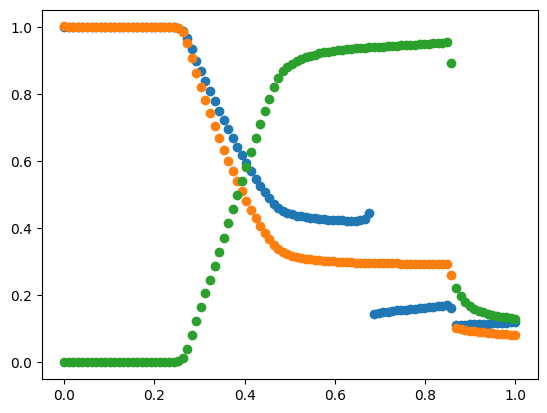

In [152]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()


In [51]:
new_array = np.array(u_pred[:,2])
#new_array = np.array(x)
file = open("p.txt", "w+")
content = str(new_array)
file.write(content)
file.close()


In [442]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

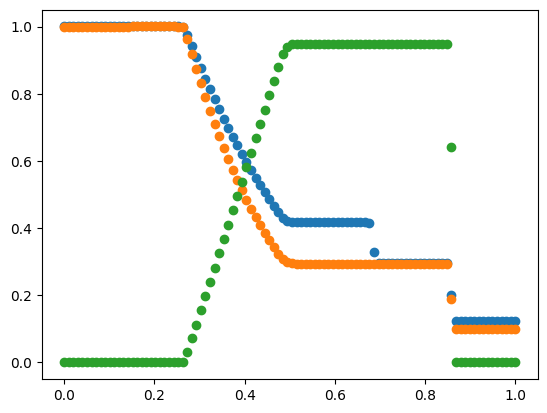

In [65]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

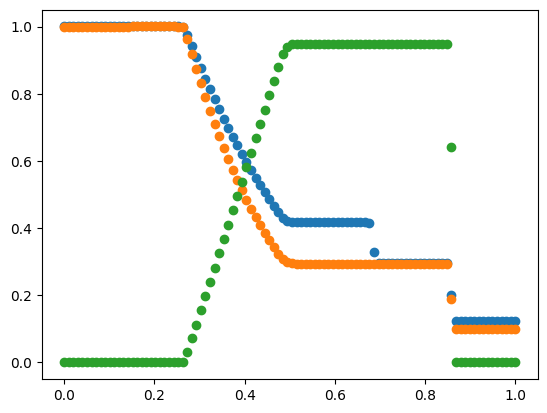

In [66]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

In [67]:
#np.size(id_f)
x_int_train = np.hstack((t_int, x_int))    # Random (x,t) - vectorized
#np.size(x_int_train)
#np.size(x_int)
#np.size(t_int)

In [68]:
def NewPoint(x,t):
    xl = -0.2
    xr = 1.8
    dgt = 0.0
    dg1 = np.array([])
    M = np.array([])
    N = np.size(x)
    L = np.array([])
    y = np.copy(x)
    for i in range(N):
        if i == 0:
            L = np.append(L,x[0]-xl)
            dgl = dg(x[0],t)
            dgr = dg(xl,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        elif i < N-1:
            L = np.append(L,x[i+1]-x[i])
            dgl = dg(x[i],t)
            dgr = dg(x[i+1],t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[i]
        else:
            L = np.append(L,xr-x[N-1])
            dgl = dg(x[N-1],t)
            dgr = dg(xr,t)
            dga = 0.5*(np.abs(dgl)+np.abs(dgr))
            dg1= np.append(dg1,dga)
            dgt += dga*L[N-1]
    for i in range(N):
        M = np.append(M,int((dg1[i]*L[i])/dgt*N+0.5))

    print("M")
  #  print(M)
  #  print("L")
  #  print(L)
    print("dg1")
    print(dg1)
    Mt = 0

    for i in range(N):
        if i ==0 and M[0] > 0:
            for j in range(int(M[0])):
                y[j] = (x[0] - xl)/M[0]*(j+1) + xl
        elif i < N-1 and M[i]> 0 and Mt<N:
            for j in range(int(M[i])):
                y[j+Mt] = (x[i] - x[i-1])/M[i]*(j+1) + x[i-1]
        elif i==N-1 and M[N-1] >0:
            for j in range(int(M[N-1])):
                y[j+Mt] = (xr - x[N-1])/M[N-1]*(j+1) + x[N-1]
        
        Mt = Mt + int(M[i])
    return dg1



In [69]:
x = np.linspace(-0.2, 1.8, 100)                                   # Partitioned spatial axis
t = np.linspace(0, 0.2, 100)                                   # Partitioned spatial axis

In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
i=0
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x[0:99],t[99])
    t_r[i*100:99+i*100] =t[i]

In [70]:
x_r[600:699]

array([1.60326131e+22, 5.76465166e+22, 3.70957999e+24, 2.36209280e+08,
       5.44426439e-05, 1.62787000e+31, 2.71339503e+20, 8.00166625e+05,
       2.30321930e-07, 1.63223644e+34, 9.21301453e+02, 1.04500940e+12,
       8.04466938e+05, 8.82407375e+05, 4.04630494e+30, 1.30378596e+16,
       3.74023992e+33, 5.69934527e+13, 2.48317636e+26, 1.35164815e+10,
       6.66888847e+10, 5.99938017e+22, 6.24761462e+13, 3.97429464e+27,
       9.15677632e+14, 5.88571517e+22, 6.25707169e+01, 1.52182157e+25,
       1.58646385e+16, 1.00809555e+09, 6.25212734e+04, 4.01251659e+27,
       5.91548866e+13, 7.31270681e+28, 2.80446143e+03, 3.15070821e+12,
       7.32291394e-10, 2.61014860e+14, 3.98053244e+33, 3.54250340e-09,
       8.04056745e-13, 1.10771648e+33, 7.17675236e+25, 2.96474181e+35,
       1.19384877e-05, 7.46800288e-10, 8.82343000e+05, 6.35693008e+04,
       9.44837312e+08, 3.37953381e+21, 1.60242736e-10, 2.82971350e+20,
       1.65894244e+13, 6.38337681e+25, 1.14916658e+24, 1.61912344e+28,
      

In [71]:
plt.scatter(x[0:99],x_r[0:99])

ERROR! Session/line number was not unique in database. History logging moved to new session 4629


In [ ]:
x_r = np.empty(10000, dtype=np.float32)
t_r = np.empty(10000, dtype=np.float32)
for i in range(np.size(t)):
    x_r[i*100:99+i*100] =NewPoint(x_r[i*100:99+i*100],t[i])
    #t_r[i*100:99+i*100] =t[i]

In [ ]:
t[0]

In [ ]:
T = t_r.flatten()[:, None]                                         # Vectorized t_grid
X = x_r.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain

In [ ]:

y =NewPoint(x,t[1])

In [ ]:
dg(1.8,0.2)

In [ ]:
def dg(x,t):
    y_t=np.array([[x]])
    t_t=np.array([[t]])
    x_t = np.hstack((y_t,t_t))

    x_t = torch.tensor(x_t, requires_grad=True, dtype=torch.float32).to(device)
    loss = model.loss_pde(x_t)                                    # Loss function of PDE
    y = model.net(x_t)                                                # Neural network
    rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
    drho_g = gradients(rho, x_t)[0]
    d = torch.tensor(drho_g, dtype=torch.float32).to(device1)
    return d.numpy()[0][0]


In [ ]:
x = np.linspace(-0.2, 1.8, 1000)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                        # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test1 = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred1 = to_numpy(model(x_test1))

In [ ]:

plt.plot(x[:],u_pred[:,0])

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x[:],u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [ ]:
y = model.net(x_int_train)                                                # Neural network
rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]                       # NN_{rho}, NN_{u}, NN_{p}
drho_g = gradients(rho, x_int_train)[0]

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x,u_pred[:,0])
plt.plot(x[:],u_pred[:,1])
plt.plot(x[:],u_pred[:,2])

In [386]:
#device1 = torch.device('cpu')                                          # Run on CPU
torch.save(model,'1.pt')

In [ ]:
model.load(torch.load(PATH))
model.to(device)

# 文件读取模型

In [ ]:

import matplotlib.pyplot as plt
x = np.linspace(-8.0 / 28.0, 20.0 / 28.0, num_x)  # Partitioned spatial axis
t = np.linspace(2.0, 2.0, 1)  # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)  # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]  # Vectorized t_grid
X = x_grid.flatten()[:, None]  # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to('cpu')
u_pred = to_numpy(model(x_test))
plt.plot(x,u_pred[:,0])
plt.plot(x,u_pred[:,1])
plt.plot(x,u_pred[:,2])
plt.plot(x,u_pred[:,3])
plt.plot(x,u_pred[:,4])

In [ ]:

plt.plot(x,u_pred[:,4])

In [ ]:
#u_pred[:,0]
import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
x = np.linspace(-1.5, 3.125, num_x)                                   # Partitioned spatial axis
t = np.linspace(0.2, 0.2, 1)                                        # Partitioned time axis
t_grid, x_grid = np.meshgrid(t, x)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized t_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T, X))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

import matplotlib.pyplot as plt
plt.plot(x[300:700],u_pred[300:700,0])
plt.plot(x[300:700],u_pred[300:700,1])
plt.plot(x[300:700],u_pred[300:700,2])

In [ ]:
def fun(x):
    return x.mean()

fun([1,2,3,4;1,2,3,4])

In [ ]:
(1,2,3,4).mean()

In [ ]:
p = np.zeros(100)

In [ ]:
p.mean()